In [213]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import zscore
from sklearn.metrics import (silhouette_samples,silhouette_score,make_scorer,mean_absolute_error, r2_score, mean_squared_error,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score)
from sklearn.base import (BaseEstimator,TransformerMixin,ClassifierMixin,RegressorMixin)
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, BaseCrossValidator, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import joblib
from joblib import load
import os
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score as ts_silhouette_score
import shap
from lime import lime_tabular

In [214]:
# Cargar los datos desde el archivo Excel
file_path = 'C:/Users/Andy/OneDrive/Desktop/MCD/Tesis/Datos_fuente_Bloomberg/en valores/serie completa 2014-2024/Dataset/dataset_oct_2014-set_2024_sin dlocal.xlsx'
df = pd.read_excel(file_path, sheet_name='dataset')

In [215]:
df.head()

Empresa     Fecha      P_E     P_B     P_S  P_Share   ROCE_sp  \
0  FLWS US Equity  20141031  35.4266  2.8638  0.6770     8.03  8.881198   
1  FLWS US Equity  20141128  37.7207  3.0493  0.7208     8.55  9.469145   
2  FLWS US Equity  20141231  11.3711  2.3843  0.5153     8.24  8.721900   
3  FLWS US Equity  20150130  10.8881  2.2830  0.4934     7.89  7.711122   
4  FLWS US Equity  20150227  17.2222  3.6111  0.7804    12.48  7.508469   

     ROCE_l    EBIT_sp    EBIT_l  ...  Efectivo y equiv_l  CPI  \
0  6.831567  18.021166 -0.264000  ...            2.610333  1.7   
1  7.776733  17.412222  2.352000  ...            3.906667  1.3   
2  8.721900   4.968000  4.968000  ...            5.203000  0.8   
3  8.876467  -9.636666  1.102667  ...            4.188000 -0.1   
4  9.031033 -16.726944 -2.762667  ...            3.173000  0.0   

   CPI_Exp_mediana  CPI_Exp_promedio  Fed Funds Rate  \
0            0.016            0.0162            0.25   
1            0.016            0.0157            0.25   
2            0.014            0.0142            0.25   
3            0.007            0.0069            0.25   
4           -0.001           -0.0013            0.25   

   Fed Funds Rate_Exp_mediana  Fed Funds Rate_Exp_promedio  Non farm payrolls  \
0                      0.0025                       0.0025                240   
1                      0.0025                       0.0025                284   
2                      0.0025                       0.0025                278   
3                      0.0025                       0.0025                196   
4                      0.0025                       0.0025                269   

   Non farm payrolls_Exp_mediana  Non farm payrolls_Exp_promedio  
0                           215k                         216.22k  
1                           235k                         236.62k  
2                           230k                         229.16k  
3                           240k                         234.73k  
4                           228k                         228.96k  

[5 rows x 37 columns]

In [216]:
df.tail()

Empresa     Fecha       P_E     P_B     P_S  P_Share    ROCE_sp  \
21595  XRX US Equity  20240531  241.3900  0.7342  0.2920   14.060  -2.396950   
21596  XRX US Equity  20240628  199.4987  0.6068  0.2413   11.620  -4.107900   
21597  XRX US Equity  20240731   19.3993  0.5668  0.2167   10.765 -13.106838   
21598  XRX US Equity  20240830   20.4174  0.5966  0.2281   11.330 -32.916020   
21599  XRX US Equity  20240930   19.0659  0.9907  0.2017   10.380 -67.057700   

          ROCE_l      EBIT_sp       EBIT_l  ...  Efectivo y equiv_l  CPI  \
21595  -4.988600    26.817010   -18.666667  ...          551.666667  3.3   
21596  -4.107900    25.000000    25.000000  ...          485.000000  3.0   
21597 -25.091167  -110.150343  -331.333333  ...          497.000000  2.9   
21598 -46.074433  -444.521262  -687.666667  ...          509.000000  2.5   
21599 -67.057700 -1044.000000 -1044.000000  ...          521.000000  2.4   

       CPI_Exp_mediana  CPI_Exp_promedio  Fed Funds Rate  \
21595            0.034            0.0340             5.5   
21596            0.034            0.0338             5.5   
21597            0.031            0.0310             5.5   
21598            0.030            0.0297             5.5   
21599            0.025            0.0255             5.0   

       Fed Funds Rate_Exp_mediana  Fed Funds Rate_Exp_promedio  \
21595                      0.0550                       0.0550   
21596                      0.0550                       0.0550   
21597                      0.0550                       0.0550   
21598                      0.0550                       0.0550   
21599                      0.0525                       0.0523   

       Non farm payrolls  Non farm payrolls_Exp_mediana  \
21595                216                           240k   
21596                118                           180k   
21597                144                           190k   
21598                 78                           175k   
21599                223                           165k   

       Non farm payrolls_Exp_promedio  
21595                         234.25k  
21596                         183.69k  
21597                         191.20k  
21598                         175.07k  
21599                         162.83k  

[5 rows x 37 columns]

### Análisis Exploratorio

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 0 to 21599
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Empresa                         21600 non-null  object 
 1   Fecha                           21600 non-null  int64  
 2   P_E                             21600 non-null  float64
 3   P_B                             21600 non-null  float64
 4   P_S                             21600 non-null  float64
 5   P_Share                         21600 non-null  float64
 6   ROCE_sp                         21600 non-null  float64
 7   ROCE_l                          21600 non-null  float64
 8   EBIT_sp                         21600 non-null  float64
 9   EBIT_l                          21600 non-null  float64
 10  Total Activos_sp                21600 non-null  float64
 11  Total Activos_l                 21600 non-null  float64
 12  Deuda a LP_sp                   

In [218]:
# Quitar "k" de las columnas "Non farm payrolls_Exp_mediana" y "Non farm payrolls_Exp_promedio"
df['Non farm payrolls_Exp_mediana'] = df['Non farm payrolls_Exp_mediana'].astype(str).str.replace('k', '')
df['Non farm payrolls_Exp_promedio'] = df['Non farm payrolls_Exp_promedio'].astype(str).str.replace('k', '')

# Convertir las columnas a valores numéricos
df['Non farm payrolls_Exp_mediana'] = pd.to_numeric(df['Non farm payrolls_Exp_mediana'], errors='coerce')
df['Non farm payrolls_Exp_promedio'] = pd.to_numeric(df['Non farm payrolls_Exp_promedio'], errors='coerce')

In [219]:
# Convertir la columna de fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y%m%d')

# Extraer características temporales relevantes
df['mes'] = df['Fecha'].dt.month
df['año'] = df['Fecha'].dt.year
df['periodo'] = df['Fecha'].dt.to_period('M')

In [220]:
# Convertir CPI y Fed Funds Rate a decimales
df['CPI'] = df['CPI'] / 100
df['Fed Funds Rate'] = df['Fed Funds Rate'] / 100

In [221]:
# Calcular diferencias en puntos básicos
df['dif_CPI_mediana'] = (df['CPI'] - df['CPI_Exp_mediana']) * 10000
df['dif_CPI_promedio'] = (df['CPI'] - df['CPI_Exp_promedio']) * 10000

df['dif_FFR_mediana'] = (df['Fed Funds Rate'] - df['Fed Funds Rate_Exp_mediana']) * 10000
df['dif_FFR_promedio'] = (df['Fed Funds Rate'] - df['Fed Funds Rate_Exp_promedio']) * 10000

# Calcular diferencia
df['dif_NFP_mediana'] = (df['Non farm payrolls'] - df['Non farm payrolls_Exp_mediana'])
df['dif_NFP_promedio'] = (df['Non farm payrolls'] - df['Non farm payrolls_Exp_promedio'])

In [222]:
report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)

In [223]:
show_report = report.show_html('C:/Users/Andy/OneDrive/Desktop/MCD/Tesis/Datos_fuente_Bloomberg/en valores/serie completa 2014-2024/Dataset/Reporte.html')

Report C:/Users/Andy/OneDrive/Desktop/MCD/Tesis/Datos_fuente_Bloomberg/en valores/serie completa 2014-2024/Dataset/Reporte.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [224]:
df.head()

Empresa      Fecha      P_E     P_B     P_S  P_Share   ROCE_sp  \
0  FLWS US Equity 2014-10-31  35.4266  2.8638  0.6770     8.03  8.881198   
1  FLWS US Equity 2014-11-28  37.7207  3.0493  0.7208     8.55  9.469145   
2  FLWS US Equity 2014-12-31  11.3711  2.3843  0.5153     8.24  8.721900   
3  FLWS US Equity 2015-01-30  10.8881  2.2830  0.4934     7.89  7.711122   
4  FLWS US Equity 2015-02-27  17.2222  3.6111  0.7804    12.48  7.508469   

     ROCE_l    EBIT_sp    EBIT_l  ...  Non farm payrolls_Exp_promedio  mes  \
0  6.831567  18.021166 -0.264000  ...                          216.22   10   
1  7.776733  17.412222  2.352000  ...                          236.62   11   
2  8.721900   4.968000  4.968000  ...                          229.16   12   
3  8.876467  -9.636666  1.102667  ...                          234.73    1   
4  9.031033 -16.726944 -2.762667  ...                          228.96    2   

    año  periodo  dif_CPI_mediana  dif_CPI_promedio  dif_FFR_mediana  \
0  2014  2014-10             10.0               8.0              0.0   
1  2014  2014-11            -30.0             -27.0              0.0   
2  2014  2014-12            -60.0             -62.0              0.0   
3  2015  2015-01            -80.0             -79.0              0.0   
4  2015  2015-02             10.0              13.0              0.0   

   dif_FFR_promedio  dif_NFP_mediana  dif_NFP_promedio  
0               0.0               25             23.78  
1               0.0               49             47.38  
2               0.0               48             48.84  
3               0.0              -44            -38.73  
4               0.0               41             40.04  

[5 rows x 46 columns]

##### Columnas numéricas_lineal_mediana

In [225]:
# Lista de columnas numéricas para análisis con mensualización lineal de los ratios 
# y variables macroeconómicas calculadas con mediana
columnas_numericas_lineal_mediana= [
    'P_E',
    'P_B',
    'P_S',
    'P_Share',
    'ROCE_l',
    'EBIT_l',
    'Total Activos_l',
    'Deuda a LP_l',
    'ROA_l',
    'Beneficio neto_l',
    'ROI_l',
    'EV_l',
    'Cap de mercado_l',
    'Deuda a CP_l',
    'Efectivo y equiv_l',
    'dif_CPI_mediana',
    'dif_FFR_mediana',
    'dif_NFP_mediana'
]

##### Columnas numéricas_spline_mediana

In [226]:
# Lista de columnas numéricas para análisis con mensualización spline de los ratios 
# y variables macroeconómicas calculadas con mediana
columnas_numericas_spline_mediana = [
    'P_E',
    'P_B',
    'P_S',
    'P_Share',
    'ROCE_sp',
    'EBIT_sp',
    'Total Activos_sp',
    'Deuda a LP_sp',
    'ROA_sp',
    'Beneficio neto_sp',
    'ROI_sp',
    'EV_sp',
    'Cap de mercado_sp',
    'Deuda a CP_sp',
    'Efectivo y equiv_sp',
    'dif_CPI_mediana',
    'dif_FFR_mediana',
    'dif_NFP_mediana'
]

##### Columnas numéricas_lineal_promedio

In [227]:
# Lista de columnas numéricas para análisis con mensualización lineal de los ratios 
# y variables macroeconómicas calculadas con promedio
columnas_numericas_lineal_promedio = [
    'P_E',
    'P_B',
    'P_S',
    'P_Share',
    'ROCE_l',
    'EBIT_l',
    'Total Activos_l',
    'Deuda a LP_l',
    'ROA_l',
    'Beneficio neto_l',
    'ROI_l',
    'EV_l',
    'Cap de mercado_l',
    'Deuda a CP_l',
    'Efectivo y equiv_l',
    'dif_CPI_promedio',
    'dif_FFR_promedio',
    'dif_NFP_promedio'
]

##### Columnas numéricas_spline_promedio

In [228]:
# Lista de columnas numéricas para análisis con mensualización spline de los ratios 
# y variables macroeconómicas calculadas con promedio
columnas_numericas_spline_promedio = [
    'P_E',
    'P_B',
    'P_S',
    'P_Share',
    'ROCE_sp',
    'EBIT_sp',
    'Total Activos_sp',
    'Deuda a LP_sp',
    'ROA_sp',
    'Beneficio neto_sp',
    'ROI_sp',
    'EV_sp',
    'Cap de mercado_sp',
    'Deuda a CP_sp',
    'Efectivo y equiv_sp',
    'dif_CPI_promedio',
    'dif_FFR_promedio',
    'dif_NFP_promedio'
]


Analizando lista de columnas: lineal_mediana

Generando histogramas...


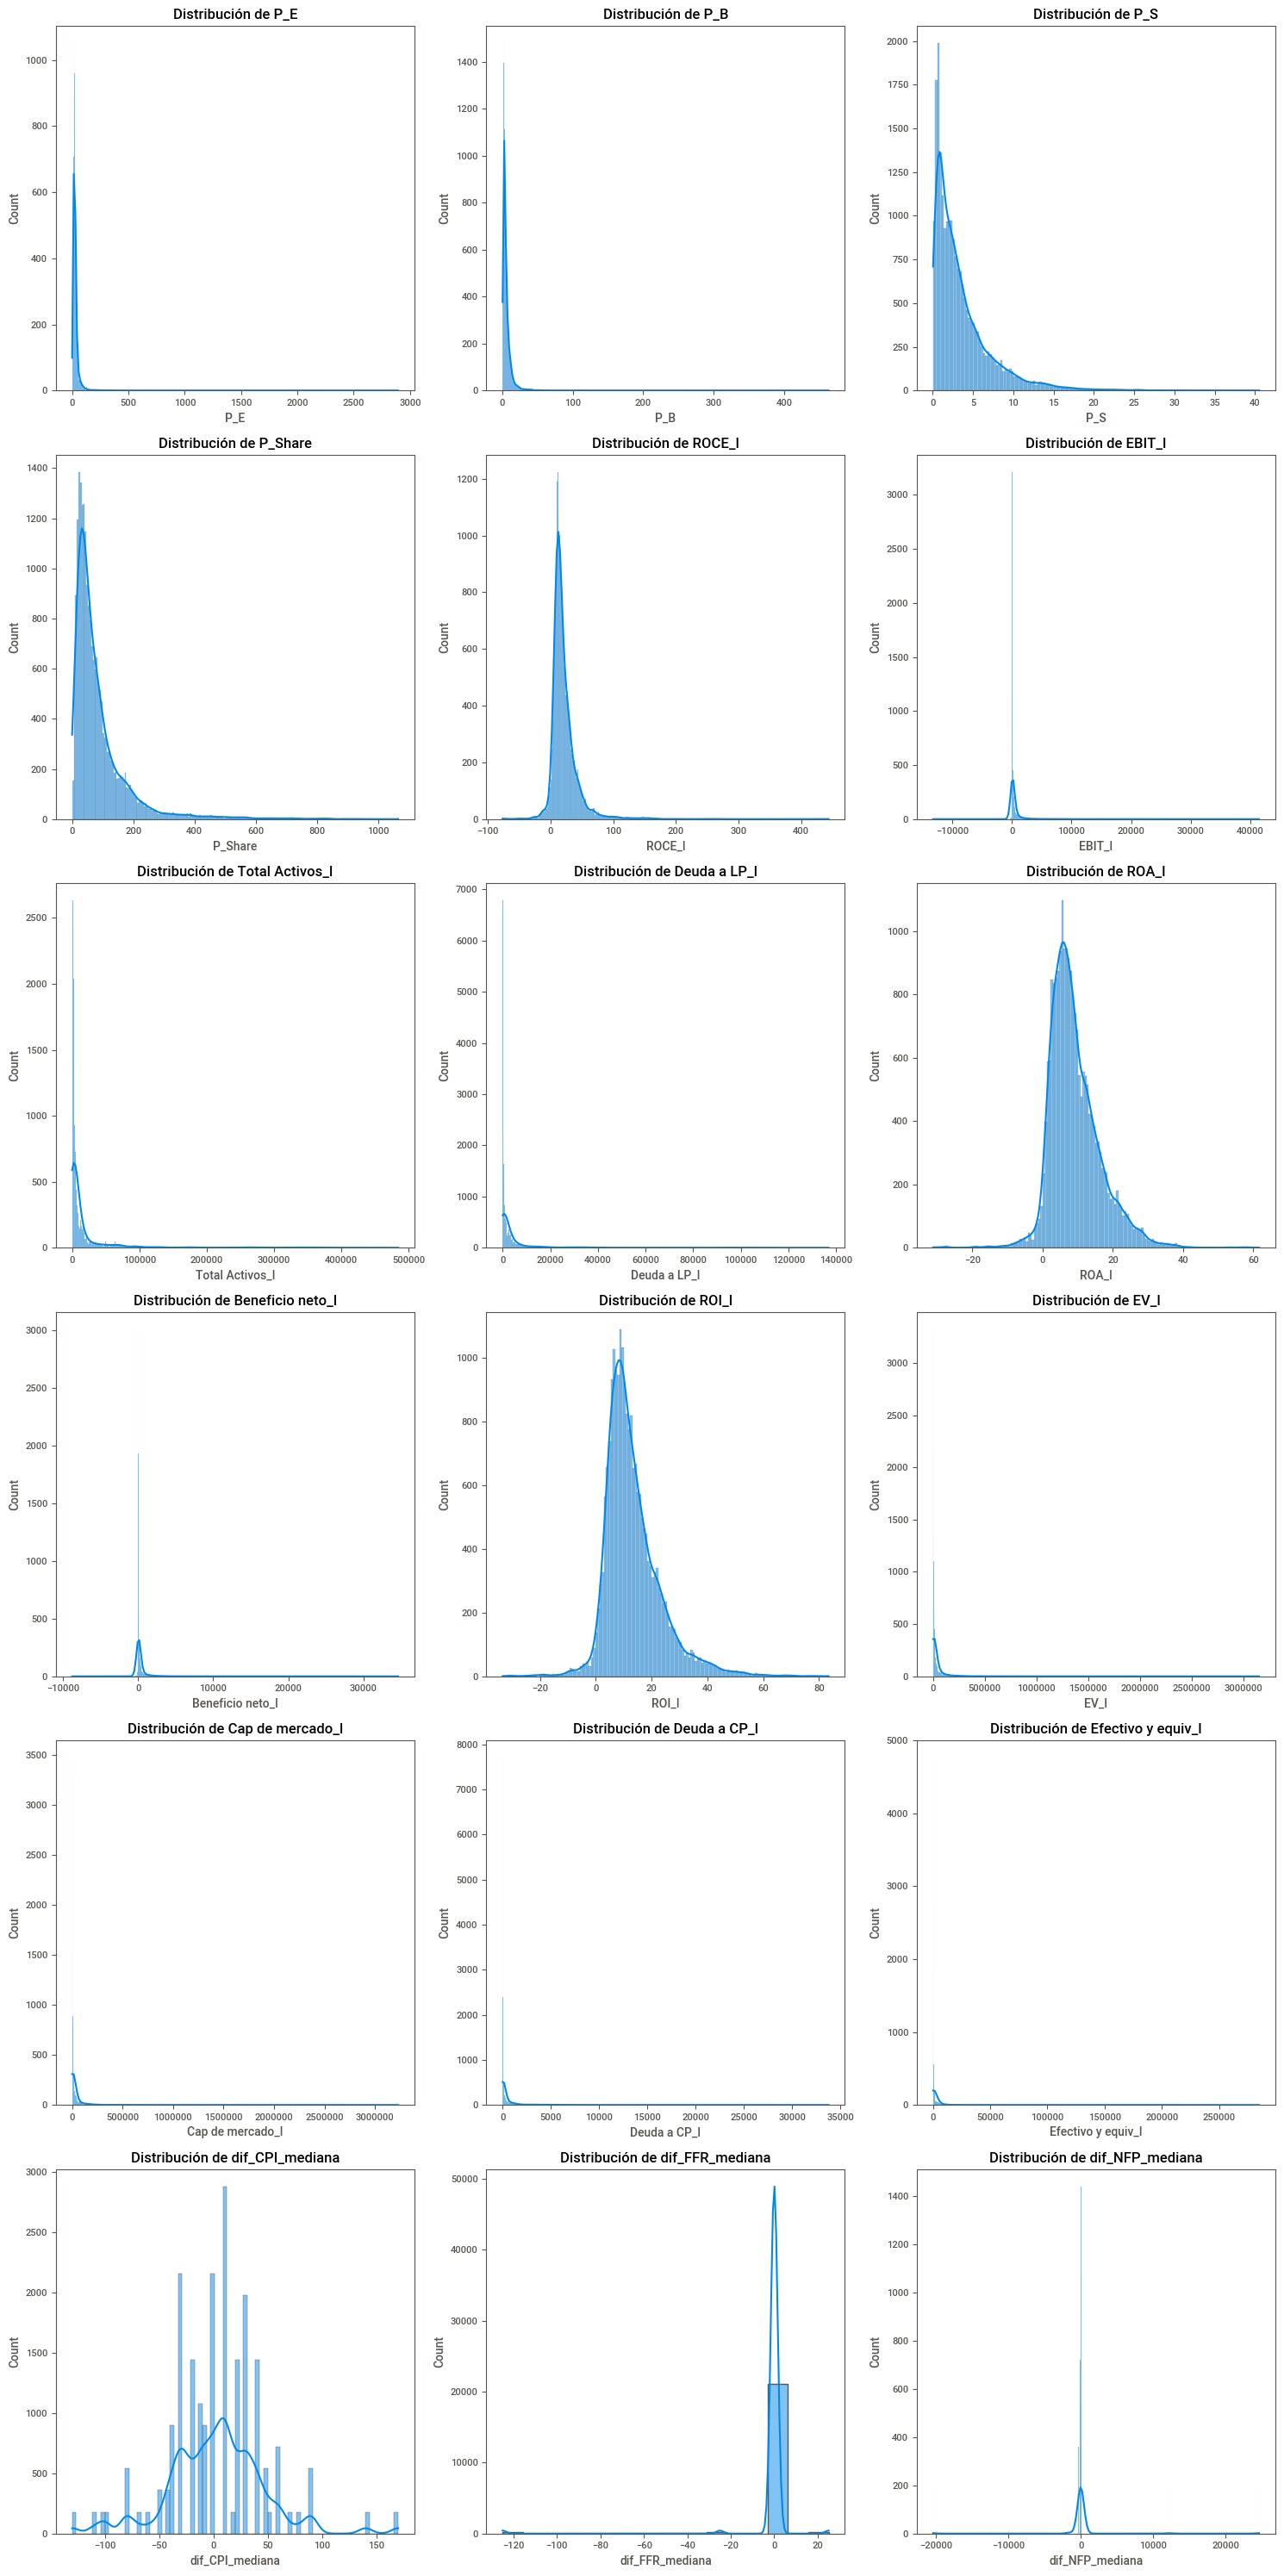


Generando matriz de correlación...


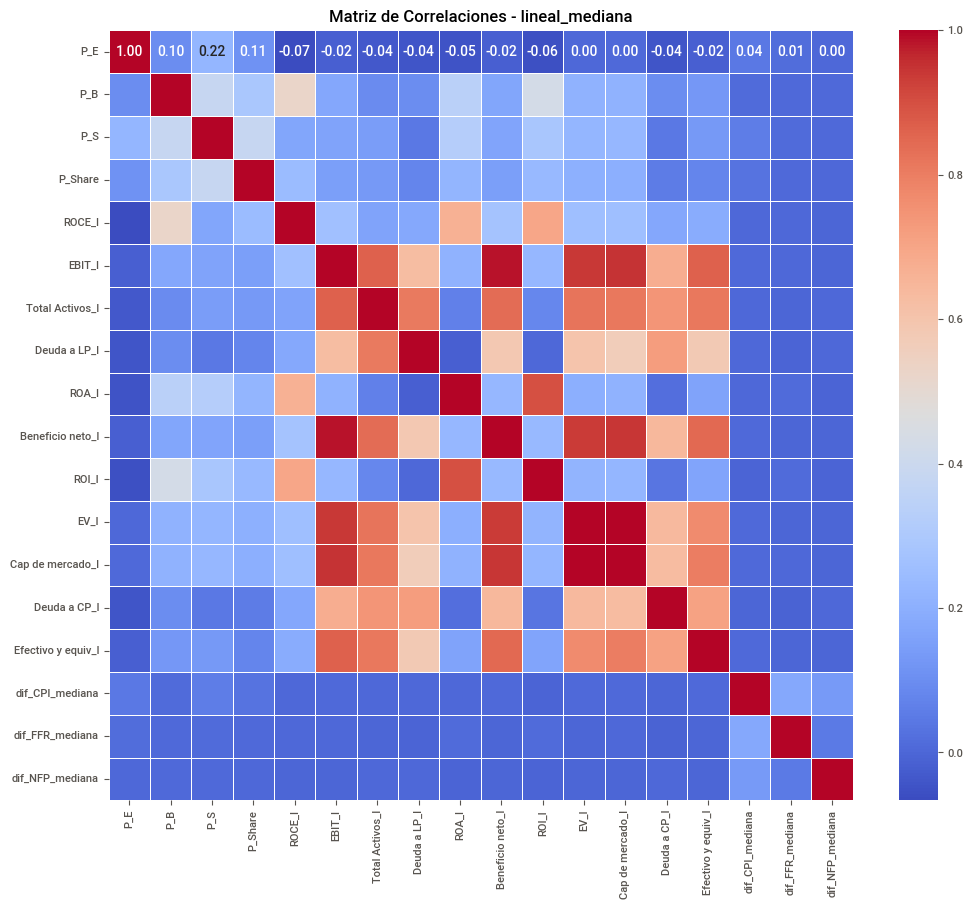


Generando boxplots...


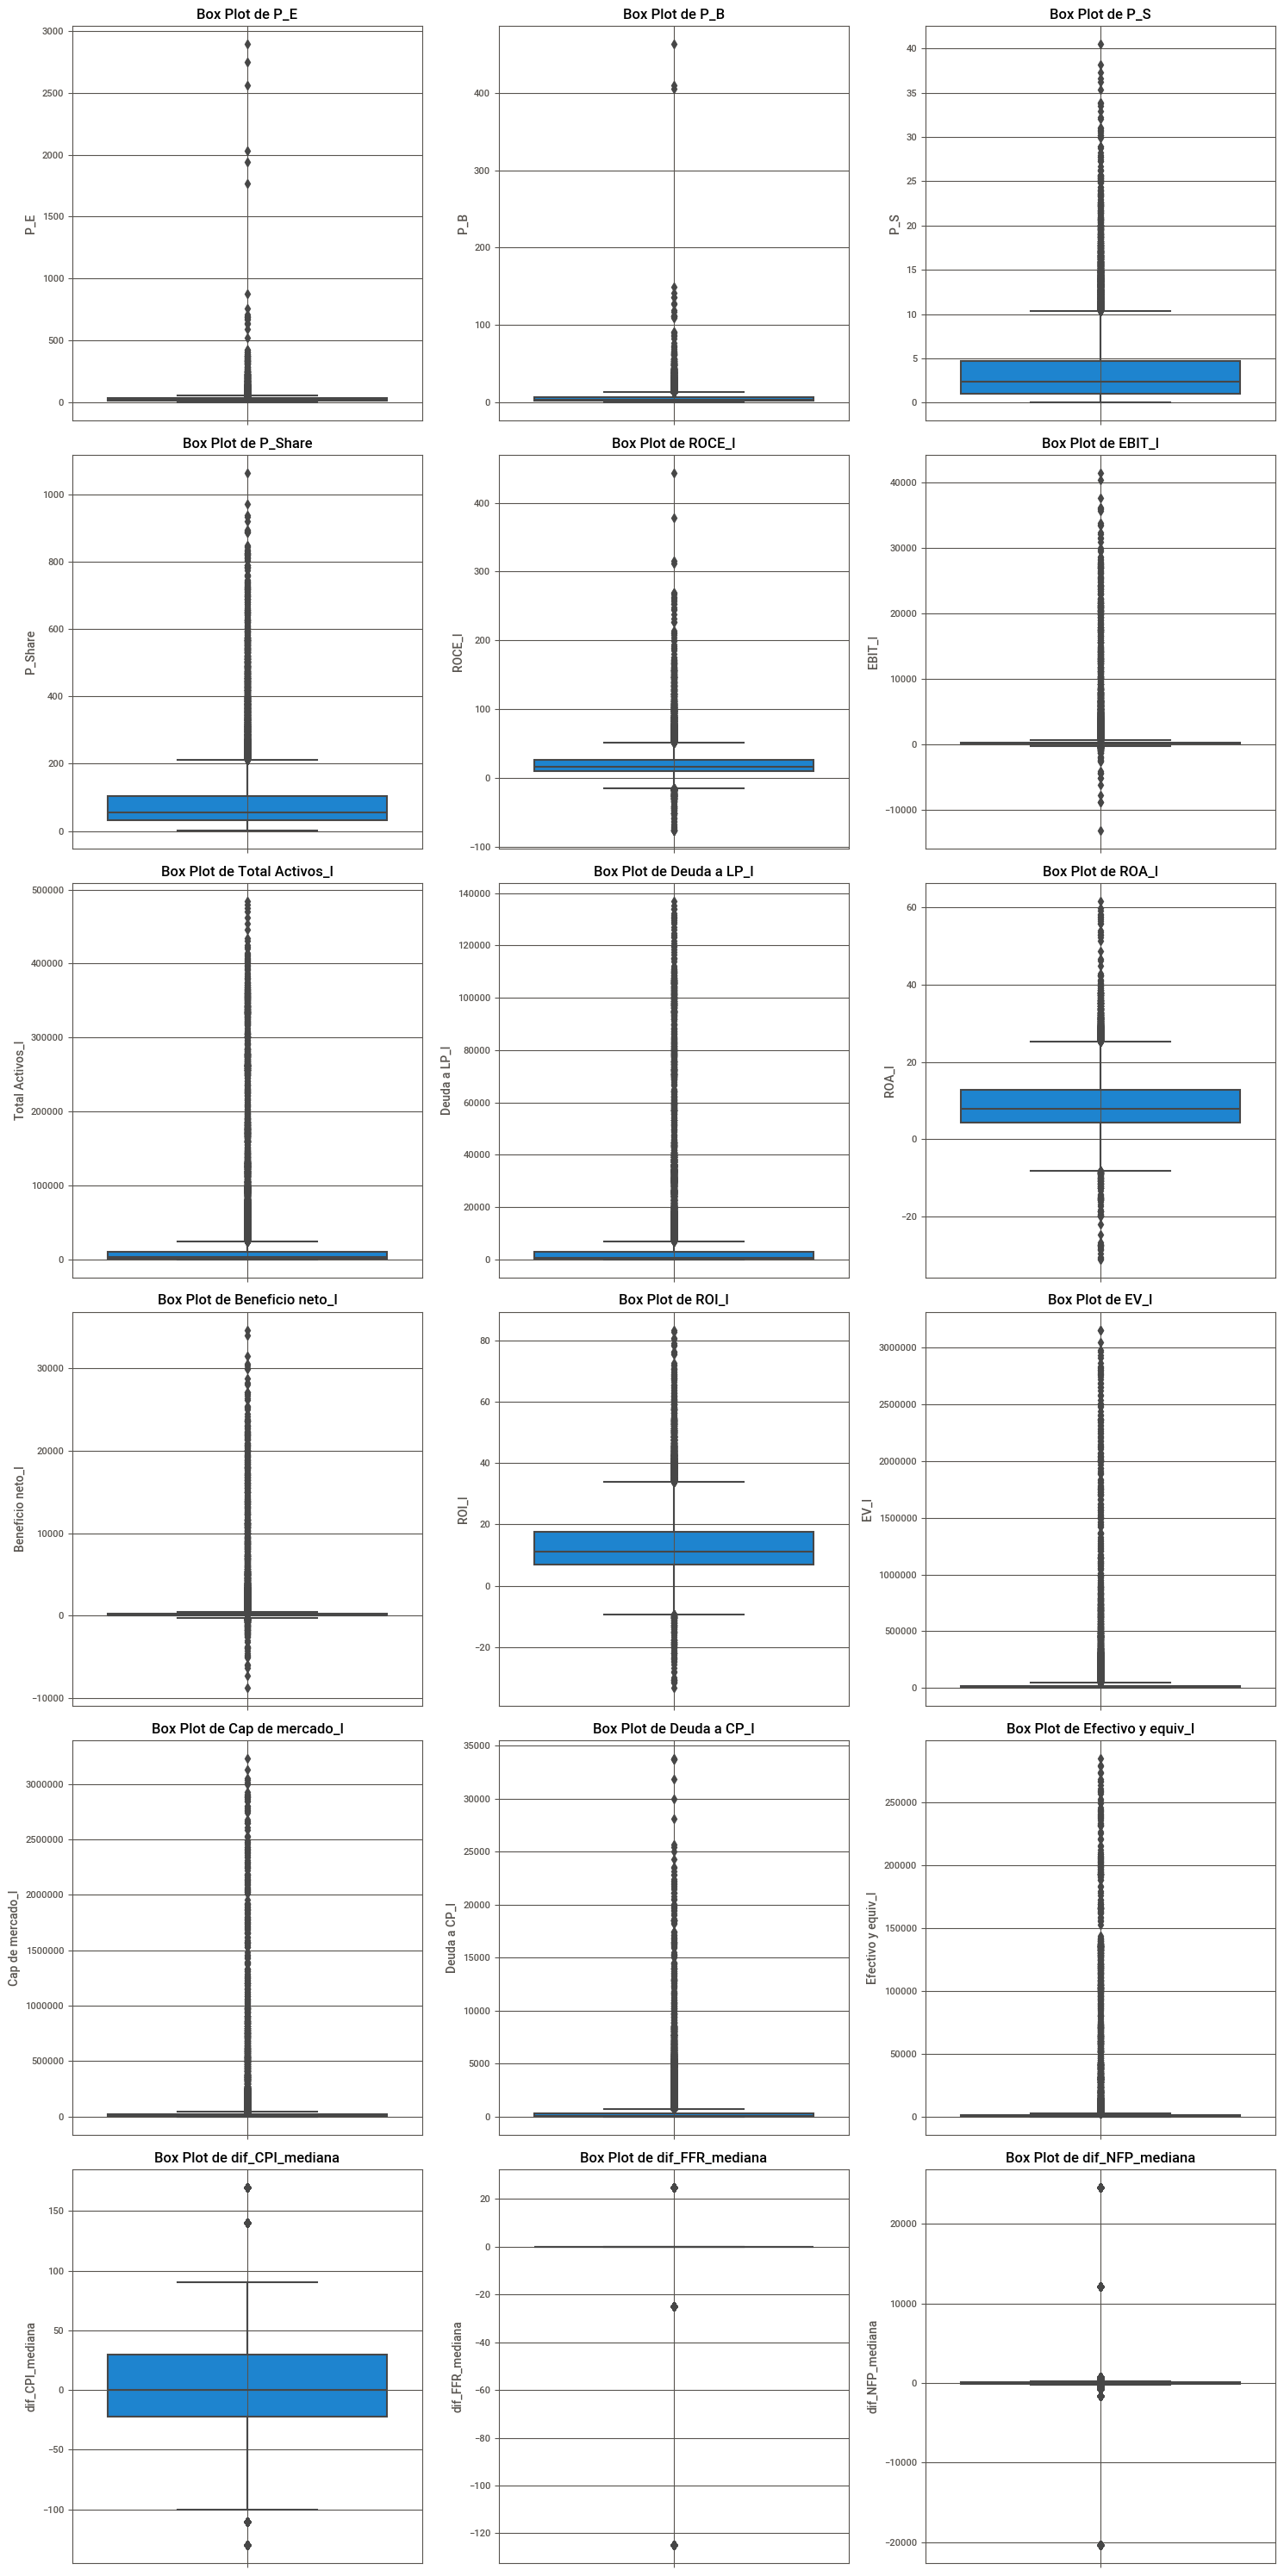


Detectando outliers con Z-score...
Outliers detectados con Z-score:
            P_E     P_B     P_S  P_Share     ROCE_l       EBIT_l  \
65      21.7693  2.1918  0.6413   13.230  11.756400   -20.653000   
66      31.5762  3.1793  0.9302   19.190  11.566000    19.421667   
67      36.4302  3.6680  1.0732   22.140  11.375600    59.496333   
68      20.6970  3.2192  0.8667   20.020  11.185200    99.571000   
78      17.1299  4.1566  1.0063   31.975  19.649067    40.226667   
...         ...     ...     ...      ...        ...          ...   
21594  228.1702  0.6940  0.2760   13.290  -5.869300   -62.333333   
21595  241.3900  0.7342  0.2920   14.060  -4.988600   -18.666667   
21596  199.4987  0.6068  0.2413   11.620  -4.107900    25.000000   
21598   20.4174  0.5966  0.2281   11.330 -46.074433  -687.666667   
21599   19.0659  0.9907  0.2017   10.380 -67.057700 -1044.000000   

       Total Activos_l  Deuda a LP_l      ROA_l  Beneficio neto_l      ROI_l  \
65          664.955000    158.4250

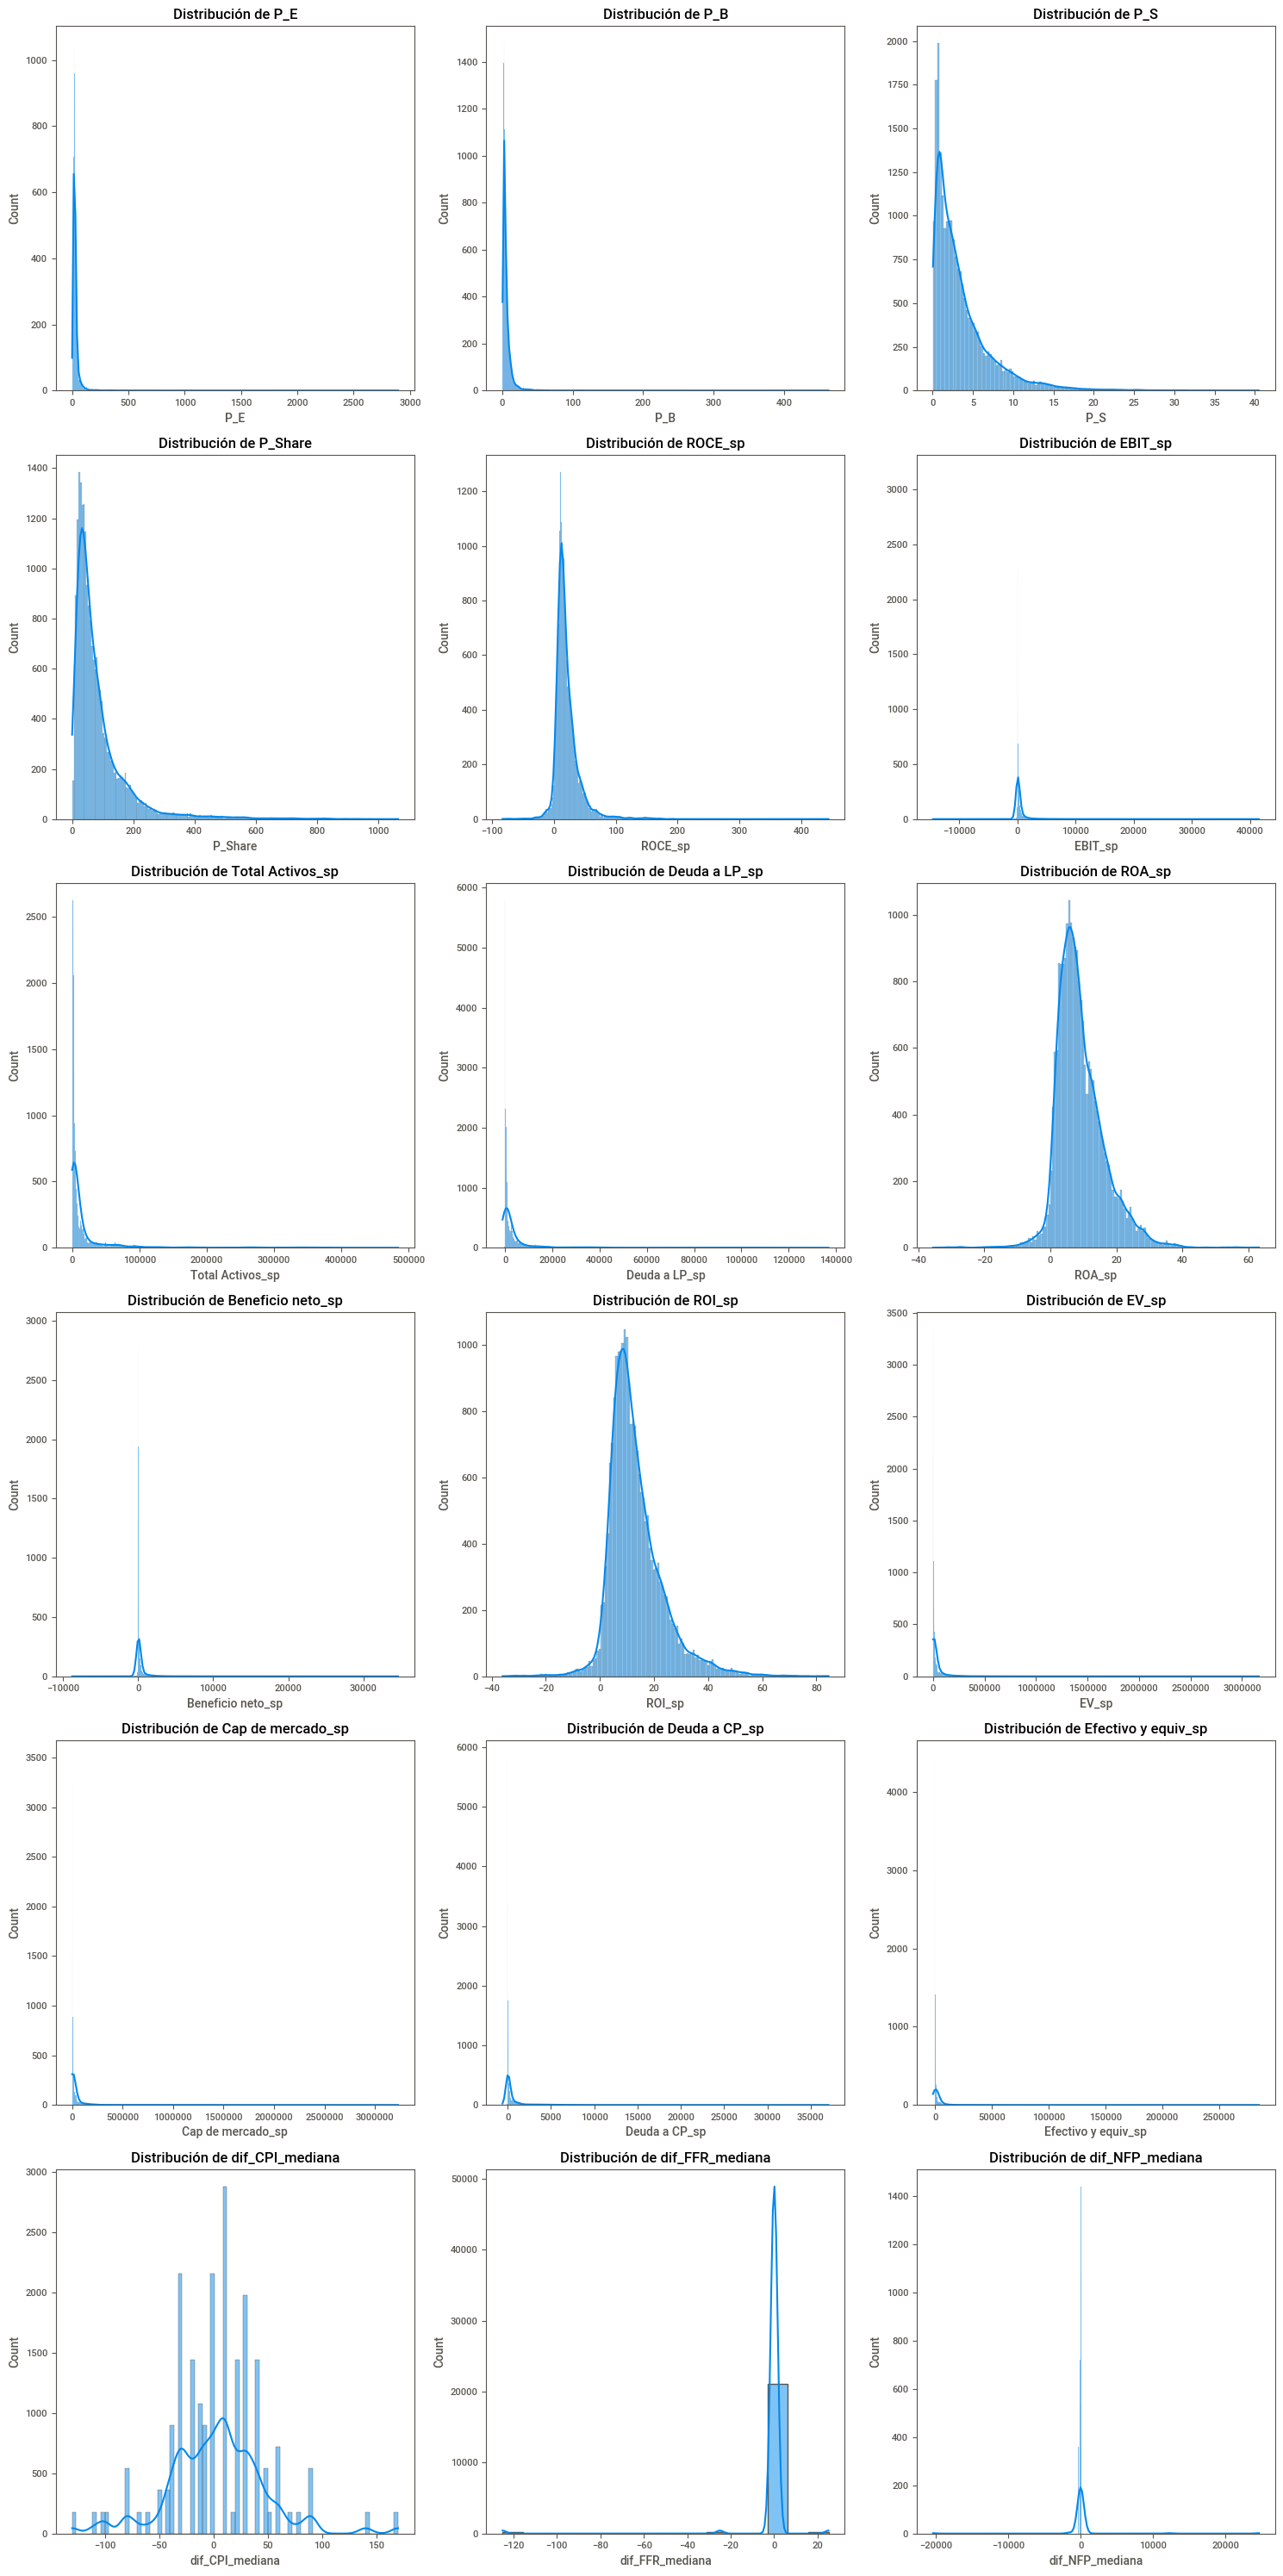


Generando matriz de correlación...


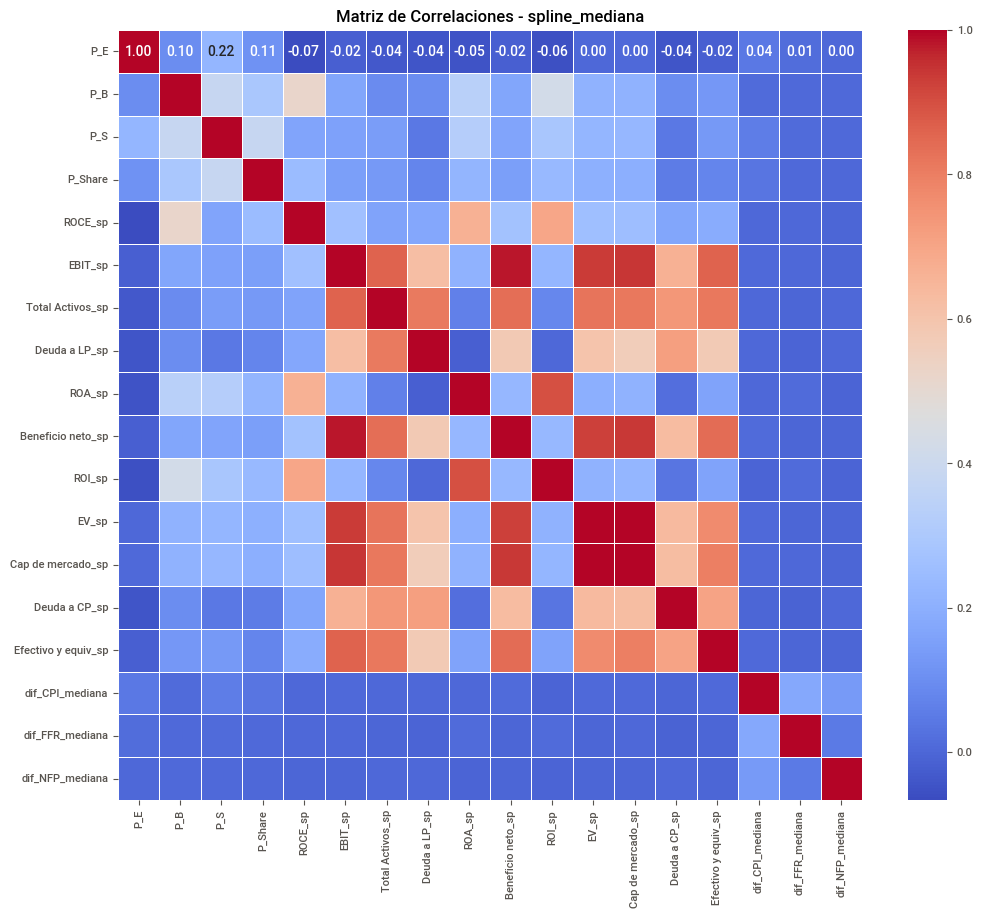


Generando boxplots...


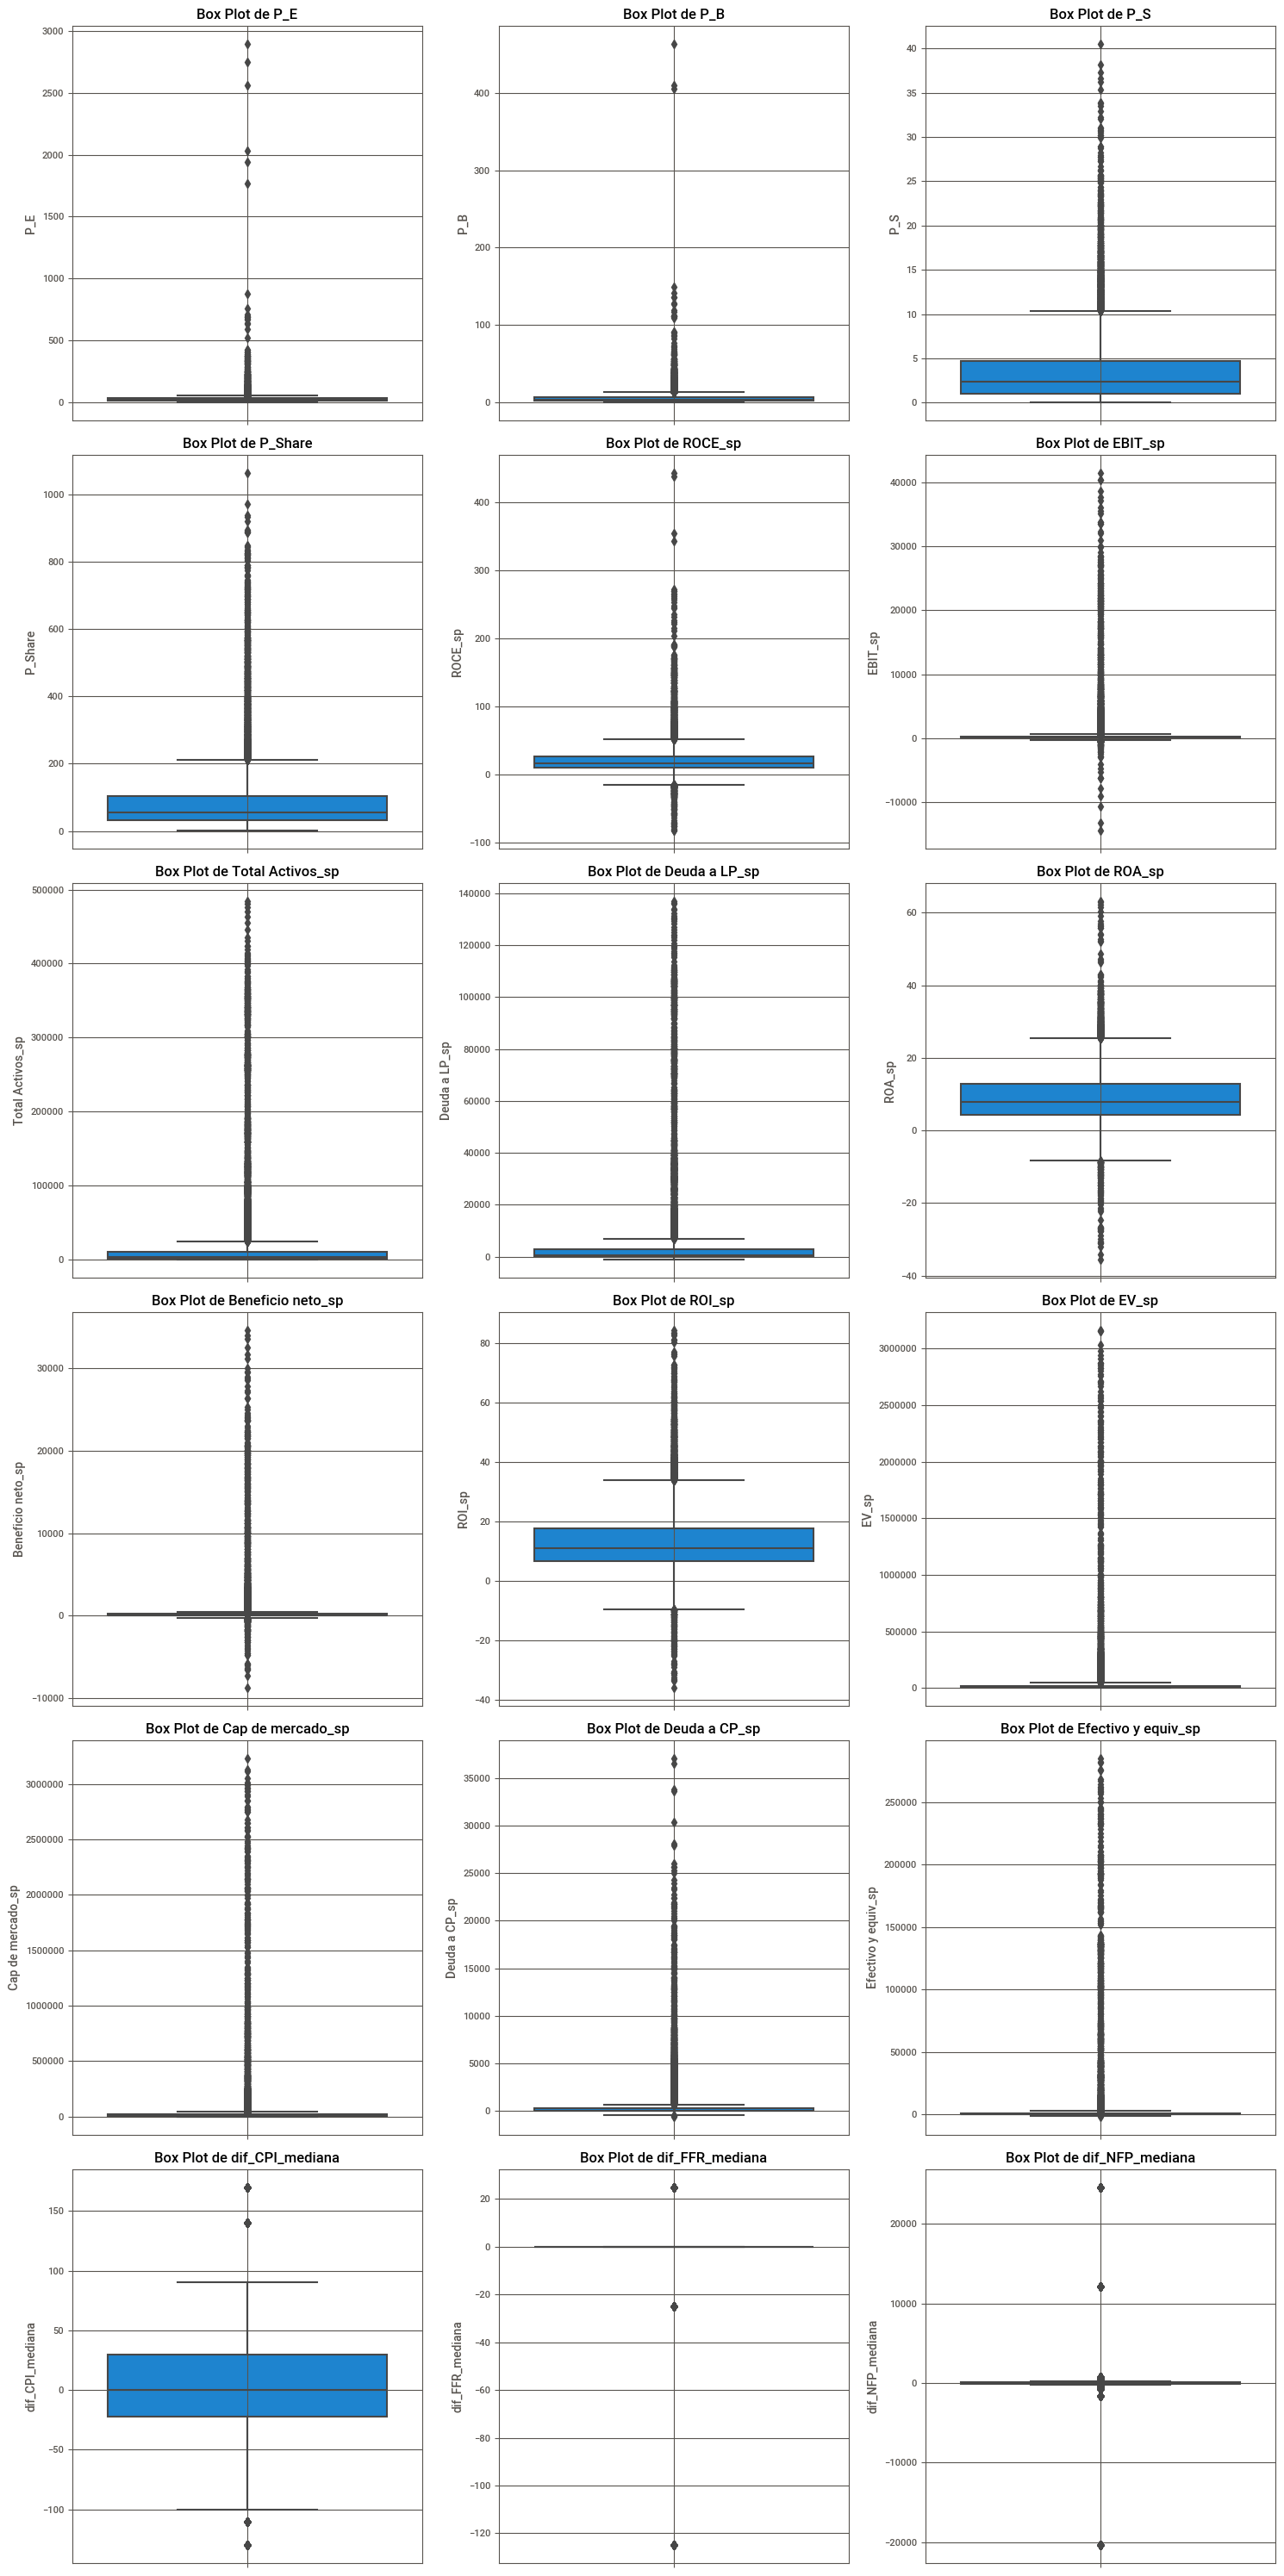


Detectando outliers con Z-score...
Outliers detectados con Z-score:
            P_E     P_B     P_S  P_Share    ROCE_sp      EBIT_sp  \
65      21.7693  2.1918  0.6413   13.230  11.756400   -20.653000   
66      31.5762  3.1793  0.9302   19.190  11.805182    22.906276   
67      36.4302  3.6680  1.0732   22.140  11.586879    74.383460   
68      20.6970  3.2192  0.8667   20.020  11.185200    99.571000   
78      17.1299  4.1566  1.0063   31.975  19.376663    42.744912   
...         ...     ...     ...      ...        ...          ...   
21559   33.1133  0.8297  0.6963   23.450   4.823566    59.728043   
21594  228.1702  0.6940  0.2760   13.290  -4.451735   -38.812071   
21595  241.3900  0.7342  0.2920   14.060  -2.396950    26.817010   
21596  199.4987  0.6068  0.2413   11.620  -4.107900    25.000000   
21599   19.0659  0.9907  0.2017   10.380 -67.057700 -1044.000000   

       Total Activos_sp  Deuda a LP_sp     ROA_sp  Beneficio neto_sp  \
65           664.955000     158.425000   6

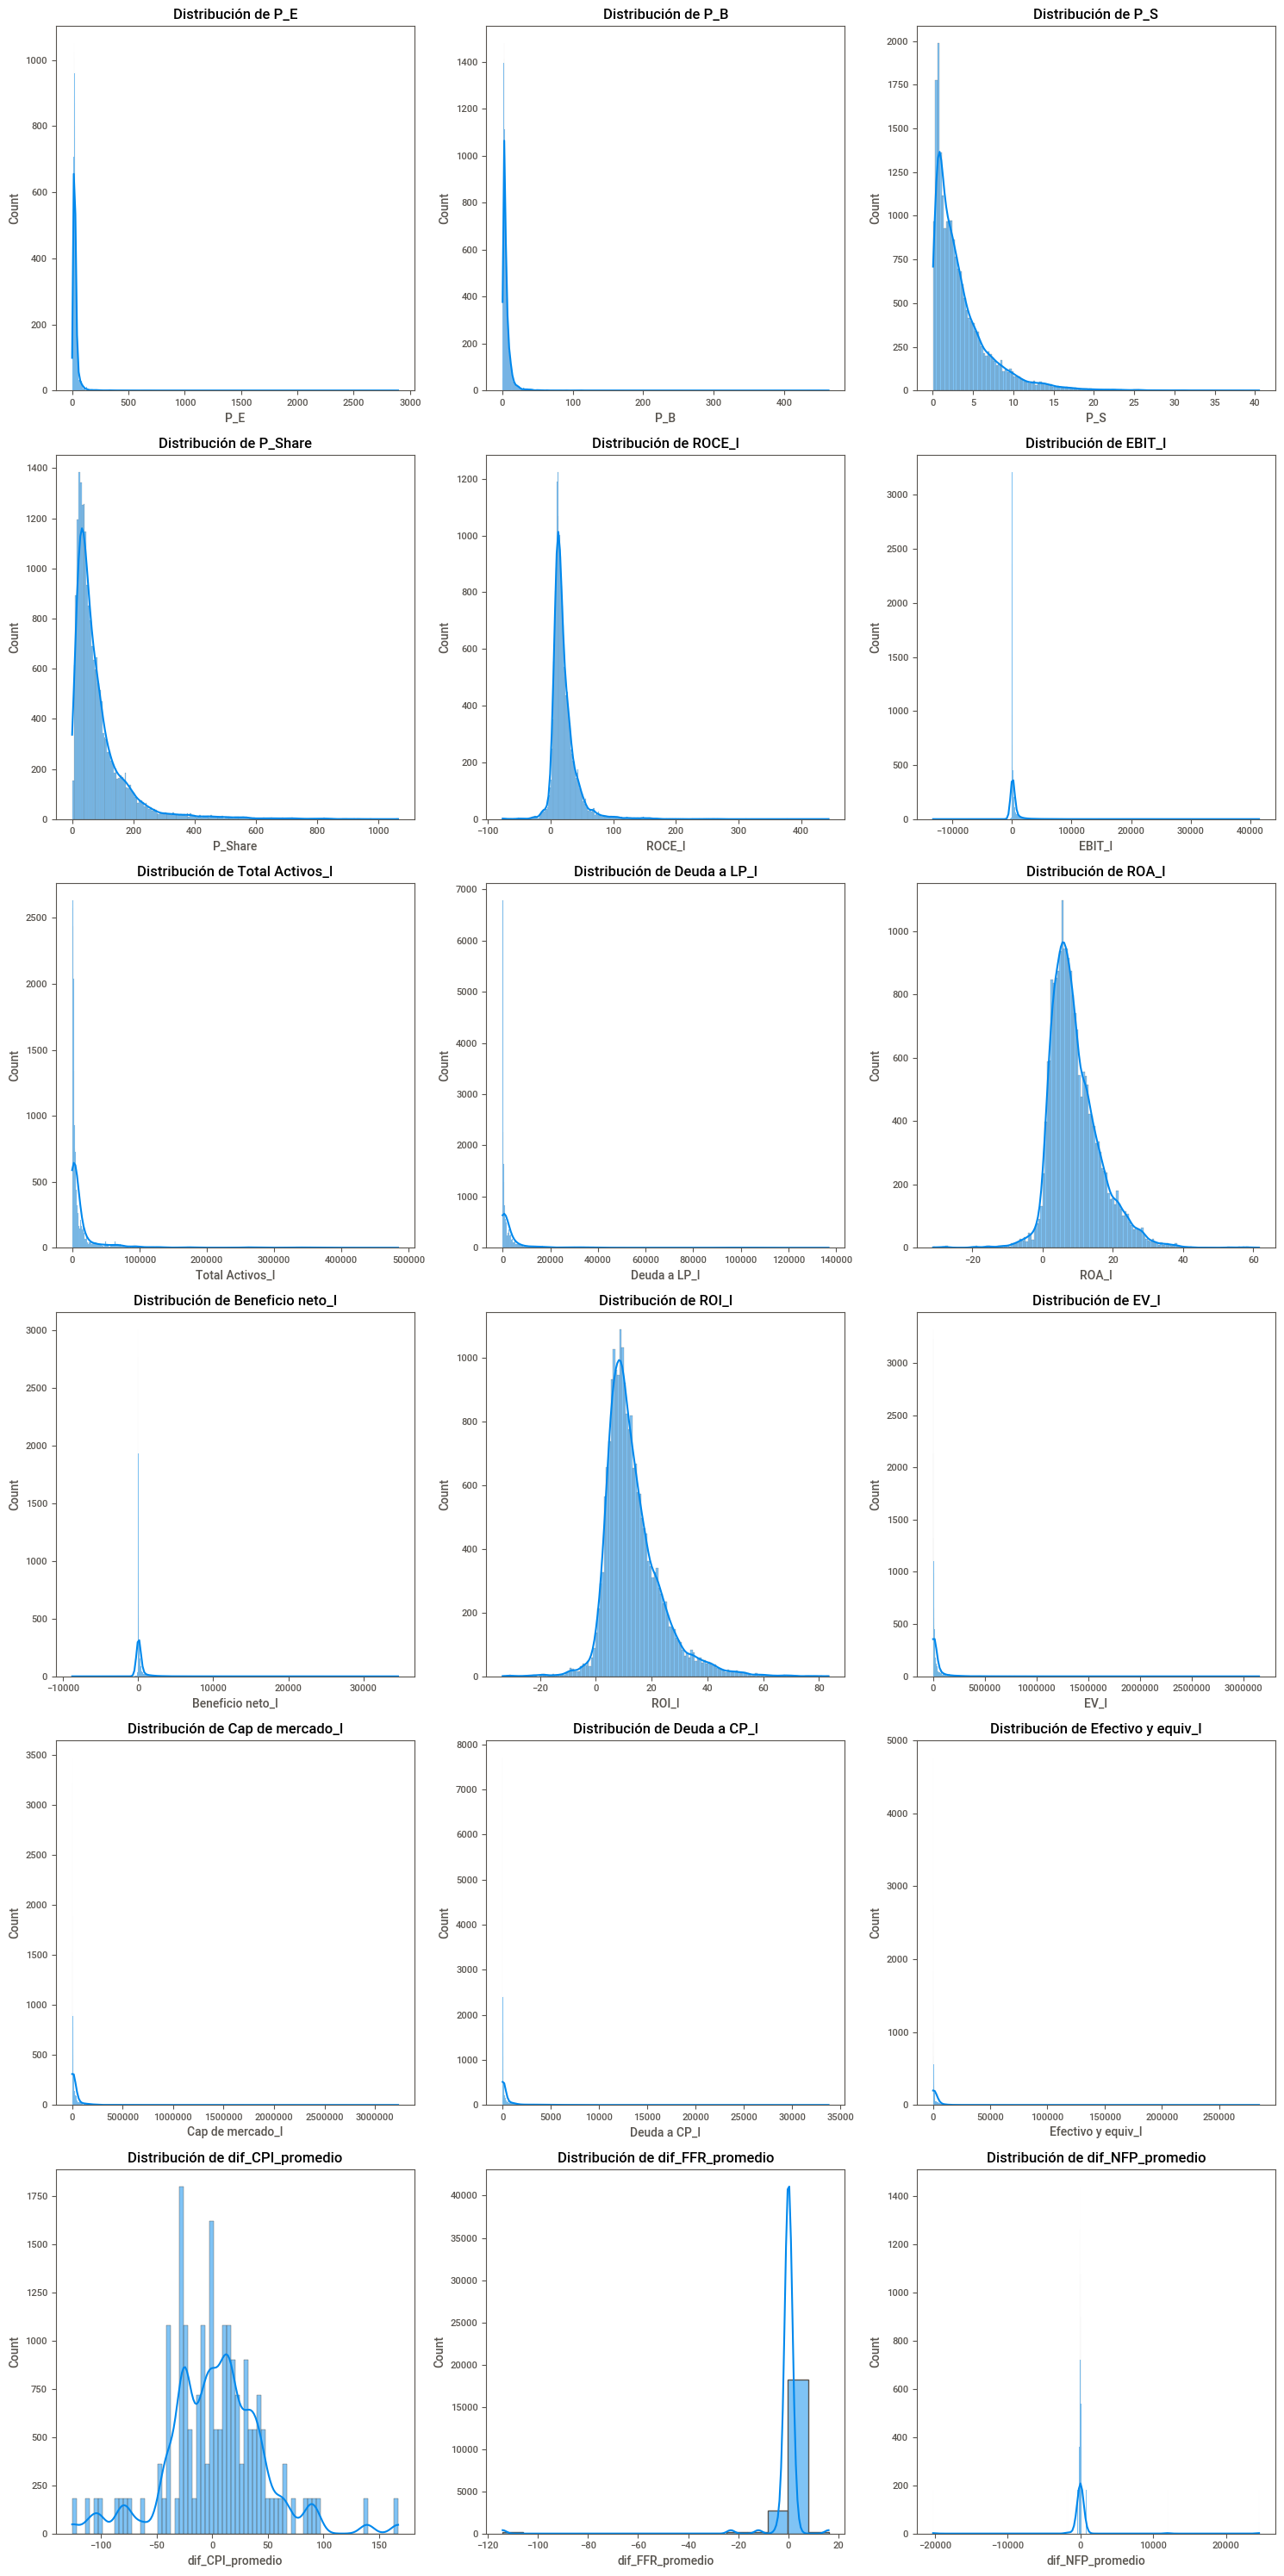


Generando matriz de correlación...


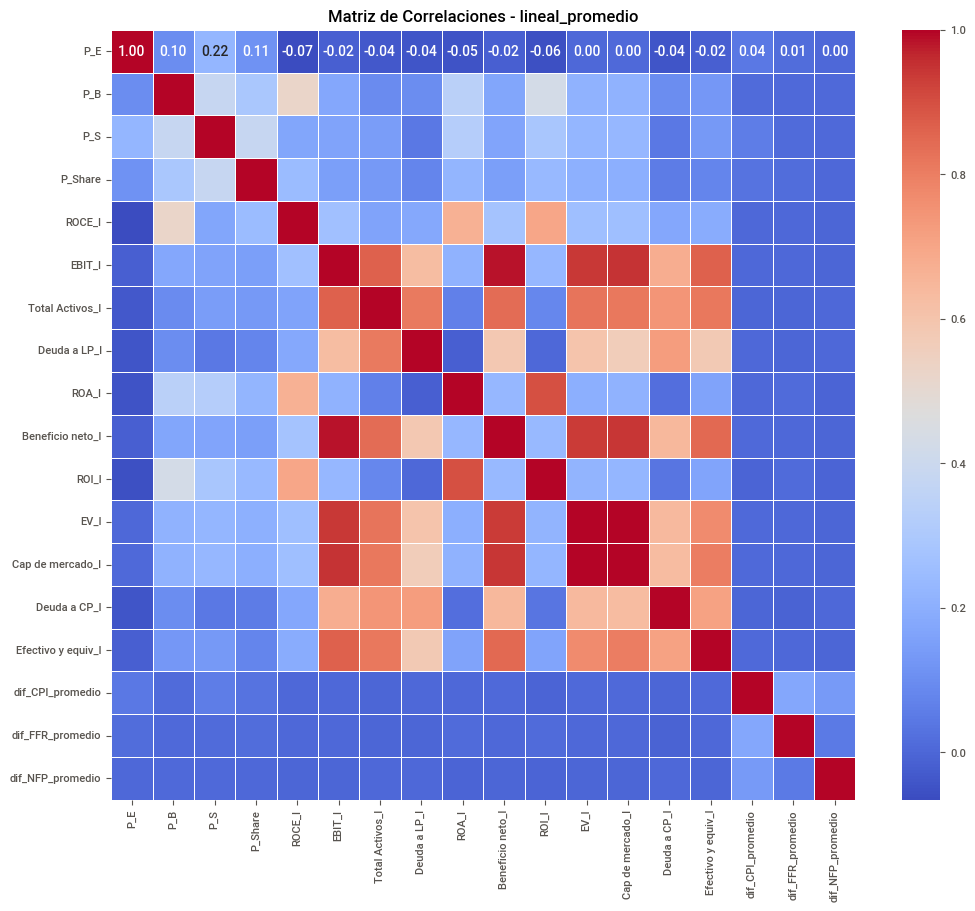


Generando boxplots...


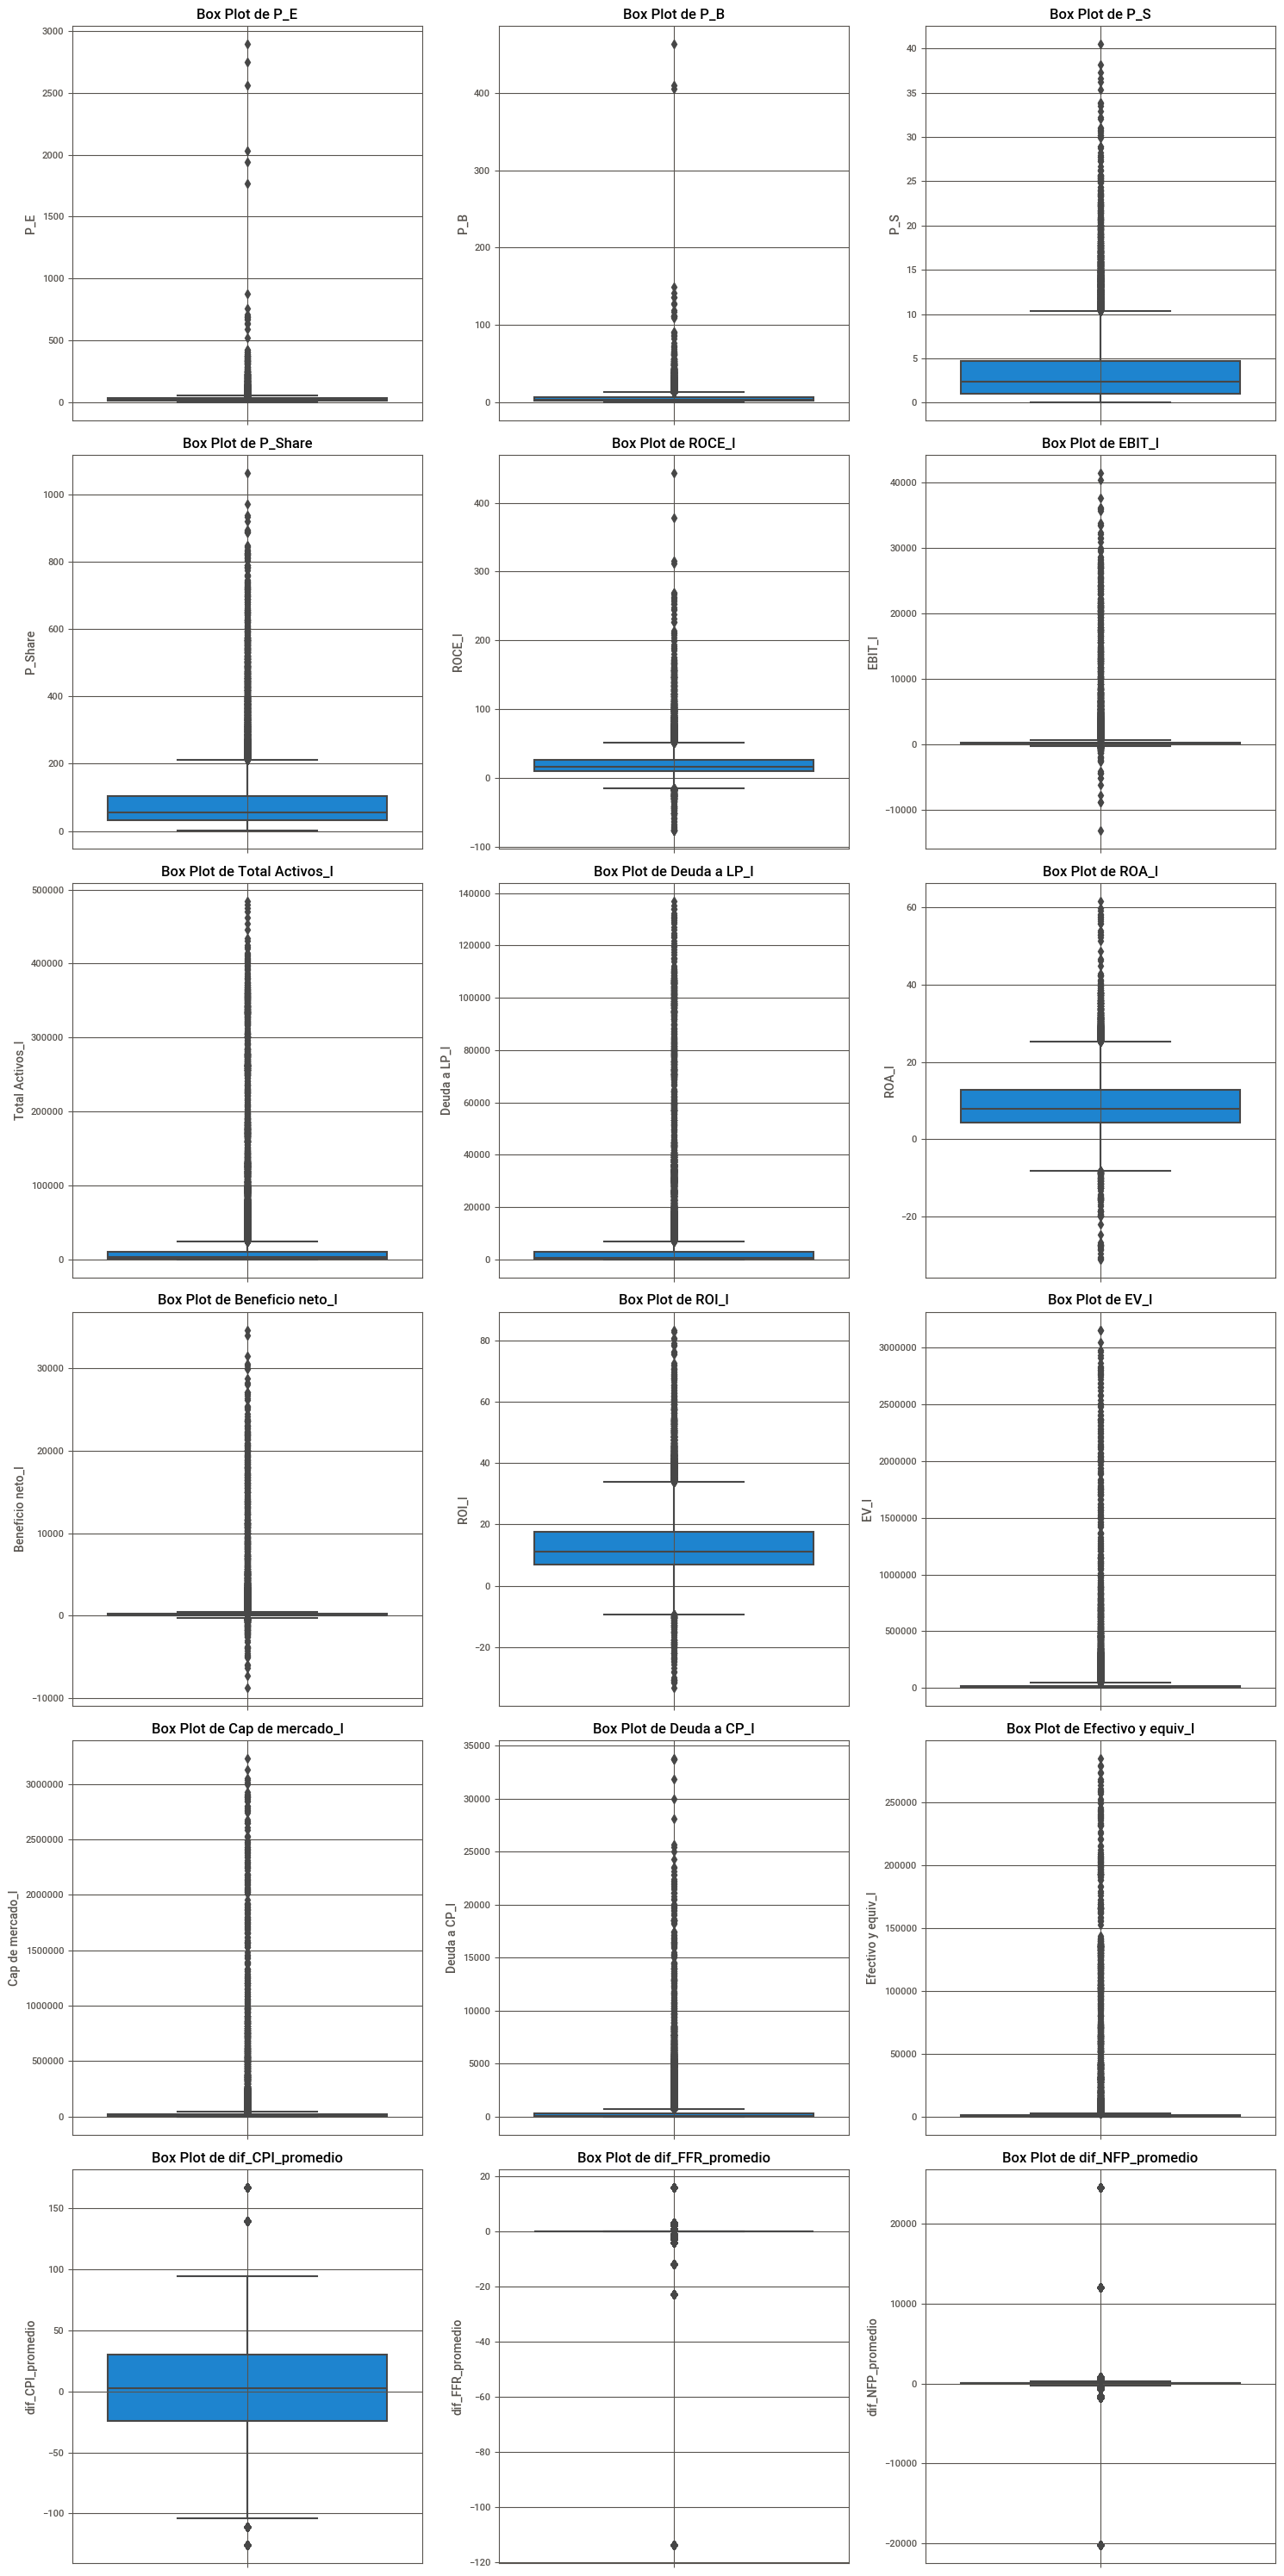


Detectando outliers con Z-score...
Outliers detectados con Z-score:
            P_E     P_B     P_S  P_Share     ROCE_l       EBIT_l  \
65      21.7693  2.1918  0.6413   13.230  11.756400   -20.653000   
66      31.5762  3.1793  0.9302   19.190  11.566000    19.421667   
67      36.4302  3.6680  1.0732   22.140  11.375600    59.496333   
68      20.6970  3.2192  0.8667   20.020  11.185200    99.571000   
78      17.1299  4.1566  1.0063   31.975  19.649067    40.226667   
...         ...     ...     ...      ...        ...          ...   
21594  228.1702  0.6940  0.2760   13.290  -5.869300   -62.333333   
21595  241.3900  0.7342  0.2920   14.060  -4.988600   -18.666667   
21596  199.4987  0.6068  0.2413   11.620  -4.107900    25.000000   
21598   20.4174  0.5966  0.2281   11.330 -46.074433  -687.666667   
21599   19.0659  0.9907  0.2017   10.380 -67.057700 -1044.000000   

       Total Activos_l  Deuda a LP_l      ROA_l  Beneficio neto_l      ROI_l  \
65          664.955000    158.4250

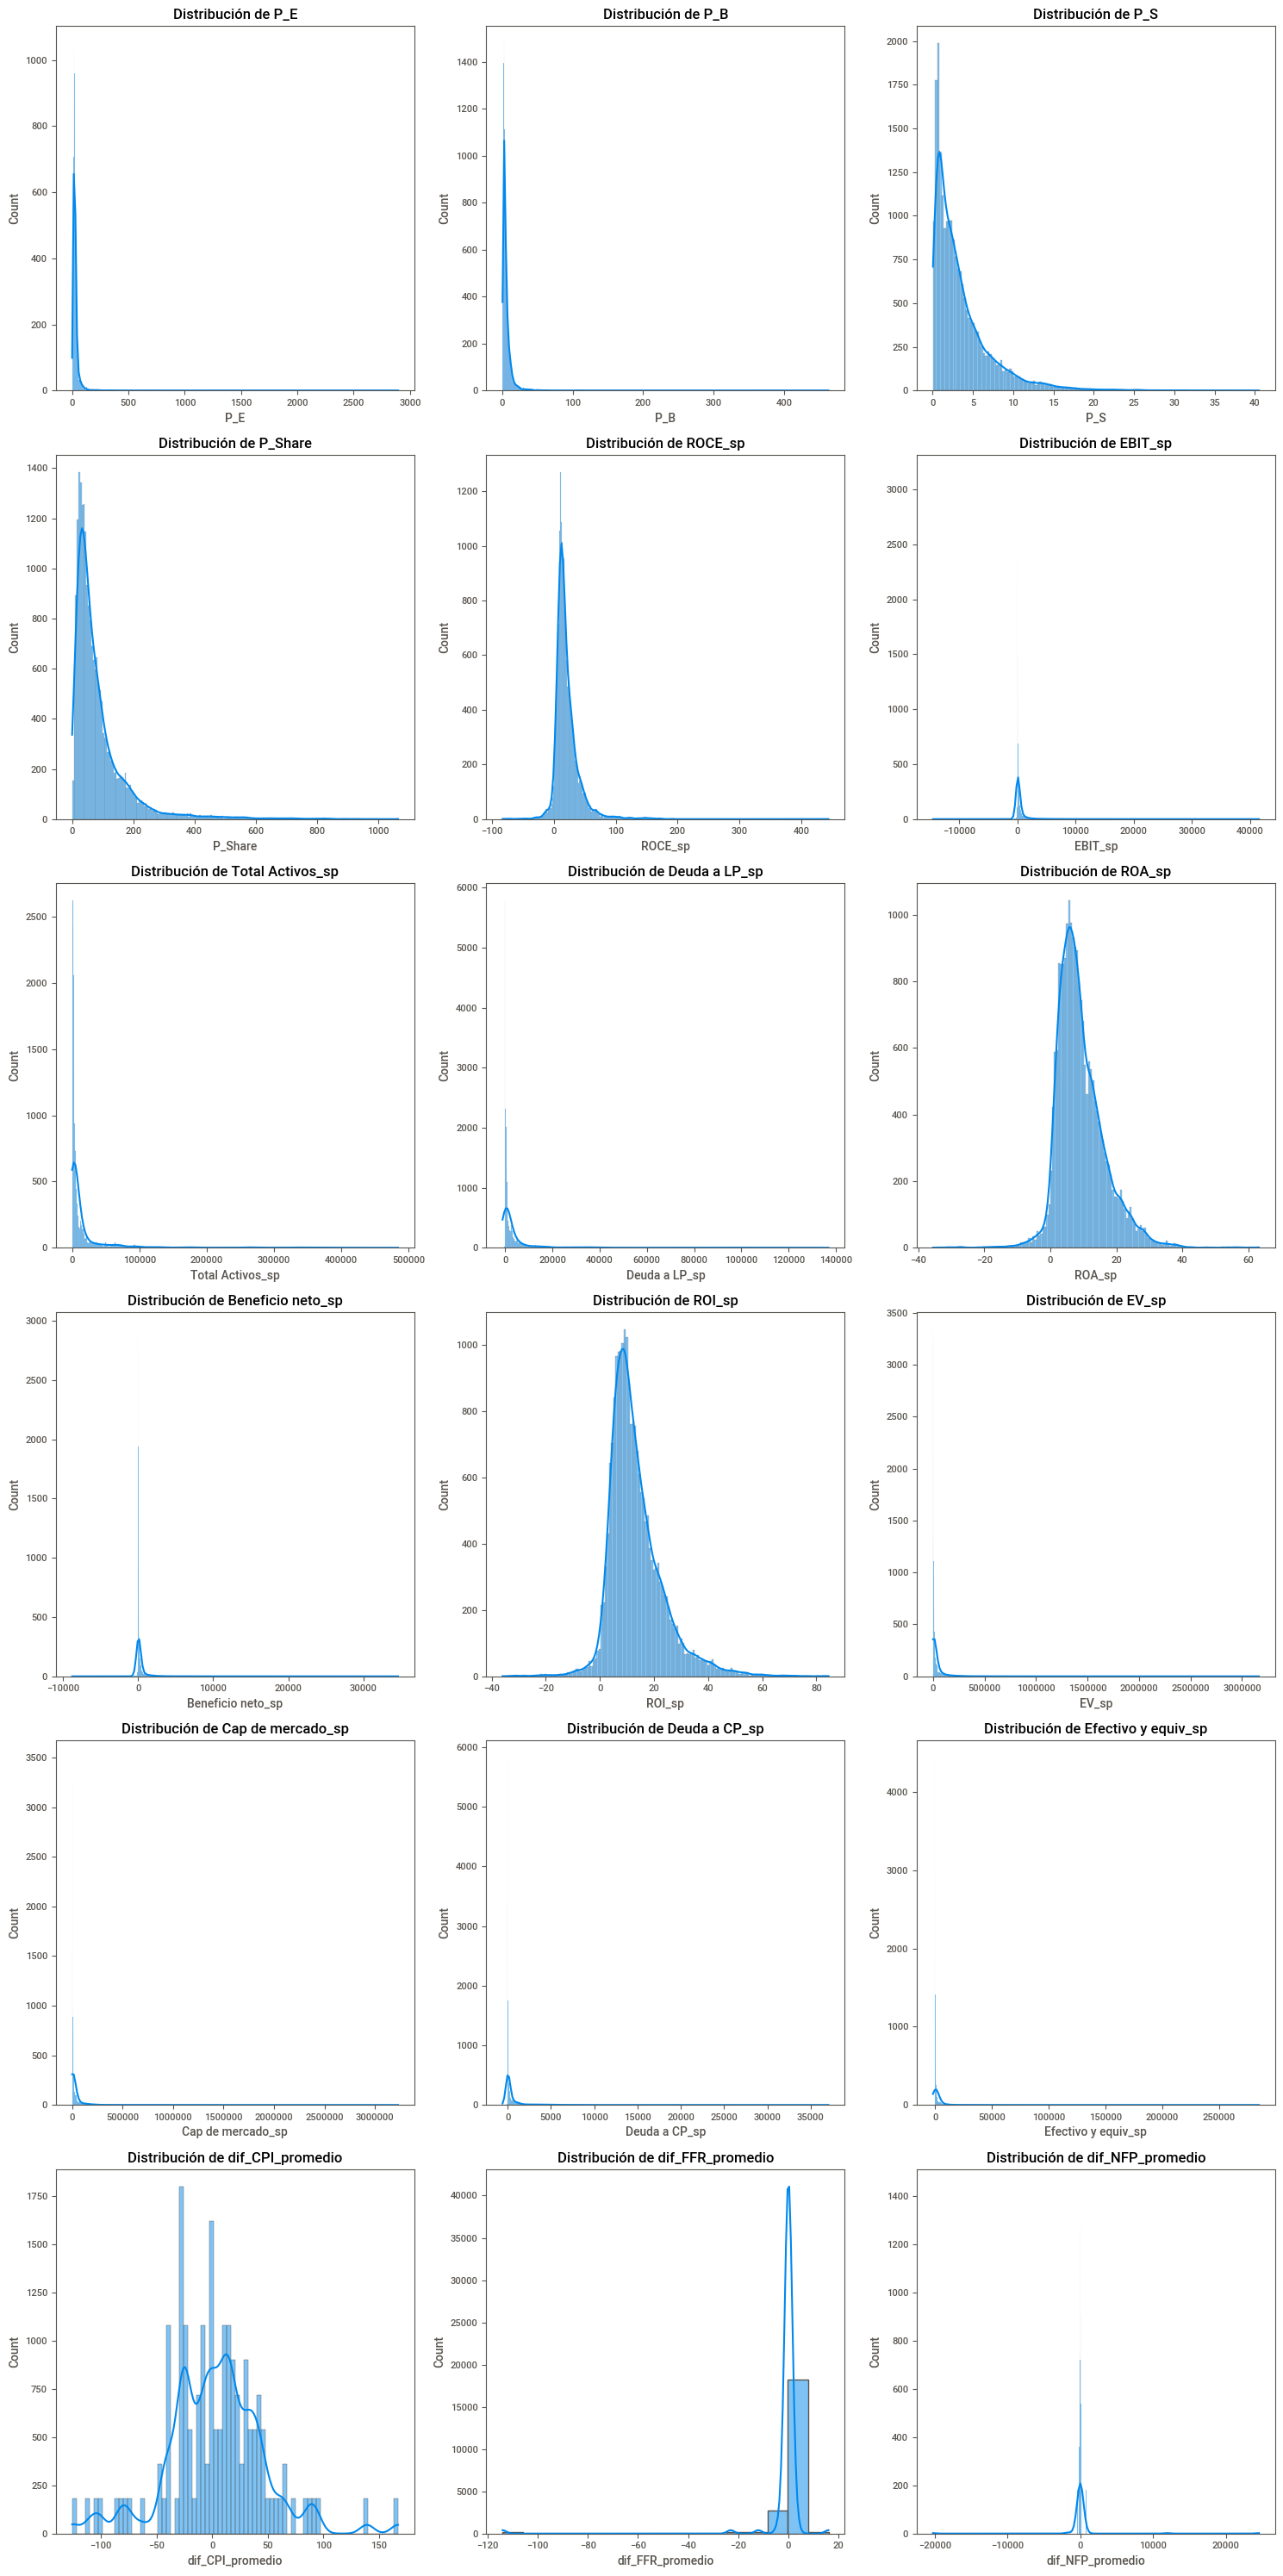


Generando matriz de correlación...


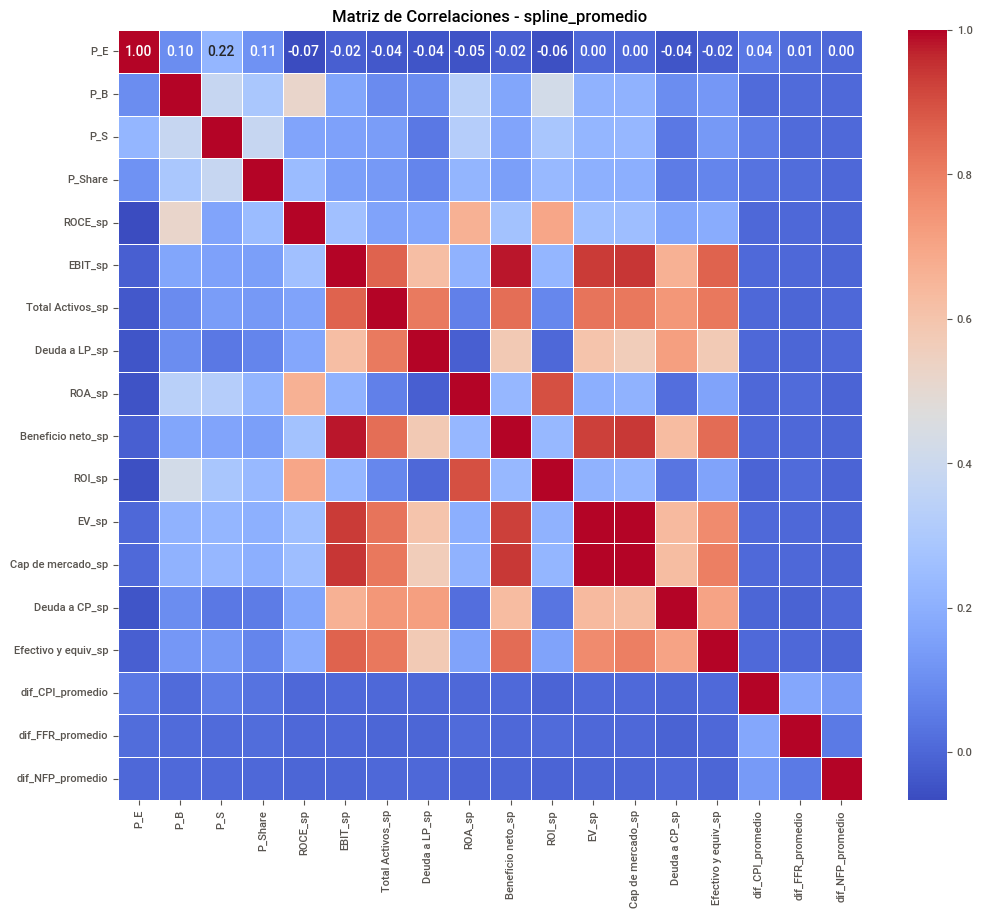


Generando boxplots...


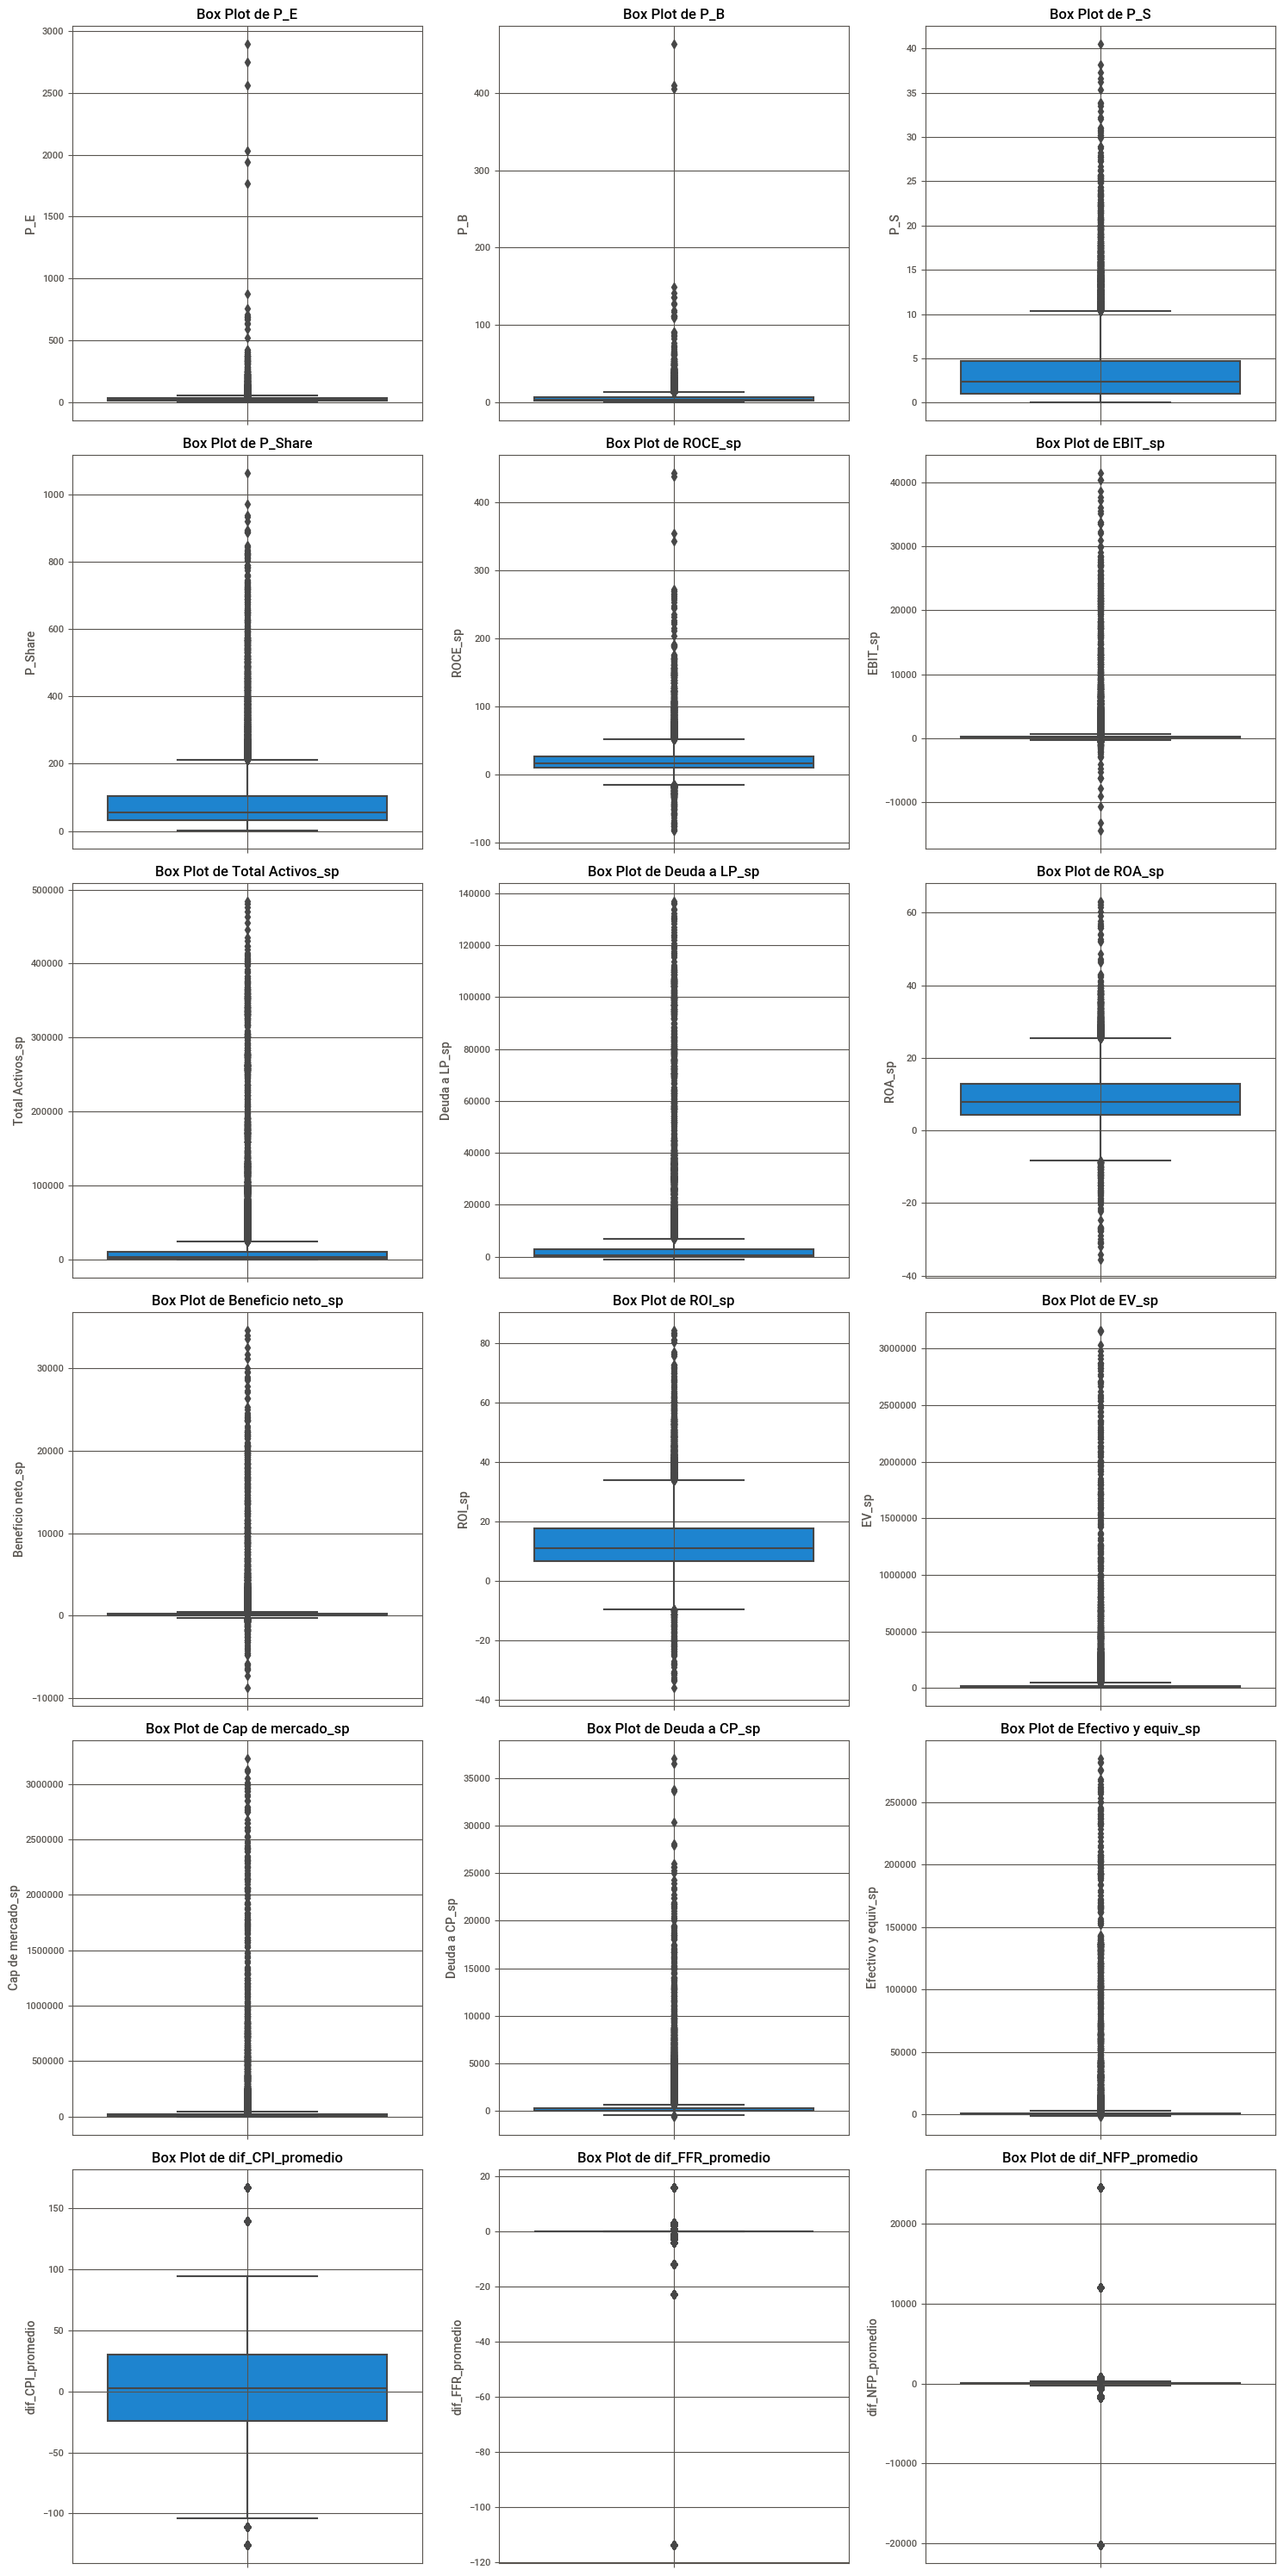


Detectando outliers con Z-score...
Outliers detectados con Z-score:
            P_E     P_B     P_S  P_Share    ROCE_sp      EBIT_sp  \
65      21.7693  2.1918  0.6413   13.230  11.756400   -20.653000   
66      31.5762  3.1793  0.9302   19.190  11.805182    22.906276   
67      36.4302  3.6680  1.0732   22.140  11.586879    74.383460   
68      20.6970  3.2192  0.8667   20.020  11.185200    99.571000   
78      17.1299  4.1566  1.0063   31.975  19.376663    42.744912   
...         ...     ...     ...      ...        ...          ...   
21559   33.1133  0.8297  0.6963   23.450   4.823566    59.728043   
21594  228.1702  0.6940  0.2760   13.290  -4.451735   -38.812071   
21595  241.3900  0.7342  0.2920   14.060  -2.396950    26.817010   
21596  199.4987  0.6068  0.2413   11.620  -4.107900    25.000000   
21599   19.0659  0.9907  0.2017   10.380 -67.057700 -1044.000000   

       Total Activos_sp  Deuda a LP_sp     ROA_sp  Beneficio neto_sp  \
65           664.955000     158.425000   6

In [229]:
# Función para calcular VIF
def calcular_vif(dataframe, nombre_lista_columnas):
    print(f"\nCalculando VIF para lista de columnas: {nombre_lista_columnas}")
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [
        variance_inflation_factor(dataframe.values, i)
        for i in range(dataframe.shape[1])
    ]
    print(vif_data)
    return vif_data

# Función de análisis extendida para incluir cálculo de VIF
def analizar_lista_columnas_con_vif(df, columnas, nombre_lista_columnas):
    print(f"\nAnalizando lista de columnas: {nombre_lista_columnas}")
    subset_df = df[columnas]
    
    # Histogramas
    print("\nGenerando histogramas...")
    num_plots = len(columnas)
    fig, axes = plt.subplots((num_plots + 2) // 3, 3, figsize=(15, 5 * ((num_plots + 2) // 3)))
    axes = axes.flatten()

    for idx, col in enumerate(columnas):
        sns.histplot(data=subset_df, x=col, kde=True, ax=axes[idx])
        axes[idx].set_title(f"Distribución de {col}")

    for idx in range(len(columnas), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Matriz de correlación
    print("\nGenerando matriz de correlación...")
    plt.figure(figsize=(12, 10))
    correlation_matrix = subset_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f'Matriz de Correlaciones - {nombre_lista_columnas}')
    plt.show()

    # Box plots
    print("\nGenerando boxplots...")
    fig, axes = plt.subplots((num_plots + 2) // 3, 3, figsize=(15, 5 * ((num_plots + 2) // 3)))
    axes = axes.flatten()

    for idx, col in enumerate(columnas):
        sns.boxplot(y=subset_df[col], ax=axes[idx])
        axes[idx].set_title(f"Box Plot de {col}")
        axes[idx].grid(True)

    for idx in range(len(columnas), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Detección de outliers con Z-score
    print("\nDetectando outliers con Z-score...")
    z_scores = np.abs(zscore(subset_df, nan_policy='omit'))
    outliers = (z_scores > 3).any(axis=1)
    df_outliers = subset_df[outliers]
    print(f"Outliers detectados con Z-score:\n{df_outliers}\n")

    # Calcular el VIF
    return calcular_vif(subset_df, nombre_lista_columnas)

# Análisis de todos los subconjuntos, incluyendo VIF
listas_columnas = {
    "lineal_mediana": columnas_numericas_lineal_mediana,
    "spline_mediana": columnas_numericas_spline_mediana,
    "lineal_promedio": columnas_numericas_lineal_promedio,
    "spline_promedio": columnas_numericas_spline_promedio
}

# Crear un diccionario para almacenar los DataFrames por lista de columnas
resultados_vif_df = {}

# Calcular el VIF para cada lista de columnas
for nombre, columnas in listas_columnas.items():
    # Analizar y calcular el VIF para el subconjunto actual
    resultados_vif_df[nombre] = analizar_lista_columnas_con_vif(df, columnas, nombre)

# Mostrar los resultados individualmente
for nombre, df_vif in resultados_vif_df.items():
    print(f"\nResultados de VIF para {nombre}:\n")
    print(df_vif)



In [230]:
resultados_vif_df

{'lineal_mediana':               Variable           VIF
 0                  P_E      1.368061
 1                  P_B      2.495526
 2                  P_S      2.994845
 3              P_Share      2.197094
 4               ROCE_l      5.113912
 5               EBIT_l     50.069310
 6      Total Activos_l     10.068188
 7         Deuda a LP_l     70.509873
 8                ROA_l     15.173222
 9     Beneficio neto_l     38.384779
 10               ROI_l     16.035917
 11                EV_l  11795.174167
 12    Cap de mercado_l  12690.489347
 13        Deuda a CP_l      4.058287
 14  Efectivo y equiv_l    143.726772
 15     dif_CPI_mediana      1.060438
 16     dif_FFR_mediana      1.038479
 17     dif_NFP_mediana      1.021006,
 'spline_mediana':                Variable           VIF
 0                   P_E      1.367988
 1                   P_B      2.477068
 2                   P_S      2.973903
 3               P_Share      2.193308
 4               ROCE_sp      5.012587
 5     

##### Los *outliers* (valores atípicos) son observaciones que se desvían significativamente de la tendencia general de los datos y pueden afectar de diferentes maneras a los modelos de *machine learning*. A continuación se explica cómo influyen en *Random Forest* y *XGBoost*, así como algunas recomendaciones para manejarlos:

---

##### ## 1. **Outliers en Random Forest**

##### ### **1.1 Robustez ante outliers**  
##### - **Enfoque basado en árboles**: Random Forest construye múltiples árboles de decisión a partir de diferentes muestras (bootstrap) de los datos y luego combina sus resultados (promedio para regresión o votación mayoritaria para clasificación).  
##### - **Menor sensibilidad a valores extremos**: Debido a que cada árbol se basa en divisiones secuenciales que buscan maximizar la “pureza” de las particiones, los valores atípicos pueden terminar aislados en nodos relativamente pequeños. El voto/ promedio final de todos los árboles tiende a suavizar el efecto que un outlier pueda tener en cada árbol individual.  
##### - **Uso de medianas o promedios parciales en la división**: Las variables se dividen a menudo usando criterios como la *impureza Gini* (en clasificación) o reducción de la varianza (en regresión). Aunque un outlier extremo pueda afectar la mejor división en un solo árbol, el efecto sobre el bosque completo suele distribuirse y mitigarse al promediar.

##### ### **1.2 Recomendaciones para manejar outliers en Random Forest**  
##### - **Verificación previa**: Realizar un análisis exploratorio para identificar valores atípicos demasiado marcados que pudieran distorsionar los árboles individuales.  
##### - **Podar valores extremadamente anómalos**: En casos críticos (por ejemplo, un sensor defectuoso que produce lecturas imposibles) puede ser razonable eliminarlos o corregirlos.  
##### - **Comprobación con diferentes semillas**: Dado que cada bosque usa muestreos aleatorios, se puede entrenar el modelo con diferentes semillas y comparar la estabilidad de los resultados.

---

##### ## 2. **Outliers en XGBoost**

##### ### **2.1 Mayor sensibilidad que Random Forest**  
##### - **Algoritmo de boosting**: XGBoost (Extreme Gradient Boosting) entrena secuencialmente un conjunto de árboles donde cada nuevo árbol intenta corregir los errores del conjunto previo.  
##### - **Gradiente descendente**: Los valores atípicos pueden tener un mayor peso a la hora de calcular gradientes, lo que afecta la forma en que se ajustan los árboles posteriores. Un outlier muy grande (o muy pequeño) puede generar un gradiente elevado, forzando al modelo a ajustarse más a esos puntos extremos.  
##### - **Regularización fuerte**: XGBoost incluye parámetros de regularización (como `lambda`, `alpha`, `gamma`) para controlar la complejidad de los árboles y así atenuar la influencia de los outliers. Aun así, si los datos están muy sesgados o contaminados, la convergencia del modelo puede verse afectada.

##### ### **2.2 Recomendaciones para manejar outliers en XGBoost**  
##### - **Transformaciones de variables**: Aplicar transformaciones (por ejemplo, logarítmica, *Box-Cox*, escalado robusto) puede ayudar a reducir la influencia de valores extremos.  
##### - **Regularización adecuada**: Ajustar correctamente los hiperparámetros de regularización (como `lambda` y `alpha` para la penalización L2 y L1, respectivamente) ayuda a que el modelo no se “sobreajuste” a outliers.  
##### - **Uso de parámetros de control de crecimiento de árboles**: Parámetros como `max_depth`, `min_child_weight` y `subsample` limitan la complejidad de cada árbol y el impacto de los puntos atípicos.  
##### - **Identificación y tratamiento de outliers**: Si se detectan outliers provocados por errores de medición o datos anómalos sin sentido para el problema, puede considerarse su eliminación o corrección antes de entrenar el modelo.  
##### - **Monitoreo de la pérdida y el gradiente**: Revisar la evolución de la función de pérdida durante el entrenamiento para detectar situaciones en las que el modelo se vea muy afectado por pocos puntos.

---

##### ## 3. **Conclusión**

##### - **Random Forest**: Gracias a su naturaleza de bagging y promedio/votación de múltiples árboles, suele ser relativamente robusto frente a outliers. Sin embargo, la presencia de valores extremadamente atípicos puede distorsionar algunas divisiones individuales de los árboles.  
##### - **XGBoost**: Al ser un método de boosting basado en gradiente, tiende a ser más sensible a valores extremos, pues estos influyen de manera directa en la corrección que cada nuevo árbol aporta. No obstante, sus métodos de regularización permiten mitigar en parte este problema.  

##### En términos prácticos, **ningún modelo está totalmente inmunizado contra los outliers**. Siempre es conveniente realizar un análisis previo de la calidad de los datos, identificar posibles valores atípicos y decidir sobre su tratamiento (transformación, eliminación o imputación). Con una buena limpieza y ajustes adecuados de hiperparámetros, tanto *Random Forest* como *XGBoost* pueden lograr un alto rendimiento incluso en presencia de valores atípicos.

##### En conclusión, no siempre es necesario eliminar outliers antes de usar modelos de árboles, ya que suelen manejar bien estos valores. No obstante, sigue siendo altamente recomendable inspeccionarlos durante el análisis exploratorio y decidir, caso por caso, si conviene transformarlos, corregirlos o conservarlos.

##### Es correcto que, en comparación con modelos lineales o aquellos sensibles a la distribución de los datos, los algoritmos basados en árboles —como Random Forest y XGBoost— son generalmente más robustos ante la presencia de outliers. Esto se debe a que estos modelos realizan particiones basadas en umbrales y no dependen tanto de medidas de tendencia central (como la media), por lo que los valores atípicos tienden a tener menos impacto en la estructura del árbol.

##### Sin embargo, es importante tener en cuenta algunos puntos:

##### 1. **Calidad de los datos:**  
#####    Aunque los modelos basados en árboles son más robustos, si los outliers provienen de errores en la captura o procesamiento de los datos, es recomendable corregirlos o eliminarlos para asegurar la integridad del dataset.

##### 2. **Interpretabilidad y análisis exploratorio:**  
#####    Durante el análisis exploratorio, identificar outliers puede ayudar a entender mejor la naturaleza de los datos. Incluso si el modelo no se ve fuertemente afectado, conocer la presencia de valores extremos puede ser útil para interpretar los resultados o detectar problemas en el proceso de recopilación de datos.

##### 3. **Impacto en métricas y performance:**  
#####    En algunos casos, la existencia de outliers puede influir en la evaluación de ciertas métricas de desempeño o en la interpretación de la importancia de variables. Por ello, aunque no elimines outliers para el modelado, es recomendable ser consciente de su presencia y, si es posible, evaluar el desempeño del modelo con y sin ellos.

##### En resumen, para métodos como Random Forest y XGBoost no es estrictamente necesario eliminar outliers, ya que estos algoritmos suelen manejarlos de manera eficiente. No obstante, siempre es buena práctica revisarlos durante el análisis exploratorio para comprender mejor tus datos y asegurarte de que no estén introduciendo sesgos o errores inesperados.


#### **En tanto, el VIF es útil para detectar colinealidad. Un valor alto de VIF (por ejemplo, superior a 5 o 10) puede indicar que la variable está altamente correlacionada con otras.**

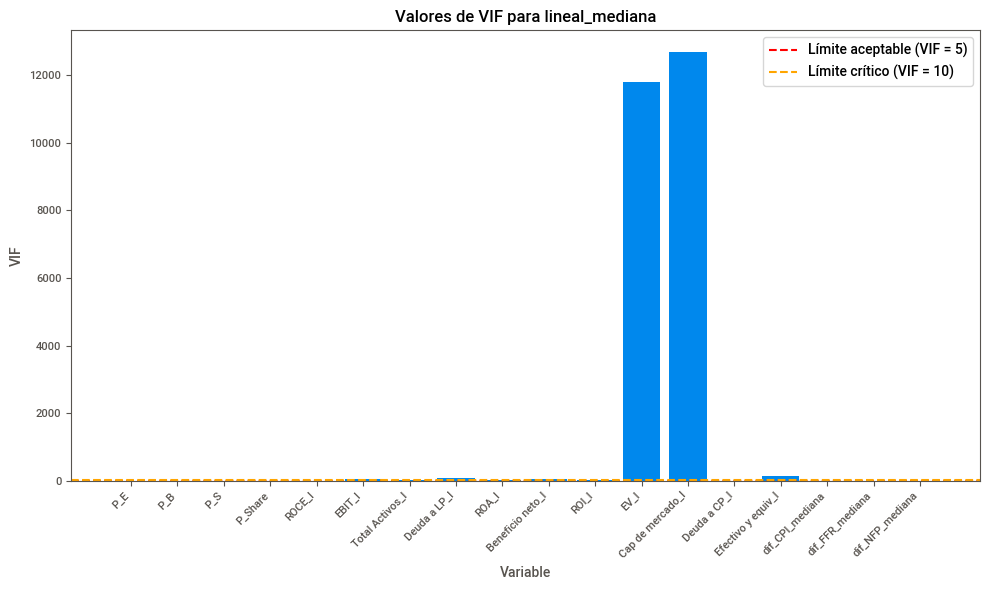

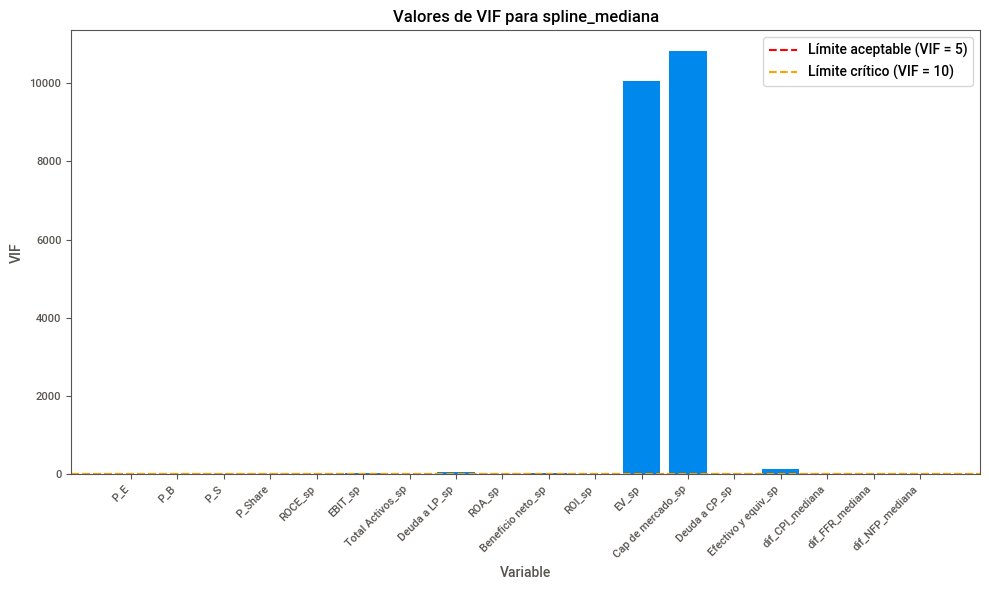

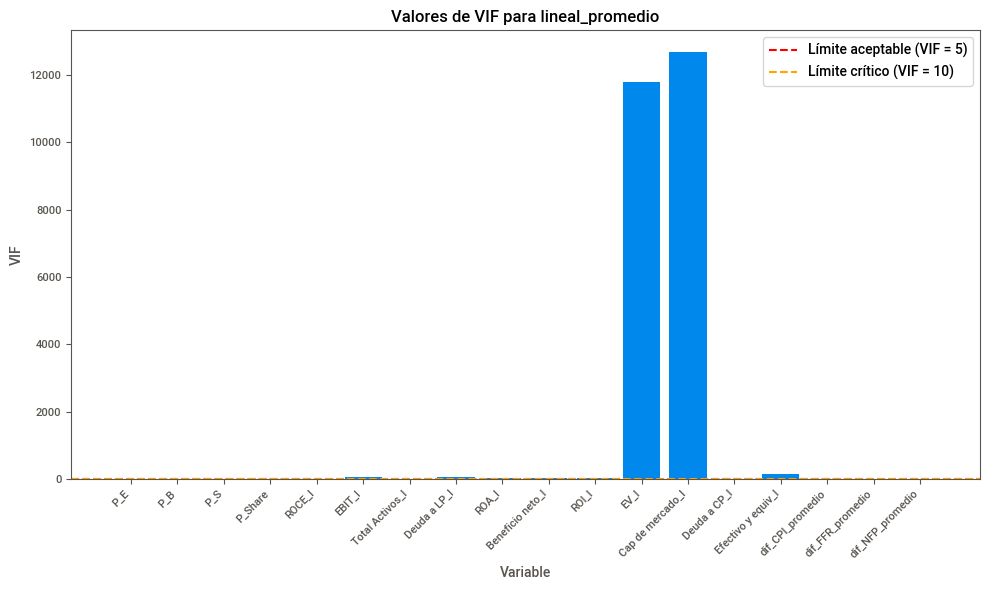

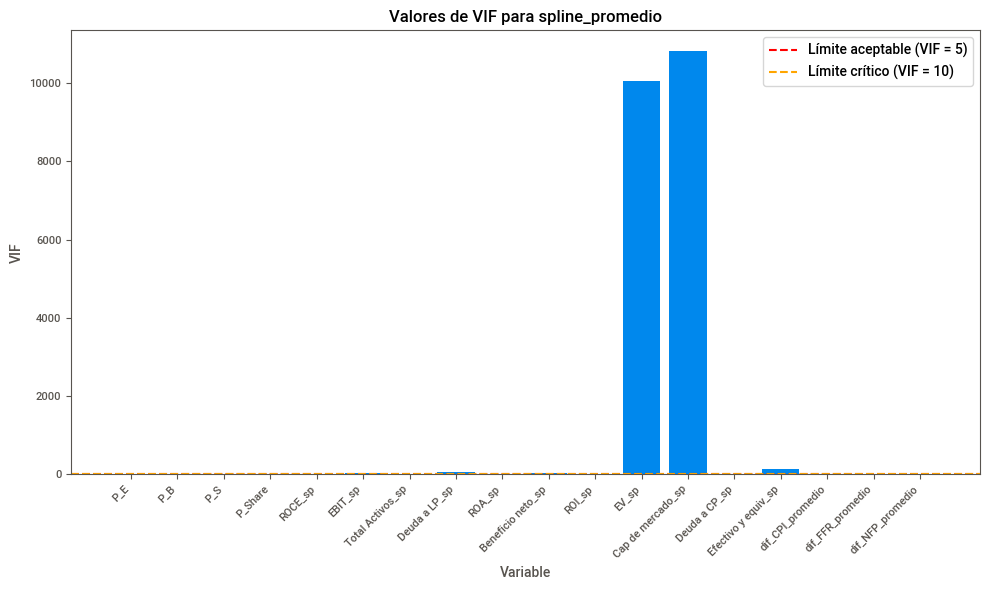

In [231]:
# Crear gráficos de barras para cada subconjunto
for nombre, df_vif in resultados_vif_df.items():
    plt.figure(figsize=(10, 6))
    plt.bar(df_vif['Variable'], df_vif['VIF'])
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Valores de VIF para {nombre}")
    plt.ylabel("VIF")
    plt.xlabel("Variable")
    plt.axhline(5, color='r', linestyle='--', label="Límite aceptable (VIF = 5)")
    plt.axhline(10, color='orange', linestyle='--', label="Límite crítico (VIF = 10)")
    plt.legend()
    plt.tight_layout()
    plt.show()


##### Cuando el objetivo es predecir el ratio P/E, lo ideal es conservar la variable que esté más directamente relacionada con el precio de la acción, ya que el P/E se calcula como Precio sobre Beneficios. En este sentido:

##### - **Cap de mercado_l** representa la capitalización bursátil, que es el resultado del precio por acción multiplicado por el número de acciones. Esto la hace más directamente vinculada al precio del activo.

##### - **EV_l** (Enterprise Value) integra, además de la capitalización bursátil, la deuda y el efectivo, proporcionando una visión más amplia del valor de la empresa, pero que incluye elementos (como la estructura de financiamiento) que pueden no estar tan directamente relacionados con el ratio P/E.

##### Por ello, si el modelo tiene como variable objetivo el ratio P/E, **resulta más coherente mantener la variable "Cap de mercado_l"** y eliminar "EV_l". De esta forma, se reduce la redundancia y se favorece la inclusión de información más directamente vinculada al precio que es clave para el P/E.

##### No obstante, siempre es recomendable realizar pruebas empíricas:
##### - Entrena el modelo con cada conjunto de variables y compara el desempeño.
##### - Analiza la importancia de las variables en el modelo para confirmar que "Cap de mercado_l" aporta información relevante para la predicción del P/E.

##### Esta estrategia te permitirá tener un enfoque más sólido, basado tanto en criterios teóricos como en resultados empíricos.

##### Cuando observas que tanto **Beneficio neto** como **EBIT** presentan valores de VIF superiores a 40, es una clara señal de que ambas variables están altamente correlacionadas, lo que indica redundancia en la información que aportan al modelo. Esto puede afectar la estabilidad de los coeficientes en modelos lineales y, en general, se recomienda reducir la multicolinealidad para obtener interpretaciones más fiables.

##### Dado que tu variable objetivo es el **ratio P/E**, es importante considerar lo siguiente:

##### - **Beneficio neto:** Generalmente es el denominador del ratio P/E (es decir, Precio / Beneficio neto) y está directamente relacionado con la utilidad neta que reporta la empresa.  
##### - **EBIT:** Representa las ganancias antes de intereses e impuestos. Aunque es una medida importante de la rentabilidad operativa, no es la misma que el beneficio neto y, en el contexto del P/E, puede aportar información redundante.

##### **Recomendación:**  
##### Dado que el ratio P/E se calcula utilizando el beneficio neto, tiene sentido conservar la variable **Beneficio neto** y eliminar **EBIT**. Esto ayudará a reducir la multicolinealidad sin perder información directamente relevante para el modelo.

##### **Pasos a seguir:**

##### 1. **Verificar la correlación:**  
#####    Puedes revisar la matriz de correlación entre ambas variables para confirmar que están fuertemente correlacionadas (por ejemplo, valores de correlación cercanos a 1 o -1).

##### 2. **Eliminar la variable redundante:**  
#####    Si decides eliminar **EBIT**, ajusta el subconjunto de datos para que ya no incluya esta variable antes de recalcular el VIF.

##### 3. **Recalcular el VIF:**  
#####    Con el subconjunto actualizado (sin EBIT), vuelve a calcular el VIF para confirmar que la multicolinealidad se ha reducido a niveles aceptables.

##### Si prefieres mantener ambas variables por alguna razón particular, podrías también considerar técnicas de regularización (como Ridge o Lasso) en lugar de eliminarlas, ya que estos métodos son menos sensibles a la multicolinealidad. Sin embargo, para un análisis más interpretativo y coherente con el cálculo del P/E, la eliminación de EBIT es la opción más directa.

##### En resumen, **conserva Beneficio neto y elimina EBIT** para reducir la multicolinealidad en tu modelo cuando el objetivo es predecir el ratio P/E.

In [232]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Función para calcular VIF (permanece sin cambios)
def calcular_vif(dataframe, nombre_lista_columnas):
    print(f"\nCalculando VIF para lista de columnas: {nombre_lista_columnas}")
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [
        variance_inflation_factor(dataframe.values, i)
        for i in range(dataframe.shape[1])
    ]
    print(vif_data)
    return vif_data



# Crear un diccionario para almacenar los resultados de VIF para cada conjunto de columnas
resultados_vif_df = {}

# Variables que queremos eliminar (si existen)
variables_a_eliminar = ['EV_l', 'EV_sp', 'EBIT_l', 'EBIT_sp']

# Iterar sobre cada conjunto de columnas
for nombre, columnas in listas_columnas.items():
    print(f"\nProcesando el conjunto de columnas: {nombre}")
    
    # Crear el subconjunto del DataFrame usando las columnas especificadas
    subset_df = df[columnas].copy()
    
    # Verificar y eliminar las variables que estén en la lista de variables_a_eliminar
    cols_drop = [var for var in variables_a_eliminar if var in subset_df.columns]
    if cols_drop:
        print(f"Eliminando las variables {cols_drop} del subconjunto.")
        subset_df = subset_df.drop(columns=cols_drop)
    
    # Calcular y almacenar el VIF para el subconjunto actual
    resultados_vif_df[nombre] = calcular_vif(subset_df, nombre)

# Mostrar los resultados de VIF para cada conjunto de columnas
for nombre, vif_df in resultados_vif_df.items():
    print(f"\nResultados de VIF para {nombre}:\n")
    print(vif_df)



Procesando el conjunto de columnas: lineal_mediana
Eliminando las variables ['EV_l', 'EBIT_l'] del subconjunto.

Calculando VIF para lista de columnas: lineal_mediana
              Variable        VIF
0                  P_E   1.368046
1                  P_B   2.495247
2                  P_S   2.965171
3              P_Share   2.197053
4               ROCE_l   5.101484
5      Total Activos_l   9.763986
6         Deuda a LP_l   4.543229
7                ROA_l  15.115896
8     Beneficio neto_l  14.408647
9                ROI_l  15.838187
10    Cap de mercado_l  10.893288
11        Deuda a CP_l   3.197576
12  Efectivo y equiv_l   4.940229
13     dif_CPI_mediana   1.060272
14     dif_FFR_mediana   1.038350
15     dif_NFP_mediana   1.020979

Procesando el conjunto de columnas: spline_mediana
Eliminando las variables ['EV_sp', 'EBIT_sp'] del subconjunto.

Calculando VIF para lista de columnas: spline_mediana
               Variable        VIF
0                   P_E   1.367976
1             

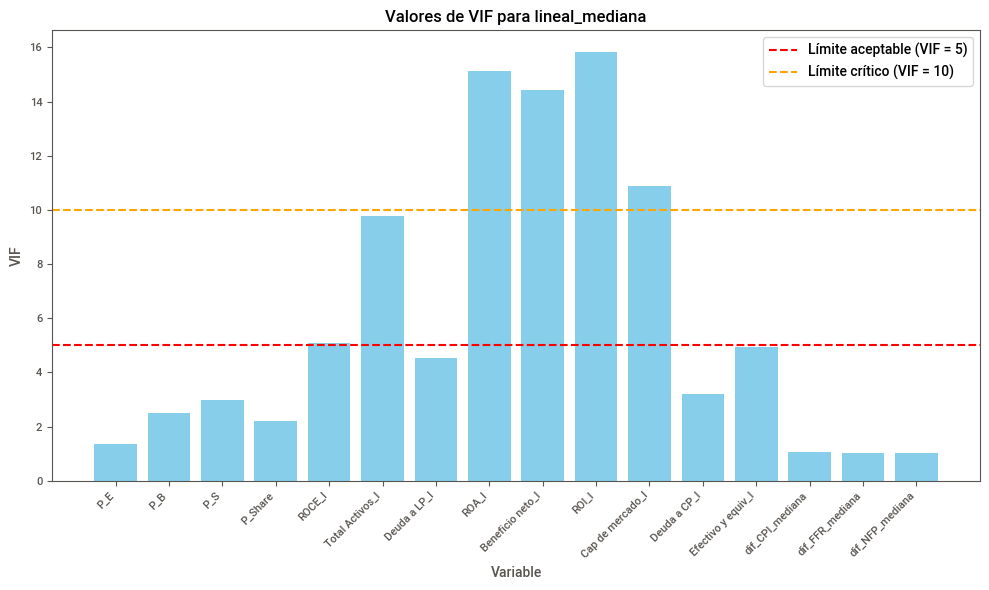

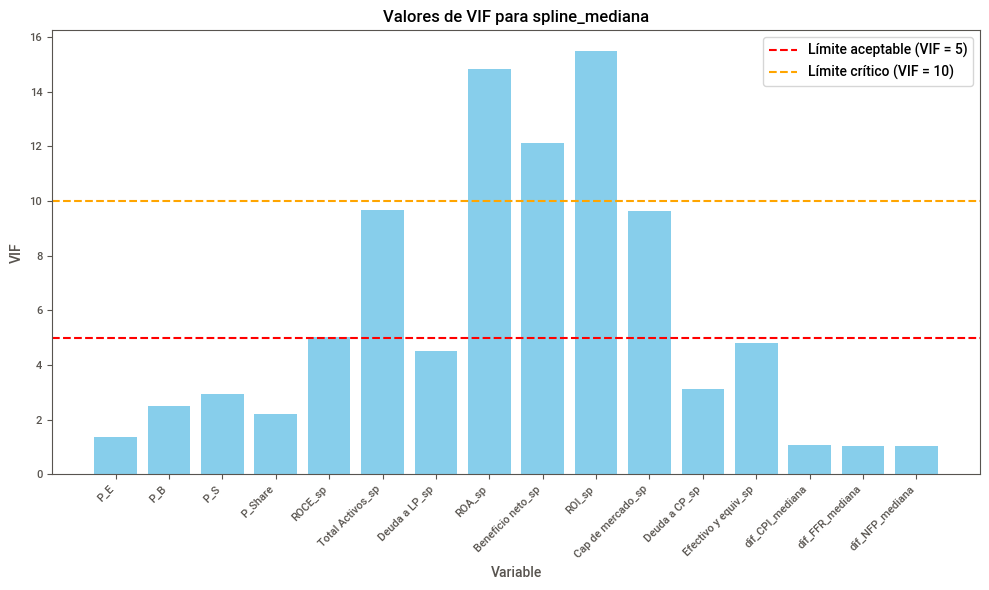

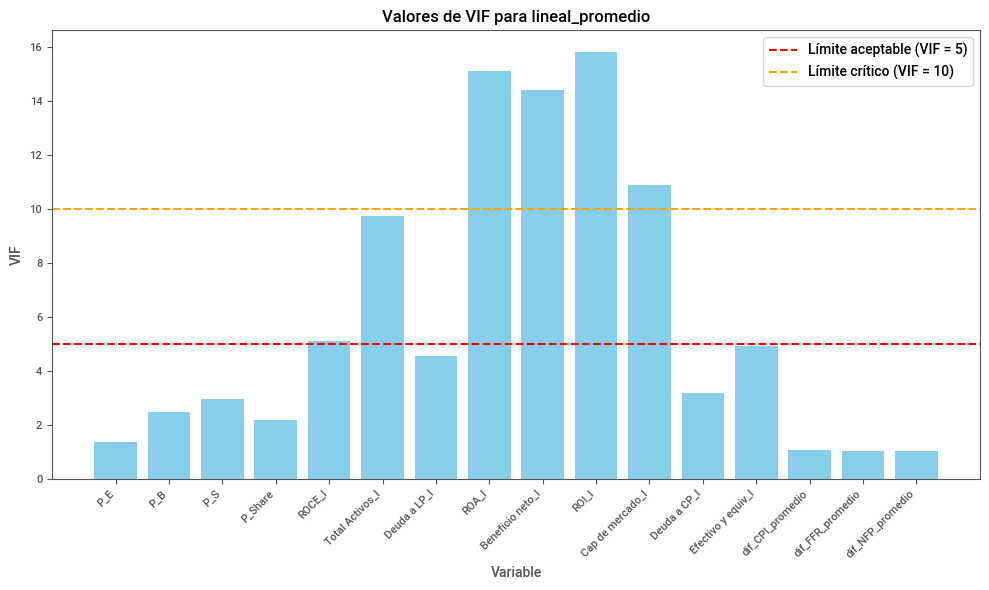

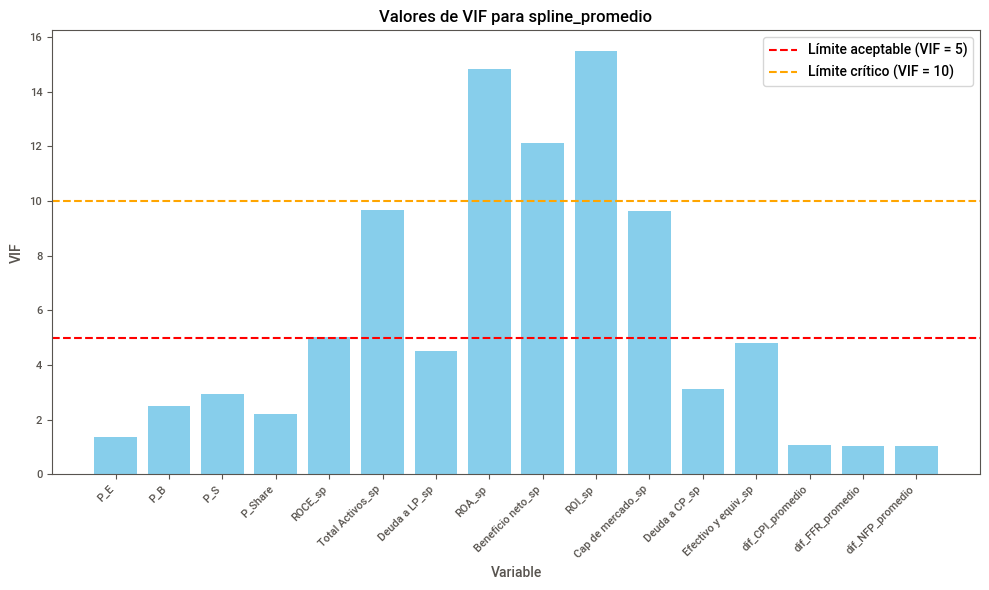

In [233]:
for nombre, df_vif in resultados_vif_df.items():
    plt.figure(figsize=(10, 6))
    plt.bar(df_vif['Variable'], df_vif['VIF'], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Valores de VIF para {nombre}")
    plt.ylabel("VIF")
    plt.xlabel("Variable")
    plt.axhline(5, color='r', linestyle='--', label="Límite aceptable (VIF = 5)")
    plt.axhline(10, color='orange', linestyle='--', label="Límite crítico (VIF = 10)")
    plt.legend()
    plt.tight_layout()
    plt.show()

##### Un VIF de 16 sigue siendo elevado y sugiere una notable multicolinealidad para esa variable. En general, se recomienda:

##### - **Modelos lineales:**  
#####   Un VIF mayor a 10 suele considerarse problemático porque la varianza de los coeficientes se infla considerablemente, lo que puede afectar la estabilidad y la interpretación del modelo. Si estás usando un modelo de regresión lineal, sería prudente investigar más a fondo esa variable. Podrías:
  
#####   - Revisar la matriz de correlación para identificar con qué otras variables está fuertemente correlacionada.
#####   - Evaluar la posibilidad de eliminar o transformar la variable o las variables relacionadas, si su contribución no es esencial para la predicción.
#####   - Considerar técnicas de regularización (como Ridge o Lasso) que pueden ayudar a mitigar el efecto de la colinealidad.

##### - **Modelos basados en árboles (como Random Forest o XGBoost):**  
#####   Estos modelos son mucho menos sensibles a la multicolinealidad, por lo que un VIF de 16 puede no tener un impacto tan negativo en el desempeño predictivo, aunque sí puede complicar la interpretación de la importancia relativa de las variables.

##### **Recomendación práctica:**  
##### Si la interpretación de los coeficientes es importante para tu análisis o si estás usando modelos lineales, investiga si es posible reducir la multicolinealidad de esa variable. Por otro lado, si tu objetivo es únicamente la predicción y utilizas métodos robustos frente a la colinealidad, podrías mantenerla, pero siempre es útil documentar esta situación.

##### En resumen, aunque 16 es una mejora respecto a valores superiores a 40, sigue indicando colinealidad considerable. La decisión dependerá de la naturaleza del modelo que utilices y de la importancia que le des a la interpretabilidad frente a la capacidad predictiva.

Variables rezagadas

In [234]:
# Crear un DataFrame para las variables rezagadas y las columnas clave
df_shifted = df[['Empresa', 'Fecha', 'P_E']].copy()  # Conservar columnas clave

# Aplicar shift(1) solo dentro de cada empresa
listas_columnas = [
    columnas_numericas_lineal_mediana,
    columnas_numericas_spline_mediana,
    columnas_numericas_lineal_promedio,
    columnas_numericas_spline_promedio
]

for columnas in listas_columnas:
    for col in columnas:
        if col != 'P_E' and col in df.columns:  # Evitar 'P_E' y verificar existencia
            df_shifted[col + '_lag1'] = df.groupby('Empresa')[col].shift(1)

In [235]:
# Crear DataFrame df_shifted con las columnas clave y las columnas de lag (rezagadas)
df_shifted = df[['Empresa', 'Fecha', 'P_E']].copy()

# Aplicar shift(1) solo dentro de cada empresa
listas_columnas = [
    columnas_numericas_lineal_mediana,
    columnas_numericas_spline_mediana,
    columnas_numericas_lineal_promedio,
    columnas_numericas_spline_promedio
]


for columnas in listas_columnas:
    for col in columnas:
        if col != 'P_E' and col in df.columns:  # Evitar 'P_E' y verificar existencia
            df_shifted[col + '_lag1'] = df.groupby('Empresa')[col].shift(1)

# Definir la lista de columnas de lag (predictors)
predictors = [col for col in df_shifted.columns if col.endswith('_lag1')]

# Imputación de valores faltantes en los lag features.
# Como mencionas, sólo aparecen NaN en la primera fila de cada empresa.
# Se muestran tres alternativas de imputación:

# 1. Imputación con backfill (rellenar con el valor de la fila siguiente)
df_shifted[predictors] = df_shifted.groupby('Empresa')[predictors].transform(lambda grp: grp.fillna(method='bfill'))

# 2. Interpolación lineal (descomentar para usar)
# df_shifted[predictors] = df_shifted.groupby('Empresa')[predictors].transform(
#     lambda grp: grp.interpolate(method='linear', limit_direction='forward')
# )

# 3. Rellenar con el promedio del grupo (descomentar para usar)
# df_shifted[predictors] = df_shifted.groupby('Empresa')[predictors].transform(lambda grp: grp.fillna(grp.mean()))

# Verificar los resultados para una empresa en particular, por ejemplo "FLWS US Equity"
df_empresa_ = df_shifted[df_shifted['Empresa'] == "FLWS US Equity"].copy()
print(df_empresa_.head())


          Empresa      Fecha      P_E  P_B_lag1  P_S_lag1  P_Share_lag1  \
0  FLWS US Equity 2014-10-31  35.4266    2.8638    0.6770          8.03   
1  FLWS US Equity 2014-11-28  37.7207    2.8638    0.6770          8.03   
2  FLWS US Equity 2014-12-31  11.3711    3.0493    0.7208          8.55   
3  FLWS US Equity 2015-01-30  10.8881    2.3843    0.5153          8.24   
4  FLWS US Equity 2015-02-27  17.2222    2.2830    0.4934          7.89   

   ROCE_l_lag1  EBIT_l_lag1  Total Activos_l_lag1  Deuda a LP_l_lag1  ...  \
0     6.831567    -0.264000            263.179667                0.0  ...   
1     6.831567    -0.264000            263.179667                0.0  ...   
2     7.776733     2.352000            265.374333                0.0  ...   
3     8.721900     4.968000            267.569000                0.0  ...   
4     8.876467     1.102667            283.194667                0.0  ...   

   ROA_sp_lag1  Beneficio neto_sp_lag1  ROI_sp_lag1  EV_sp_lag1  \
0     5.792834     

In [236]:
df_shifted

Empresa      Fecha       P_E  P_B_lag1  P_S_lag1  P_Share_lag1  \
0      FLWS US Equity 2014-10-31   35.4266    2.8638    0.6770         8.030   
1      FLWS US Equity 2014-11-28   37.7207    2.8638    0.6770         8.030   
2      FLWS US Equity 2014-12-31   11.3711    3.0493    0.7208         8.550   
3      FLWS US Equity 2015-01-30   10.8881    2.3843    0.5153         8.240   
4      FLWS US Equity 2015-02-27   17.2222    2.2830    0.4934         7.890   
...               ...        ...       ...       ...       ...           ...   
21595   XRX US Equity 2024-05-31  241.3900    0.6940    0.2760        13.290   
21596   XRX US Equity 2024-06-28  199.4987    0.7342    0.2920        14.060   
21597   XRX US Equity 2024-07-31   19.3993    0.6068    0.2413        11.620   
21598   XRX US Equity 2024-08-30   20.4174    0.5668    0.2167        10.765   
21599   XRX US Equity 2024-09-30   19.0659    0.5966    0.2281        11.330   

       ROCE_l_lag1  EBIT_l_lag1  Total Activos_l_lag1  Deuda a LP_l_lag1  ...  \
0         6.831567    -0.264000            263.179667           0.000000  ...   
1         6.831567    -0.264000            263.179667           0.000000  ...   
2         7.776733     2.352000            265.374333           0.000000  ...   
3         8.721900     4.968000            267.569000           0.000000  ...   
4         8.876467     1.102667            283.194667           0.000000  ...   
...            ...          ...                   ...                ...  ...   
21595    -5.869300   -62.333333           9793.000000        3334.000000  ...   
21596    -4.988600   -18.666667           9642.000000        3324.000000  ...   
21597    -4.107900    25.000000           9491.000000        3314.000000  ...   
21598   -25.091167  -331.333333           9101.333333        3126.666667  ...   
21599   -46.074433  -687.666667           8711.666667        2939.333333  ...   

       ROA_sp_lag1  Beneficio neto_sp_lag1  ROI_sp_lag1   EV_sp_lag1  \
0         5.792834               11.540920     9.367113   312.196278   
1         5.792834               11.540920     9.367113   312.196278   
2         6.302227               11.158513     9.585330   322.274909   
3         5.938900                3.408000     8.358500   365.875600   
4         5.253173               -5.730402     6.716770   425.360758   
...            ...                     ...          ...          ...   
21595    -1.243496              -40.000238     0.528858  5347.751206   
21596    -0.746530               27.888699     1.409855  5024.283922   
21597    -1.036900               18.000000     1.024900  4669.586800   
21598    -2.898703             -142.333143    -1.846200  4368.736989   
21599    -7.116038             -525.777540    -8.423636  4206.811639   

       Cap de mercado_sp_lag1  Deuda a CP_sp_lag1  Efectivo y equiv_sp_lag1  \
0                  334.738193          -23.851054                 18.241304   
1                  334.738193          -23.851054                 18.241304   
2                  343.045777          -20.400177                 16.565532   
3                  367.856600            0.343000                  5.203000   
4                  400.955412           27.974844                 -6.929976   
...                       ...                 ...                       ...   
21595             1999.205021          349.027768                652.211940   
21596             1716.567093          243.244436                573.525108   
21597             1428.167700          168.000000                485.000000   
21598             1210.070930          162.644453                422.697114   
21599             1138.340868          266.527788                422.676948   

       dif_CPI_promedio_lag1  dif_FFR_promedio_lag1  dif_NFP_promedio_lag1  
0                        8.0                    0.0                  23.78  
1                        8.0                    0.0                  23.78  
2                      -27.0       

In [237]:
df_empresa_= df_shifted[df_shifted['Empresa'] == "FLWS US Equity"].copy()

In [238]:
df_empresa_

Empresa      Fecha      P_E  P_B_lag1  P_S_lag1  P_Share_lag1  \
0    FLWS US Equity 2014-10-31  35.4266    2.8638    0.6770          8.03   
1    FLWS US Equity 2014-11-28  37.7207    2.8638    0.6770          8.03   
2    FLWS US Equity 2014-12-31  11.3711    3.0493    0.7208          8.55   
3    FLWS US Equity 2015-01-30  10.8881    2.3843    0.5153          8.24   
4    FLWS US Equity 2015-02-27  17.2222    2.2830    0.4934          7.89   
..              ...        ...      ...       ...       ...           ...   
115  FLWS US Equity 2024-05-31  59.1271    1.2023    0.3141          9.07   
116  FLWS US Equity 2024-06-28  58.1498    1.2832    0.3353          9.68   
117  FLWS US Equity 2024-07-31  59.3849    1.2620    0.3297          9.52   
118  FLWS US Equity 2024-08-30  46.0291    1.4266    0.3656         10.36   
119  FLWS US Equity 2024-09-30  63.7178    1.1057    0.2834          8.03   

     ROCE_l_lag1  EBIT_l_lag1  Total Activos_l_lag1  Deuda a LP_l_lag1  ...  \
0       6.831567    -0.264000            263.179667              0.000  ...   
1       6.831567    -0.264000            263.179667              0.000  ...   
2       7.776733     2.352000            265.374333              0.000  ...   
3       8.721900     4.968000            267.569000              0.000  ...   
4       8.876467     1.102667            283.194667              0.000  ...   
..           ...          ...                   ...                ...  ...   
115    -9.999700     5.365333           1098.135333            295.729  ...   
116   -10.815800    48.307667           1144.922667            294.109  ...   
117   -11.631900    91.250000           1191.710000            292.489  ...   
118    -8.285633    51.523667           1141.134000            290.776  ...   
119    -4.939367    11.797333           1090.558000            289.063  ...   

     ROA_sp_lag1  Beneficio neto_sp_lag1  ROI_sp_lag1  EV_sp_lag1  \
0       5.792834               11.540920     9.367113  312.196278   
1       5.792834               11.540920     9.367113  312.196278   
2       6.302227               11.158513     9.585330  322.274909   
3       5.938900                3.408000     8.358500  365.875600   
4       5.253173               -5.730402     6.716770  425.360758   
..           ...                     ...          ...         ...   
115    -4.231368               -7.899210    -4.729480  796.327681   
116    -4.823367               28.957588    -5.809298  752.958029   
117    -5.137600               62.907000    -6.508200  703.617400   
118    -4.809066               77.527635    -6.257636  678.868249   
119    -3.472766               56.398099    -4.489053  709.273030   

     Cap de mercado_sp_lag1  Deuda a CP_sp_lag1  Efectivo y equiv_sp_lag1  \
0                334.738193          -23.851054                 18.241304   
1                334.738193          -23.851054                 18.241304   
2                343.045777          -20.400177                 16.565532   
3                367.856600            0.343000                  5.203000   
4                400.955412           27.974844                 -6.929976   
..                      ...                 ...                       ...   
115              521.451324           56.346868                 74.495416   
116              611.771122           42.357717                192.321533   
117              699.602800           25.433000                312.017000   
118              759.979867           12.393172                383.745467   
119              767.935831           10.058688                357.670584   

     dif_CPI_promedio_lag1  dif_FFR_promedio_lag1  dif_NFP_promedio_lag1  
0                      8.0                    0.0                  23.78  
1                      8.0                    0.0                  23.78  
2                    -27.0                    0.0                  47.38  
3                    -62.0                    0.0                  48.84  
4        

### Configuraciones de interpolación de datos


Procesando método: lineal_mediana
Primeras filas del DataFrame:
          Empresa      P_E  P_B_lag1  P_S_lag1  P_Share_lag1  ROCE_l_lag1  \
0  FLWS US Equity  35.4266    2.8638    0.6770          8.03     6.831567   
1  FLWS US Equity  37.7207    2.8638    0.6770          8.03     6.831567   
2  FLWS US Equity  11.3711    3.0493    0.7208          8.55     7.776733   
3  FLWS US Equity  10.8881    2.3843    0.5153          8.24     8.721900   
4  FLWS US Equity  17.2222    2.2830    0.4934          7.89     8.876467   

   EBIT_l_lag1  Total Activos_l_lag1  Deuda a LP_l_lag1  ROA_l_lag1  \
0    -0.264000            263.179667                0.0    4.553233   
1    -0.264000            263.179667                0.0    4.553233   
2     2.352000            265.374333                0.0    5.246067   
3     4.968000            267.569000                0.0    5.938900   
4     1.102667            283.194667                0.0    5.664533   

   Beneficio neto_l_lag1  ROI_l_lag1   EV_l_l

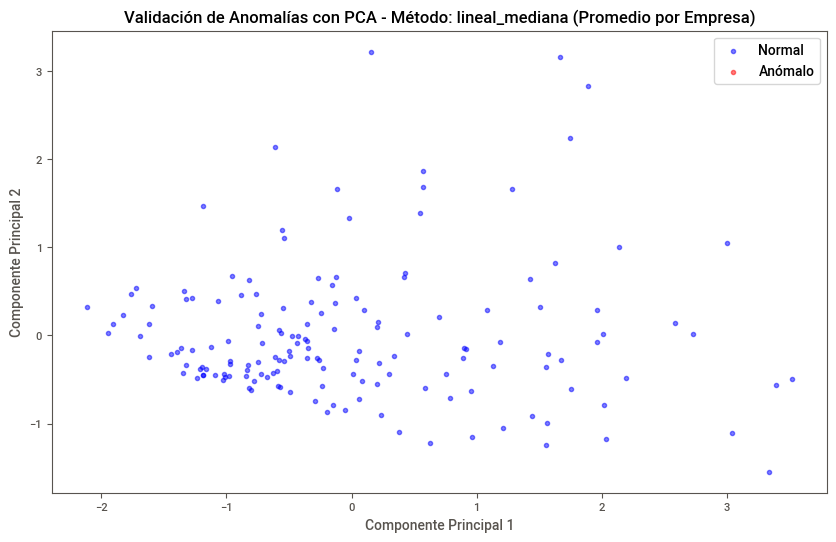


df_shifted actualizado para 'lineal_mediana' y listo para pasos posteriores.



Procesando método: spline_mediana
Primeras filas del DataFrame:
          Empresa      P_E  P_B_lag1  P_S_lag1  P_Share_lag1  ROCE_sp_lag1  \
0  FLWS US Equity  35.4266    2.8638    0.6770          8.03      8.881198   
1  FLWS US Equity  37.7207    2.8638    0.6770          8.03      8.881198   
2  FLWS US Equity  11.3711    3.0493    0.7208          8.55      9.469145   
3  FLWS US Equity  10.8881    2.3843    0.5153          8.24      8.721900   
4  FLWS US Equity  17.2222    2.2830    0.4934          7.89      7.711122   

   EBIT_sp_lag1  Total Activos_sp_lag1  Deuda a LP_sp_lag1  ROA_sp_lag1  \
0     18.021166             288.441467           15.783672     5.792834   
1     18.021166             288.441467           15.783672     5.792834   
2     17.412222             284.688373           12.626937     6.302227   
3      4.968000             267.569000            0.000000     5.938900   
4     -9.63

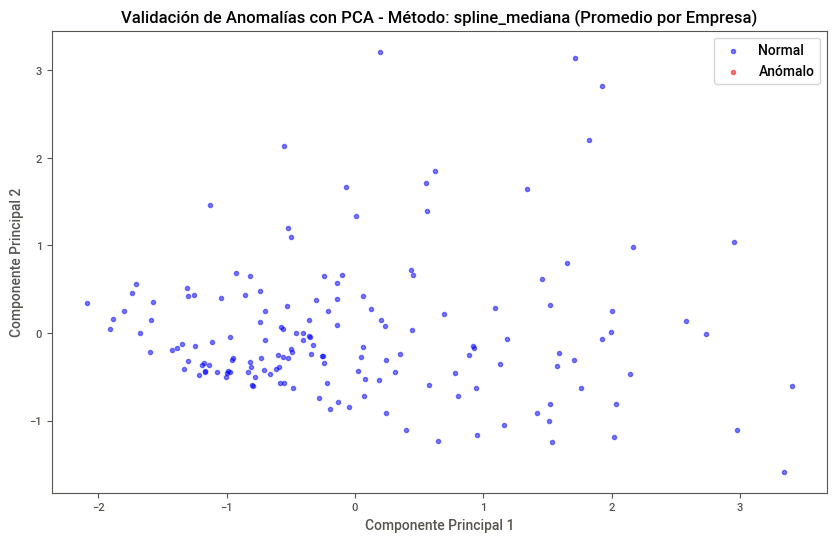


df_shifted actualizado para 'spline_mediana' y listo para pasos posteriores.



Procesando método: lineal_promedio
Primeras filas del DataFrame:
          Empresa      P_E  P_B_lag1  P_S_lag1  P_Share_lag1  ROCE_l_lag1  \
0  FLWS US Equity  35.4266    2.8638    0.6770          8.03     6.831567   
1  FLWS US Equity  37.7207    2.8638    0.6770          8.03     6.831567   
2  FLWS US Equity  11.3711    3.0493    0.7208          8.55     7.776733   
3  FLWS US Equity  10.8881    2.3843    0.5153          8.24     8.721900   
4  FLWS US Equity  17.2222    2.2830    0.4934          7.89     8.876467   

   EBIT_l_lag1  Total Activos_l_lag1  Deuda a LP_l_lag1  ROA_l_lag1  \
0    -0.264000            263.179667                0.0    4.553233   
1    -0.264000            263.179667                0.0    4.553233   
2     2.352000            265.374333                0.0    5.246067   
3     4.968000            267.569000                0.0    5.938900   
4     1.102667            283.194667

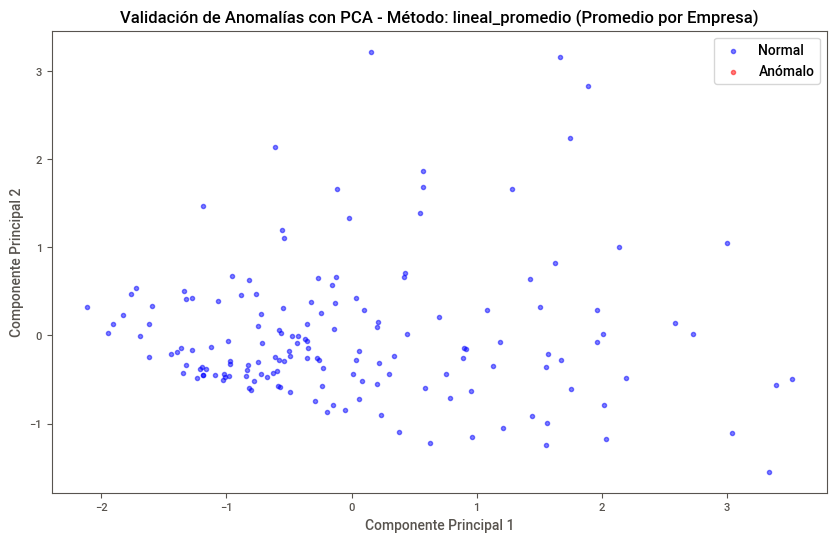


df_shifted actualizado para 'lineal_promedio' y listo para pasos posteriores.



Procesando método: spline_promedio
Primeras filas del DataFrame:
          Empresa      P_E  P_B_lag1  P_S_lag1  P_Share_lag1  ROCE_sp_lag1  \
0  FLWS US Equity  35.4266    2.8638    0.6770          8.03      8.881198   
1  FLWS US Equity  37.7207    2.8638    0.6770          8.03      8.881198   
2  FLWS US Equity  11.3711    3.0493    0.7208          8.55      9.469145   
3  FLWS US Equity  10.8881    2.3843    0.5153          8.24      8.721900   
4  FLWS US Equity  17.2222    2.2830    0.4934          7.89      7.711122   

   EBIT_sp_lag1  Total Activos_sp_lag1  Deuda a LP_sp_lag1  ROA_sp_lag1  \
0     18.021166             288.441467           15.783672     5.792834   
1     18.021166             288.441467           15.783672     5.792834   
2     17.412222             284.688373           12.626937     6.302227   
3      4.968000             267.569000            0.000000     5.938900   
4     -9.

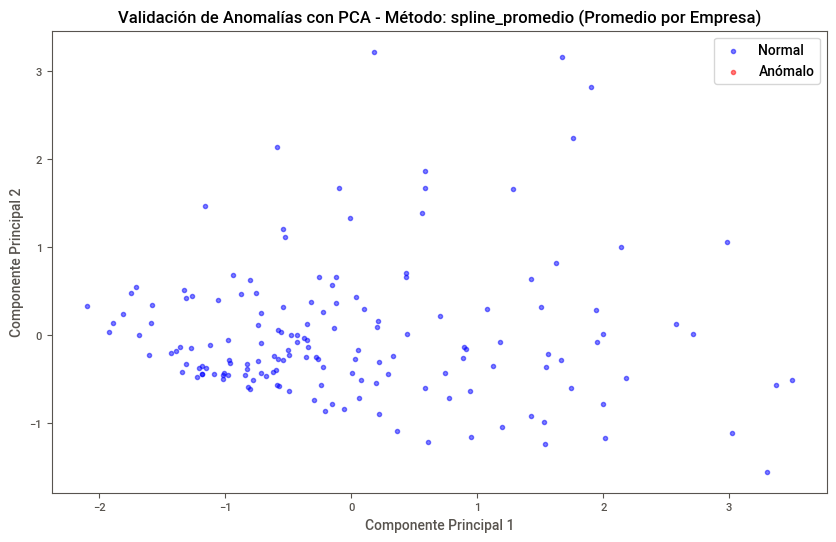


df_shifted actualizado para 'spline_promedio' y listo para pasos posteriores.




In [239]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

# Diccionario con las listas de columnas para cada método
listas_columnas = {
    "lineal_mediana": columnas_numericas_lineal_mediana,
    "spline_mediana": columnas_numericas_spline_mediana,
    "lineal_promedio": columnas_numericas_lineal_promedio,
    "spline_promedio": columnas_numericas_spline_promedio
}

# Crear una copia inicial de df_shifted para restaurarla en cada iteración
df_shifted_original = df_shifted.copy()

for metodo, columnas in listas_columnas.items():
    # Restaurar df_shifted al estado original para cada iteración
    df_shifted = df_shifted_original.copy()
    
    print(f"\nProcesando método: {metodo}")
    
    # Generar la lista de predictores para este método
    predictors = [col + '_lag1' for col in columnas if col != 'P_E']
    
    # Extraer el DataFrame con las columnas de interés desde df_shifted
    df_model = df_shifted[['Empresa', 'P_E'] + predictors].copy()
    
    print("Primeras filas del DataFrame:")
    print(df_model.head())
    
    # Verificar cuántas filas tienen TODOS los valores de predictores en 0
    zero_rows = (df_model[predictors] == 0).all(axis=1).sum()
    print(f"{zero_rows} filas con solo ceros en los predictores.")
    
    # Verificar cuántas columnas de predictores son constantes (std = 0)
    const_cols = df_model[predictors].std(axis=0).eq(0).sum()
    print(f"{const_cols} columnas constantes en los predictores.")
    
    # Verificar número de empresas y fechas únicas (usando df_shifted)
    print("Número de empresas y fechas únicas (según df_shifted):")
    total_empresas = df_shifted['Empresa'].nunique()
    print(f"Total de empresas: {total_empresas}")
    print(df_shifted[['Empresa', 'Fecha']].nunique())
    
    # Verificar si todas las empresas tienen el mismo número de fechas
    fechas_por_empresa = df_shifted.groupby('Empresa')['Fecha'].nunique()
    if fechas_por_empresa.nunique() != 1:
        print("Empresas con diferente número de fechas:")
        print(fechas_por_empresa)
    else:
        print("Todas las empresas tienen el mismo número de fechas.")
    
    print("\n" + "="*50 + "\n")
    
    # --- Detección de Anomalías usando exclusivamente Isolation Forest ---
    print(f"\nDetectando empresas anómalas para el método '{metodo}' con Isolation Forest...")
    
    # Seleccionar solo las columnas numéricas relevantes para la detección (predictors)
    X_anomaly = df_model[predictors].values
    
    # Estandarizar los datos
    scaler = StandardScaler()
    X_anomaly_scaled = scaler.fit_transform(X_anomaly)

    # Aplicar Isolation Forest
    print("Aplicando Isolation Forest...")
    iso_forest = IsolationForest(contamination=0.10, random_state=42)  # Ajuste inicial de contamination
    iso_forest.fit(X_anomaly_scaled)
    is_outlier_iso = iso_forest.predict(X_anomaly_scaled) == -1  # -1 indica anomalía

    # Agregar la etiqueta de outlier al DataFrame
    df_model['is_outlier'] = is_outlier_iso
    
    # Calcular el porcentaje de anomalías por empresa
    outlier_percentage = df_model.groupby('Empresa')['is_outlier'].mean()
    threshold = 0.3  # Umbral del 30% para definir "muchas" anomalías
    empresas_con_muchas_anomalias = outlier_percentage[outlier_percentage > threshold].index
    
    # Contar empresas eliminadas
    empresas_eliminadas = len(empresas_con_muchas_anomalias)
    empresas_restantes = total_empresas - empresas_eliminadas
    print(f"Se detectaron {empresas_eliminadas} empresas con más del {threshold*100}% de observaciones anómalas para '{metodo}':")
    print(f"Empresas eliminadas: {empresas_con_muchas_anomalias.tolist()}")
    print(f"Total de empresas restantes: {empresas_restantes}")
    
    # Actualizar df_shifted eliminando las empresas con muchas anomalías
    print(f"Tamaño original de df_shifted: {df_shifted.shape}")
    df_shifted = df_shifted[~df_shifted['Empresa'].isin(empresas_con_muchas_anomalias)].copy()
    print(f"Tamaño limpio de df_shifted tras eliminar empresas anómalas para '{metodo}': {df_shifted.shape}")

    # Validación con PCA (promediando por empresa para visualización)
    print(f"\nValidando anomalías con PCA para '{metodo}' (versión Isolation Forest)...")
    df_mean_by_company = df_shifted.groupby('Empresa')[predictors].mean().reset_index()

    # Generar la máscara booleana para indicar si cada empresa fue eliminada
    is_outlier_company = df_mean_by_company['Empresa'].isin(empresas_con_muchas_anomalias)

    # Preparar datos para PCA
    X_pca_input = df_mean_by_company[predictors].values
    X_pca_scaled = scaler.transform(X_pca_input)  # usar el mismo scaler para consistencia

    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_pca_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[~is_outlier_company, 0], X_pca[~is_outlier_company, 1],
                c='blue', label='Normal', alpha=0.5)
    plt.scatter(X_pca[is_outlier_company, 0], X_pca[is_outlier_company, 1],
                c='red', label='Anómalo', alpha=0.5)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title(f'Validación de Anomalías con PCA - Método: {metodo} (Promedio por Empresa)')
    plt.legend()
    plt.show()

    print(f"\ndf_shifted actualizado para '{metodo}' y listo para pasos posteriores.\n")
    print("="*50 + "\n")


#### **Sugerencia Inicial de Combinación Ideal**
#### Basado en tu contexto (180 empresas, RMSE alto por eliminación estricta, y el deseo de ajustar la limpieza):
#### Contamination = 0.10: Esto captura un 10% de anomalías, lo que es razonable para datos con ruido moderado y evita ser demasiado conservador (como 0.05).

#### Threshold = 0.3: Un 30% de anomalías por empresa es un buen compromiso inicial. Elimina empresas con un tercio de sus datos anómalos, que podrían ser ruidosas, sin descartar tantas como lo haría un 20%.

#### Razón: Esta combinación debería eliminar empresas con un nivel significativo de anomalías (potencialmente problemáticas) mientras preserva la mayoría de los datos, permitiendo un entrenamiento más robusto. Si tienes ~180 empresas, podrías esperar eliminar entre 10-30 empresas (5-15%) con esta configuración, dependiendo de la distribución de anomalías.



In [28]:
# --- Paso 2: Diagnósticos para cada método utilizando df_shifted ya procesado ---

# Diccionario con las listas de columnas para cada método
#listas_columnas = {
#    "lineal_mediana": columnas_numericas_lineal_mediana,
#    "spline_mediana": columnas_numericas_spline_mediana,
#    "lineal_promedio": columnas_numericas_lineal_promedio,
#    "spline_promedio": columnas_numericas_spline_promedio
#}

#for metodo, columnas in listas_columnas.items():
#    print(f"\nProcesando método: {metodo}")
    
    # Generar la lista de predictores para este método
#    predictors = [col + '_lag1' for col in columnas if col != 'P_E']
    
    # Extraer el DataFrame con las columnas de interés desde df_shifted
#    df_model = df_shifted[['Empresa', 'P_E'] + predictors].copy()
    
    # (Si desearas, podrías volver a aplicar imputación aquí, pero no es necesario)
    # df_model[predictors] = df_model[predictors].fillna(method='bfill')
    
#    print("Primeras filas del DataFrame:")
#    print(df_model.head())
    
    # Verificar cuántas filas tienen TODOS los valores de predictores en 0
#    zero_rows = (df_model[predictors] == 0).all(axis=1).sum()
#    print(f"{zero_rows} filas con solo ceros en los predictores.")
    
    # Verificar cuántas columnas de predictores son constantes (std = 0)
#    const_cols = df_model[predictors].std(axis=0).eq(0).sum()
#    print(f"{const_cols} columnas constantes en los predictores.")
    
    # Verificar número de empresas y fechas únicas (usando df_shifted)
#    print("Número de empresas y fechas únicas (según df_shifted):")
#    print(df_shifted[['Empresa', 'Fecha']].nunique())
    
    # Verificar si todas las empresas tienen el mismo número de fechas
#    fechas_por_empresa = df_shifted.groupby('Empresa')['Fecha'].nunique()
#    if fechas_por_empresa.nunique() != 1:
#        print("Empresas con diferente número de fechas:")
#        print(fechas_por_empresa)
#    else:
#        print("Todas las empresas tienen el mismo número de fechas.")
    
#    print("\n" + "="*50 + "\n")

# Random Forest y XGBoost

In [240]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import BaseCrossValidator, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

# =====================================
# FUNCIONES AUXILIARES
# =====================================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns, errors='ignore')

class GroupTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits=3):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        groups = np.asarray(groups)
        unique_groups = np.unique(groups)
        n_groups = len(unique_groups)
        if n_groups < self.n_splits:
            raise ValueError(f"Not enough groups ({n_groups}) for {self.n_splits} splits")

        test_folds = np.array_split(unique_groups, self.n_splits)
        
        for i in range(self.n_splits):
            test_groups = test_folds[i]
            train_groups = np.concatenate(test_folds[:i] + test_folds[i+1:])
            
            train_idx = np.where(np.isin(groups, train_groups))[0]
            test_idx = np.where(np.isin(groups, test_groups))[0]
            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

def prepare_data(df, columnas):
    """
    Prepara el DataFrame:
      - Crea los predictores agregando el sufijo '_lag1' (excluyendo 'P_E').
      - Selecciona las columnas 'Empresa', 'P_E' y los predictores.
      - Rellena los valores faltantes con 0.
      - Agrega la columna 'time_step' que indica el orden de observación por empresa.
    """
    predictors = [col + '_lag1' for col in columnas if col != 'P_E']
    df_model = df[['Empresa', 'P_E'] + predictors].copy().fillna(0)
    df_model['time_step'] = df_model.groupby('Empresa').cumcount() + 1
    return df_model

def train_test_split_by_empresa(df_model, n_empresas_prueba):
    """
    Divide los datos en entrenamiento y prueba de forma que se separen por empresas.
    """
    empresas_unicas = df_model['Empresa'].unique()
    # Separa las empresas en entrenamiento y prueba
    empresas_entrenamiento, empresas_prueba = train_test_split(
        empresas_unicas, 
        test_size=n_empresas_prueba, 
        random_state=42
    )
    mask_entrenamiento = df_model['Empresa'].isin(empresas_entrenamiento)
    mask_prueba = df_model['Empresa'].isin(empresas_prueba)

    X = df_model.drop(columns=['P_E'])
    y = df_model['P_E']

    X_train = X[mask_entrenamiento].copy()
    y_train = y[mask_entrenamiento].copy()
    X_test = X[mask_prueba].copy()
    y_test = y[mask_prueba].copy()
    return X_train, y_train, X_test, y_test

def evaluate_model(y_test, y_pred):
    """ Retorna las métricas RMSE, MAE y R2 """
    return {
        'RMSE': rmse(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

def sort_by_timestep(X, y):
    """
    Ordena los datos de X y y según la columna 'time_step'
    """
    X_sorted = X.copy()
    X_sorted.sort_values('time_step', inplace=True)
    y_sorted = y.loc[X_sorted.index]
    return X_sorted, y_sorted

def plot_feature_importances(model, feature_names, title="Importancia de Características"):
    """
    Extrae y grafica la importancia de las características. Si el modelo está en un pipeline, se busca
    el estimador final (por ejemplo, 'rf' o 'xgb').
    """
    if hasattr(model, 'named_steps'):
        if 'rf' in model.named_steps:
            estimator = model.named_steps['rf']
        elif 'xgb' in model.named_steps:
            estimator = model.named_steps['xgb']
        else:
            estimator = model
    else:
        estimator = model

    feature_importances = estimator.feature_importances_
    
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    fi_df.plot.bar(x='feature', y='importance', figsize=(10,5), legend=False)
    plt.title(title)
    plt.show()
    return fi_df

# =====================================
# BLOQUE DE EXPERIMENTOS
# =====================================

results = []

# Se recorre cada conjunto de columnas según el método
for metodo, columnas in listas_columnas.items():
    print("\n==============================================")
    print(f"Procesando método: {metodo}")
    print("==============================================\n")
    
    # Preparar el DataFrame usando la función prepare_data
    df_model = prepare_data(df_shifted, columnas)
    
    # -------------------------------------
    # RANDOM FOREST SIN VALIDACION TEMPORAL Y SIN HP SEARCH
    # -------------------------------------
    n_empresas_prueba = 10 
    X_train, y_train, X_test, y_test = train_test_split_by_empresa(df_model, n_empresas_prueba)
    
    rf_simple = RandomForestRegressor(random_state=42)
    X_train_rf_simple = X_train.drop(columns=['Empresa'], errors='ignore')
    X_test_rf_simple = X_test.drop(columns=['Empresa'], errors='ignore')
    
    rf_simple.fit(X_train_rf_simple, y_train)
    y_pred_rf_simple = rf_simple.predict(X_test_rf_simple)
    res_rf_simple = evaluate_model(y_test, y_pred_rf_simple)
    res_rf_simple.update({
        'Modelo': 'RandomForest', 
        'Validacion_Temp': False, 
        'Busqueda_HP': False, 
        'Metodo': metodo,
        'pipeline': rf_simple  # Guardamos el modelo entrenado
    })
    results.append(res_rf_simple)
    
    # -------------------------------------
    # RANDOM FOREST CON VALIDACION TEMPORAL SIN HP SEARCH
    # -------------------------------------
    X_train_rftv, y_train_rftv, X_test_rftv, y_test_rftv = train_test_split_by_empresa(df_model, n_empresas_prueba)
    
    X_train_rftv_sorted, y_train_rftv_sorted = sort_by_timestep(X_train_rftv, y_train_rftv)
    X_test_rftv_sorted, y_test_rftv_sorted = sort_by_timestep(X_test_rftv, y_test_rftv)
    
    rf_simple_tv = RandomForestRegressor(random_state=42)
    rf_simple_tv.fit(X_train_rftv_sorted.drop(columns=['Empresa'], errors='ignore'), y_train_rftv_sorted)
    y_pred_rf_tv_simple = rf_simple_tv.predict(X_test_rftv_sorted.drop(columns=['Empresa'], errors='ignore'))
    
    res_rf_tv_simple = evaluate_model(y_test_rftv_sorted, y_pred_rf_tv_simple)
    res_rf_tv_simple.update({
        'Modelo': 'RandomForest', 
        'Validacion_Temp': True, 
        'Busqueda_HP': False, 
        'Metodo': metodo,
        'pipeline': rf_simple_tv
    })
    results.append(res_rf_tv_simple)
    
    # -------------------------------------
    # RANDOM FOREST SIN VALIDACION TEMPORAL CON HP SEARCH
    # -------------------------------------
    X_train_rf_hp, y_train_rf_hp, X_test_rf_hp, y_test_rf_hp = train_test_split_by_empresa(df_model, n_empresas_prueba)
    
    pipeline_rf_hp = Pipeline([
        ('drop_columns', DropColumns(columns=['Empresa'])),
        ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])
    
    param_grid_rf = {
        'rf__max_depth': [5, 10],
        'rf__min_samples_split': [2, 5]
    }
    
    grid_search_rf = GridSearchCV(
        estimator=pipeline_rf_hp,
        param_grid=param_grid_rf,
        scoring=rmse_scorer,
        cv=3,
        n_jobs=1,
        verbose=0
    )
    grid_search_rf.fit(X_train_rf_hp, y_train_rf_hp)
    
    best_rf_hp = grid_search_rf.best_estimator_
    y_pred_rf_hp = best_rf_hp.predict(X_test_rf_hp)
    res_rf_hp = evaluate_model(y_test_rf_hp, y_pred_rf_hp)
    res_rf_hp.update({
        'Modelo': 'RandomForest', 
        'Validacion_Temp': False, 
        'Busqueda_HP': True, 
        'Metodo': metodo,
        'pipeline': best_rf_hp
    })
    results.append(res_rf_hp)
    
    # -------------------------------------
    # RANDOM FOREST CON VALIDACION TEMPORAL CON HP SEARCH
    # -------------------------------------
    X_train_rftv_hp, y_train_rftv_hp, X_test_rftv_hp, y_test_rftv_hp = train_test_split_by_empresa(df_model, n_empresas_prueba)
    groups_train_rf = X_train_rftv_hp['Empresa'].copy()
    
    pipeline_rf_tvhp = Pipeline([
        ('drop_columns', DropColumns(columns=['Empresa'])),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ])
    
    grid_search_rf_tv = GridSearchCV(
        estimator=pipeline_rf_tvhp,
        param_grid=param_grid_rf,
        scoring=rmse_scorer,
        cv=GroupTimeSeriesSplit(n_splits=4),
        n_jobs=1,
        verbose=0
    )
    
    grid_search_rf_tv.fit(X_train_rftv_hp, y_train_rftv_hp, groups=groups_train_rf)
    best_rf_tv_hp = grid_search_rf_tv.best_estimator_
    
    X_train_rftv_hp_sorted, y_train_rftv_hp_sorted = sort_by_timestep(X_train_rftv_hp, y_train_rftv_hp)
    X_test_rftv_hp_sorted, y_test_rftv_hp_sorted = sort_by_timestep(X_test_rftv_hp, y_test_rftv_hp)
    
    best_rf_tv_hp.fit(X_train_rftv_hp_sorted, y_train_rftv_hp_sorted)
    y_pred_rf_tv_hp = best_rf_tv_hp.predict(X_test_rftv_hp_sorted)
    res_rf_tv_hp = evaluate_model(y_test_rftv_hp_sorted, y_pred_rf_tv_hp)
    res_rf_tv_hp.update({
        'Modelo': 'RandomForest', 
        'Validacion_Temp': True, 
        'Busqueda_HP': True, 
        'Metodo': metodo,
        'pipeline': best_rf_tv_hp
    })
    results.append(res_rf_tv_hp)
    
    # -------------------------------------
    # XGBOOST SIN VALIDACION TEMPORAL SIN HP SEARCH
    # -------------------------------------
    X_train_xgb_s, y_train_xgb_s, X_test_xgb_s, y_test_xgb_s = train_test_split_by_empresa(df_model, n_empresas_prueba)
    
    xgb_simple = XGBRegressor(random_state=42)
    xgb_simple.fit(X_train_xgb_s.drop(columns=['Empresa'], errors='ignore'), y_train_xgb_s)
    y_pred_xgb_s = xgb_simple.predict(X_test_xgb_s.drop(columns=['Empresa'], errors='ignore'))
    
    res_xgb_s = evaluate_model(y_test_xgb_s, y_pred_xgb_s)
    res_xgb_s.update({
        'Modelo': 'XGBoost', 
        'Validacion_Temp': False, 
        'Busqueda_HP': False, 
        'Metodo': metodo,
        'pipeline': xgb_simple
    })
    results.append(res_xgb_s)
    
    # -------------------------------------
    # XGBOOST CON VALIDACION TEMPORAL SIN HP SEARCH
    # -------------------------------------
    X_train_xgb_tv_s, y_train_xgb_tv_s, X_test_xgb_tv_s, y_test_xgb_tv_s = train_test_split_by_empresa(df_model, n_empresas_prueba)
    
    X_train_xgb_tv_s_sorted, y_train_xgb_tv_s_sorted = sort_by_timestep(X_train_xgb_tv_s, y_train_xgb_tv_s)
    X_test_xgb_tv_s_sorted, y_test_xgb_tv_s_sorted = sort_by_timestep(X_test_xgb_tv_s, y_test_xgb_tv_s)
    
    xgb_simple_tv = XGBRegressor(random_state=42)
    xgb_simple_tv.fit(X_train_xgb_tv_s_sorted.drop(columns=['Empresa'], errors='ignore'), y_train_xgb_tv_s_sorted)
    y_pred_xgb_tv_s = xgb_simple_tv.predict(X_test_xgb_tv_s_sorted.drop(columns=['Empresa'], errors='ignore'))
    
    res_xgb_tv_s = evaluate_model(y_test_xgb_tv_s_sorted, y_pred_xgb_tv_s)
    res_xgb_tv_s.update({
        'Modelo': 'XGBoost', 
        'Validacion_Temp': True, 
        'Busqueda_HP': False, 
        'Metodo': metodo,
        'pipeline': xgb_simple_tv
    })
    results.append(res_xgb_tv_s)
    
    # -------------------------------------
    # XGBOOST SIN VALIDACION TEMPORAL CON HP SEARCH
    # -------------------------------------
    X_train_xgb_hp, y_train_xgb_hp, X_test_xgb_hp, y_test_xgb_hp = train_test_split_by_empresa(df_model, n_empresas_prueba)
    
    pipeline_xgb_hp = Pipeline([
        ('drop_columns', DropColumns(columns=['Empresa'])),
        ('xgb', XGBRegressor(random_state=42))
    ])
    
    param_grid_xgb = {
        'xgb__n_estimators': [100, 200],
        'xgb__max_depth': [3, 5],
        'xgb__learning_rate': [0.1, 0.01]
    }
    
    grid_search_xgb_hp = GridSearchCV(
        estimator=pipeline_xgb_hp,
        param_grid=param_grid_xgb,
        scoring=rmse_scorer,
        cv=3,
        n_jobs=1,
        verbose=0
    )
    grid_search_xgb_hp.fit(X_train_xgb_hp, y_train_xgb_hp)
    best_xgb_hp = grid_search_xgb_hp.best_estimator_
    
    y_pred_xgb_hp = best_xgb_hp.predict(X_test_xgb_hp)
    res_xgb_hp = evaluate_model(y_test_xgb_hp, y_pred_xgb_hp)
    res_xgb_hp.update({
        'Modelo': 'XGBoost', 
        'Validacion_Temp': False, 
        'Busqueda_HP': True, 
        'Metodo': metodo,
        'pipeline': best_xgb_hp
    })
    results.append(res_xgb_hp)
    
    # -------------------------------------
    # XGBOOST CON VALIDACION TEMPORAL CON HP SEARCH
    # -------------------------------------
    X_train_xgb_tv_hp, y_train_xgb_tv_hp, X_test_xgb_tv_hp, y_test_xgb_tv_hp = train_test_split_by_empresa(df_model, n_empresas_prueba)
    groups_train_xgb = X_train_xgb_tv_hp['Empresa'].copy()
    
    pipeline_xgb_tv_hp = Pipeline([
        ('drop_columns', DropColumns(columns=['Empresa'])),
        ('xgb', XGBRegressor(random_state=42))
    ])
    
    grid_search_xgb_tv_hp = GridSearchCV(
        estimator=pipeline_xgb_tv_hp,
        param_grid=param_grid_xgb,
        scoring=rmse_scorer,
        cv=GroupTimeSeriesSplit(n_splits=4),
        n_jobs=1,
        verbose=0
    )
    
    grid_search_xgb_tv_hp.fit(X_train_xgb_tv_hp, y_train_xgb_tv_hp, groups=groups_train_xgb)
    best_xgb_tv_hp = grid_search_xgb_tv_hp.best_estimator_
    
    X_train_xgb_tv_hp_sorted, y_train_xgb_tv_hp_sorted = sort_by_timestep(X_train_xgb_tv_hp, y_train_xgb_tv_hp)
    X_test_xgb_tv_hp_sorted, y_test_xgb_tv_hp_sorted = sort_by_timestep(X_test_xgb_tv_hp, y_test_xgb_tv_hp)
    
    best_xgb_tv_hp.fit(X_train_xgb_tv_hp_sorted, y_train_xgb_tv_hp_sorted)
    y_pred_xgb_tv_hp = best_xgb_tv_hp.predict(X_test_xgb_tv_hp_sorted)
    res_xgb_tv_hp = evaluate_model(y_test_xgb_tv_hp_sorted, y_pred_xgb_tv_hp)
    res_xgb_tv_hp.update({
        'Modelo': 'XGBoost', 
        'Validacion_Temp': True, 
        'Busqueda_HP': True, 
        'Metodo': metodo,
        'pipeline': best_xgb_tv_hp
    })
    results.append(res_xgb_tv_hp)
    
# =====================================
# CREAR TABLA DE RESULTADOS
# =====================================
df_results = pd.DataFrame(results)


Procesando método: lineal_mediana


Procesando método: spline_mediana


Procesando método: lineal_promedio


Procesando método: spline_promedio




Procesando método: lineal_mediana

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV RF best params (sin validación temporal): {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': 15}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 4 folds for each of 50 candidates, totalling 200 fits
RandomizedSearchCV RF best params (con validación temporal): {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': 15}
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV XGBoost best params (sin validación temporal): {'xgb__subsample': 0.7, 'xgb__n_estimators': 200, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.7}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 4 folds for ea

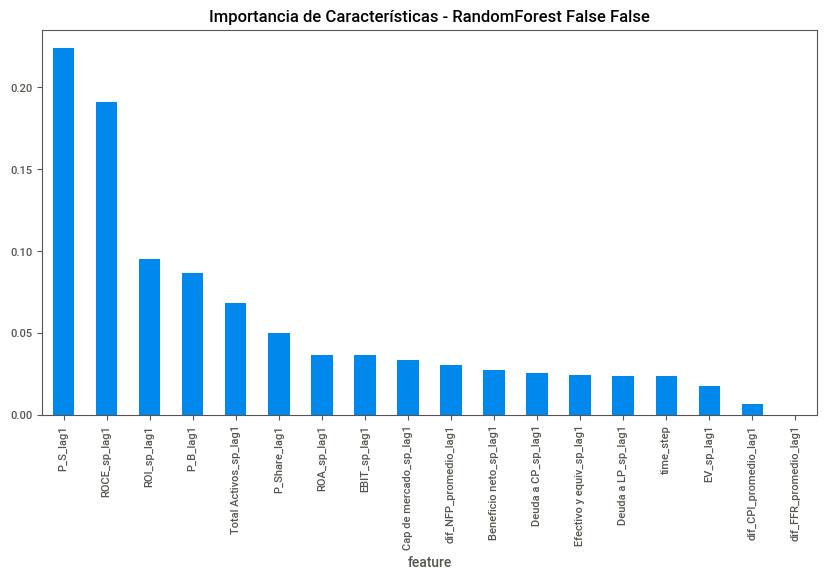

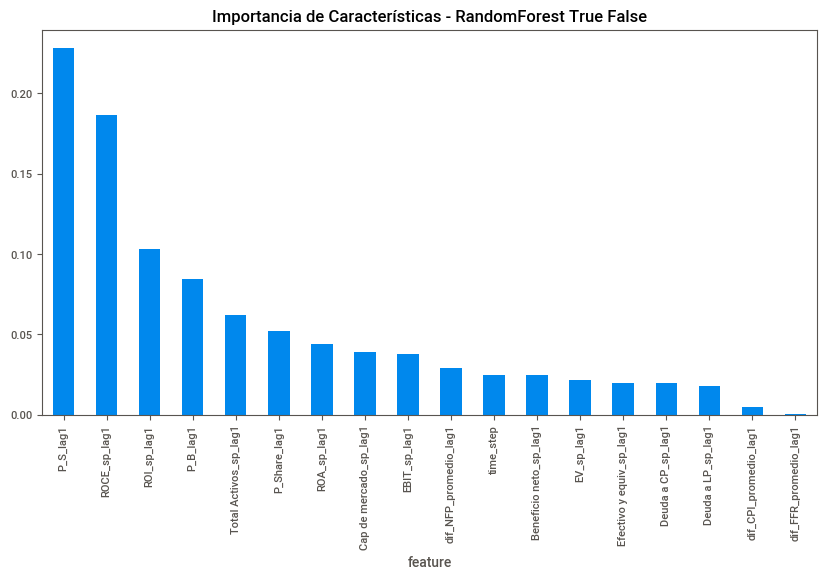

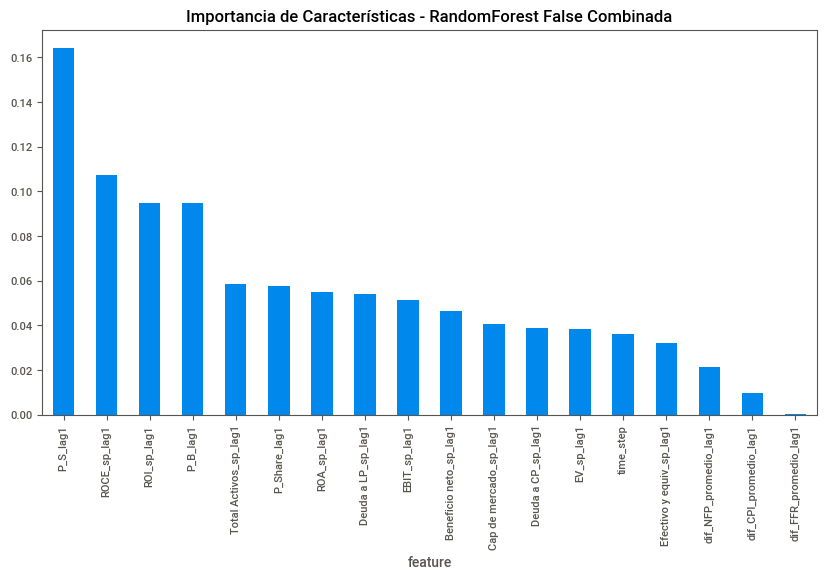

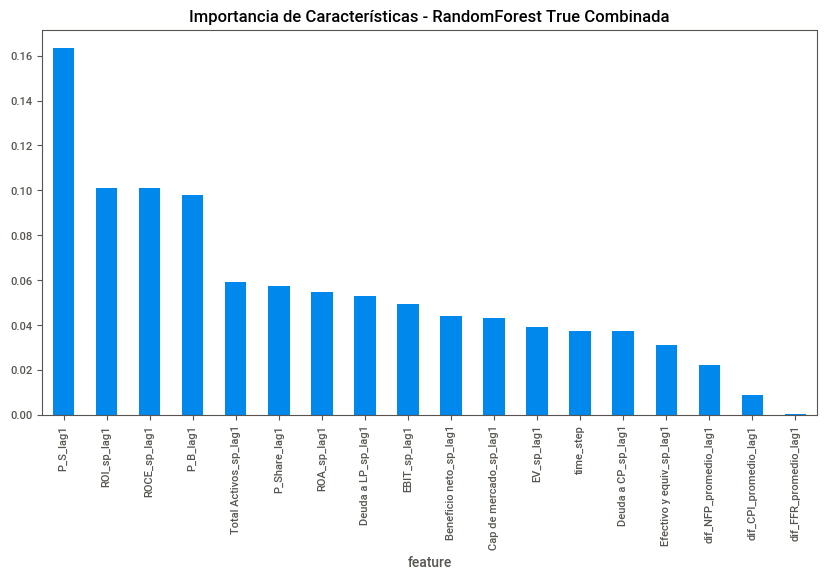

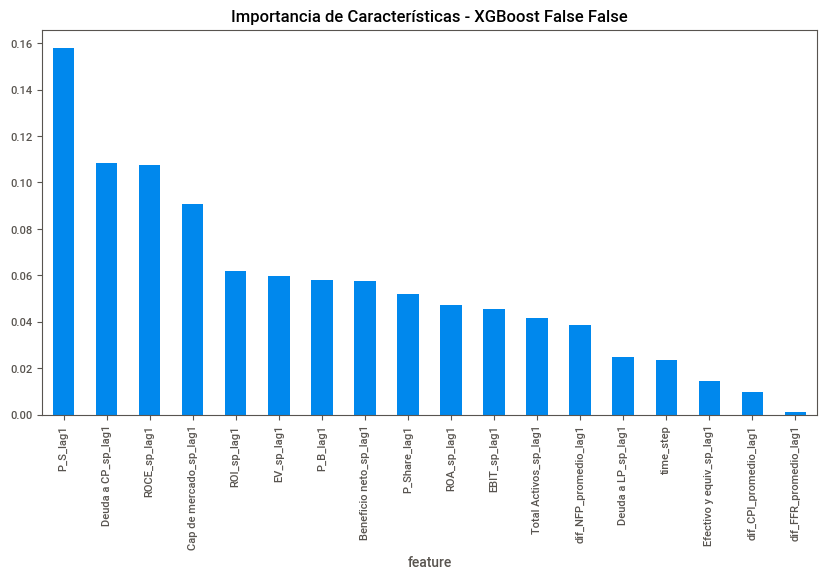

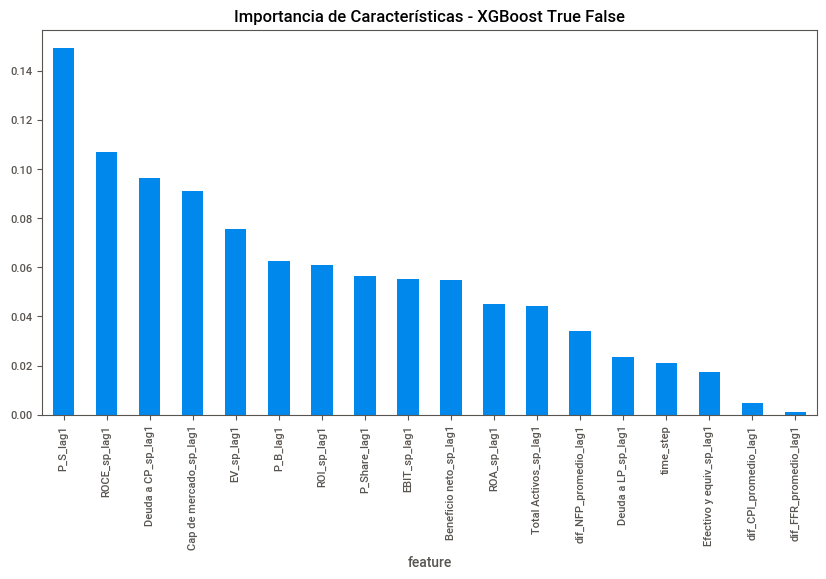

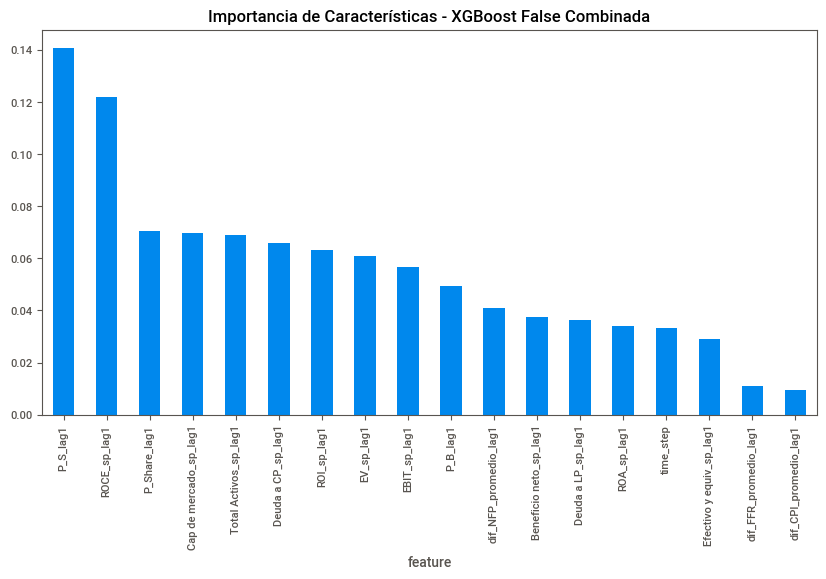

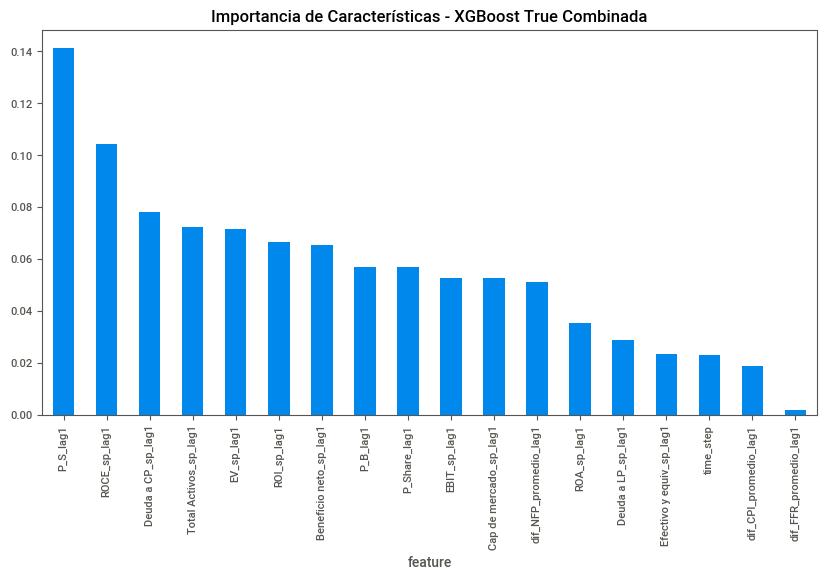

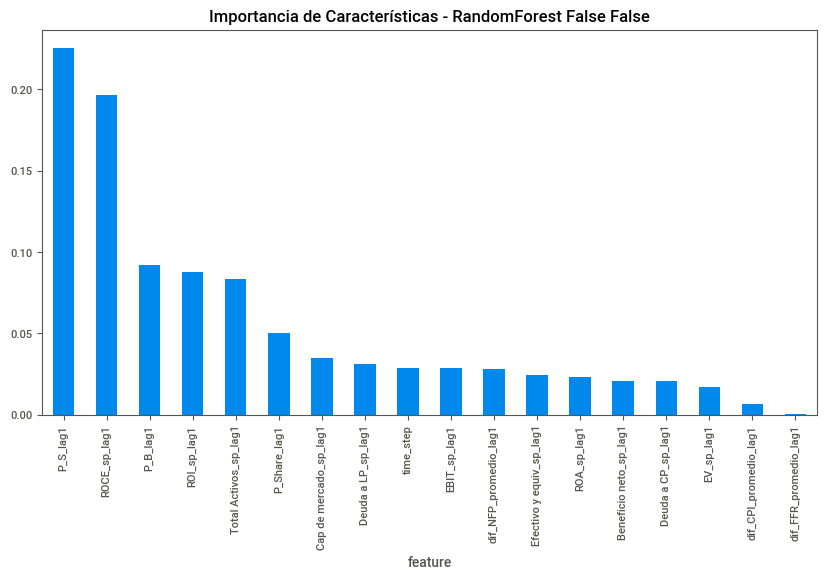

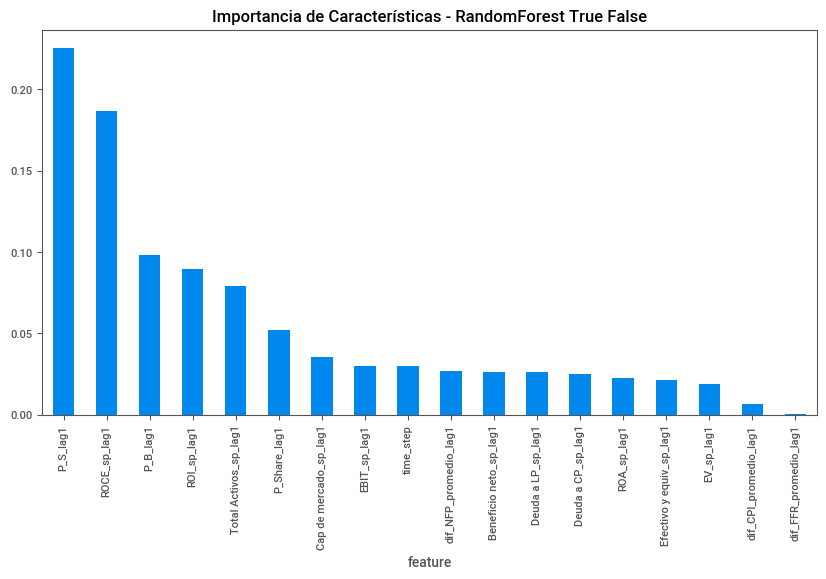

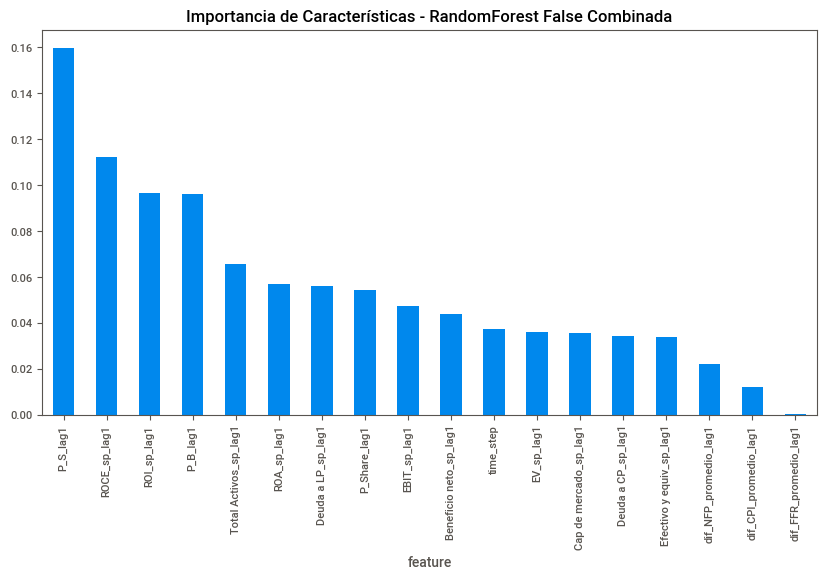

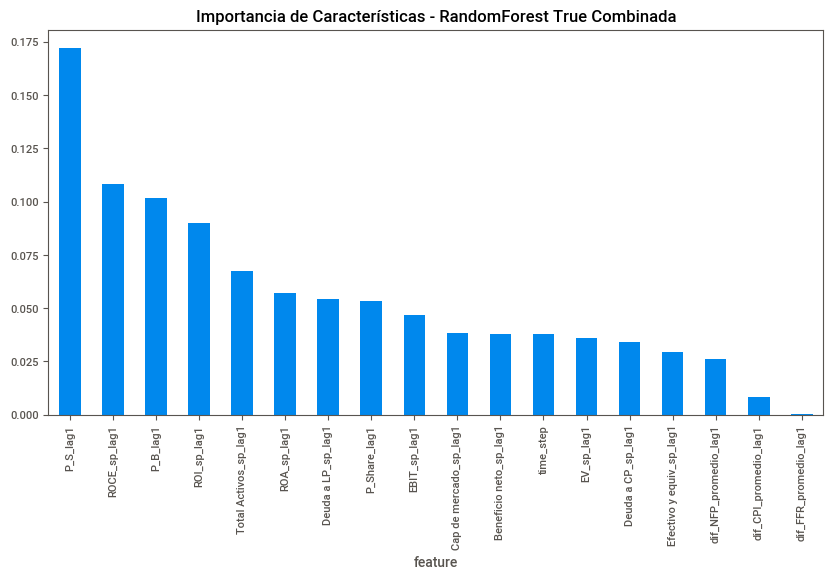

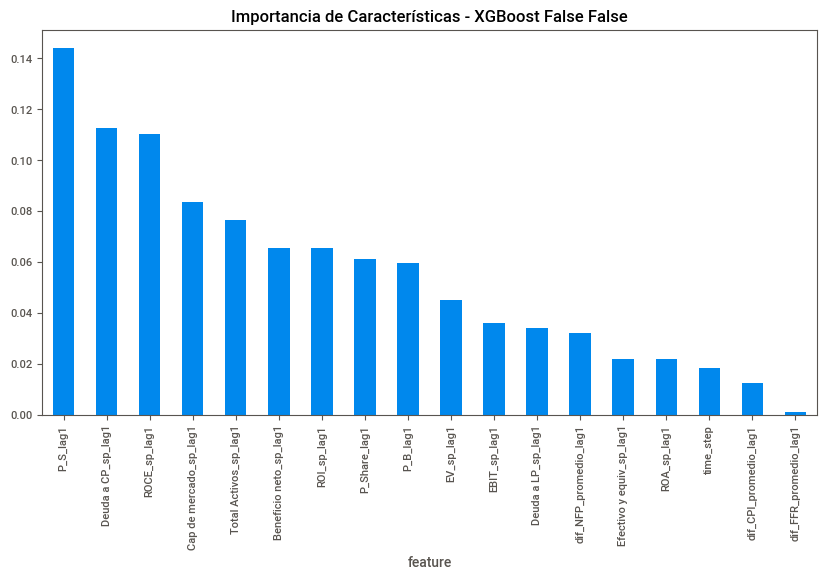

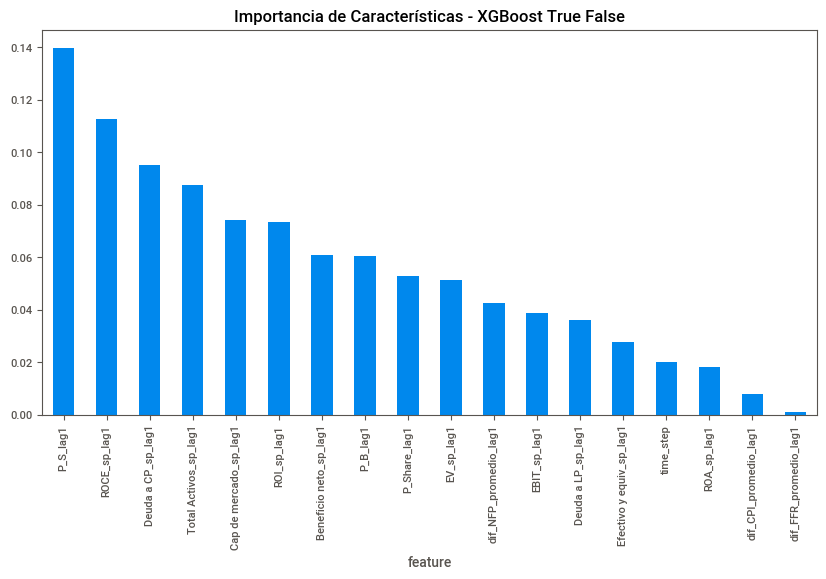

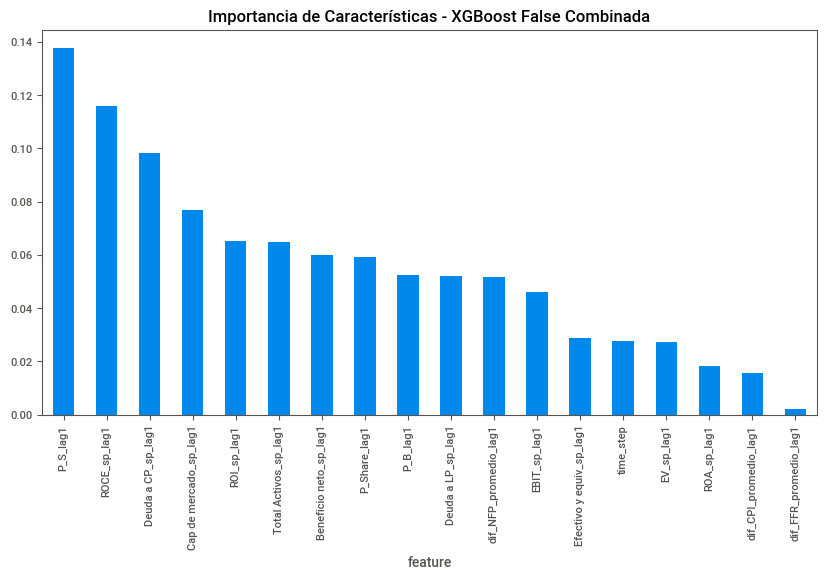

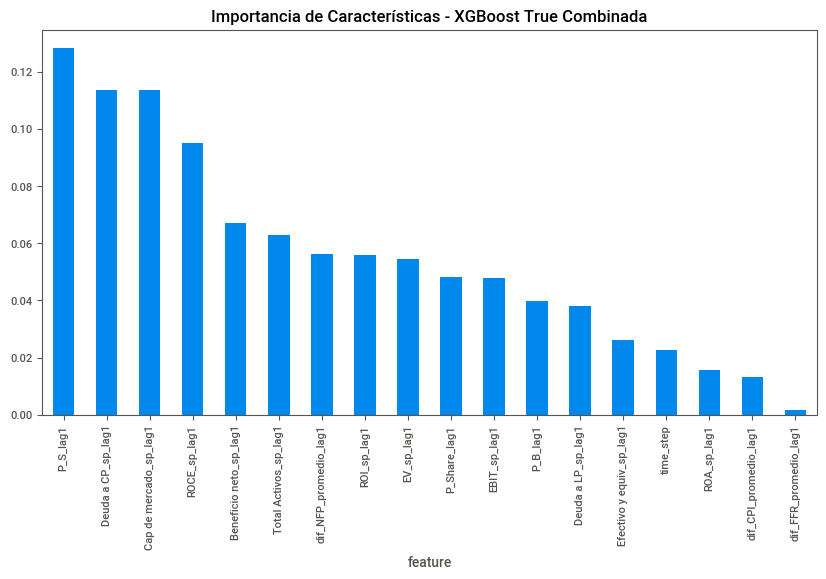

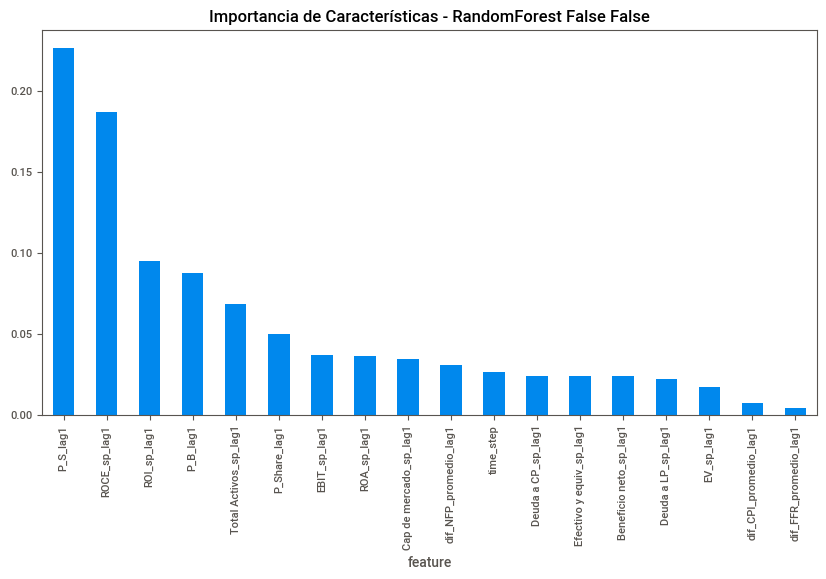

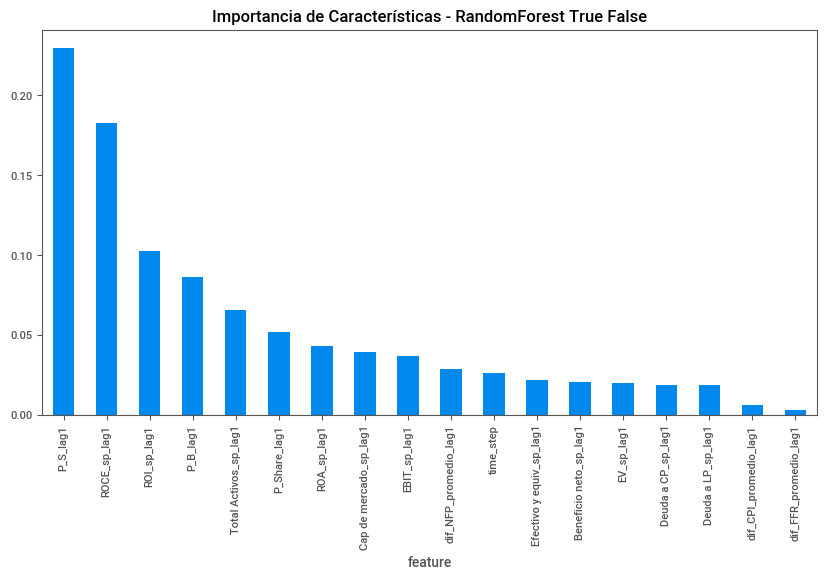

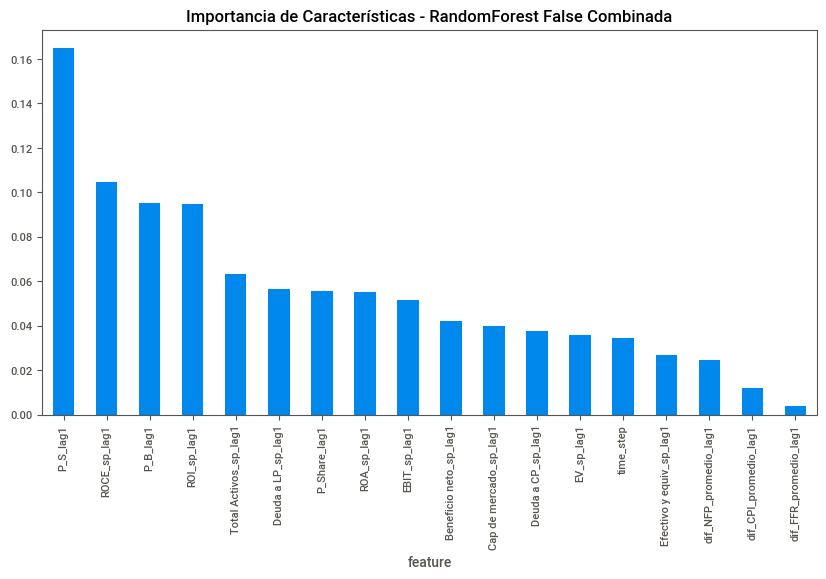

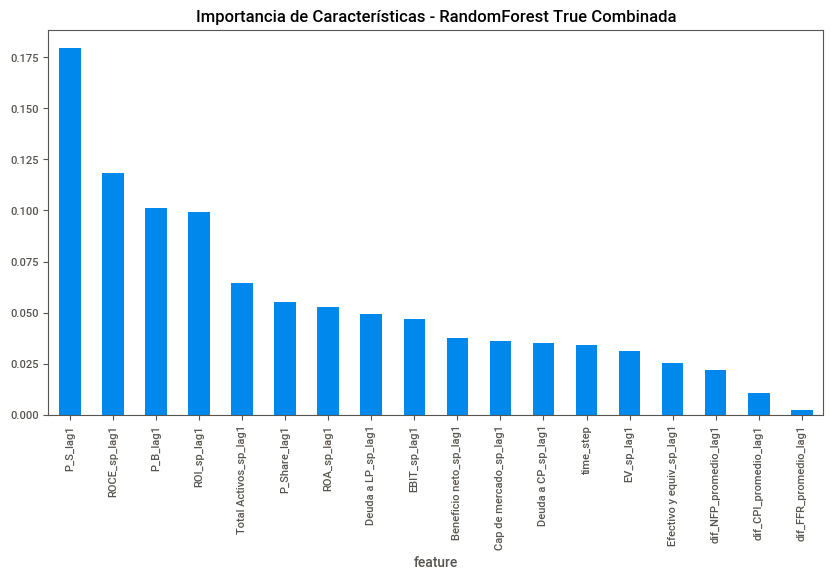

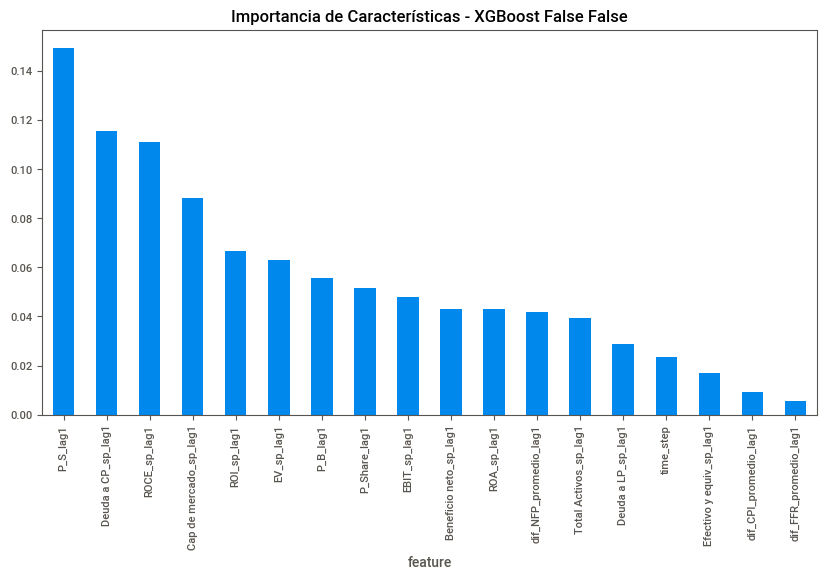

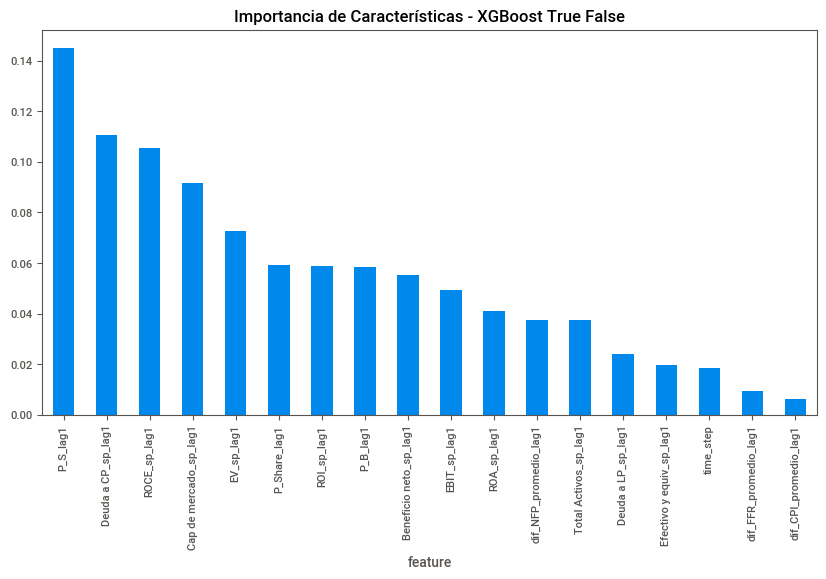

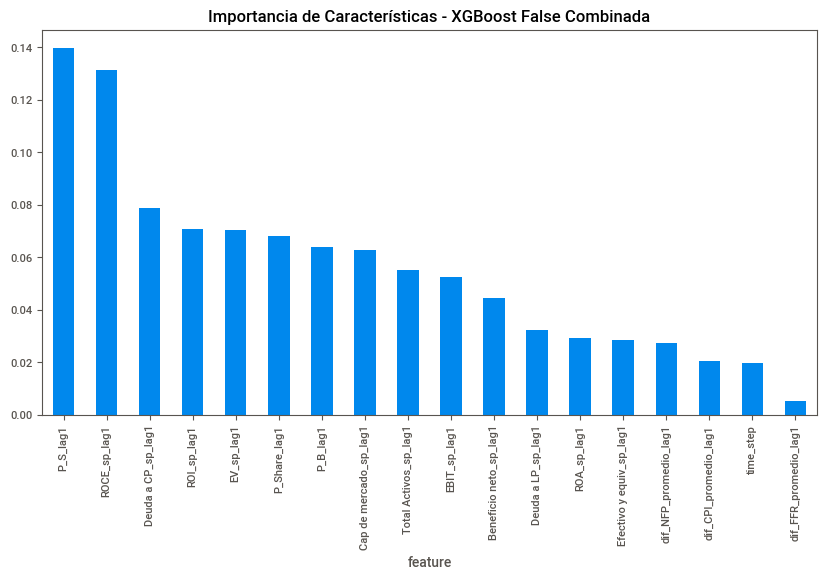

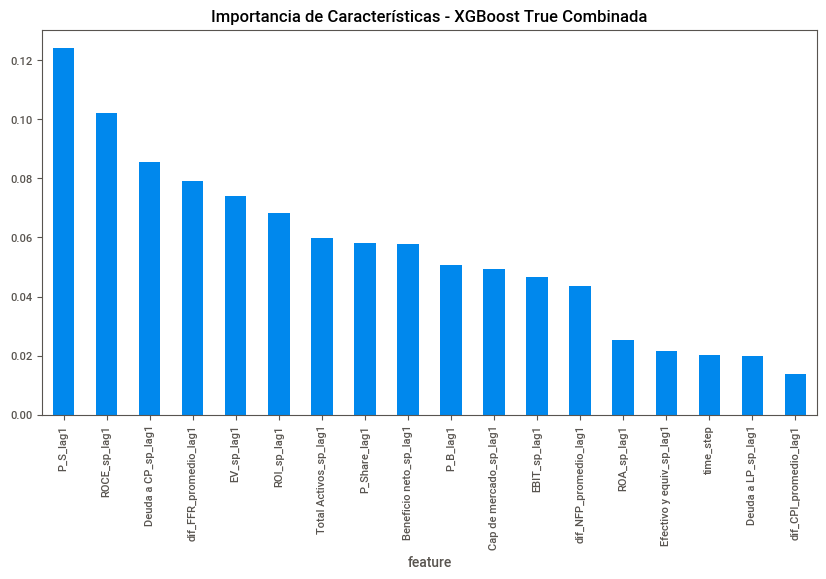

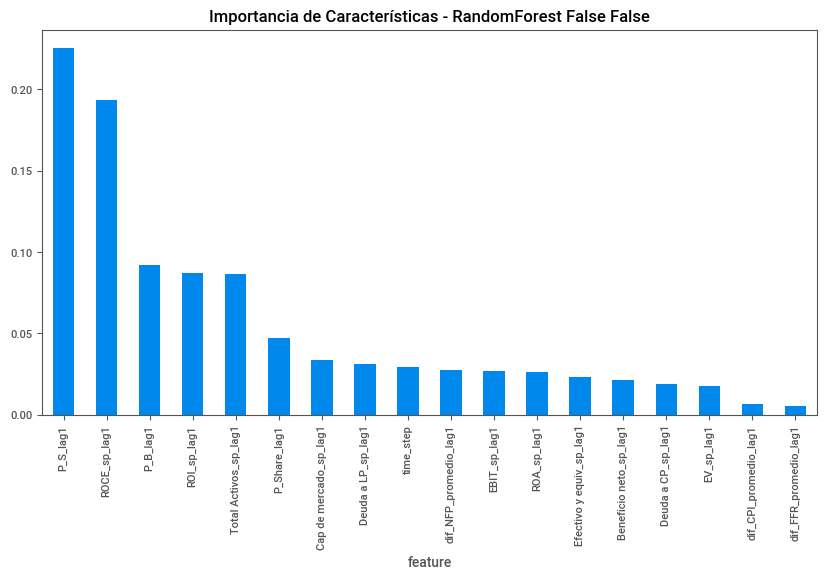

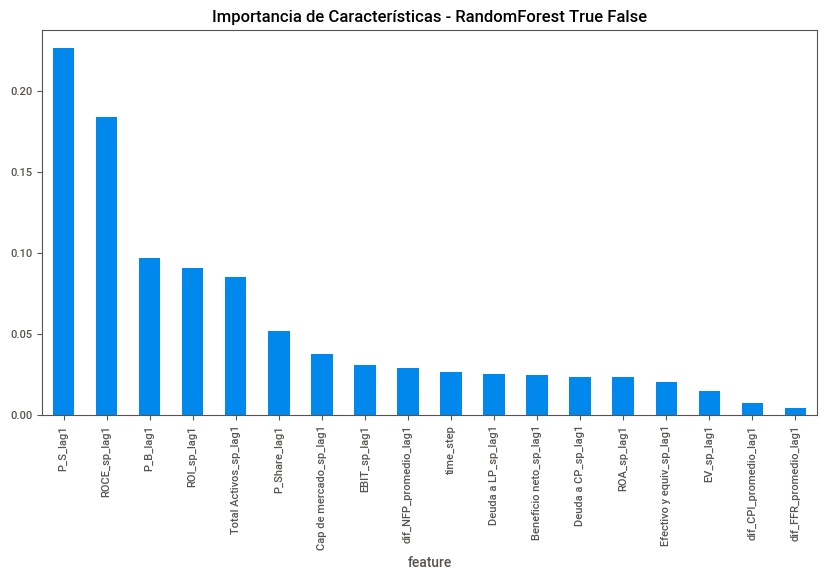

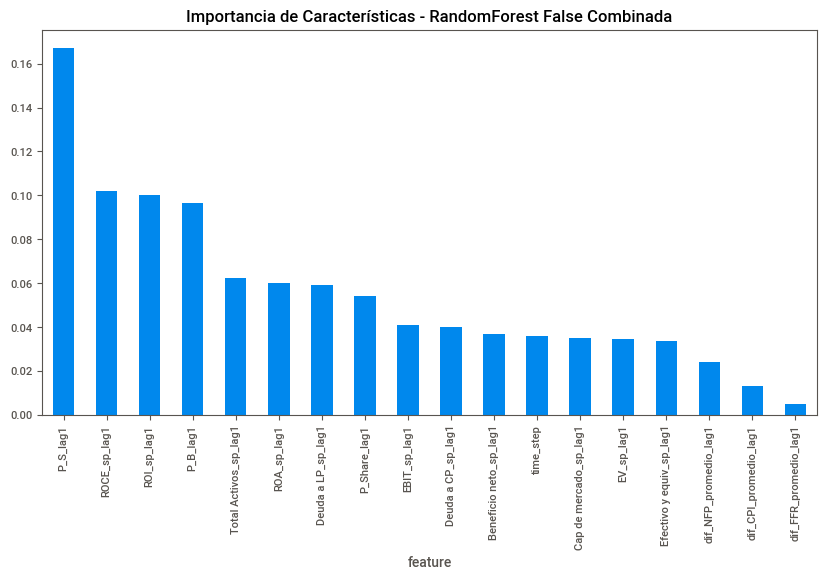

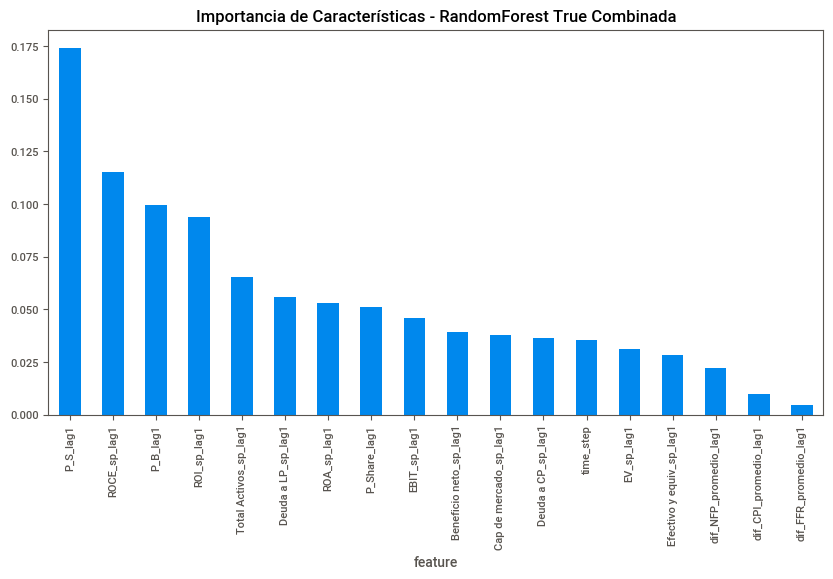

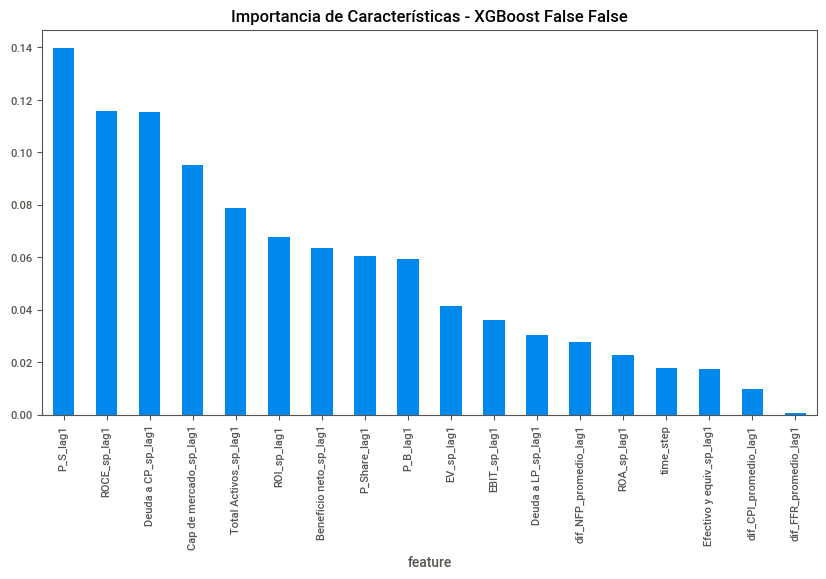

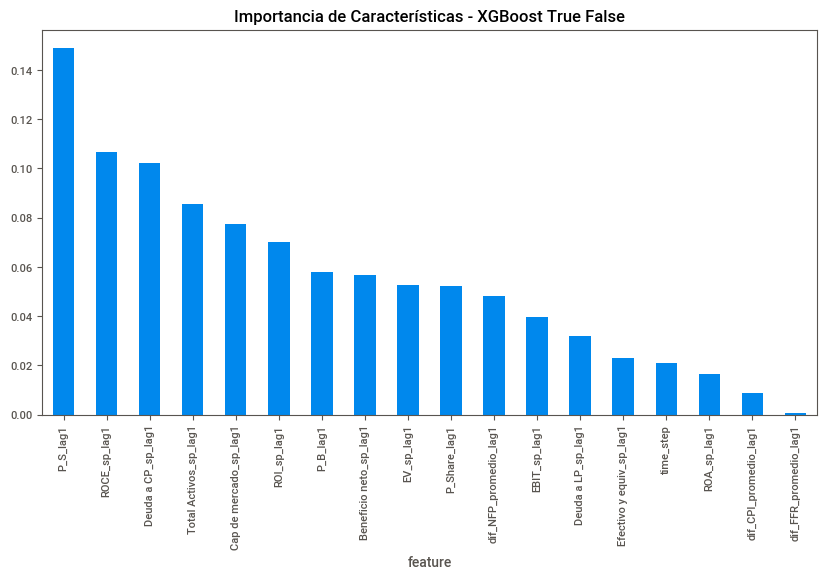

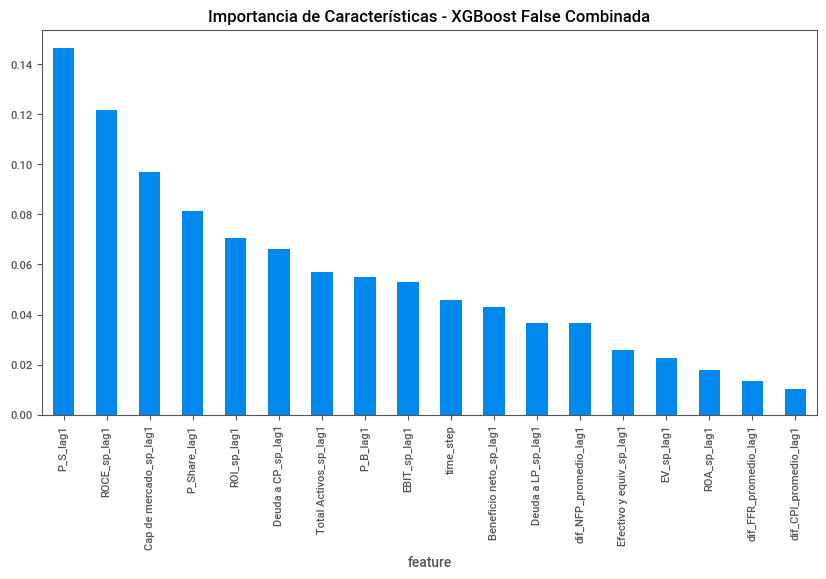

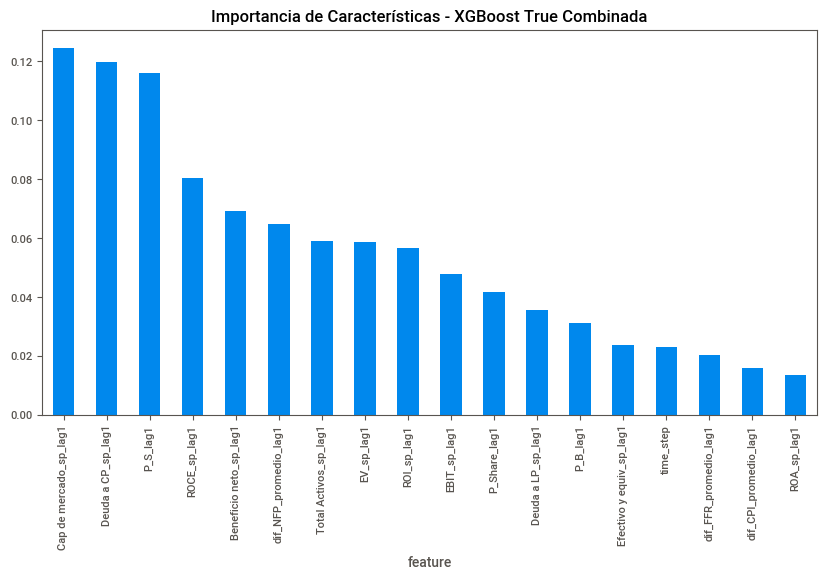

In [29]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import BaseCrossValidator, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# =====================================
# FUNCIONES AUXILIARES
# =====================================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns, errors='ignore')

class GroupTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits=4):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        groups = np.asarray(groups)
        unique_groups = np.unique(groups)
        n_groups = len(unique_groups)
        if n_groups < self.n_splits:
            raise ValueError(f"Not enough groups ({n_groups}) for {self.n_splits} splits")

        test_folds = np.array_split(unique_groups, self.n_splits)
        
        for i in range(self.n_splits):
            test_groups = test_folds[i]
            train_groups = np.concatenate(test_folds[:i] + test_folds[i+1:])
            train_idx = np.where(np.isin(groups, train_groups))[0]
            test_idx = np.where(np.isin(groups, test_groups))[0]
            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

def prepare_data(df, columnas):
    predictors = [col + '_lag1' for col in columnas if col != 'P_E']
    df_model = df[['Empresa', 'P_E'] + predictors].copy().fillna(0)
    df_model['time_step'] = df_model.groupby('Empresa').cumcount() + 1
    return df_model

def train_test_split_by_empresa(df_model, n_empresas_prueba):
    empresas_unicas = df_model['Empresa'].unique()
    empresas_entrenamiento, empresas_prueba = train_test_split(
        empresas_unicas, 
        test_size=n_empresas_prueba, 
        random_state=42
    )
    mask_entrenamiento = df_model['Empresa'].isin(empresas_entrenamiento)
    mask_prueba = df_model['Empresa'].isin(empresas_prueba)
    X = df_model.drop(columns=['P_E'])
    y = df_model['P_E']
    X_train = X[mask_entrenamiento].copy()
    y_train = y[mask_entrenamiento].copy()
    X_test = X[mask_prueba].copy()
    y_test = y[mask_prueba].copy()
    return X_train, y_train, X_test, y_test

def evaluate_model(y_test, y_pred):
    return {
        'RMSE': rmse(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

def sort_by_timestep(X, y):
    X_sorted = X.copy()
    X_sorted.sort_values('time_step', inplace=True)
    y_sorted = y.loc[X_sorted.index]
    return X_sorted, y_sorted

def plot_feature_importances(model, feature_names, title="Importancia de Características"):
    if hasattr(model, 'named_steps'):
        if 'rf' in model.named_steps:
            estimator = model.named_steps['rf']
        elif 'xgb' in model.named_steps:
            estimator = model.named_steps['xgb']
        else:
            estimator = model
    else:
        estimator = model
    feature_importances = estimator.feature_importances_
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)
    fi_df.plot.bar(x='feature', y='importance', figsize=(10,5), legend=False)
    plt.title(title)
    plt.show()
    return fi_df

# =====================================
# BLOQUE DE EXPERIMENTOS
# =====================================

results = []

for metodo, columnas in listas_columnas.items():
    print("\n==============================================")
    print(f"Procesando método: {metodo}")
    print("==============================================\n")
    
    df_model = prepare_data(df_shifted, columnas)
    n_empresas_prueba = 10
    
    # -------------------------------------
    # RANDOM FOREST SIN VALIDACION TEMPORAL Y SIN HP SEARCH
    # -------------------------------------
    X_train, y_train, X_test, y_test = train_test_split_by_empresa(df_model, n_empresas_prueba)
    rf_simple = RandomForestRegressor(random_state=42, max_depth=10, n_estimators=100)
    X_train_rf_simple = X_train.drop(columns=['Empresa'], errors='ignore')
    X_test_rf_simple = X_test.drop(columns=['Empresa'], errors='ignore')
    rf_simple.fit(X_train_rf_simple, y_train)
    y_pred_rf_simple = rf_simple.predict(X_test_rf_simple)
    res_rf_simple = evaluate_model(y_test, y_pred_rf_simple)
    res_rf_simple.update({
        'Modelo': 'RandomForest', 
        'Validacion_Temp': False, 
        'Busqueda_HP': False, 
        'Metodo': metodo,
        'pipeline': Pipeline([('drop_columns', DropColumns(columns=['Empresa'])), ('rf', rf_simple)])
    })
    results.append(res_rf_simple)
    
    # -------------------------------------
    # RANDOM FOREST CON VALIDACION TEMPORAL SIN HP SEARCH
    # -------------------------------------
    X_train_rftv, y_train_rftv, X_test_rftv, y_test_rftv = train_test_split_by_empresa(df_model, n_empresas_prueba)
    X_train_rftv_sorted, y_train_rftv_sorted = sort_by_timestep(X_train_rftv, y_train_rftv)
    X_test_rftv_sorted, y_test_rftv_sorted = sort_by_timestep(X_test_rftv, y_test_rftv)
    rf_simple_tv = RandomForestRegressor(random_state=42, max_depth=10, n_estimators=100)
    rf_simple_tv.fit(X_train_rftv_sorted.drop(columns=['Empresa'], errors='ignore'), y_train_rftv_sorted)
    y_pred_rf_tv_simple = rf_simple_tv.predict(X_test_rftv_sorted.drop(columns=['Empresa'], errors='ignore'))
    res_rf_tv_simple = evaluate_model(y_test_rftv_sorted, y_pred_rf_tv_simple)
    res_rf_tv_simple.update({
        'Modelo': 'RandomForest', 
        'Validacion_Temp': True, 
        'Busqueda_HP': False, 
        'Metodo': metodo,
        'pipeline': Pipeline([('drop_columns', DropColumns(columns=['Empresa'])), ('rf', rf_simple_tv)])
    })
    results.append(res_rf_tv_simple)
    
    # -------------------------------------
    # RANDOM FOREST SIN VALIDACION TEMPORAL CON HP SEARCH COMBINADO
    # -------------------------------------
    X_train_rf_hp, y_train_rf_hp, X_test_rf_hp, y_test_rf_hp = train_test_split_by_empresa(df_model, n_empresas_prueba)
    pipeline_rf_hp = Pipeline([
        ('drop_columns', DropColumns(columns=['Empresa'])),  # Primero eliminar 'Empresa'
        ('scaler', StandardScaler()),  # Luego escalar solo columnas numéricas
        ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])
    param_distributions_rf = {
        'rf__n_estimators': [100, 200, 300],
        'rf__max_depth': [5, 10, 15],
        'rf__min_samples_split': [2, 5, 10],
        'rf__max_features': ['sqrt', 0.3, 0.5],
        'rf__min_samples_leaf': [1, 2, 5]
    }
    random_search_rf = RandomizedSearchCV(
        estimator=pipeline_rf_hp,
        param_distributions=param_distributions_rf,
        n_iter=50,
        scoring=rmse_scorer,
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1,
        error_score='raise'  # Para depurar errores
    )
    random_search_rf.fit(X_train_rf_hp, y_train_rf_hp)
    print(f"RandomizedSearchCV RF best params (sin validación temporal): {random_search_rf.best_params_}")
    best_params_rf = random_search_rf.best_params_
    refined_grid_rf = {
        'rf__n_estimators': [max(50, best_params_rf['rf__n_estimators'] - 50), best_params_rf['rf__n_estimators']],
        'rf__max_depth': [max(3, best_params_rf['rf__max_depth'] - 2), best_params_rf['rf__max_depth']],
        'rf__min_samples_split': [max(2, best_params_rf['rf__min_samples_split'] - 1), best_params_rf['rf__min_samples_split']],
        'rf__max_features': [best_params_rf['rf__max_features']]
    }
    grid_search_rf = GridSearchCV(
        estimator=pipeline_rf_hp,
        param_grid=refined_grid_rf,
        scoring=rmse_scorer,
        cv=5,
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    grid_search_rf.fit(X_train_rf_hp, y_train_rf_hp)
    best_rf_hp = grid_search_rf.best_estimator_
    y_pred_rf_hp = best_rf_hp.predict(X_test_rf_hp)
    res_rf_hp = evaluate_model(y_test_rf_hp, y_pred_rf_hp)
    res_rf_hp.update({
        'Modelo': 'RandomForest', 
        'Validacion_Temp': False, 
        'Busqueda_HP': 'Combinada', 
        'Metodo': metodo,
        'pipeline': best_rf_hp
    })
    results.append(res_rf_hp)
    
    # -------------------------------------
    # RANDOM FOREST CON VALIDACION TEMPORAL CON HP SEARCH COMBINADO
    # -------------------------------------
    X_train_rftv_hp, y_train_rftv_hp, X_test_rftv_hp, y_test_rftv_hp = train_test_split_by_empresa(df_model, n_empresas_prueba)
    groups_train_rf = X_train_rftv_hp['Empresa'].copy()
    pipeline_rf_tvhp = Pipeline([
        ('drop_columns', DropColumns(columns=['Empresa'])),
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])
    random_search_rf_tv = RandomizedSearchCV(
        estimator=pipeline_rf_tvhp,
        param_distributions=param_distributions_rf,
        n_iter=50,
        scoring=rmse_scorer,
        cv=GroupTimeSeriesSplit(n_splits=4),
        random_state=42,
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    random_search_rf_tv.fit(X_train_rftv_hp, y_train_rftv_hp, groups=groups_train_rf)
    print(f"RandomizedSearchCV RF best params (con validación temporal): {random_search_rf_tv.best_params_}")
    best_params_rf_tv = random_search_rf_tv.best_params_
    refined_grid_rf_tv = {
        'rf__n_estimators': [max(50, best_params_rf_tv['rf__n_estimators'] - 50), best_params_rf_tv['rf__n_estimators']],
        'rf__max_depth': [max(3, best_params_rf_tv['rf__max_depth'] - 2), best_params_rf_tv['rf__max_depth']],
        'rf__min_samples_split': [max(2, best_params_rf_tv['rf__min_samples_split'] - 1), best_params_rf_tv['rf__min_samples_split']],
        'rf__max_features': [best_params_rf_tv['rf__max_features']]
    }
    grid_search_rf_tv = GridSearchCV(
        estimator=pipeline_rf_tvhp,
        param_grid=refined_grid_rf_tv,
        scoring=rmse_scorer,
        cv=GroupTimeSeriesSplit(n_splits=4),
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    grid_search_rf_tv.fit(X_train_rftv_hp, y_train_rftv_hp, groups=groups_train_rf)
    best_rf_tv_hp = grid_search_rf_tv.best_estimator_
    X_train_rftv_hp_sorted, y_train_rftv_hp_sorted = sort_by_timestep(X_train_rftv_hp, y_train_rftv_hp)
    X_test_rftv_hp_sorted, y_test_rftv_hp_sorted = sort_by_timestep(X_test_rftv_hp, y_test_rftv_hp)
    best_rf_tv_hp.fit(X_train_rftv_hp_sorted, y_train_rftv_hp_sorted)
    y_pred_rf_tv_hp = best_rf_tv_hp.predict(X_test_rftv_hp_sorted)
    res_rf_tv_hp = evaluate_model(y_test_rftv_hp_sorted, y_pred_rf_tv_hp)
    res_rf_tv_hp.update({
        'Modelo': 'RandomForest', 
        'Validacion_Temp': True, 
        'Busqueda_HP': 'Combinada', 
        'Metodo': metodo,
        'pipeline': best_rf_tv_hp
    })
    results.append(res_rf_tv_hp)
    
    # -------------------------------------
    # XGBOOST SIN VALIDACION TEMPORAL SIN HP SEARCH
    # -------------------------------------
    X_train_xgb_s, y_train_xgb_s, X_test_xgb_s, y_test_xgb_s = train_test_split_by_empresa(df_model, n_empresas_prueba)
    xgb_simple = XGBRegressor(random_state=42, max_depth=5, learning_rate=0.1, n_estimators=100)
    xgb_simple.fit(X_train_xgb_s.drop(columns=['Empresa'], errors='ignore'), y_train_xgb_s)
    y_pred_xgb_s = xgb_simple.predict(X_test_xgb_s.drop(columns=['Empresa'], errors='ignore'))
    res_xgb_s = evaluate_model(y_test_xgb_s, y_pred_xgb_s)
    res_xgb_s.update({
        'Modelo': 'XGBoost', 
        'Validacion_Temp': False, 
        'Busqueda_HP': False, 
        'Metodo': metodo,
        'pipeline': Pipeline([('drop_columns', DropColumns(columns=['Empresa'])), ('xgb', xgb_simple)])
    })
    results.append(res_xgb_s)
    
    # -------------------------------------
    # XGBOOST CON VALIDACION TEMPORAL SIN HP SEARCH
    # -------------------------------------
    X_train_xgb_tv_s, y_train_xgb_tv_s, X_test_xgb_tv_s, y_test_xgb_tv_s = train_test_split_by_empresa(df_model, n_empresas_prueba)
    X_train_xgb_tv_s_sorted, y_train_xgb_tv_s_sorted = sort_by_timestep(X_train_xgb_tv_s, y_train_xgb_tv_s)
    X_test_xgb_tv_s_sorted, y_test_xgb_tv_s_sorted = sort_by_timestep(X_test_xgb_tv_s, y_test_xgb_tv_s)
    xgb_simple_tv = XGBRegressor(random_state=42, max_depth=5, learning_rate=0.1, n_estimators=100)
    xgb_simple_tv.fit(X_train_xgb_tv_s_sorted.drop(columns=['Empresa'], errors='ignore'), y_train_xgb_tv_s_sorted)
    y_pred_xgb_tv_s = xgb_simple_tv.predict(X_test_xgb_tv_s_sorted.drop(columns=['Empresa'], errors='ignore'))
    res_xgb_tv_s = evaluate_model(y_test_xgb_tv_s_sorted, y_pred_xgb_tv_s)
    res_xgb_tv_s.update({
        'Modelo': 'XGBoost', 
        'Validacion_Temp': True, 
        'Busqueda_HP': False, 
        'Metodo': metodo,
        'pipeline': Pipeline([('drop_columns', DropColumns(columns=['Empresa'])), ('xgb', xgb_simple_tv)])
    })
    results.append(res_xgb_tv_s)
    
    # -------------------------------------
    # XGBOOST SIN VALIDACION TEMPORAL CON HP SEARCH COMBINADO
    # -------------------------------------
    X_train_xgb_hp, y_train_xgb_hp, X_test_xgb_hp, y_test_xgb_hp = train_test_split_by_empresa(df_model, n_empresas_prueba)
    pipeline_xgb_hp = Pipeline([
        ('drop_columns', DropColumns(columns=['Empresa'])),
        ('scaler', StandardScaler()),
        ('xgb', XGBRegressor(random_state=42))
    ])
    param_distributions_xgb = {
        'xgb__n_estimators': [100, 200, 300],
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__subsample': [0.7, 0.8, 0.9],
        'xgb__colsample_bytree': [0.7, 0.8, 0.9]
    }
    random_search_xgb = RandomizedSearchCV(
        estimator=pipeline_xgb_hp,
        param_distributions=param_distributions_xgb,
        n_iter=50,
        scoring=rmse_scorer,
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    random_search_xgb.fit(X_train_xgb_hp, y_train_xgb_hp)
    print(f"RandomizedSearchCV XGBoost best params (sin validación temporal): {random_search_xgb.best_params_}")
    best_params_xgb = random_search_xgb.best_params_
    refined_grid_xgb = {
        'xgb__n_estimators': [max(50, best_params_xgb['xgb__n_estimators'] - 50), best_params_xgb['xgb__n_estimators']],
        'xgb__max_depth': [max(2, best_params_xgb['xgb__max_depth'] - 1), best_params_xgb['xgb__max_depth']],
        'xgb__learning_rate': [best_params_xgb['xgb__learning_rate'] * 0.9, best_params_xgb['xgb__learning_rate']],
        'xgb__subsample': [best_params_xgb['xgb__subsample']]
    }
    grid_search_xgb = GridSearchCV(
        estimator=pipeline_xgb_hp,
        param_grid=refined_grid_xgb,
        scoring=rmse_scorer,
        cv=5,
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    grid_search_xgb.fit(X_train_xgb_hp, y_train_xgb_hp)
    best_xgb_hp = grid_search_xgb.best_estimator_
    y_pred_xgb_hp = best_xgb_hp.predict(X_test_xgb_hp)
    res_xgb_hp = evaluate_model(y_test_xgb_hp, y_pred_xgb_hp)
    res_xgb_hp.update({
        'Modelo': 'XGBoost', 
        'Validacion_Temp': False, 
        'Busqueda_HP': 'Combinada', 
        'Metodo': metodo,
        'pipeline': best_xgb_hp
    })
    results.append(res_xgb_hp)
    
    # -------------------------------------
    # XGBOOST CON VALIDACION TEMPORAL CON HP SEARCH COMBINADO
    # -------------------------------------
    X_train_xgb_tv_hp, y_train_xgb_tv_hp, X_test_xgb_tv_hp, y_test_xgb_tv_hp = train_test_split_by_empresa(df_model, n_empresas_prueba)
    groups_train_xgb = X_train_xgb_tv_hp['Empresa'].copy()
    pipeline_xgb_tv_hp = Pipeline([
        ('drop_columns', DropColumns(columns=['Empresa'])),
        ('scaler', StandardScaler()),
        ('xgb', XGBRegressor(random_state=42))
    ])
    random_search_xgb_tv = RandomizedSearchCV(
        estimator=pipeline_xgb_tv_hp,
        param_distributions=param_distributions_xgb,
        n_iter=50,
        scoring=rmse_scorer,
        cv=GroupTimeSeriesSplit(n_splits=4),
        random_state=42,
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    random_search_xgb_tv.fit(X_train_xgb_tv_hp, y_train_xgb_tv_hp, groups=groups_train_xgb)
    print(f"RandomizedSearchCV XGBoost best params (con validación temporal): {random_search_xgb_tv.best_params_}")
    best_params_xgb_tv = random_search_xgb_tv.best_params_
    refined_grid_xgb_tv = {
        'xgb__n_estimators': [max(50, best_params_xgb_tv['xgb__n_estimators'] - 50), best_params_xgb_tv['xgb__n_estimators']],
        'xgb__max_depth': [max(2, best_params_xgb_tv['xgb__max_depth'] - 1), best_params_xgb_tv['xgb__max_depth']],
        'xgb__learning_rate': [best_params_xgb_tv['xgb__learning_rate'] * 0.9, best_params_xgb_tv['xgb__learning_rate']],
        'xgb__subsample': [best_params_xgb_tv['xgb__subsample']]
    }
    grid_search_xgb_tv = GridSearchCV(
        estimator=pipeline_xgb_tv_hp,
        param_grid=refined_grid_xgb_tv,
        scoring=rmse_scorer,
        cv=GroupTimeSeriesSplit(n_splits=4),
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    grid_search_xgb_tv.fit(X_train_xgb_tv_hp, y_train_xgb_tv_hp, groups=groups_train_xgb)
    best_xgb_tv_hp = grid_search_xgb_tv.best_estimator_
    X_train_xgb_tv_hp_sorted, y_train_xgb_tv_hp_sorted = sort_by_timestep(X_train_xgb_tv_hp, y_train_xgb_tv_hp)
    X_test_xgb_tv_hp_sorted, y_test_xgb_tv_hp_sorted = sort_by_timestep(X_test_xgb_tv_hp, y_test_xgb_tv_hp)
    best_xgb_tv_hp.fit(X_train_xgb_tv_hp_sorted, y_train_xgb_tv_hp_sorted)
    y_pred_xgb_tv_hp = best_xgb_tv_hp.predict(X_test_xgb_tv_hp_sorted)
    res_xgb_tv_hp = evaluate_model(y_test_xgb_tv_hp_sorted, y_pred_xgb_tv_hp)
    res_xgb_tv_hp.update({
        'Modelo': 'XGBoost', 
        'Validacion_Temp': True, 
        'Busqueda_HP': 'Combinada', 
        'Metodo': metodo,
        'pipeline': best_xgb_tv_hp
    })
    results.append(res_xgb_tv_hp)

# =====================================
# CREAR TABLA DE RESULTADOS Y ANÁLISIS
# =====================================
df_results = pd.DataFrame(results)
print(df_results)

# Opcional: Analizar importancia de características
for i, row in df_results.iterrows():
    if 'pipeline' in row and row['pipeline'] is not None:
        model = row['pipeline']
        X_test_dropped = X_test.drop(columns=['Empresa'], errors='ignore')
        plot_feature_importances(model, X_test_dropped.columns, title=f"Importancia de Características - {row['Modelo']} {row['Validacion_Temp']} {row['Busqueda_HP']}")

#### **¿GridSearchCV con grilla reducida da mejor resultado en términos de calidad de modelos que RandomizedSearchCV original?**

##### La calidad del modelo depende en gran medida de si la grilla reducida está bien definida y focalizada en los rangos de hiperparámetros que realmente importan para tu problema. RandomizedSearchCV explora un espacio más amplio de forma aleatoria, lo que a veces puede dar buenos resultados, pero puede perderse en regiones menos prometedoras.

##### Si has analizado previamente y sabes, por ejemplo, que ciertos valores para n_estimators, max_depth, etc., tienden a funcionar mejor, entonces una grilla reducida y bien definida puede facilitar que el grid search se concentre en esas combinaciones "óptimas", reduciendo el tiempo de cómputo y, potencialmente, obteniendo modelos de mejor calidad en términos de estabilidad y rendimiento.

##### En resumen, no hay garantía absoluta de que una grilla reducida siempre produzca modelos mejores que un random search, pero si eliges cuidadosamente los rangos basados en conocimiento previo o experimentos preliminares, es muy posible que obtengas modelos robustos y de alta calidad, además de mejorar la eficiencia computacional.

In [241]:
print("\nTabla de Resultados:")
df_results


Tabla de Resultados:


RMSE        MAE         R2        Modelo  Validacion_Temp  \
0   18.977581   7.742839  -0.099986  RandomForest            False   
1   21.750987   7.520138  -0.444985  RandomForest             True   
2   16.320115  10.048519   0.186511  RandomForest            False   
3   15.652050   9.834565   0.251748  RandomForest             True   
4   43.015332  13.742281  -4.651348       XGBoost            False   
5   26.891570   8.166982  -1.208706       XGBoost             True   
6   14.317508   9.571481   0.373905       XGBoost            False   
7   14.335300   9.564449   0.372348       XGBoost             True   
8   18.886143   7.530410  -0.089412  RandomForest            False   
9   20.902825   7.190021  -0.334490  RandomForest             True   
10  16.171923   9.865096   0.201217  RandomForest            False   
11  15.772460   9.762225   0.240191  RandomForest             True   
12  50.822119  14.869556  -6.888802       XGBoost            False   
13  87.710252  23.012546 -22.496665       XGBoost             True   
14  14.618405   9.597239   0.347312       XGBoost            False   
15  14.328440   9.509192   0.372948       XGBoost             True   
16  19.445655   7.709083  -0.154917  RandomForest            False   
17  20.284442   7.448429  -0.256700  RandomForest             True   
18  16.120429   9.966977   0.206296  RandomForest            False   
19  15.736746   9.881943   0.243628  RandomForest             True   
20  35.907598  11.555596  -2.938023       XGBoost            False   
21  27.579076   9.112852  -1.323084       XGBoost             True   
22  14.317508   9.571481   0.373905       XGBoost            False   
23  14.335300   9.564449   0.372348       XGBoost             True   
24  17.472847   7.243170   0.067534  RandomForest            False   
25  19.827830   7.238871  -0.200759  RandomForest             True   
26  15.560466   9.709454   0.260479  RandomForest            False   
27  15.539720   9.746540   0.262449  RandomForest             True   
28  58.208968  16.703930  -9.348688       XGBoost            False   
29  51.976038  14.362895  -7.251100       XGBoost             True   
30  14.618405   9.597239   0.347312       XGBoost            False   
31  14.328440   9.509192   0.372948       XGBoost             True   

    Busqueda_HP           Metodo  \
0         False   lineal_mediana   
1         False   lineal_mediana   
2          True   lineal_mediana   
3          True   lineal_mediana   
4         False   lineal_mediana   
5         False   lineal_mediana   
6          True   lineal_mediana   
7          True   lineal_mediana   
8         False   spline_mediana   
9         False   spline_mediana   
10         True   spline_mediana   
11         True   spline_mediana   
12        False   spline_mediana   
13        False   spline_mediana   
14         True   spline_mediana   
15         True   spline_mediana   
16        False  lineal_promedio   
17        False  lineal_promedio   
18         True  lineal_promedio   
19         True  lineal_promedio   
20        False  lineal_promedio   
21        False  lineal_promedio   
22         True  lineal_promedio   
23         True  lineal_promedio   
24        False  spline_promedio   
25        False  spline_promedio   
26         True  spline_promedio   
27         True  spline_promedio   
28        False  spline_promedio   
29        False  spline_promedio   
30         True  spline_promedio   
31         True  spline_promedio   

                                             pipeline  
0   (DecisionTreeRegressor(max_features=1.0, rando...  
1   (DecisionTreeRegressor(max_features=1.0, rando...  
2   (DropColumns(columns=['Empresa']), (DecisionTr...  
3   (DropColumns(columns=['Empresa']), (DecisionTr...  
4   XGBRegressor(base_score=None, booster=None, ca...  
5   XGBRegressor(base_score=None, booster=None, ca...  
6   (DropColumns(columns=['Empresa']), XGBRegresso...  
7   (DropColumns(columns=['Empresa']), XGBRegresso...  
8   (

#### Es comprensible que, al comparar las métricas, un modelo evaluado sin validación temporal pueda mostrar mejores números (por ejemplo, un RMSE menor). Sin embargo, en el contexto de series temporales, la validación temporal es fundamental para asegurar que la evaluación simule adecuadamente el escenario real de pronósticos.

#### ¿Por qué es preferible la validación temporal?
#### Evitar el "data leakage":
#### Sin una separación temporal, existe el riesgo de que el modelo se entrene con información futura o que la división aleatoria mezcle el pasado y el futuro, lo que puede generar métricas artificialmente optimistas.

#### Simulación del escenario real:
#### En la práctica, al hacer predicciones se cuenta solo con información del pasado. La validación temporal respeta esta secuencia, dividiendo los datos de manera que el entrenamiento solo utiliza datos anteriores a los del conjunto de prueba.

#### Robustez y generalización:
#### Aunque un modelo sin validación temporal pueda tener mejores métricas en un entorno no estricto, es probable que su desempeño real al predecir datos futuros sea inferior. El modelo que se evalúa con validación temporal tiende a ser más robusto frente a cambios en la dinámica temporal.

#### Conclusión
#### Aunque pueda parecer atractivo elegir el modelo con mejores métricas (por ejemplo, menor RMSE) obtenido sin validación temporal, para aplicaciones de series temporales es preferible optar por el modelo evaluado con validación temporal. Este enfoque garantiza que la evaluación sea más realista y que el modelo seleccionado tenga mayor capacidad de generalización cuando se enfrente a datos futuros, incluso si las métricas numéricas son un poco peores.

#### En resumen, si el objetivo es pronosticar de manera confiable en un entorno real, es recomendable confiar en el modelo evaluado con validación temporal, ya que ese método refleja mejor el rendimiento real del modelo en producción.

In [242]:
# Elección entre modelos

def select_candidate_models(df, n=3):
    """
    Selecciona los n modelos candidatos según los siguientes criterios:
      1. Filtra los modelos que fueron evaluados con validación temporal y búsqueda de HP.
      2. Si no hay candidatos en ese filtro, se usa como fallback los modelos con validación temporal.
      3. Si aun así no hay, se toman todos los modelos.
      4. Finalmente, se ordenan por RMSE (de menor a mayor) y se retornan los n mejores.
    """
    # Paso 1: Filtrar por validación temporal y búsqueda de hiperparámetros
    df_candidates = df[(df['Validacion_Temp'] == True) & (df['Busqueda_HP'] == True)]
    
    # Fallback 1: Si no hay candidatos, filtrar solo por validación temporal
    if df_candidates.empty:
        df_candidates = df[df['Validacion_Temp'] == True]
    
    # Fallback 2: Si aún no hay, usar todos los modelos
    if df_candidates.empty:
        df_candidates = df.copy()
    
    # Ordenar por RMSE y retornar los n mejores candidatos
    return df_candidates.sort_values('RMSE').head(n)

In [243]:
# Candidatos a mejor modelo
top_candidates = select_candidate_models(df_results, n=3)
print("Top candidatos según RMSE (priorizando validación temporal y HP search):")
print(top_candidates)

# Mejor modelo de entre esos candidatos
best_model = top_candidates.iloc[0]
print("El mejor modelo proviene del método:", best_model['Metodo'])
print(best_model)
best_pipeline = best_model['pipeline']

Top candidatos según RMSE (priorizando validación temporal y HP search):
        RMSE       MAE        R2   Modelo  Validacion_Temp  Busqueda_HP  \
15  14.32844  9.509192  0.372948  XGBoost             True         True   
31  14.32844  9.509192  0.372948  XGBoost             True         True   
7   14.33530  9.564449  0.372348  XGBoost             True         True   

             Metodo                                           pipeline  
15   spline_mediana  (DropColumns(columns=['Empresa']), XGBRegresso...  
31  spline_promedio  (DropColumns(columns=['Empresa']), XGBRegresso...  
7    lineal_mediana  (DropColumns(columns=['Empresa']), XGBRegresso...  
El mejor modelo proviene del método: spline_mediana
RMSE                                                        14.32844
MAE                                                         9.509192
R2                                                          0.372948
Modelo                                                       XGBoost
Valida

#### Nos quedamos con el modelo XGBoost con una configuarión spline_mediana y búsqueda de hiperparámetros.

In [244]:
# Guardar el mejor pipeline
joblib.dump(best_pipeline, "best_pipeline_model.pkl")

['best_pipeline_model.pkl']

### Feature importance

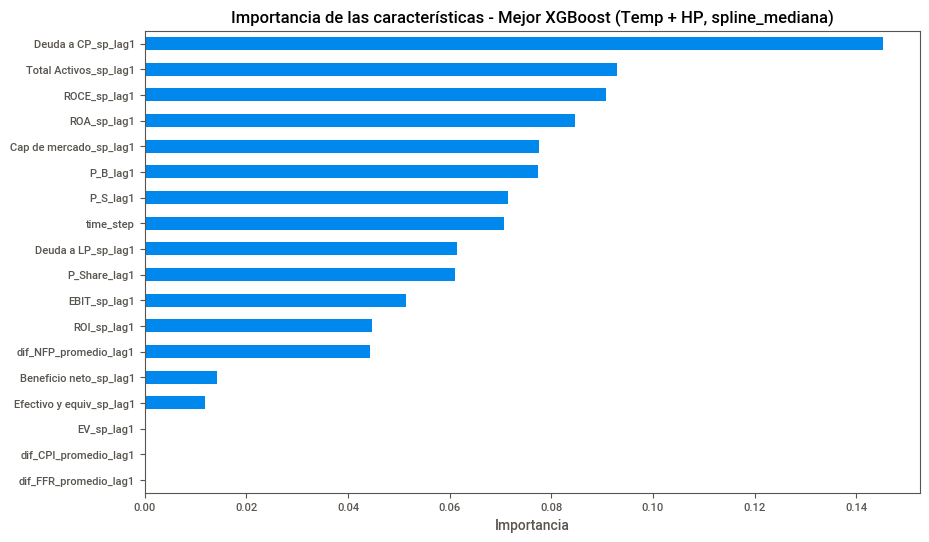

In [245]:
# Suponiendo que X_train_xgb_tv_hp_sorted es el conjunto de entrenamiento ordenado sin 'Empresa'
xgb_features = X_train_xgb_tv_hp_sorted.drop(columns=['Empresa'], errors='ignore').columns

importancias_xgb = pd.Series(best_pipeline.named_steps['xgb'].feature_importances_, index=xgb_features)

plt.figure(figsize=(10,6))
importancias_xgb.sort_values().plot(kind='barh')
plt.title("Importancia de las características - Mejor XGBoost (Temp + HP, spline_mediana)")
plt.xlabel("Importancia")
plt.show()

## Dlocal

In [246]:
# Cargar los datos desde el archivo Excel
file_path = 'C:/Users/Andy/OneDrive/Desktop/MCD/Tesis/Datos_fuente_Bloomberg/en valores/serie completa 2014-2024/Dataset/dataset_dlocal_casi sin vacías.xlsx'
df_dlocal = pd.read_excel(file_path, sheet_name='dataset')

In [247]:
# Quitar "k" de las columnas "Non farm payrolls_Exp_mediana" y "Non farm payrolls_Exp_promedio"
df_dlocal['Non farm payrolls_Exp_mediana'] = df_dlocal['Non farm payrolls_Exp_mediana'].astype(str).str.replace('k', '')
df_dlocal['Non farm payrolls_Exp_promedio'] = df_dlocal['Non farm payrolls_Exp_promedio'].astype(str).str.replace('k', '')

# Convertir las columnas a valores numéricos
df_dlocal['Non farm payrolls_Exp_mediana'] = pd.to_numeric(df_dlocal['Non farm payrolls_Exp_mediana'], errors='coerce')
df_dlocal['Non farm payrolls_Exp_promedio'] = pd.to_numeric(df_dlocal['Non farm payrolls_Exp_promedio'], errors='coerce')

In [248]:
# Convertir la columna de fecha a formato datetime
df_dlocal['Fecha'] = pd.to_datetime(df_dlocal['Fecha'], format='%Y%m%d')

# Extraer características temporales relevantes
df_dlocal['mes'] = df_dlocal['Fecha'].dt.month
df_dlocal['año'] = df_dlocal['Fecha'].dt.year
df_dlocal['periodo'] = df_dlocal['Fecha'].dt.to_period('M')

In [249]:
# Convertir CPI y Fed Funds Rate a decimales
df_dlocal['CPI'] = df_dlocal['CPI'] / 100
df_dlocal['Fed Funds Rate'] = df_dlocal['Fed Funds Rate'] / 100

In [250]:
# Calcular diferencias en puntos básicos
df_dlocal['dif_CPI_mediana'] = (df_dlocal['CPI'] - df_dlocal['CPI_Exp_mediana']) * 10000
df_dlocal['dif_CPI_promedio'] = (df_dlocal['CPI'] - df_dlocal['CPI_Exp_promedio']) * 10000

df_dlocal['dif_FFR_mediana'] = (df_dlocal['Fed Funds Rate'] - df_dlocal['Fed Funds Rate_Exp_mediana']) * 10000
df_dlocal['dif_FFR_promedio'] = (df_dlocal['Fed Funds Rate'] - df_dlocal['Fed Funds Rate_Exp_promedio']) * 10000

# Calcular diferencia
df_dlocal['dif_NFP_mediana'] = (df_dlocal['Non farm payrolls'] - df_dlocal['Non farm payrolls_Exp_mediana'])
df_dlocal['dif_NFP_promedio'] = (df_dlocal['Non farm payrolls'] - df_dlocal['Non farm payrolls_Exp_promedio'])

In [251]:
# Cargar el mejor modelo (XGBoost con validación temporal y búsqueda de hiperparámetros y método lineal_mediana)
loaded_best_pipeline = joblib.load("best_pipeline_model.pkl")

# Verificar que el objeto cargado es un pipeline y que el estimador XGBoost tiene feature_importances_
if not hasattr(loaded_best_pipeline, "named_steps"):
    raise ValueError("El objeto cargado para XGBoost no es un pipeline.")
if not hasattr(loaded_best_pipeline.named_steps['xgb'], 'feature_importances_'):
    raise ValueError("El modelo XGBoost no se cargó correctamente o no está ajustado.")

print("El modelo se cargó correctamente y está listo para predecir.")

El modelo se cargó correctamente y está listo para predecir.


In [252]:
# Crear un DataFrame para las columnas clave de df_dlocal
df_dlocal_shifted = df_dlocal[['Empresa', 'Fecha', 'P_E']].copy()

# Iterar sobre cada lista de columnas contenida en el diccionario
for key, columnas in listas_columnas.items():
    for col in columnas:
        if col != 'P_E' and col in df_dlocal.columns:
            df_dlocal_shifted[col + '_lag1'] = df_dlocal.groupby('Empresa')[col].shift(1)

# Definir la lista de columnas de lag (predictors)
predictors = [col for col in df_dlocal_shifted.columns if col.endswith('_lag1')]

# Imputar valores faltantes en las columnas de lag.
# En este caso, se espera que los NaN aparezcan en la primera fila de cada empresa.
# Se utiliza backfill para rellenar esos NaN con el valor de la fila siguiente dentro del mismo grupo.
df_dlocal_shifted[predictors] = df_dlocal_shifted.groupby('Empresa')[predictors].transform(lambda grp: grp.fillna(method='bfill'))

# Opcional: Verificar los resultados para una empresa en particular
df_dlocal_ejemplo = df_dlocal_shifted[df_dlocal_shifted['Empresa'] == "DLO US Equity"].copy()
print(df_dlocal_ejemplo.head())


         Empresa      Fecha       P_E  P_B_lag1  P_S_lag1  P_Share_lag1  \
0  DLO US Equity 2022-06-30  106.0041   27.6274   30.8739         26.25   
1  DLO US Equity 2022-07-29  112.1826   27.6274   30.8739         26.25   
2  DLO US Equity 2022-08-31  100.4313   29.2377   32.6734         27.78   
3  DLO US Equity 2022-09-30   82.8649   26.1750   29.2508         24.87   
4  DLO US Equity 2022-10-31   90.0530   21.5968   24.1346         20.52   

   ROCE_l_lag1  EBIT_l_lag1  Total Activos_l_lag1  Deuda a LP_l_lag1  ...  \
0    34.760000       35.092               710.704           3.376000  ...   
1    34.760000       35.092               710.704           3.376000  ...   
2    35.071967       35.805               751.996           3.400333  ...   
3    35.383933       36.518               793.288           3.424667  ...   
4    35.695900       37.231               834.580           3.449000  ...   

   ROA_sp_lag1  Beneficio neto_sp_lag1  ROI_sp_lag1   EV_sp_lag1  \
0    16.624400    

In [253]:
df_dlocal_shifted

Empresa      Fecha       P_E  P_B_lag1  P_S_lag1  P_Share_lag1  \
0   DLO US Equity 2022-06-30  106.0041   27.6274   30.8739        26.250   
1   DLO US Equity 2022-07-29  112.1826   27.6274   30.8739        26.250   
2   DLO US Equity 2022-08-31  100.4313   29.2377   32.6734        27.780   
3   DLO US Equity 2022-09-30   82.8649   26.1750   29.2508        24.870   
4   DLO US Equity 2022-10-31   90.0530   21.5968   24.1346        20.520   
5   DLO US Equity 2022-11-30   58.9585   23.4702   26.2281        22.300   
6   DLO US Equity 2022-12-30   62.8756   15.3661   17.1718        14.600   
7   DLO US Equity 2023-01-31   45.0720   16.3870   18.3126        15.570   
8   DLO US Equity 2023-02-28   40.5892   12.2724   11.7071        16.590   
9   DLO US Equity 2023-03-31   44.0667   11.0518   10.5427        14.940   
10  DLO US Equity 2023-04-28   38.0354   11.9987   11.4460        16.220   
11  DLO US Equity 2023-05-31   31.6237   10.3564    9.8794        14.000   
12  DLO US Equity 2023-06-30   33.1587    8.6106    8.2140        11.640   
13  DLO US Equity 2023-07-31   41.2141    9.0286    8.6127        12.205   
14  DLO US Equity 2023-08-31   58.2485   11.2219   10.7050        15.170   
15  DLO US Equity 2023-09-29   52.0814   15.8601   15.1296        21.440   
16  DLO US Equity 2023-10-31   45.7783   14.1809   13.5277        19.170   
17  DLO US Equity 2023-11-30   46.8651   12.4647   11.8906        16.850   
18  DLO US Equity 2023-12-29   48.0605   12.7606   12.1728        17.250   
19  DLO US Equity 2024-01-31   51.0837   13.0861   12.4833        17.690   
20  DLO US Equity 2024-02-29   52.8277   10.2516    7.2328        16.110   
21  DLO US Equity 2024-03-29   46.6127   10.6016    7.4797        16.660   
22  DLO US Equity 2024-04-30   45.0589    9.3543    6.5997        14.700   
23  DLO US Equity 2024-05-31   29.0140    9.0425    6.3797        14.210   
24  DLO US Equity 2024-06-28   25.6528    5.8226    4.1080         9.150   
25  DLO US Equity 2024-07-31   24.3527    5.1481    3.6321         8.090   
26  DLO US Equity 2024-08-30   28.2847    4.8872    3.4480         7.680   
27  DLO US Equity 2024-09-30   25.3674    5.6762    4.0047         8.920   

    ROCE_l_lag1  EBIT_l_lag1  Total Activos_l_lag1  Deuda a LP_l_lag1  ...  \
0     34.760000    35.092000            710.704000           3.376000  ...   
1     34.760000    35.092000            710.704000           3.376000  ...   
2     35.071967    35.805000            751.996000           3.400333  ...   
3     35.383933    36.518000            793.288000           3.424667  ...   
4     35.695900    37.231000            834.580000           3.449000  ...   
5     34.453267    33.654667            831.820333           3.430333  ...   
6     33.210633    30.078333            829.060667           3.411667  ...   
7     31.968000    26.502000            826.301000           3.393000  ...   
8     32.342033    30.787667            840.977667           3.367667  ...   
9     32.716067    35.073333            855.654333           3.342333  ...   
10    33.090100    39.359000            870.331000           3.317000  ...   
11    34.078333    42.161667            916.483333           3.308667  ...   
12    35.066567    44.964333            962.635667           3.300333  ...   
13    36.054800    47.767000           1008.788000           3.292000  ...   
14    35.564933    49.021333           1008.378667           3.364333  ...   
15    35.075067    50.275667           1007.969333           3.436667  ...   
16    34.585200    51.530000           1007.560000           3.509000  ...   
17    34.676533    48.020333           1033.191000           3.449667  ...   
18    34.767867    44.510667           1058.822000           3.390333  ...   
19    34.859200    41.001000           1084.453000           3.331000  ...   
20    33.196100    36.301000           1108.302000           3.275000  ...   
21    31.533000    31.601000           1132.151000           3.219000  ...   
22    29.86

In [254]:
print(df_dlocal_shifted.columns.tolist())

['Empresa', 'Fecha', 'P_E', 'P_B_lag1', 'P_S_lag1', 'P_Share_lag1', 'ROCE_l_lag1', 'EBIT_l_lag1', 'Total Activos_l_lag1', 'Deuda a LP_l_lag1', 'ROA_l_lag1', 'Beneficio neto_l_lag1', 'ROI_l_lag1', 'EV_l_lag1', 'Cap de mercado_l_lag1', 'Deuda a CP_l_lag1', 'Efectivo y equiv_l_lag1', 'dif_CPI_mediana_lag1', 'dif_FFR_mediana_lag1', 'dif_NFP_mediana_lag1', 'ROCE_sp_lag1', 'EBIT_sp_lag1', 'Total Activos_sp_lag1', 'Deuda a LP_sp_lag1', 'ROA_sp_lag1', 'Beneficio neto_sp_lag1', 'ROI_sp_lag1', 'EV_sp_lag1', 'Cap de mercado_sp_lag1', 'Deuda a CP_sp_lag1', 'Efectivo y equiv_sp_lag1', 'dif_CPI_promedio_lag1', 'dif_FFR_promedio_lag1', 'dif_NFP_promedio_lag1']


In [255]:
# Preparar el DataFrame de la nueva empresa
df_dlocal_spline_mediana = prepare_data(df_dlocal_shifted, columnas_numericas_spline_mediana)

In [256]:
# -------------------------------------------------------------------------------
# Predicción one‑step ahead retrospectiva y forecast para el siguiente período
# -------------------------------------------------------------------------------
#
# El conjunto de prueba (df_dlocal_spline_mediana) tiene 28 filas.
#
# Con este método one‑step ahead:
# - Para cada fila i (desde i = 1 hasta n_rows-1) se usa la fila i–1 para predecir el valor de P/E de la fila i.
#   Esto genera 27 predicciones retrospectivas.
# - Se re-etiquetan los períodos usando un offset definido en 93, de modo que:
#     * Para i = 1, el nuevo período es: 93 + 1 = 94.
#     * Para i = 27 (última predicción retrospectiva), el nuevo período es: 93 + 27 = 120.
# - Posteriormente, se predice el siguiente período (forecast) usando la última fila y se le asigna:
#     * nuevo período = 93 + 28 = 121.
# Así, en el backtest se tienen predicciones para los períodos 94 a 120 y, adicionalmente,
# se obtiene el forecast para el período 121.
# -------------------------------------------------------------------------------

# Definimos el offset: con offset = 93, se asignarán los nuevos períodos como se explicó.
offset = 93

n_rows = len(df_dlocal_spline_mediana)  # Se espera que n_rows == 28

periodos = []      # Aquí se almacenarán los nuevos números de período re-etiquetados
predicciones = []  # Aquí se guardarán las predicciones obtenidas
valores_reales = []  # Aquí se almacenarán los valores reales de P/E (cuando existan)

# Bucle retrospectivo:
# Para cada fila i (desde i = 1 hasta n_rows-1), se usa la fila i–1 para predecir el P/E de la fila i.
for i in range(1, n_rows):
    # Extraemos los features de la fila anterior (i–1), descartando 'P_E' y 'pred_P_E' (si existe)
    features = df_dlocal_spline_mediana.iloc[i-1].drop(labels=['P_E', 'pred_P_E'], errors='ignore')
    # Convertimos la Serie a DataFrame de una sola fila y aseguramos que todos los datos sean numéricos
    features_df = features.to_frame().T.apply(pd.to_numeric, errors='coerce')
    
    # Realizamos la predicción usando esos features
    pred = loaded_best_pipeline.predict(features_df)[0]
    predicciones.append(pred)
    
    # Asignamos el nuevo número de período:
    # Para i = 1, período = offset + 1 = 93 + 1 = 94;
    # para i = 2, período = 93 + 2 = 95; ...;
    # para i = 27, período = 93 + 27 = 120.
    periodos.append(offset + i)
    
    # Almacenamos el valor real de P/E de la fila i (el período correspondiente)
    valores_reales.append(df_dlocal_spline_mediana.iloc[i]['P_E'])

# Forecast para el siguiente período:
# Usamos la última fila (fila n_rows - 1) para predecir el P/E del período siguiente.
features_ultimo = df_dlocal_spline_mediana.iloc[-1].drop(labels=['P_E', 'pred_P_E'], errors='ignore')
features_ultimo_df = features_ultimo.to_frame().T.apply(pd.to_numeric, errors='coerce')
pronostico_next = loaded_best_pipeline.predict(features_ultimo_df)[0]

# Asignamos el nuevo número de período para el forecast:
# nuevo período = offset + n_rows = 93 + 28 = 121.
periodos.append(offset + n_rows)
predicciones.append(pronostico_next)
# No se agrega valor real para el forecast, ya que no se conoce.

# Creamos dos DataFrames:
# 1. Backtest: Contiene las predicciones retrospectivas para los períodos que tienen valor real,
# es decir, para períodos 94 a 120.
df_backtest = pd.DataFrame({
    'time_step': periodos[:-1],
    'pred_P_E': predicciones[:-1],
    'P_E_real': valores_reales
})

# 2. Forecast: Contiene la predicción para el siguiente período (121).
df_forecast = pd.DataFrame({
    'time_step': [periodos[-1]],
    'pred_P_E': [predicciones[-1]]
})

# Mostrar resultados:
print("Predicciones P/E de Dlocal con XGBoost (con validación temporal y búsqueda de hiperparámetros y método spline_mediana):")
print("\nResultados del backtest (predicciones retrospectivas):")
print(df_backtest)

print("\nPronóstico para el período siguiente (121):")
print(df_forecast)


Predicciones P/E de Dlocal con XGBoost (con validación temporal y búsqueda de hiperparámetros y método spline_mediana):

Resultados del backtest (predicciones retrospectivas):
    time_step   pred_P_E  P_E_real
0          94  60.769711  112.1826
1          95  60.769711  100.4313
2          96  61.590343   82.8649
3          97  60.769711   90.0530
4          98  60.769711   58.9585
5          99  60.769711   62.8756
6         100  59.802929   45.0720
7         101  60.769711   40.5892
8         102  53.659363   44.0667
9         103  50.552055   38.0354
10        104  53.659363   31.6237
11        105  41.609917   33.1587
12        106  34.937920   41.2141
13        107  36.589947   58.2485
14        108  50.371929   52.0814
15        109  55.906902   45.7783
16        110  55.906902   46.8651
17        111  53.549259   48.0605
18        112  53.549259   51.0837
19        113  53.549259   52.8277
20        114  33.219208   46.6127
21        115  33.219208   45.0589
22        116  33.2

In [257]:
# 1. Calcular desviación en porcentaje sobre la base P_E_real
df_backtest['desviacion_%'] = 100.0 * (df_backtest['pred_P_E'] - df_backtest['P_E_real']) / df_backtest['P_E_real']

# 2. Definir un umbral
umbral = 10.0

def calcular_estado_umbral(row, a):
    """
    Si la desviación_% es mayor que +a -> 'Subvaluada'
    Si la desviación_% es menor que -a -> 'Sobrevaluada'
    En caso contrario -> 'Neutra'
    """
    if pd.isna(row['desviacion_%']):
        return np.nan
    elif row['desviacion_%'] > a:
        return 'Subvaluada'
    elif row['desviacion_%'] < -a:
        return 'Sobrevaluada'
    else:
        return 'Neutra'

# 3. Crear una nueva columna con la clasificación
df_backtest['Estado_umbral'] = df_backtest.apply(lambda r: calcular_estado_umbral(r, umbral), axis=1)

# Mostrar el resultado
df_backtest[['time_step', 'pred_P_E', 'P_E_real', 'desviacion_%', 'Estado_umbral']]


time_step   pred_P_E  P_E_real  desviacion_% Estado_umbral
0          94  60.769711  112.1826    -45.829647  Sobrevaluada
1          95  60.769711  100.4313    -39.491264  Sobrevaluada
2          96  61.590343   82.8649    -25.673785  Sobrevaluada
3          97  60.769711   90.0530    -32.517839  Sobrevaluada
4          98  60.769711   58.9585      3.072009        Neutra
5          99  60.769711   62.8756     -3.349295        Neutra
6         100  59.802929   45.0720     32.683105    Subvaluada
7         101  60.769711   40.5892     49.718917    Subvaluada
8         102  53.659363   44.0667     21.768507    Subvaluada
9         103  50.552055   38.0354     32.907910    Subvaluada
10        104  53.659363   31.6237     69.680849    Subvaluada
11        105  41.609917   33.1587     25.487177    Subvaluada
12        106  34.937920   41.2141    -15.228236  Sobrevaluada
13        107  36.589947   58.2485    -37.183023  Sobrevaluada
14        108  50.371929   52.0814     -3.282306        Neutra
15        109  55.906902   45.7783     22.125335    Subvaluada
16        110  55.906902   46.8651     19.293253    Subvaluada
17        111  53.549259   48.0605     11.420520    Subvaluada
18        112  53.549259   51.0837      4.826509        Neutra
19        113  53.549259   52.8277      1.365873        Neutra
20        114  33.219208   46.6127    -28.733569  Sobrevaluada
21        115  33.219208   45.0589    -26.276035  Sobrevaluada
22        116  33.219208   29.0140     14.493719    Subvaluada
23        117  32.544704   25.6528     26.866090    Subvaluada
24        118  27.847303   24.3527     14.349963    Subvaluada
25        119  27.435438   28.2847     -3.002549        Neutra
26        120  27.323671   25.3674      7.711753        Neutra

##### **Problema: las primeras 6 predicciones son idénticas**

##### Es posible que, aunque solo las dos primeras filas sean idénticas, las siguientes tengan valores tan similares o caigan en el mismo rango de decisión del modelo que, al pasar por el pipeline (por ejemplo, tras alguna transformación o escalado), el modelo XGBoost las asigne a la misma hoja en los árboles y, por lo tanto, produzca la misma predicción.

##### En otras palabras, si las diferencias entre los features en esas primeras filas son muy pequeñas, el modelo podría interpretar que pertenecen a la misma “región” del espacio de predicción y asignarles el mismo valor de salida. Otra posibilidad es que alguna transformación dentro del pipeline (como la imputación o normalización) esté “suavizando” las variaciones en esos primeros registros.

##### Te recomiendo revisar detenidamente los valores de los features en esas filas para confirmar si realmente hay una variación significativa. También podrías analizar la salida intermedia del pipeline para ver cómo se transforman esos datos antes de la predicción.

##### Es bastante común que en un esquema de predicción “one‑step ahead” aparezcan varias predicciones iniciales iguales (o casi iguales) por alguno de estos motivos:

##### 1. **Las features resultan ser iguales o casi iguales para esas primeras filas.**  
#####   - Aun cuando visualmente veas diferencias en las columnas originales, es posible que, debido a la forma de generar los lags o de imputar valores nulos, en las primeras filas todas (o la mayoría) de las columnas que usa el modelo queden con los mismos valores.  
#####   - Un caso típico es cuando se usa `fillna(0)` o algún método de imputación que termina haciendo que esas filas tengan los mismos datos “válidos” (por ejemplo, si no había datos en los primeros periodos y se completaron con 0 o con la misma constante).

##### 2. **Se está pasando exactamente el mismo vector de features al modelo** (por un error en la forma de extraer la fila “i–1”).  
#####   - Asegúrate de imprimir las features que se usan en cada iteración. Por ejemplo:
#####     ```python
#####     for i in range(1, n_rows):
#####         features = df.iloc[i-1].drop([...])
#####         features_df = features.to_frame().T
#####         print(f"Fila {i}, features:")
#####         print(features_df)
#####         pred = model.predict(features_df)[0]
#####         ...
#####     ```
#####     De esta forma, confirmas si efectivamente las primeras 6 filas tienen valores distintos o no.  
#####   - A veces, un descuido en la indexación puede hacer que para i=1, i=2, i=3, etc., se termine usando siempre la misma fila anterior.

##### 3. **El modelo (XGBoost) termina asignando las primeras filas a la misma “hoja”** de los árboles porque las diferencias entre esas filas (para las columnas relevantes) no son lo suficientemente grandes para separar las predicciones.  
#####   - Si bien las filas difieren en columnas como `P_E` o `P_B`, puede que el modelo no use esas variables (o no las “valore” tanto) en los primeros nodos de decisión, resultando en la misma predicción.  
#####   - Esto puede ocurrir especialmente si las variables que sí diferencian a esos registros no tienen gran importancia para el modelo o están muy correlacionadas, de modo que no ayudan a separar los datos en nodos distintos.

##### En tu caso, lo más frecuente es la **combinación de (1) y (3)**:
##### - Revisar la imputación: si las primeras filas se rellenaron de modo que la mayoría de las variables queden iguales, es natural que el modelo devuelva la misma predicción.
##### - Verificar que realmente las features (después de aplicar lag y de soltar columnas) difieran para esas primeras filas.

##### **Cómo diagnosticarlo con seguridad:**

##### 1. **Imprime o revisa los features reales que se usan en cada predicción** (después de drop, lags, imputación, etc.). No te fíes solo de las columnas originales, sino de lo que realmente entra a `model.predict(...)`.
##### 2. **Revisa tu estrategia de imputación** en los primeros periodos (especialmente si usas `fillna(0)` u otra técnica que pueda aplanar las diferencias).

##### Si confirmas que las primeras filas efectivamente tienen los mismos valores de features, entonces el resultado idéntico del modelo es esperable. De lo contrario, si ves que los features son distintos pero el modelo sigue devolviendo el mismo valor, puede deberse a cómo XGBoost está “partiendo” esos datos en los árboles (lo cual es menos frecuente, pero posible si las diferencias no son relevantes para la predicción).

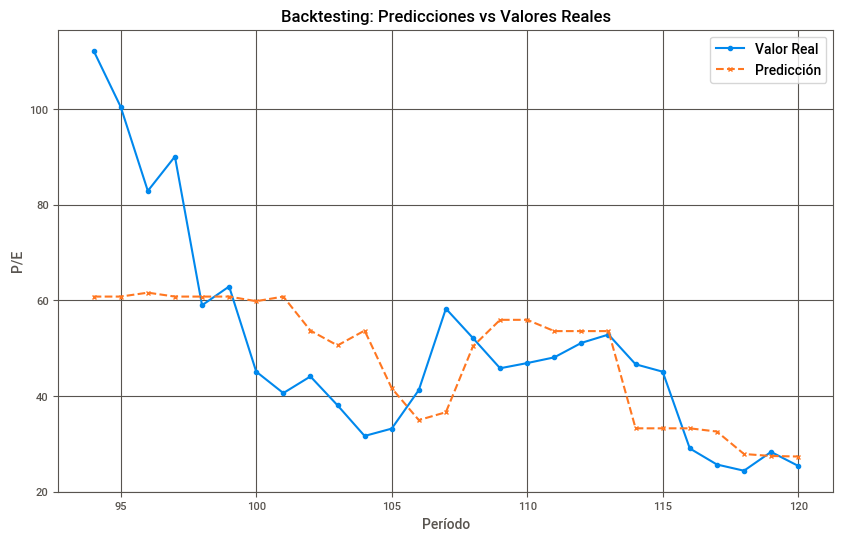

In [258]:
# Gráfico de las predicciones vs valores reales (backtesting)
plt.figure(figsize=(10,6))
plt.plot(df_backtest['time_step'], df_backtest['P_E_real'], marker='o', linestyle='-', label='Valor Real')
plt.plot(df_backtest['time_step'], df_backtest['pred_P_E'], marker='x', linestyle='--', label='Predicción')
plt.xlabel('Período')
plt.ylabel('P/E')
plt.title('Backtesting: Predicciones vs Valores Reales')
plt.legend()
plt.grid(True)
plt.show()


In [259]:
# Se asume que los valores reales para el backtest están en la columna 'P_E_real'
# y las predicciones en 'pred_P_E' del DataFrame df_backtest.
valores_reales_back = df_backtest['P_E_real'].values
predicciones_back = df_backtest['pred_P_E'].values

# Calcular las métricas para el backtest de XGBoost
mae_xgb = mean_absolute_error(valores_reales_back, predicciones_back)
rmse_xgb = np.sqrt(mean_squared_error(valores_reales_back, predicciones_back))
r2_xgb = r2_score(valores_reales_back, predicciones_back)

# Mostrar resultados
print("XGBoost - MAE:", mae_xgb, "RMSE:", rmse_xgb, "R2:", r2_xgb)


XGBoost - MAE: 12.339925255556457 RMSE: 17.318448358925572 R2: 0.3885574980924803


##### Tiene una mala performance al inicio del período, luego predice bien

In [260]:
umbral = 5.0

df_backtest['Estado_umbral'] = df_backtest.apply(lambda r: calcular_estado_umbral(r, umbral), axis=1)

# Mostrar el resultado
df_backtest[['time_step', 'pred_P_E', 'P_E_real', 'desviacion_%', 'Estado_umbral']]

time_step   pred_P_E  P_E_real  desviacion_% Estado_umbral
0          94  60.769711  112.1826    -45.829647  Sobrevaluada
1          95  60.769711  100.4313    -39.491264  Sobrevaluada
2          96  61.590343   82.8649    -25.673785  Sobrevaluada
3          97  60.769711   90.0530    -32.517839  Sobrevaluada
4          98  60.769711   58.9585      3.072009        Neutra
5          99  60.769711   62.8756     -3.349295        Neutra
6         100  59.802929   45.0720     32.683105    Subvaluada
7         101  60.769711   40.5892     49.718917    Subvaluada
8         102  53.659363   44.0667     21.768507    Subvaluada
9         103  50.552055   38.0354     32.907910    Subvaluada
10        104  53.659363   31.6237     69.680849    Subvaluada
11        105  41.609917   33.1587     25.487177    Subvaluada
12        106  34.937920   41.2141    -15.228236  Sobrevaluada
13        107  36.589947   58.2485    -37.183023  Sobrevaluada
14        108  50.371929   52.0814     -3.282306        Neutra
15        109  55.906902   45.7783     22.125335    Subvaluada
16        110  55.906902   46.8651     19.293253    Subvaluada
17        111  53.549259   48.0605     11.420520    Subvaluada
18        112  53.549259   51.0837      4.826509        Neutra
19        113  53.549259   52.8277      1.365873        Neutra
20        114  33.219208   46.6127    -28.733569  Sobrevaluada
21        115  33.219208   45.0589    -26.276035  Sobrevaluada
22        116  33.219208   29.0140     14.493719    Subvaluada
23        117  32.544704   25.6528     26.866090    Subvaluada
24        118  27.847303   24.3527     14.349963    Subvaluada
25        119  27.435438   28.2847     -3.002549        Neutra
26        120  27.323671   25.3674      7.711753    Subvaluada

In [261]:
umbral = 2.5

df_backtest['Estado_umbral'] = df_backtest.apply(lambda r: calcular_estado_umbral(r, umbral), axis=1)

# Mostrar el resultado
df_backtest[['time_step', 'pred_P_E', 'P_E_real', 'desviacion_%', 'Estado_umbral']]

time_step   pred_P_E  P_E_real  desviacion_% Estado_umbral
0          94  60.769711  112.1826    -45.829647  Sobrevaluada
1          95  60.769711  100.4313    -39.491264  Sobrevaluada
2          96  61.590343   82.8649    -25.673785  Sobrevaluada
3          97  60.769711   90.0530    -32.517839  Sobrevaluada
4          98  60.769711   58.9585      3.072009    Subvaluada
5          99  60.769711   62.8756     -3.349295  Sobrevaluada
6         100  59.802929   45.0720     32.683105    Subvaluada
7         101  60.769711   40.5892     49.718917    Subvaluada
8         102  53.659363   44.0667     21.768507    Subvaluada
9         103  50.552055   38.0354     32.907910    Subvaluada
10        104  53.659363   31.6237     69.680849    Subvaluada
11        105  41.609917   33.1587     25.487177    Subvaluada
12        106  34.937920   41.2141    -15.228236  Sobrevaluada
13        107  36.589947   58.2485    -37.183023  Sobrevaluada
14        108  50.371929   52.0814     -3.282306  Sobrevaluada
15        109  55.906902   45.7783     22.125335    Subvaluada
16        110  55.906902   46.8651     19.293253    Subvaluada
17        111  53.549259   48.0605     11.420520    Subvaluada
18        112  53.549259   51.0837      4.826509    Subvaluada
19        113  53.549259   52.8277      1.365873        Neutra
20        114  33.219208   46.6127    -28.733569  Sobrevaluada
21        115  33.219208   45.0589    -26.276035  Sobrevaluada
22        116  33.219208   29.0140     14.493719    Subvaluada
23        117  32.544704   25.6528     26.866090    Subvaluada
24        118  27.847303   24.3527     14.349963    Subvaluada
25        119  27.435438   28.2847     -3.002549  Sobrevaluada
26        120  27.323671   25.3674      7.711753    Subvaluada

# Clustering (No supervisado) y entrenamiento RF y XGBoost (Supervisado)

##### **¿Vale la pena probar los diferentes métodos o quedarnos con spline_mediana?**

##### La decisión depende de cuánto confíes en los resultados previos y de los recursos (tiempo, complejidad) que estés dispuesto a invertir en seguir evaluando otras alternativas. Aquí tienes algunas consideraciones:

##### 1. **Resultados Previos Sólidos:**  
  ##### Si en la sección anterior las pruebas con validación temporal y búsqueda de hiperparámetros demostraron de forma consistente que el conjunto de predictores **spline_mediana** combinado con XGBoost es el que mejor desempeño tiene (por ejemplo, en términos de RMSE, MAE, R² u otras métricas relevantes), existe un argumento fuerte para continuar usando **spline_mediana** en la sección de clustering y entrenamiento supervisado.

##### 2. **Consistencia del Pipeline:**  
  ##### Si ya has optimizado y afinado el pipeline para **spline_mediana** y consideras que el proceso de preprocesamiento, generación de características y entrenamiento es robusto, utilizar ese mismo método te permite mantener la consistencia a lo largo del proyecto.

##### 3. **Complejidad y Tiempo:**  
  ##### Probar múltiples métodos (lineal_mediana, lineal_promedio, spline_mediana, spline_promedio) en cada etapa puede aumentar significativamente la complejidad y el tiempo de entrenamiento. Si ya tienes evidencia de que **spline_mediana** es el mejor, centrarte en él puede simplificar el flujo y facilitar la interpretación de los resultados, sin comprometer la calidad final del modelo.

##### 4. **Confirmación en Contextos Diferentes:**  
  ##### Una posible razón para seguir evaluando otros métodos en la sección de clustering sería si sospechas que la estructura de los clústeres o la relación entre las características podría variar en el contexto del clustering y la segmentación. Sin embargo, si los clústeres se generan a partir de los mismos datos preprocesados y la evidencia previa es robusta, es razonable optar por el método ganador.

##### ---

##### **Recomendación final:**  
##### Dado que ya determinaste que XGBoost con **spline_mediana** es el mejor modelo en la fase de validación temporal y búsqueda de hiperparámetros, lo más eficiente y coherente es continuar usando **spline_mediana** en la sección de clustering y entrenamiento supervisado. Esto te permitirá:

##### - Reducir la complejidad y el tiempo de cómputo.
##### - Mantener un flujo coherente y consistente en todo el proyecto.
##### - Centrarte en optimizar y entender a fondo el pipeline que ya ha demostrado un buen desempeño.

##### Si en algún momento tienes recursos adicionales o encuentras indicios de que el contexto de clustering podría alterar la relevancia de las características, podrías considerar una evaluación piloto de los otros métodos. Pero, en base a la evidencia actual, quedarte con **spline_mediana** es una decisión razonable.

In [262]:
# -------------------------------
# 1. Preparación de los Datos
# -------------------------------

print("\nFiltrando columnas rezagadas y manejando valores faltantes...")

# Crear listas de columnas rezagadas (excluyendo 'P_E')
predictors_spline_mediana = [col + '_lag1' for col in columnas_numericas_spline_mediana if col != 'P_E']

# Verificar que las columnas rezagadas existen en el DataFrame
missing_columns = [col for col in predictors_spline_mediana if col not in df_shifted.columns]
if missing_columns:
    raise ValueError(f"Las siguientes columnas rezagadas no se encuentran en 'df_shifted': {missing_columns}")

# Crear un DataFrame con las columnas seleccionadas y la columna objetivo, incluyendo 'Empresa' y 'Fecha'
df_model_spline_mediana = df_shifted[['Empresa', 'Fecha', 'P_E'] + predictors_spline_mediana].copy()

# Identificar columnas numéricas y no numéricas
columnas_numericas = df_model_spline_mediana.select_dtypes(include=[np.number]).columns
columnas_no_numericas = df_model_spline_mediana.select_dtypes(exclude=[np.number]).columns

print("\nColumnas numéricas:")
print(columnas_numericas.tolist())

print("\nColumnas no numéricas:")
print(columnas_no_numericas.tolist())

# Rellenar valores faltantes solo en columnas numéricas con la media
print("\nRellenando valores faltantes en columnas numéricas con la media...")
df_model_spline_mediana[columnas_numericas] = df_model_spline_mediana[columnas_numericas].fillna(df_model_spline_mediana[columnas_numericas].mean())

# Verificar si aún hay valores faltantes en columnas numéricas
print("\nValores faltantes en columnas numéricas después del relleno:")
print(df_model_spline_mediana[columnas_numericas].isnull().sum())

# Manejar valores faltantes en columnas no numéricas
# Opción 1: Eliminar filas con NaN en columnas no numéricas
print("\nEliminando filas con valores faltantes en columnas no numéricas...")
df_model_spline_mediana.dropna(subset=columnas_no_numericas, inplace=True)

# Opción 2: Rellenar con la moda
# print("\nRellenando valores faltantes en columnas no numéricas con la moda...")
# for col in columnas_no_numericas:
#     if df_model_spline_mediana[col].isnull().sum() > 0:
#         moda = df_model_spline_mediana[col].mode()[0]
#         df_model_spline_mediana[col].fillna(moda, inplace=True)

# Verificar si aún hay valores faltantes en columnas no numéricas
print("\nValores faltantes en columnas no numéricas después de manejar NaN:")
print(df_model_spline_mediana[columnas_no_numericas].isnull().sum())

# 2.1 Crear una Variable de Orden Temporal (`time_step`)
print("\nCreando la variable 'time_step' para mantener el orden temporal por empresa...")
df_model_spline_mediana['time_step'] = df_model_spline_mediana.groupby('Empresa').cumcount() + 1

# Verificar la creación de 'time_step'
print("\nPrimeras filas con 'time_step':")
print(df_model_spline_mediana[['Empresa', 'time_step']].head(15))



Filtrando columnas rezagadas y manejando valores faltantes...

Columnas numéricas:
['P_E', 'P_B_lag1', 'P_S_lag1', 'P_Share_lag1', 'ROCE_sp_lag1', 'EBIT_sp_lag1', 'Total Activos_sp_lag1', 'Deuda a LP_sp_lag1', 'ROA_sp_lag1', 'Beneficio neto_sp_lag1', 'ROI_sp_lag1', 'EV_sp_lag1', 'Cap de mercado_sp_lag1', 'Deuda a CP_sp_lag1', 'Efectivo y equiv_sp_lag1', 'dif_CPI_mediana_lag1', 'dif_FFR_mediana_lag1', 'dif_NFP_mediana_lag1']

Columnas no numéricas:
['Empresa', 'Fecha']

Rellenando valores faltantes en columnas numéricas con la media...

Valores faltantes en columnas numéricas después del relleno:
P_E                         0
P_B_lag1                    0
P_S_lag1                    0
P_Share_lag1                0
ROCE_sp_lag1                0
EBIT_sp_lag1                0
Total Activos_sp_lag1       0
Deuda a LP_sp_lag1          0
ROA_sp_lag1                 0
Beneficio neto_sp_lag1      0
ROI_sp_lag1                 0
EV_sp_lag1                  0
Cap de mercado_sp_lag1      0
Deuda 

In [263]:
# -------------------------------
# 2. División de los Datos
# -------------------------------
print("\nDividiendo los datos en conjuntos de entrenamiento y prueba...")

# Definir las características (`X`) y la variable objetivo (`y`)
X = df_model_spline_mediana.drop(columns=['P_E'])
y = df_model_spline_mediana['P_E']

# Definir el número de empresas para el conjunto de prueba (20% del total)
total_empresas = df_model_spline_mediana['Empresa'].nunique()
n_empresas_prueba = int(total_empresas * 0.2)
print(f"\nNúmero total de empresas: {total_empresas}")
print(f"Número de empresas para prueba (20%): {n_empresas_prueba}")

# Obtener las empresas únicas
empresas_unicas = df_model_spline_mediana['Empresa'].unique()

# Dividir las empresas en entrenamiento y prueba
empresas_entrenamiento, empresas_prueba = train_test_split(empresas_unicas, test_size=n_empresas_prueba, random_state=42)

print(f"\nEmpresas en entrenamiento: {len(empresas_entrenamiento)}")
print(f"Empresas en prueba: {len(empresas_prueba)}")

# Crear máscaras para entrenamiento y prueba
mask_entrenamiento = df_model_spline_mediana['Empresa'].isin(empresas_entrenamiento)
mask_prueba = df_model_spline_mediana['Empresa'].isin(empresas_prueba)

# Dividir los datos
X_train = X[mask_entrenamiento].copy()
y_train = y[mask_entrenamiento].copy()
groups_train = X_train['Empresa'].copy()

X_test = X[mask_prueba].copy()
y_test = y[mask_prueba].copy()
groups_test = X_test['Empresa'].copy()

print(f"\nTamaño de entrenamiento: {X_train.shape}")
print(f"Tamaño de prueba: {X_test.shape}")



Dividiendo los datos en conjuntos de entrenamiento y prueba...

Número total de empresas: 157
Número de empresas para prueba (20%): 31

Empresas en entrenamiento: 126
Empresas en prueba: 31

Tamaño de entrenamiento: (15120, 20)
Tamaño de prueba: (3720, 20)



Realizando clustering en el conjunto de entrenamiento...

Preparando datos para clustering...

Columnas utilizadas para clustering en entrenamiento:
['P_B_lag1', 'P_S_lag1', 'P_Share_lag1', 'ROCE_sp_lag1', 'EBIT_sp_lag1', 'Total Activos_sp_lag1', 'Deuda a LP_sp_lag1', 'ROA_sp_lag1', 'Beneficio neto_sp_lag1', 'ROI_sp_lag1', 'EV_sp_lag1', 'Cap de mercado_sp_lag1', 'Deuda a CP_sp_lag1', 'Efectivo y equiv_sp_lag1', 'dif_CPI_mediana_lag1', 'dif_FFR_mediana_lag1', 'dif_NFP_mediana_lag1']

Escalando características para clustering...
Empresas: 126, Fechas por empresa: 120, Características: 17
Forma del array para clustering (3D): (126, 120, 17)

Determinando el número óptimo de clusters usando Silhouette y Método del Codo...

Calculando para n_clusters = 2
Silhouette Score para n_clusters = 2: 0.34914902026964667
Inercia para n_clusters = 85.13037813599405

Calculando para n_clusters = 3
Silhouette Score para n_clusters = 3: 0.25161729435347796
Inercia para n_clusters = 71.32648566766781

Ca

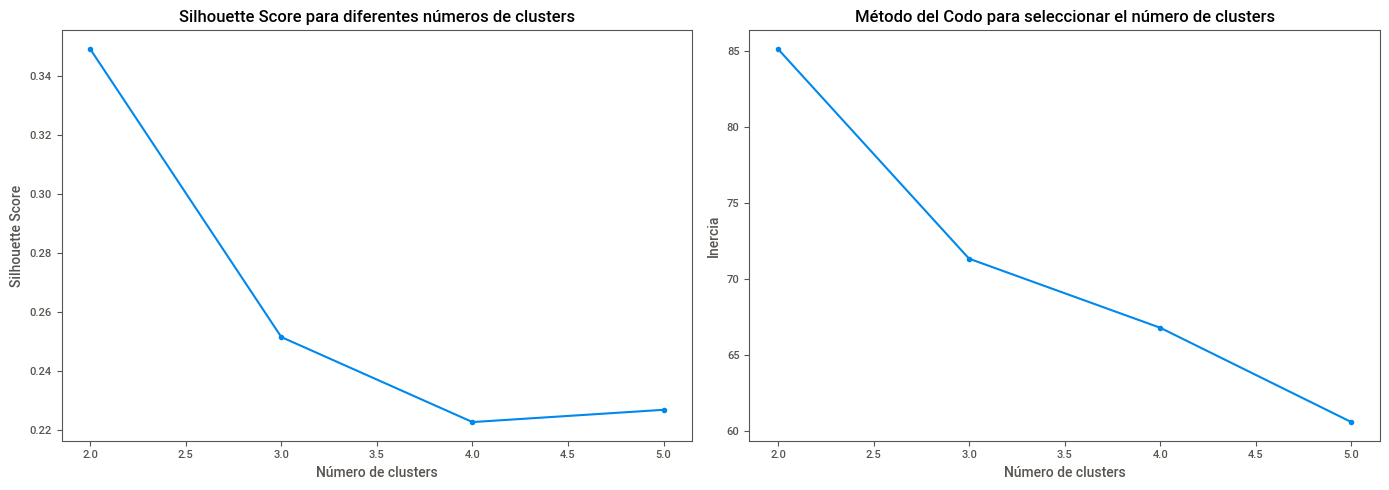

In [264]:
# -------------------------------
# 3. Clustering en el Conjunto de Entrenamiento
# -------------------------------
print("\nRealizando clustering en el conjunto de entrenamiento...")

# 3.1 Preparar los datos para clustering
print("\nPreparando datos para clustering...")
# Excluir columnas no necesarias para clustering (como 'Empresa', 'Fecha' y 'time_step')
df_features_train = X_train.drop(columns=['Empresa', 'Fecha', 'time_step'])

print("\nColumnas utilizadas para clustering en entrenamiento:")
print(df_features_train.columns.tolist())

# No hacemos fit_transform todavía. Primero determinamos num_fechas
num_empresas = len(empresas_entrenamiento)
num_fechas = X_train.groupby('Empresa').size().min()  
if num_fechas is None or num_fechas == 0:
    raise ValueError("No hay suficientes observaciones para formar series temporales.")

# Seleccionar solo 'num_fechas' por empresa para asegurar consistencia temporal
df_features_train = X_train.groupby('Empresa').head(num_fechas).drop(columns=['Empresa', 'Fecha', 'time_step'])

X_features_train = df_features_train.values

# Ahora que tenemos los datos finales para el clustering, podemos ajustar el escalador
print("\nEscalando características para clustering...")
scaler_ts = TimeSeriesScalerMeanVariance()
X_scaled_2D = scaler_ts.fit_transform(X_features_train)

# Guardar el escalador ajustado
joblib.dump(scaler_ts, 'scaler_ts.joblib')

# Determinar num_features
num_features = X_scaled_2D.shape[1]
print(f"Empresas: {num_empresas}, Fechas por empresa: {num_fechas}, Características: {num_features}")

# Verificar dimensiones
if X_scaled_2D.shape[0] < num_empresas * num_fechas:
    raise ValueError("El número de filas es menor que num_empresas * num_fechas. Revisa los datos de entrenamiento.")

# Reshape a formato 3D
X_scaled_3D = X_scaled_2D.reshape(num_empresas, num_fechas, num_features)
print(f"Forma del array para clustering (3D): {X_scaled_3D.shape}")

# 3.4 Determinar el número óptimo de clusters usando Silhouette y Método del Codo
print("\nDeterminando el número óptimo de clusters usando Silhouette y Método del Codo...")
silhouette_scores = []
inertia = []
range_n_clusters = list(range(2, 6))

for n_clusters in range_n_clusters:
    print(f"\nCalculando para n_clusters = {n_clusters}")
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled_3D)
    
    # Calcular el Silhouette Score
    score = ts_silhouette_score(X_scaled_3D, cluster_labels, metric="dtw")
    silhouette_scores.append(score)
    print(f"Silhouette Score para n_clusters = {n_clusters}: {score}")
    
    # Guardar la inercia
    inertia.append(kmeans.inertia_)
    print(f"Inercia para n_clusters = {kmeans.inertia_}")

# Graficar los resultados
print("\nGraficando Silhouette Score y Método del Codo...")
plt.figure(figsize=(14, 5))

# Silhouette Score
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score para diferentes números de clusters')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')

# Método del Codo
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método del Codo para seleccionar el número de clusters')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')

plt.tight_layout()
plt.show()


##### A partir de la gráfica de *silhouette* se ve claramente que el valor más alto (y por tanto mejor separación relativa de los grupos) se alcanza con \(k=2\). Sin embargo, la gráfica del “codo” (inercia) sugiere que los descensos más pronunciados se dan al pasar de 2 a 3 y de 3 a 4 clusters, siendo el de 2 a 3 algo más marcado.

##### En la práctica, elegir \(k=2\) muchas veces puede resultar demasiado simple (solo dos grupos grandes). Con \(k=3\) se sigue teniendo un buen *silhouette* (alrededor de 0.3) y una inercia sustancialmente menor que con \(k=2\). Si aumentamos a 4 o 5, la mejora en inercia existe pero el *silhouette* baja todavía más, lo que indica que los grupos empiezan a solaparse o a ser menos “compactos”.

##### Por ello, normalmente se toma \(k=3\) como un buen compromiso entre la separación de los clusters (*silhouette* razonable) y la reducción de inercia, puesto que:
##### - El *silhouette* sigue siendo relativamente alto (no tan bueno como con 2, pero aceptable).  
##### - Se aprecia un “codo” notable entre 2 y 3 en la gráfica de inercia, indicando una mejora importante en la agrupación.

##### En resumen, con estos datos lo más habitual sería quedarse con 3 clusters, **aunque la elección final también depende del contexto del problema y de la interpretación de cada cluster**.

In [265]:
# Seleccionar el número óptimo de clusters basado en los gráficos
optimal_n_clusters = 4
print(f"\nNúmero óptimo de clusters seleccionado: {optimal_n_clusters}")

# 3.5 Re-entrenar el modelo de clustering con el número óptimo de clusters
print("\nRe-entrenando el modelo de clustering con el número óptimo de clusters...")
kmeans_optimal = TimeSeriesKMeans(n_clusters=optimal_n_clusters, metric="dtw", random_state=42)
#kmeans_optimal = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", metric_params={"gamma": 10}, random_state=42)

optimal_labels_train = kmeans_optimal.fit_predict(X_scaled_3D)

# Guardar el modelo de clustering entrenado con el número óptimo de clústeres
joblib.dump(kmeans_optimal, "kmeans.joblib")

print("\nCluster labels para el conjunto de entrenamiento:")
print(optimal_labels_train)

# Asignar los clústeres a las empresas de entrenamiento
df_empresas_clusters_train = pd.DataFrame({
    'Empresa': empresas_entrenamiento,
    'Cluster': optimal_labels_train
})

print("\nEmpresas y sus Clusters en entrenamiento:")
print(df_empresas_clusters_train.head())



Número óptimo de clusters seleccionado: 4

Re-entrenando el modelo de clustering con el número óptimo de clusters...

Cluster labels para el conjunto de entrenamiento:
[1 3 1 3 3 1 1 3 2 2 3 2 3 2 2 2 3 3 2 2 1 3 2 2 2 1 1 2 2 1 2 1 1 3 2 2 2
 1 2 3 2 3 2 1 1 1 1 1 2 1 1 1 2 3 3 1 2 2 2 1 3 3 2 2 2 2 1 2 1 2 3 0 1 1
 2 1 1 1 1 1 2 2 1 3 2 2 1 1 3 3 2 3 3 2 1 1 1 0 0 3 2 2 0 3 1 2 2 1 2 1 3
 1 2 1 2 2 1 2 1 2 3 3 1 3 1 3]

Empresas y sus Clusters en entrenamiento:
           Empresa  Cluster
0    KDP US Equity        1
1   STLD US Equity        3
2   ROCK US Equity        1
3  RUSHB US Equity        3
4   LULU US Equity        3


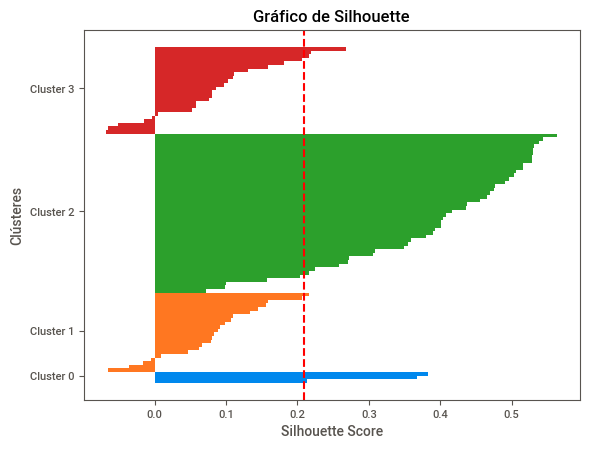

In [266]:
# -------------------------------
# 4. Gráfico de Silueta
# -------------------------------

def plot_silhouette(X, labels, n_clusters):
    """
    Genera un gráfico de análisis de Silhouette para evaluar los clústeres.
    """
    # Convertir X a 2D
    X_2d = X.reshape(X.shape[0], -1)
    silhouette_vals = silhouette_samples(X_2d, labels)
    y_lower, y_upper = 0, 0
    yticks = []
    
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        yticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)
    
    plt.axvline(np.mean(silhouette_vals), color="red", linestyle="--")  # Promedio
    plt.yticks(yticks, [f"Cluster {i}" for i in range(n_clusters)])
    plt.xlabel("Silhouette Score")
    plt.ylabel("Clústeres")
    plt.title("Gráfico de Silhouette")
    plt.show()


plot_silhouette(X_scaled_3D, cluster_labels, optimal_n_clusters)

In [267]:
# -------------------------------
# 5. Asignación de Clústeres al Conjunto de Prueba
# -------------------------------
print("\nAsignando clústeres al conjunto de prueba...")

# 5.1 Preparar los datos de prueba para clustering
print("\nPreparando datos de prueba para clustering...")
# Definir el número de fechas por empresa en test
num_fechas_test = X_test.groupby('Empresa').size().min()  # Asegurar consistencia
print(f"Número de fechas por empresa en test: {num_fechas_test}")

# Seleccionar solo 'num_fechas_test' por empresa para evitar inconsistencias
df_features_test = X_test.groupby('Empresa').head(num_fechas_test).drop(columns=['Empresa', 'Fecha', 'time_step'])
X_features_test = df_features_test.values

# Escalar usando el mismo scaler de entrenamiento
print("\nEscalando datos de prueba...")
X_scaled_test_2D = scaler_ts.transform(X_features_test)

# Determinar el número de empresas y verificar
num_empresas_test = len(empresas_prueba)
num_features_test = X_scaled_test_2D.shape[1]

print(f"Empresas en prueba: {num_empresas_test}, Características: {num_features_test}")

# Verificar que el número de filas es suficiente para el reshape
if X_scaled_test_2D.shape[0] < num_empresas_test * num_fechas_test:
    raise ValueError("El número de filas en test es menor que num_empresas_test * num_fechas_test. Asegúrate de que cada empresa tenga al menos 'num_fechas_test' observaciones.")

# Reshape a 3D
print("\nReshape de los datos de prueba a formato 3D para clustering...")
X_scaled_test_3D = X_scaled_test_2D.reshape(num_empresas_test, num_fechas_test, num_features_test)
print(f"Forma del array para clustering en test (3D): {X_scaled_test_3D.shape}")

# 5.2 Asignar clústeres a las empresas de prueba usando el modelo de clustering entrenado
print("\nAsignando clústeres a las empresas de prueba...")
optimal_labels_test = kmeans_optimal.predict(X_scaled_test_3D)

# Asignar los clústeres a las empresas de prueba
df_empresas_clusters_test = pd.DataFrame({
    'Empresa': empresas_prueba,
    'Cluster': optimal_labels_test
})

print("\nEmpresas y sus Clusters en prueba:")
print(df_empresas_clusters_test.head())



Asignando clústeres al conjunto de prueba...

Preparando datos de prueba para clustering...
Número de fechas por empresa en test: 120

Escalando datos de prueba...
Empresas en prueba: 31, Características: 17

Reshape de los datos de prueba a formato 3D para clustering...
Forma del array para clustering en test (3D): (31, 120, 17)

Asignando clústeres a las empresas de prueba...

Empresas y sus Clusters en prueba:
          Empresa  Cluster
0  SANM US Equity        1
1  FFIV US Equity        1
2   SFM US Equity        2
3  SNEX US Equity        1
4  PLAB US Equity        1


In [268]:
# -------------------------------
# 6. Fusionar Clústeres con los Datos Originales
# -------------------------------
print("\nFusionando clústeres con los datos originales...")

# 6.1 Añadir la columna 'Cluster' al conjunto de entrenamiento
print("\nAñadiendo 'Cluster' al conjunto de entrenamiento...")
df_model_train = X_train.merge(df_empresas_clusters_train, on='Empresa').reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
df_model_train['Cluster'] = df_model_train['Cluster'].astype(int)

# 6.2 Añadir la columna 'Cluster' al conjunto de prueba
print("\nAñadiendo 'Cluster' al conjunto de prueba...")
df_model_test = X_test.merge(df_empresas_clusters_test, on='Empresa').reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
df_model_test['Cluster'] = df_model_test['Cluster'].astype(int)

# Verificar valores NaN después del merge
print("\nValores NaN en el conjunto de entrenamiento después del merge:")
print(df_model_train.isnull().sum())

print("\nValores NaN en el conjunto de prueba después del merge:")
print(df_model_test.isnull().sum())



Fusionando clústeres con los datos originales...

Añadiendo 'Cluster' al conjunto de entrenamiento...

Añadiendo 'Cluster' al conjunto de prueba...

Valores NaN en el conjunto de entrenamiento después del merge:
Empresa                     0
Fecha                       0
P_B_lag1                    0
P_S_lag1                    0
P_Share_lag1                0
ROCE_sp_lag1                0
EBIT_sp_lag1                0
Total Activos_sp_lag1       0
Deuda a LP_sp_lag1          0
ROA_sp_lag1                 0
Beneficio neto_sp_lag1      0
ROI_sp_lag1                 0
EV_sp_lag1                  0
Cap de mercado_sp_lag1      0
Deuda a CP_sp_lag1          0
Efectivo y equiv_sp_lag1    0
dif_CPI_mediana_lag1        0
dif_FFR_mediana_lag1        0
dif_NFP_mediana_lag1        0
time_step                   0
Cluster                     0
dtype: int64

Valores NaN en el conjunto de prueba después del merge:
Empresa                     0
Fecha                       0
P_B_lag1                   


Generando gráfico de distribución de clústeres en entrenamiento y prueba...


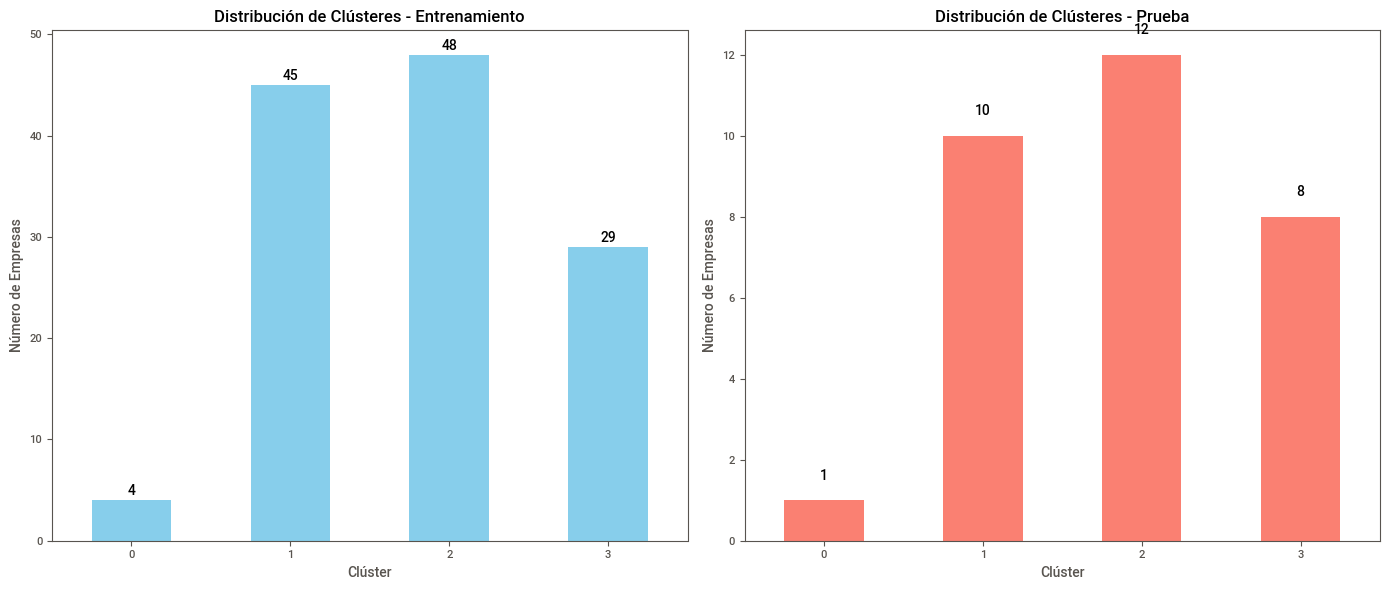

In [269]:
# -------------------------------
# 7. Gráfico de Distribución de Clústeres
# -------------------------------
print("\nGenerando gráfico de distribución de clústeres en entrenamiento y prueba...")

# Calcular la cantidad de empresas por cluster en entrenamiento
clusters_entrenamiento_counts = df_empresas_clusters_train['Cluster'].value_counts().sort_index()

# Calcular la cantidad de empresas por cluster en prueba
clusters_prueba_counts = df_empresas_clusters_test['Cluster'].value_counts().sort_index()

# Configurar el tamaño de la figura
plt.figure(figsize=(14, 6))

# Subgráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
clusters_entrenamiento_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clústeres - Entrenamiento')
plt.xlabel('Clúster')
plt.ylabel('Número de Empresas')
plt.xticks(rotation=0)
for index, value in enumerate(clusters_entrenamiento_counts):
    plt.text(index, value + 0.5, str(value), ha='center')

# Subgráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
clusters_prueba_counts.plot(kind='bar', color='salmon')
plt.title('Distribución de Clústeres - Prueba')
plt.xlabel('Clúster')
plt.ylabel('Número de Empresas')
plt.xticks(rotation=0)
for index, value in enumerate(clusters_prueba_counts):
    plt.text(index, value + 0.5, str(value), ha='center')

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()


In [270]:
# -------------------------------
# 8. Escalado de Características para Modelos Supervisados
# -------------------------------
print("\nEscalando características para modelos supervisados...")

# Definir las características para el modelo supervisado (excluir 'Empresa', 'Fecha' y 'Cluster')
features = [col for col in df_model_train.columns if col not in ['Empresa', 'Fecha', 'Cluster']]

# Opcional: Si decides incluir 'time_step' en los modelos supervisados, mantenlo en las características
# features += ['time_step']

print(f"\nCaracterísticas seleccionadas para modelos supervisados: {features}")

# 8.1 Escalar las características usando StandardScaler
print("\nEscalando características con StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_model_train[features])
X_test_scaled = scaler.transform(df_model_test[features])

# Guardar el escalador para uso futuro
joblib.dump(scaler, "scaler.joblib")
print("\nEscalador guardado como 'scaler.joblib'")



Escalando características para modelos supervisados...

Características seleccionadas para modelos supervisados: ['P_B_lag1', 'P_S_lag1', 'P_Share_lag1', 'ROCE_sp_lag1', 'EBIT_sp_lag1', 'Total Activos_sp_lag1', 'Deuda a LP_sp_lag1', 'ROA_sp_lag1', 'Beneficio neto_sp_lag1', 'ROI_sp_lag1', 'EV_sp_lag1', 'Cap de mercado_sp_lag1', 'Deuda a CP_sp_lag1', 'Efectivo y equiv_sp_lag1', 'dif_CPI_mediana_lag1', 'dif_FFR_mediana_lag1', 'dif_NFP_mediana_lag1', 'time_step']

Escalando características con StandardScaler...

Escalador guardado como 'scaler.joblib'


In [271]:
# -------------------------------
# 9. Definición de la Función de Entrenamiento
# -------------------------------
def entrenar_evaluar_modelos_por_cluster(
    df_train, y_train, df_test, y_test,
    cluster_labels_train, cluster_labels_test,
    param_grid_rf, param_grid_xgb,
    model_type='rf', n_iter=10
):
    """
    Entrena y evalúa múltiples modelos por clúster con búsqueda de hiperparámetros.

    Parameters:
    - df_train: DataFrame de entrenamiento escalado.
    - y_train: Series de la variable objetivo de entrenamiento.
    - df_test: DataFrame de prueba escalado.
    - y_test: Series de la variable objetivo de prueba.
    - cluster_labels_train: Series con las etiquetas de clúster para entrenamiento.
    - cluster_labels_test: Series con las etiquetas de clúster para prueba.
    - param_grid_rf: Diccionario con los hiperparámetros para Random Forest.
    - param_grid_xgb: Diccionario con los hiperparámetros para XGBoost.
    - model_type: 'rf' para Random Forest, 'xgb' para XGBoost.
    - n_iter: Número de iteraciones para RandomizedSearchCV.

    Returns:
    - DataFrame con los resultados de los modelos por clúster.
    """
    resultados = []
    clusters_unicos = cluster_labels_train.unique()
    print(f"\nTipo de Modelo: {'Random Forest' if model_type=='rf' else 'XGBoost'}")
    print(f"Clústeres únicos: {clusters_unicos.tolist()}")
    
    for cluster in clusters_unicos:
        print(f"\nEntrenando {'Random Forest' if model_type=='rf' else 'XGBoost'} para el clúster {cluster}")
        
        # Filtrar los datos correspondientes al clúster actual en entrenamiento
        mask_train = cluster_labels_train == cluster
        X_train_cluster = df_train[mask_train].reset_index(drop=True)
        y_train_cluster = y_train[mask_train].reset_index(drop=True)
        
        # Verificar si hay datos de entrenamiento para el clúster
        if X_train_cluster.shape[0] == 0:
            print(f"  No hay datos de entrenamiento para el clúster {cluster}. Saltando.")
            continue
        
        # Filtrar los datos correspondientes al clúster actual en prueba
        mask_test = cluster_labels_test == cluster
        X_test_cluster = df_test[mask_test].reset_index(drop=True)
        y_test_cluster = y_test[mask_test].reset_index(drop=True)
        
        # Verificar si hay datos de prueba para el clúster
        if X_test_cluster.shape[0] == 0:
            print(f"  No hay datos de prueba para el clúster {cluster}.")
        else:
            print(f"  Datos de prueba encontrados para el clúster {cluster}: {X_test_cluster.shape[0]} muestras")
        
        # Definir el modelo y el espacio de hiperparámetros
        if model_type == 'rf':
            modelo = RandomForestRegressor(random_state=42, n_jobs=-1)
            param_distributions = param_grid_rf
        elif model_type == 'xgb':
            modelo = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0)
            param_distributions = param_grid_xgb
        else:
            raise ValueError("model_type debe ser 'rf' o 'xgb'")
        
        # Configurar RandomizedSearchCV
        print("  Configurando RandomizedSearchCV...")
        randomized_search = RandomizedSearchCV(
            estimator=modelo,
            param_distributions=param_distributions,
            n_iter=n_iter,
            scoring='neg_mean_squared_error',
            cv=3,
            verbose=0,
            random_state=42,
            n_jobs=-1
        )
        
        # Realizar la búsqueda de hiperparámetros
        try:
            print("  Realizando búsqueda de hiperparámetros...")
            randomized_search.fit(X_train_cluster, y_train_cluster)
            print("  Búsqueda de hiperparámetros completada.")
        except Exception as e:
            print(f"  Error durante la búsqueda de hiperparámetros para el clúster {cluster}: {e}")
            continue
        
        # Obtener todos los resultados
        for i in range(len(randomized_search.cv_results_['params'])):
            params = randomized_search.cv_results_['params'][i]
            mean_test_score = randomized_search.cv_results_['mean_test_score'][i]
            std_test_score = randomized_search.cv_results_['std_test_score'][i]
            
            # Entrenar el modelo con estos parámetros
            if model_type == 'rf':
                modelo_final = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
            elif model_type == 'xgb':
                modelo_final = XGBRegressor(objective='reg:squarederror', **params, random_state=42, n_jobs=-1, verbosity=0)
            
            try:
                modelo_final.fit(X_train_cluster, y_train_cluster)
                print(f"  Iteración {i+1}: Modelo entrenado con parámetros: {params}")
            except Exception as e:
                print(f"    Error al entrenar el modelo final en la iteración {i+1} para el clúster {cluster}: {e}")
                continue
            
            # Predecir en el conjunto de prueba si existen datos
            if X_test_cluster.shape[0] > 0:
                try:
                    y_pred = modelo_final.predict(X_test_cluster)
                    rmse_val = np.sqrt(mean_squared_error(y_test_cluster, y_pred))
                    mae_val = mean_absolute_error(y_test_cluster, y_pred)
                    r2_val = r2_score(y_test_cluster, y_pred)
                    print(f"    RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")
                except Exception as e:
                    print(f"    Error al predecir en el conjunto de prueba para el clúster {cluster}: {e}")
                    rmse_val, mae_val, r2_val = [np.nan]*3
            else:
                rmse_val, mae_val, r2_val = [np.nan]*3
                print("    No hay datos de prueba para este clúster.")
            
            # Guardar el modelo
            nombre_modelo = f"{'rf' if model_type=='rf' else 'xgb'}_cluster_{cluster}_iter_{i+1}.joblib"
            ruta_modelo = os.path.join(
                "modelos_random_forest" if model_type=='rf' else "modelos_xgboost",
                nombre_modelo
            )
            try:
                joblib.dump(modelo_final, ruta_modelo)
                print(f"    Modelo guardado en {ruta_modelo}")
            except Exception as e:
                print(f"    Error al guardar el modelo {nombre_modelo} para el clúster {cluster}: {e}")
                continue
            
            # Guardar los resultados
            resultados.append({
                'Clúster': cluster,
                'Modelo': 'Random Forest' if model_type=='rf' else 'XGBoost',
                'Iteración': i+1,
                'Hiperparámetros': params,
                'RMSE_Prueba': rmse_val,
                'MAE_Prueba': mae_val,
                'R2_Prueba': r2_val,
                'Ruta_Modelo': ruta_modelo
            })
            print(f"    Modelo {nombre_modelo} entrenado y agregado a resultados.")
    
    # Retornar los resultados fuera del ciclo for
    print(f"\nFinalizando la función 'entrenar_evaluar_modelos_por_cluster'. Total de modelos entrenados: {len(resultados)}")
    return pd.DataFrame(resultados)    


In [272]:
print("\nIniciando entrenamiento de modelos supervisados por clúster...")

# Definir los diccionarios de hiperparámetros antes de las llamadas
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.8, 1.0]
}

# 10.1 Entrenar y Evaluar Random Forest por Clúster con búsqueda de hiperparámetros
print("\nIniciando entrenamiento de Random Forest con búsqueda de hiperparámetros...")
resultados_rf = entrenar_evaluar_modelos_por_cluster(
    df_train=pd.DataFrame(X_train_scaled, columns=features),
    y_train=y_train,
    df_test=pd.DataFrame(X_test_scaled, columns=features),
    y_test=y_test,
    cluster_labels_train=df_model_train['Cluster'],
    cluster_labels_test=df_model_test['Cluster'],
    param_grid_rf=param_grid_rf,
    param_grid_xgb=param_grid_xgb,
    model_type='rf',
    n_iter=5
)

# 10.2 Entrenar y Evaluar XGBoost por Clúster con búsqueda de hiperparámetros
print("\nIniciando entrenamiento de XGBoost con búsqueda de hiperparámetros...")
resultados_xgb = entrenar_evaluar_modelos_por_cluster(
    df_train=pd.DataFrame(X_train_scaled, columns=features),
    y_train=y_train,
    df_test=pd.DataFrame(X_test_scaled, columns=features),
    y_test=y_test,
    cluster_labels_train=df_model_train['Cluster'],
    cluster_labels_test=df_model_test['Cluster'],
    param_grid_rf=param_grid_rf,
    param_grid_xgb=param_grid_xgb,
    model_type='xgb',
    n_iter=5
)



Iniciando entrenamiento de modelos supervisados por clúster...

Iniciando entrenamiento de Random Forest con búsqueda de hiperparámetros...

Tipo de Modelo: Random Forest
Clústeres únicos: [2, 3, 1, 0]

Entrenando Random Forest para el clúster 2
  Datos de prueba encontrados para el clúster 2: 1440 muestras
  Configurando RandomizedSearchCV...
  Realizando búsqueda de hiperparámetros...
  Búsqueda de hiperparámetros completada.
  Iteración 1: Modelo entrenado con parámetros: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': None}
    RMSE: 16.4405, MAE: 10.2016, R²: 0.4381
    Modelo guardado en modelos_random_forest\rf_cluster_2_iter_1.joblib
    Modelo rf_cluster_2_iter_1.joblib entrenado y agregado a resultados.
  Iteración 2: Modelo entrenado con parámetros: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 10}
    RMSE: 16.8802, MAE: 10.6918, R²: 0.4076
    Modelo guardado en modelos_random_forest\rf_cluster_2_iter_2.joblib
    Modelo rf_cluster_2_iter_2.joblib

In [273]:
# -------------------------------
# 11. Combinar y Guardar los Resultados
# -------------------------------
print("\nVerificando si 'resultados_rf' y 'resultados_xgb' contienen datos válidos...")

# Verificar si 'resultados_rf' contiene datos
if resultados_rf is not None and not resultados_rf.empty:
    print("resultados_rf contiene datos:")
    print(resultados_rf.head())
else:
    print("resultados_rf es None o está vacío.")

# Verificar si 'resultados_xgb' contiene datos
if resultados_xgb is not None and not resultados_xgb.empty:
    print("resultados_xgb contiene datos:")
    print(resultados_xgb.head())
else:
    print("resultados_xgb es None o está vacío.")

# Solo proceder si ambas contienen datos
if (resultados_rf is not None and not resultados_rf.empty) and (resultados_xgb is not None and not resultados_xgb.empty):
    print("\nCombinando resultados de Random Forest y XGBoost...")
    resultados_combinados = pd.concat([resultados_rf, resultados_xgb], ignore_index=True)
    print("Concatenación completada.")

    # Guardar la tabla de resultados en un archivo CSV
    #resultados_combinados.to_csv("resultados_modelos_por_cluster.csv", index=False)
    #print("\nTabla de resultados guardada como 'resultados_modelos_por_cluster.csv'")
else:
    print("\nNo se pueden concatenar los resultados porque una o ambas variables son None o están vacías.")




Verificando si 'resultados_rf' y 'resultados_xgb' contienen datos válidos...
resultados_rf contiene datos:
   Clúster         Modelo  Iteración  \
0        2  Random Forest          1   
1        2  Random Forest          2   
2        2  Random Forest          3   
3        2  Random Forest          4   
4        2  Random Forest          5   

                                     Hiperparámetros  RMSE_Prueba  MAE_Prueba  \
0  {'n_estimators': 300, 'min_samples_split': 10,...    16.440483   10.201594   
1  {'n_estimators': 200, 'min_samples_split': 5, ...    16.880192   10.691801   
2  {'n_estimators': 100, 'min_samples_split': 2, ...    17.184991   10.896030   
3  {'n_estimators': 100, 'min_samples_split': 5, ...    16.782994   10.412745   
4  {'n_estimators': 100, 'min_samples_split': 2, ...    16.677958   10.321518   

   R2_Prueba                                       Ruta_Modelo  
0   0.438074  modelos_random_forest\rf_cluster_2_iter_1.joblib  
1   0.407614  modelos_random_fores

In [274]:
# -------------------------------
# 12. Evaluación Final y Resumen
# -------------------------------
print("\nGenerando resumen de métricas por clúster y modelo...")

# Mostrar un resumen de los resultados
print("\nResumen de métricas por clúster y modelo:")
print(resultados_combinados.head())  # Mostrar las primeras filas para verificar

# Pivotar la tabla para una mejor visualización
tabla_resumen = resultados_combinados.pivot_table(
    index=['Clúster', 'Modelo', 'Iteración'],
    values=['RMSE_Prueba', 'MAE_Prueba', 'R2_Prueba'],
    aggfunc='first'
).reset_index()

print("\nTabla resumen:")
tabla_resumen


Generando resumen de métricas por clúster y modelo...

Resumen de métricas por clúster y modelo:
   Clúster         Modelo  Iteración  \
0        2  Random Forest          1   
1        2  Random Forest          2   
2        2  Random Forest          3   
3        2  Random Forest          4   
4        2  Random Forest          5   

                                     Hiperparámetros  RMSE_Prueba  MAE_Prueba  \
0  {'n_estimators': 300, 'min_samples_split': 10,...    16.440483   10.201594   
1  {'n_estimators': 200, 'min_samples_split': 5, ...    16.880192   10.691801   
2  {'n_estimators': 100, 'min_samples_split': 2, ...    17.184991   10.896030   
3  {'n_estimators': 100, 'min_samples_split': 5, ...    16.782994   10.412745   
4  {'n_estimators': 100, 'min_samples_split': 2, ...    16.677958   10.321518   

   R2_Prueba                                       Ruta_Modelo  
0   0.438074  modelos_random_forest\rf_cluster_2_iter_1.joblib  
1   0.407614  modelos_random_forest\rf_clust

Clúster         Modelo  Iteración  MAE_Prueba  R2_Prueba  RMSE_Prueba
0         0  Random Forest          1   12.928553 -22.478752    13.693767
1         0  Random Forest          2   13.095810 -23.708475    14.047803
2         0  Random Forest          3   14.726411 -30.189970    15.783122
3         0  Random Forest          4   14.061917 -27.891226    15.190372
4         0  Random Forest          5   12.685142 -22.522637    13.706559
5         0        XGBoost          1   17.528960 -52.386150    20.649034
6         0        XGBoost          2   10.335871 -15.871377    11.608088
7         0        XGBoost          3   10.299514 -15.757902    11.568985
8         0        XGBoost          4    6.965083  -6.938765     7.962729
9         0        XGBoost          5   10.453616 -16.011507    11.656196
10        1  Random Forest          1    7.257899  -7.916735    26.298509
11        1  Random Forest          2    7.606775  -8.374984    26.965810
12        1  Random Forest          3    8.422504 -12.838288    32.761923
13        1  Random Forest          4    8.176969 -10.708732    30.135829
14        1  Random Forest          5    8.205091 -12.791090    32.706006
15        1        XGBoost          1   14.549772  -9.145298    28.051792
16        1        XGBoost          2    8.020601  -5.252746    22.022347
17        1        XGBoost          3    7.875799  -5.237013    21.994623
18        1        XGBoost          4    8.785783 -10.254463    29.545449
19        1        XGBoost          5    6.525099  -7.447507    25.597202
20        2  Random Forest          1   10.201594   0.438074    16.440483
21        2  Random Forest          2   10.691801   0.407614    16.880192
22        2  Random Forest          3   10.896030   0.386027    17.184991
23        2  Random Forest          4   10.412745   0.414416    16.782994
24        2  Random Forest          5   10.321518   0.421723    16.677958
25        2        XGBoost          1    8.966869   0.556829    14.600254
26        2        XGBoost          2    9.843323   0.471207    15.948419
27        2        XGBoost          3    9.814039   0.474330    15.901258
28        2        XGBoost          4    8.709531   0.550801    14.699217
29        2        XGBoost          5   11.110390   0.278847    18.624666
30        3  Random Forest          1    9.572395   0.159977    40.868310
31        3  Random Forest          2    9.486443   0.187352    40.196869
32        3  Random Forest          3    9.636718   0.173831    40.529900
33        3  Random Forest          4    9.404900   0.202697    39.815548
34        3  Random Forest          5    9.311566   0.209345    39.649210
35        3        XGBoost          1   10.659898   0.219015    39.406021
36        3        XGBoost          2    8.840490   0.112441    42.008738
37        3        XGBoost          3    8.816542   0.110044    42.065444
38        3        XGBoost          4    9.174711   0.132678    41.527066
39        3        XGBoost          5   10.334211   0.014116    44.274530

##### A primera vista, estos resultados muestran que **la mayoría de los modelos por clúster están arrojando valores de \(R^2\) negativos**, lo cual indica que, en muchos casos, el modelo está funcionando peor que predecir simplemente la media (modelo “ingenuo”). De forma resumida:

##### - **Clúster 0:**  
#####  - Con *Random Forest*, el \(R^2\) siempre es negativo (entre \(-0.66\) y \(-0.95\)), con MAE cerca de 14–15 y RMSE rondando los 58–62.  
#####  - Con *XGBoost*, hay iteraciones con \(R^2\) ligeramente positivo (0.111, 0.119, llegando hasta 0.279) y MAE más bajo (12–14). Esto sugiere que, en el clúster 0, **XGBoost** llega a capturar algo de la variabilidad (no demasiado alta, pero al menos mejora el modelo base).

##### - **Clúster 1:**  
#####  - Tanto *Random Forest* como *XGBoost* tienen \(R^2\) negativo (entre \(-0.17\) y \(-0.39\)).  
#####  - Las MAE están alrededor de 20–22 y los RMSE rondan 46–50.  
#####  - Aun siendo mejorable, la magnitud de MAE y RMSE es un poco menor que en clúster 0, pero el \(R^2\) sigue indicando que la predicción no es mejor que la media en ese subconjunto.

##### - **Clúster 2:**  
#####  - El MAE está en torno a 8–9, bastante más bajo que en los clústeres anteriores, pero el \(R^2\) es muy negativo (por encima de \(-4\) o \(-5\)).  
#####  - Esto suele pasar si el rango real de valores en ese clúster es pequeño (el error absoluto es bajo, pero en proporción a la varianza total del target, el modelo no logra explicar prácticamente nada).  
#####  - *Random Forest* y *XGBoost* presentan resultados similares: MAE bajos, pero \(R^2\) muy negativo.

##### - **Clúster 3:**  
#####  - Con *Random Forest*, los \(R^2\) también son negativos (rondan \(-3.8\) a \(-4.1\)), y RMSE en torno a 28–29.  
#####  - Con *XGBoost*, algunos resultados se disparan a \(-16\) de \(R^2\), con RMSE de hasta 53 (posiblemente por pocas observaciones o alta varianza en este subconjunto).

### Posibles explicaciones y pasos a seguir

##### 1. **Tamaño real y homogeneidad de cada clúster**  
#####   - Si algunos clústeres son demasiado pequeños o muy heterogéneos, es común que el modelo “sufra” para generalizar y arroje \(R^2\) negativos.  
#####   - Revisa cuántas muestras hay en cada clúster y si realmente tienen un comportamiento homogéneo.

##### 2. **Escala del target o la varianza interna**  
#####   - En clústeres con poca varianza en la variable objetivo, aunque el MAE parezca bajo, el cálculo del \(R^2\) puede resultar muy negativo. Esto pasa cuando el denominador (la varianza real del target) es muy pequeño y el error del modelo, en comparación, sigue siendo grande.

##### 3. **Calidad y cantidad de datos dentro de cada clúster**  
#####   - A veces, un mal \(R^2\) indica que dentro de ese clúster no hay una relación clara entre las variables predictoras y la variable objetivo (o no hay suficientes datos).  
#####   - Podría ser que la segmentación *exacerbe* la variabilidad en algunos grupos.

##### 4. **Revisar la necesidad de hacer ‘clustering’ antes de modelar**  
#####   - Si el objetivo es la predicción, puede que **usar un modelo global** (sin segmentar) o un enfoque diferente (por ejemplo, *feature engineering* más intenso) sea más efectivo.  
#####   - O bien, se puede **mejorar el proceso de clustering** (más variables, otro método, normalizar/estandarizar, etc.) para ver si se obtienen clústeres más “propicios” para la regresión.

##### 5. **Exploración de hiperparámetros**  
#####   - Ver si se ajustaron bien los hiperparámetros de Random Forest / XGBoost en cada clúster. A veces, la misma configuración no funciona por igual en subconjuntos muy distintos.  
#####   - Para XGBoost en particular, parámetros como *learning_rate*, *max_depth*, *min_child_weight*, etc., pueden cambiar drásticamente los resultados.

##### 6. **Interpretación de la variable objetivo**  
#####   - Verifica si el target tiene valores atípicos o una distribución muy skewed (cola larga). Podría ser necesario aplicar transformaciones (por ejemplo, logaritmo) para estabilizar varianzas y mejorar la métrica \(R^2\).

##### En resumen: 
##### - **El único caso donde se ve algo de mejora real** es en el clúster 0 con XGBoost (iteración 4), alcanzando un \(R^2 \approx 0.28\).  
##### - En el resto, tener \(R^2\) negativo indica que la segmentación y/o el modelado no están funcionando como se espera, muy probablemente por la escasa varianza en algunos clústeres o porque la relación entre features y target es muy débil en esos subconjuntos.  

##### Antes de descartar la idea de segmentar, vale la pena **revisar los tamaños y la varianza de cada clúster**, y asegurarse de que los hiperparámetros se ajusten a cada caso. De lo contrario, podría ser más rentable **unificar los datos** y buscar un solo modelo (o un enfoque distinto) para la tarea de predicción.

##### Cuando se usa `joblib.dump` en cada iteración, lo que se guarda es el modelo final entrenado en esa iteración, es decir, se almacenan los pesos (y todos los parámetros ajustados) correspondientes a esa ejecución en particular. No se guarda un promedio ni una “versión general” de todos los modelos; cada archivo contiene los pesos del modelo que se entrenó con esos hiperparámetros específicos en esa iteración.

##### Posteriormente, al seleccionar el mejor modelo para cada clúster (por ejemplo, el que tenga el menor RMSE_Prueba), se utiliza el archivo guardado correspondiente a esa iteración, que contiene los pesos ajustados durante ese entrenamiento. En resumen:

##### - Cada vez que se ejecuta `joblib.dump(modelo_final, ruta_modelo)`, se guarda el modelo final (con sus pesos y configuración) de esa iteración específica.
##### - Luego, cuando se selecciona el mejor modelo por clúster, se utiliza el archivo que corresponde a la iteración con el menor RMSE, es decir, se utilizan los pesos del modelo que tuvo el mejor desempeño en el conjunto de prueba para ese clúster.


Generando visualizaciones de métricas por cluster y modelo...


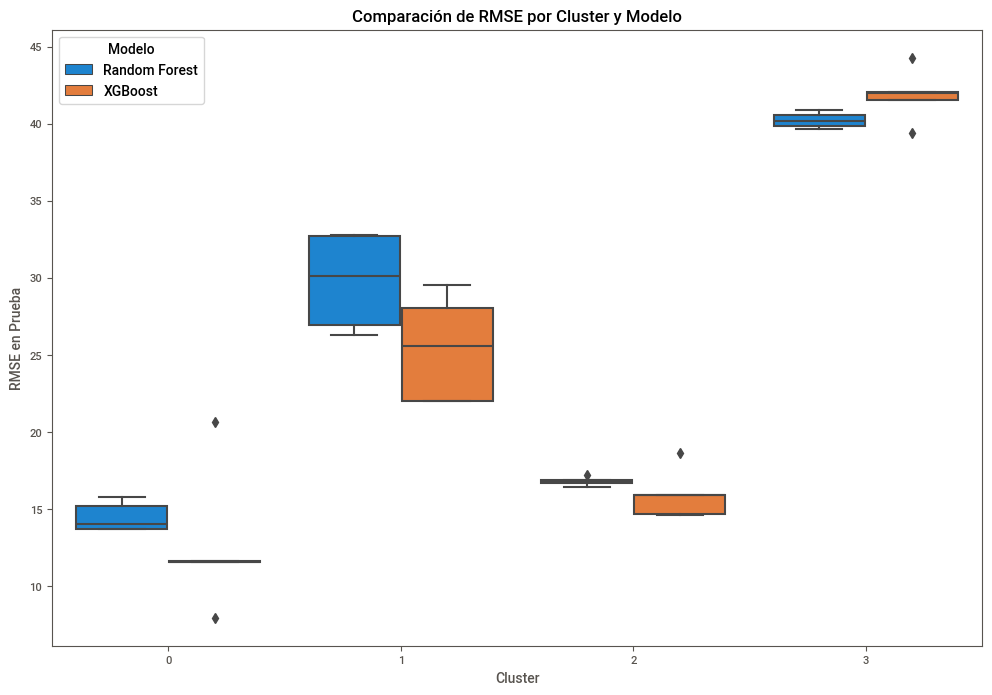

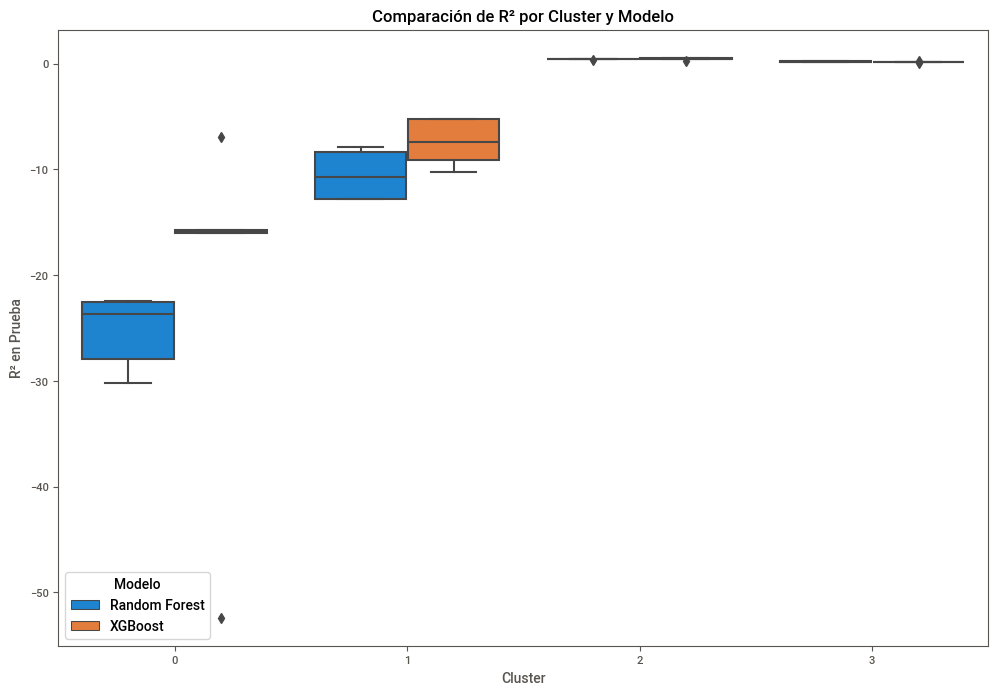

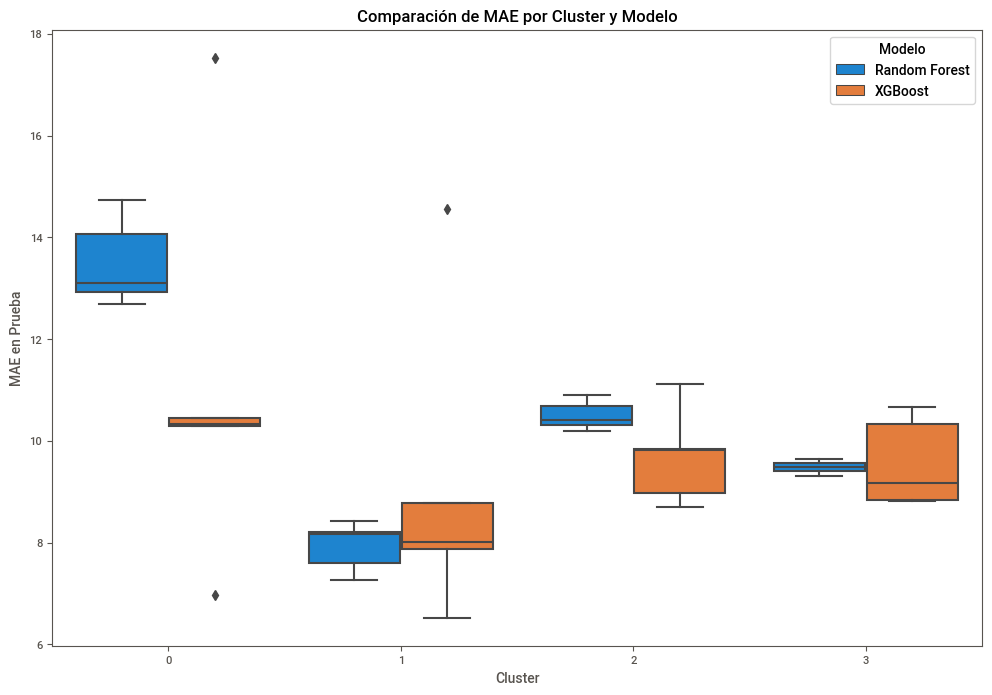

In [275]:
# -------------------------------
# 13. Visualización de Resultados
# -------------------------------
print("\nGenerando visualizaciones de métricas por cluster y modelo...")

# 13.1 Comparación de RMSE por Modelo y Cluster
plt.figure(figsize=(12, 8))
sns.boxplot(data=resultados_combinados, x='Clúster', y='RMSE_Prueba', hue='Modelo')
plt.title('Comparación de RMSE por Cluster y Modelo')
plt.xlabel('Cluster')
plt.ylabel('RMSE en Prueba')
plt.legend(title='Modelo')
plt.show()

# 13.2 Comparación de R² por Modelo y Cluster
plt.figure(figsize=(12, 8))
sns.boxplot(data=resultados_combinados, x='Clúster', y='R2_Prueba', hue='Modelo')
plt.title('Comparación de R² por Cluster y Modelo')
plt.xlabel('Cluster')
plt.ylabel('R² en Prueba')
plt.legend(title='Modelo')
plt.show()

# 13.3 Comparación de MAE por Modelo y Cluster
plt.figure(figsize=(12, 8))
sns.boxplot(data=resultados_combinados, x='Clúster', y='MAE_Prueba', hue='Modelo')
plt.title('Comparación de MAE por Cluster y Modelo')
plt.xlabel('Cluster')
plt.ylabel('MAE en Prueba')
plt.legend(title='Modelo')
plt.show()


In [276]:
# -------------------------------
# 14. Visualización de Importancia de Características
# -------------------------------

def visualizar_importancia_caracteristicas(modelo, feature_names, tipo_modelo='Random Forest'):
    """
    Visualiza la importancia de las características para un modelo dado.
    """
    if tipo_modelo not in ['Random Forest', 'XGBoost']:
        raise ValueError("tipo_modelo debe ser 'Random Forest' o 'XGBoost'")
    
    importances = modelo.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.xlabel('Importancia')
    plt.title(f'Importancia de las Características en {tipo_modelo}')
    plt.show()


Verificando modelos entrenados para el clúster 1 en Random Forest...
  Modelo con mejor R²: modelos_random_forest\rf_cluster_1_iter_3.joblib


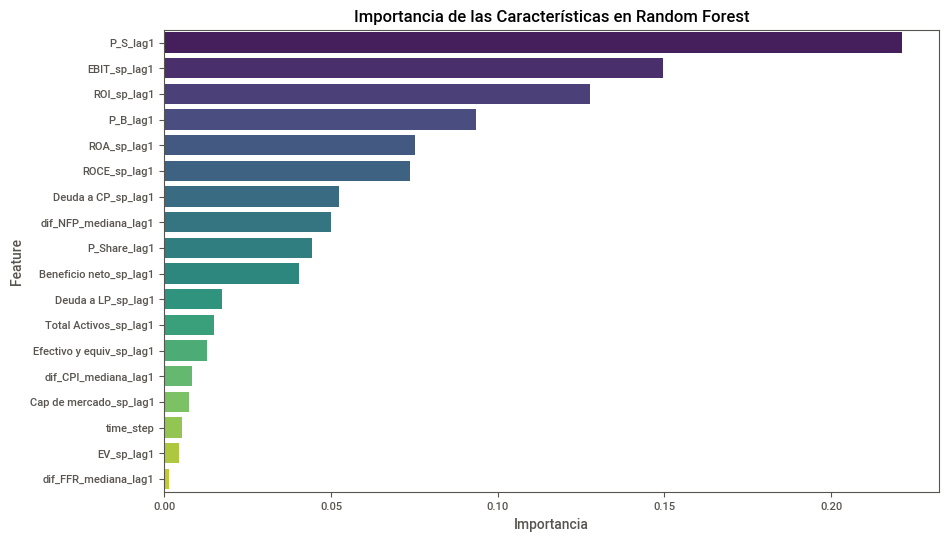

In [277]:
# Ejemplo de visualización para un clúster específico
cluster_ejemplo = 1

# Verificar si el clúster existe en los modelos entrenados para Random Forest
print(f"\nVerificando modelos entrenados para el clúster {cluster_ejemplo} en Random Forest...")
mejores_modelos_cluster_rf = resultados_combinados[
    (resultados_combinados['Clúster'] == cluster_ejemplo) & 
    (resultados_combinados['Modelo'] == 'Random Forest')
]

if not mejores_modelos_cluster_rf.empty:
    # Seleccionar el modelo con el mejor RMSE
    mejor_model_rf = mejores_modelos_cluster_rf.loc[mejores_modelos_cluster_rf['RMSE_Prueba'].idxmax()]['Ruta_Modelo']
    print(f"  Modelo con mejor R²: {mejor_model_rf}")
    modelo_rf_ejemplo = joblib.load(mejor_model_rf)
    visualizar_importancia_caracteristicas(modelo_rf_ejemplo, features, tipo_modelo='Random Forest')
else:
    print(f"  El clúster {cluster_ejemplo} no existe en Random Forest o no tiene un modelo entrenado.")


Verificando modelos entrenados para el clúster 1 en XGBoost...
  Modelo con mejor R²: modelos_xgboost\xgb_cluster_1_iter_4.joblib


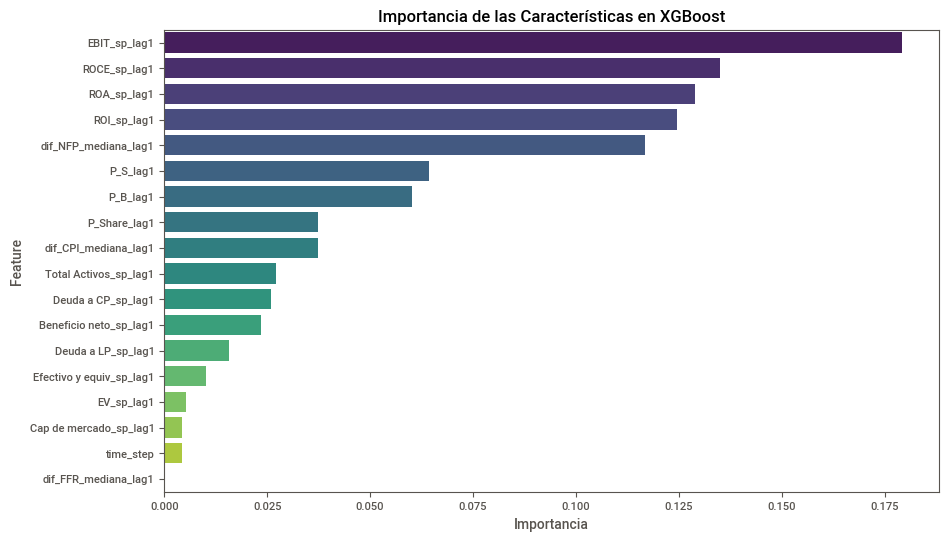

In [278]:
# Verificar si el clúster existe en los modelos entrenados para XGBoost
print(f"\nVerificando modelos entrenados para el clúster {cluster_ejemplo} en XGBoost...")
mejores_modelos_cluster_xgb = resultados_combinados[
    (resultados_combinados['Clúster'] == cluster_ejemplo) & 
    (resultados_combinados['Modelo'] == 'XGBoost')
]

if not mejores_modelos_cluster_xgb.empty:
    # Seleccionar el modelo con el mejor RMSE
    mejor_model_xgb = mejores_modelos_cluster_xgb.loc[mejores_modelos_cluster_xgb['RMSE_Prueba'].idxmax()]['Ruta_Modelo']
    print(f"  Modelo con mejor R²: {mejor_model_xgb}")
    modelo_xgb_ejemplo = joblib.load(mejor_model_xgb)
    visualizar_importancia_caracteristicas(modelo_xgb_ejemplo, features, tipo_modelo='XGBoost')
else:
    print(f"  El clúster {cluster_ejemplo} no existe en XGBoost o no tiene un modelo entrenado.")

In [279]:
# Seleccionar el mejor modelo por clúster basado en el menor RMSE_Prueba
mejores_resultados = resultados_combinados.loc[resultados_combinados.groupby('Clúster')['RMSE_Prueba'].idxmin()]

# Reiniciar el índice
mejores_resultados.reset_index(drop=True, inplace=True)

# Mostrar el DataFrame combinado
mejores_resultados

Clúster   Modelo  Iteración  \
0        0  XGBoost          4   
1        1  XGBoost          3   
2        2  XGBoost          1   
3        3  XGBoost          1   

                                     Hiperparámetros  RMSE_Prueba  MAE_Prueba  \
0  {'n_estimators': 100, 'max_depth': 6, 'learnin...     7.962729    6.965083   
1  {'n_estimators': 100, 'max_depth': 6, 'learnin...    21.994623    7.875799   
2  {'n_estimators': 200, 'max_depth': 3, 'learnin...    14.600254    8.966869   
3  {'n_estimators': 200, 'max_depth': 3, 'learnin...    39.406021   10.659898   

   R2_Prueba                                  Ruta_Modelo  
0  -6.938765  modelos_xgboost\xgb_cluster_0_iter_4.joblib  
1  -5.237013  modelos_xgboost\xgb_cluster_1_iter_3.joblib  
2   0.556829  modelos_xgboost\xgb_cluster_2_iter_1.joblib  
3   0.219015  modelos_xgboost\xgb_cluster_3_iter_1.joblib

In [280]:
# Construir un diccionario con el mejor modelo para cada clúster
mejores_modelos_por_cluster = {}

for _, row in mejores_resultados.iterrows():
    cluster = row['Clúster']
    modelo = row['Modelo']
    iteracion = row['Iteración']
    
    # Crear la ruta según el modelo
    if modelo == "XGBoost":
        path = f"modelos_xgboost\\xgb_cluster_{cluster}_iter_{iteracion}.joblib"
    elif modelo == "Random Forest":
        path = f"modelos_random_forest\\rf_cluster_{cluster}_iter_{iteracion}.joblib"
    else:
        path = "ruta_desconocida.joblib"
    
    mejores_modelos_por_cluster[cluster] = path

In [281]:
mejores_modelos_por_cluster

{0: 'modelos_xgboost\\xgb_cluster_0_iter_4.joblib',
 1: 'modelos_xgboost\\xgb_cluster_1_iter_3.joblib',
 2: 'modelos_xgboost\\xgb_cluster_2_iter_1.joblib',
 3: 'modelos_xgboost\\xgb_cluster_3_iter_1.joblib'}

In [282]:
# Guardar el DataFrame combinado en un nuevo archivo CSV
mejores_resultados.to_csv('mejores_resultados.csv', index=False)
print("\nArchivo 'mejores_resultados.csv' creado exitosamente.")


Archivo 'mejores_resultados.csv' creado exitosamente.


# Predicción

In [283]:
def predecir_empresa(
    empresa_objetivo,
    df_resultado,
    scaler_path,          # Ruta al escalador StandardScaler para el modelo supervisado
    clustering_model_path,# Ruta al modelo TimeSeriesKMeans entrenado
    features,             # Lista de características utilizadas en el modelo supervisado
    mejores_modelos_por_cluster, # Diccionario {cluster_id: ruta_modelo_o_modelo}
    columnas_clustering,  # Lista con las columnas utilizadas en el clustering
    scaler_ts_path,       # Ruta al escalador TimeSeriesScalerMeanVariance (ajustado en entrenamiento)
    num_features          # Número de características por timestamp para el clustering
):
    """
    Predice el valor de una empresa específica (P_E) usando un enfoque one-step ahead:
      - Se asigna el clúster según las últimas 'num_features' filas (para TimeSeriesKMeans).
      - Se elige el modelo supervisado apropiado y se aplica un bucle para predecir la fila i
        usando los features de la fila i-1.
    """

    # 1. Filtrar los datos de la empresa objetivo
    df_shifted = df_resultado[df_resultado['Empresa'] == empresa_objetivo].copy()

    # 2. Verificar si la empresa existe en los datos
    if df_shifted.empty:
        print(f"La empresa '{empresa_objetivo}' no se encuentra en los datos.")
        return None

    # 3. Cargar el modelo de clustering y los escaladores
    print(f"\nAsignando clúster a la empresa '{empresa_objetivo}'...")
    scaler = joblib.load(scaler_path)            # Escalador del modelo supervisado
    clustering_model = joblib.load(clustering_model_path)
    scaler_ts = joblib.load(scaler_ts_path)      # Escalador para el clustering

    # 4. Preparar los datos para la asignación de clúster
    if len(df_shifted) < num_features:
        print(f"La empresa '{empresa_objetivo}' no tiene suficientes observaciones "
              f"para formar {num_features} timesteps para el clustering.")
        return None

    # Tomamos las últimas 'num_features' filas para armar la secuencia que requiere TimeSeriesKMeans
    df_empresa_clustering = df_shifted.tail(num_features).copy()

    # Verificar que las columnas estén presentes
    faltantes = [col for col in columnas_clustering if col not in df_empresa_clustering.columns]
    if faltantes:
        print("No todas las columnas necesarias para el clustering están presentes en df_shifted.")
        print("Columnas faltantes:", faltantes)
        return None

    # Escalado para clustering (TimeSeriesScalerMeanVariance produce forma (num_features, nvars, 1))
    X_clustering = df_empresa_clustering[columnas_clustering].values
    X_clustering_3D = scaler_ts.transform(X_clustering)
    X_clustering_2D = X_clustering_3D.squeeze(axis=2)

    # Verificar dimensiones
    if X_clustering_2D.shape != (num_features, num_features):
        print(f"Dimensiones inesperadas tras el escalado. "
              f"Se esperaba ({num_features}, {num_features}), "
              f"pero se obtuvo {X_clustering_2D.shape}")
        return None

    # Reshape a (1, num_features, num_features) para predecir clúster
    X_clustering_final = X_clustering_2D.reshape(1, num_features, num_features)
    cluster_empresa = clustering_model.predict(X_clustering_final)[0]
    print(f"El clúster asignado a la empresa '{empresa_objetivo}' es: {cluster_empresa}")

    # 5. Seleccionar el modelo supervisado según el clúster
    if cluster_empresa not in mejores_modelos_por_cluster:
        print(f"No hay ningún modelo entrenado para el clúster {cluster_empresa}.")
        return None

    # Si en el diccionario guardas rutas .joblib, debes cargarlo:
    #   modelo_final = joblib.load(ruta)
    # Si guardaste directamente el objeto, no necesitas cargar.
    modelo_o_ruta = mejores_modelos_por_cluster[cluster_empresa]
    if isinstance(modelo_o_ruta, str):
        # Es una ruta .joblib
        modelo_final = joblib.load(modelo_o_ruta)
    else:
        # Es ya un objeto (ej. XGBRegressor, RandomForestRegressor, etc.)
        modelo_final = modelo_o_ruta

    print(f"Usando el modelo seleccionado para el clúster {cluster_empresa}.")

    # 6. Ajustar la lista de columnas para la predicción
    columnas_modelo = [col for col in features if col != 'P_E']
    faltantes_modelo = [col for col in columnas_modelo if col not in df_shifted.columns]
    if faltantes_modelo:
        print("No todas las columnas de 'features' están presentes en 'df_shifted'.")
        print("Columnas faltantes:", faltantes_modelo)
        return None

    # 7. Predicción ONE-STEP AHEAD:
    #    Para la fila i, usamos la información (features) de la fila i-1.
    #    Ponemos NaN en la primera porque no puede predecirse sin fila anterior.
    df_shifted['pred_P_E'] = np.nan

    for i in range(1, len(df_shifted)):
        # Tomar la fila i-1 para generar los features
        x_input = df_shifted.iloc[i - 1][columnas_modelo]
        # Convertir en un array 2D para el scaler y el modelo
        x_input_scaled = scaler.transform([x_input.values])  # -> shape (1, n_features)

        # Hacer la predicción para la fila i
        pred = modelo_final.predict(x_input_scaled)[0]

        # Asignar el resultado en la fila i
        df_shifted.at[df_shifted.index[i], 'pred_P_E'] = pred

    # 8. Eliminamos filas sin predicción (la primera) para el cálculo de métricas
    df_evaluable = df_shifted.dropna(subset=['pred_P_E'])
    if len(df_evaluable) > 1:  # Si hay al menos 2 filas con predicción
        mse_empresa = mean_squared_error(df_evaluable['P_E'], df_evaluable['pred_P_E'])
        r2_empresa = r2_score(df_evaluable['P_E'], df_evaluable['pred_P_E'])
    else:
        mse_empresa = np.nan
        r2_empresa = np.nan

    # 9. Mostrar resultados
    print(f"\nEvaluación de sobrevaloración/subvaloración para la empresa '{empresa_objetivo}':")
    print(df_shifted[['Fecha', 'P_E', 'pred_P_E']])

    plt.figure(figsize=(10, 6))
    plt.plot(df_shifted['Fecha'], df_shifted['P_E'], label='Valor Real', marker='o')
    plt.plot(df_shifted['Fecha'], df_shifted['pred_P_E'], label='Predicción (one-step)', linestyle='--', marker='x')
    plt.xlabel('Fecha')
    plt.ylabel('P_E')
    plt.title(f'Predicción de Sobrevaloración/Subvaloración (one-step ahead) para {empresa_objetivo}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"\nMétricas de desempeño (one-step) para la empresa '{empresa_objetivo}':")
    print(f"MSE: {mse_empresa:.4f}")
    print(f"R²: {r2_empresa:.4f}")

    return df_shifted


In [284]:
# Definir las columnas usadas en el clustering
columnas_clustering = [
    'P_B_lag1', 'P_S_lag1', 'P_Share_lag1', 'ROCE_sp_lag1', 'EBIT_sp_lag1',
    'Total Activos_sp_lag1', 'Deuda a LP_sp_lag1', 'ROA_sp_lag1', 'Beneficio neto_sp_lag1',
    'ROI_sp_lag1', 'EV_sp_lag1', 'Cap de mercado_sp_lag1', 'Deuda a CP_sp_lag1',
    'Efectivo y equiv_sp_lag1', 'dif_CPI_mediana_lag1', 'dif_FFR_mediana_lag1', 'dif_NFP_mediana_lag1'
]


Asignando clúster a la empresa 'FLWS US Equity'...
El clúster asignado a la empresa 'FLWS US Equity' es: 3
Usando el modelo seleccionado para el clúster 3.

Evaluación de sobrevaloración/subvaloración para la empresa 'FLWS US Equity':
         Fecha      P_E   pred_P_E
0   2014-10-31  35.4266        NaN
1   2014-11-28  37.7207  21.260963
2   2014-12-31  11.3711  21.260963
3   2015-01-30  10.8881  20.972460
4   2015-02-27  17.2222  23.002554
..         ...      ...        ...
115 2024-05-31  59.1271  25.139399
116 2024-06-28  58.1498  30.593088
117 2024-07-31  59.3849  20.469221
118 2024-08-30  46.0291  15.132422
119 2024-09-30  63.7178  13.334572

[120 rows x 3 columns]


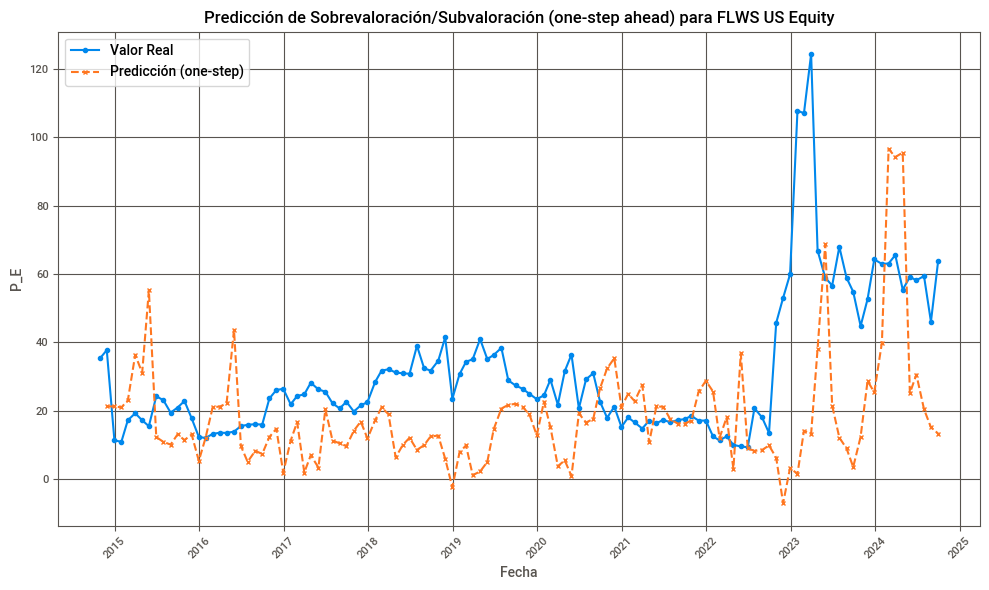


Métricas de desempeño (one-step) para la empresa 'FLWS US Equity':
MSE: 753.0008
R²: -0.8175


In [290]:
df_prediccion_flws = predecir_empresa(
    'FLWS US Equity',
    df_model_spline_mediana,
    'scaler.joblib',
    'kmeans.joblib',
    features,
    mejores_modelos_por_cluster,
    columnas_clustering,
    'scaler_ts.joblib',
    17
)

In [291]:
# 1. Calcular desviación en porcentaje sobre la base P_E
df_prediccion_flws['desviacion_%'] = 100.0 * (df_prediccion_flws['pred_P_E'] - df_prediccion_flws['P_E']) / df_prediccion_flws['P_E']

# 2. Definir un umbral
umbral = 10.0

def calcular_estado_umbral(row, a):
    """
    Si la desviación_% es mayor que +a -> 'Subvaluada'
    Si la desviación_% es menor que -a -> 'Sobrevaluada'
    En caso contrario -> 'Neutra'
    """
    if pd.isna(row['desviacion_%']):
        return np.nan
    elif row['desviacion_%'] > a:
        return 'Subvaluada'
    elif row['desviacion_%'] < -a:
        return 'Sobrevaluada'
    else:
        return 'Neutra'

# 3. Crear una nueva columna con la clasificación
df_prediccion_flws['Estado_umbral'] = df_prediccion_flws.apply(lambda r: calcular_estado_umbral(r, umbral), axis=1)

# Mostrar el resultado
df_prediccion_flws[['Fecha', 'pred_P_E', 'P_E', 'desviacion_%', 'Estado_umbral']].head(10)


Fecha   pred_P_E      P_E  desviacion_% Estado_umbral
0 2014-10-31        NaN  35.4266           NaN           NaN
1 2014-11-28  21.260963  37.7207    -43.635819  Sobrevaluada
2 2014-12-31  21.260963  11.3711     86.973674    Subvaluada
3 2015-01-30  20.972460  10.8881     92.618178    Subvaluada
4 2015-02-27  23.002554  17.2222     33.563389    Subvaluada
5 2015-03-31  36.379154  19.2555     88.928640    Subvaluada
6 2015-04-30  31.069843  17.2046     80.590326    Subvaluada
7 2015-05-29  55.212444  15.4792    256.687970    Subvaluada
8 2015-06-30  12.287593  24.2414    -49.311538  Sobrevaluada
9 2015-07-31  10.893594  23.0594    -52.758555  Sobrevaluada


Asignando clúster a la empresa 'MSFT US Equity'...
El clúster asignado a la empresa 'MSFT US Equity' es: 0
Usando el modelo seleccionado para el clúster 0.

Evaluación de sobrevaloración/subvaloración para la empresa 'MSFT US Equity':
           Fecha      P_E   pred_P_E
12600 2014-10-31  17.6285        NaN
12601 2014-11-28  17.9514  21.028124
12602 2014-12-31  17.6356  21.028124
12603 2015-01-30  15.3386  21.606785
12604 2015-02-27  16.6484  21.614950
...          ...      ...        ...
12715 2024-05-31  35.9259  42.505131
12716 2024-06-28  38.6797  39.079399
12717 2024-07-31  35.3408  40.174774
12718 2024-08-30  35.2386  43.630211
12719 2024-09-30  35.2734  39.299221

[120 rows x 3 columns]


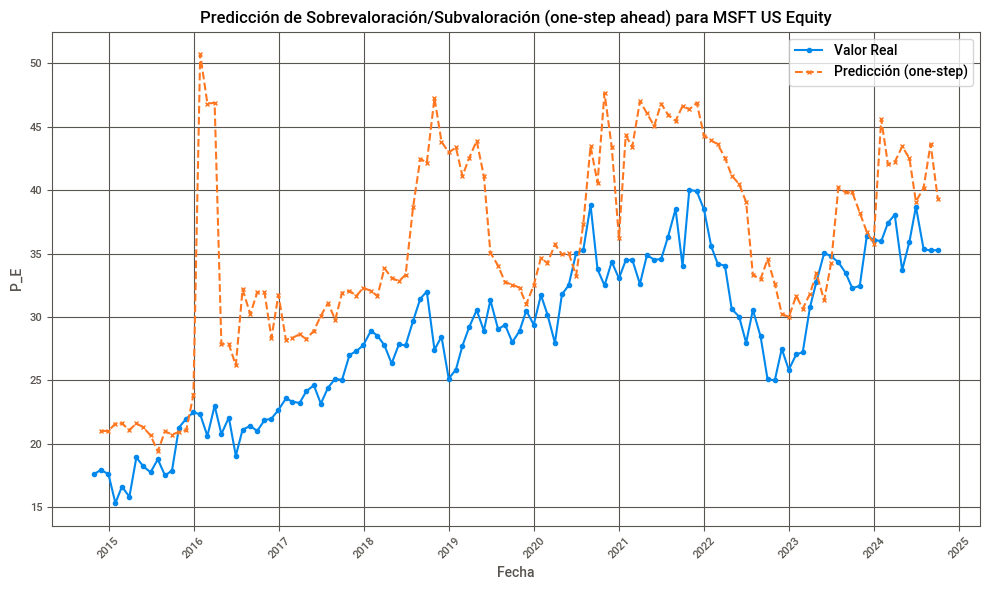


Métricas de desempeño (one-step) para la empresa 'MSFT US Equity':
MSE: 73.7630
R²: -0.9785


In [ ]:
df_prediccion_msft = predecir_empresa(
    'MSFT US Equity',
    df_model_spline_mediana,
    'scaler.joblib',
    'kmeans.joblib',
    features,
    mejores_modelos_por_cluster,
    columnas_clustering,
    'scaler_ts.joblib',
    17
)

In [ ]:
# 1. Calcular desviación en porcentaje sobre la base P_E
df_prediccion_msft['desviacion_%'] = 100.0 * (df_prediccion_msft['pred_P_E'] - df_prediccion_msft['P_E']) / df_prediccion_msft['P_E']

# 2. Definir un umbral
umbral = 10.0

# 3. Crear una nueva columna con la clasificación
df_prediccion_msft['Estado_umbral'] = df_prediccion_msft.apply(lambda r: calcular_estado_umbral(r, umbral), axis=1)

# Mostrar el resultado
df_prediccion_msft[['Fecha', 'pred_P_E', 'P_E', 'desviacion_%', 'Estado_umbral']].head(10)

Fecha   pred_P_E      P_E  desviacion_% Estado_umbral
12600 2014-10-31        NaN  17.6285           NaN           NaN
12601 2014-11-28  21.028124  17.9514     17.139186    Subvaluada
12602 2014-12-31  21.028124  17.6356     19.236793    Subvaluada
12603 2015-01-30  21.606785  15.3386     40.865430    Subvaluada
12604 2015-02-27  21.614950  16.6484     29.831997    Subvaluada
12605 2015-03-31  21.100603  15.8342     33.259673    Subvaluada
12606 2015-04-30  21.614950  18.9442     14.097983    Subvaluada
12607 2015-05-29  21.322735  18.2509     16.831142    Subvaluada
12608 2015-06-30  20.674206  17.7712     16.335452    Subvaluada
12609 2015-07-31  19.416599  18.7977      3.292420        Neutra

### Feature Importance

In [292]:
def plot_feature_importance(model, columnas_modelo, cluster_id):
    """
    Grafica la importancia de las características para un modelo dado.

    Parameters:
    - model: Modelo que tenga el atributo feature_importances_.
    - columnas_modelo (list): Lista de nombres de características.
    - cluster_id (int or str): Identificador del cluster para personalizar el título del gráfico.
    """
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Característica': columnas_modelo,
        'Importancia': importances
    })
    
    # Ordenar el DataFrame de forma descendente según la importancia
    feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)
    
    # Graficar
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'], color='skyblue')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.title(f'Importancia de Características para el Modelo del Cluster {cluster_id}')
    plt.gca().invert_yaxis()  # Mostrar la característica más importante en la parte superior
    plt.tight_layout()
    plt.show()


##### La función visualiza la **importancia global de las características** según el modelo entrenado para ese cluster. Esto significa que se extraen los valores de `feature_importances_` del modelo, los cuales reflejan en promedio qué tan relevantes son las variables para todas las predicciones realizadas por ese modelo en el conjunto de entrenamiento (o en el conjunto general que se usó para entrenarlo).

##### En otras palabras, la función no toma en cuenta los datos específicos de la empresa (por ejemplo, "AAPL US Equity") para generar una explicación local o específica para esa predicción. Para comprender **por qué el modelo predice de cierta forma para una empresa en particular**, se necesitan emplear métodos de interpretabilidad local (como SHAP o LIME) que puedan explicar la contribución de cada característica a la predicción individual.

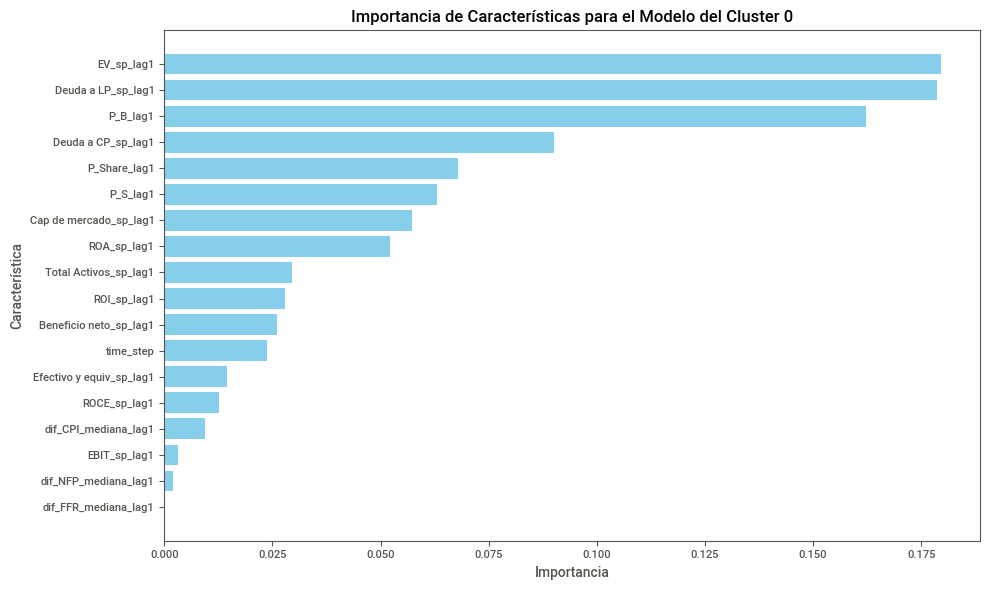

In [293]:
# Seleccionar el cluster correspondiente
cluster_id = 0

# Cargar el modelo correspondiente al cluster
modelo_path = mejores_modelos_por_cluster[cluster_id]
modelo = joblib.load(modelo_path)

# Título del gráfico
nombre_titulo = f"{cluster_id}"

# Graficar la importancia de las características
plot_feature_importance(modelo, features, nombre_titulo)

### Prediccion dlocal

In [334]:
def backtest_dlocal(df_dlocal, 
                    scaler_ts_path,           # Ruta del scaler para series temporales (TimeSeriesScalerMeanVariance)
                    clustering_model_path,      # Ruta del modelo de clustering (TimeSeriesKMeans)
                    scaler_supervisado_path,    # Ruta del scaler supervisado (StandardScaler)
                    num_fechas,                 # Número de timesteps usados para clustering
                    num_features,               # Número de features para clustering (debe coincidir con len(columnas_clustering))
                    columnas_clustering,        # Lista de columnas usadas para el clustering (ej., 17 columnas)
                    columnas_supervisadas,      # Lista de columnas usadas en prepare_data para el modelo supervisado
                    empresa_objetivo,
                    offset):                    # Offset para re-etiquetar los períodos (usar 93 para que la primera predicción retrospectiva sea 94)
    print("=== INICIO DE backtest_dlocal ===")
    print("Empresa objetivo:", empresa_objetivo)
    
    ### Parte 1: Filtrado y clustering
    # Filtrar datos para la empresa objetivo (comparación insensible a mayúsculas)
    df_empresa = df_dlocal[df_dlocal['Empresa'].str.upper() == empresa_objetivo.upper()].copy()
    print("Shape de df_empresa:", df_empresa.shape)
    if df_empresa.empty:
        print(f"No se encontraron datos para la empresa {empresa_objetivo}.")
        return None, None

    # Extraer las columnas de clustering y obtener el array
    X_empresa_cluster = df_empresa[columnas_clustering].values
    print("Shape de X_empresa_cluster:", X_empresa_cluster.shape)
    
    # Aplicar padding si no hay suficientes observaciones para alcanzar num_fechas
    datos_padded = np.zeros((num_fechas, len(columnas_clustering)))
    n_obs = X_empresa_cluster.shape[0]
    print("Número de observaciones:", n_obs)
    if n_obs < num_fechas:
        print("No hay suficientes observaciones; se aplicará padding.")
        datos_padded[-n_obs:, :] = X_empresa_cluster
        datos_padded[:num_fechas - n_obs, :] = X_empresa_cluster[0, :]
    else:
        datos_padded = X_empresa_cluster[-num_fechas:, :]
    print("Shape de datos_padded:", datos_padded.shape)
    
    # Escalar la serie temporal para clustering
    scaler_ts = joblib.load(scaler_ts_path)
    print("Scaler TS cargado desde:", scaler_ts_path)
    X_scaled = scaler_ts.transform(datos_padded)
    X_scaled_3D = X_scaled.reshape(1, num_fechas, num_features)
    
    # Cargar el modelo de clustering y asignar el clúster
    clustering_model = joblib.load(clustering_model_path)
    print("Modelo de clustering cargado desde:", clustering_model_path)
    cluster_asignado = clustering_model.predict(X_scaled_3D)[0]
    print(f"Clúster asignado a {empresa_objetivo}: {cluster_asignado}")
    
    ### Parte 2: Preparación de datos para la predicción supervisada
    # Se asume que se usó la función prepare_data durante el entrenamiento.
    print("Ejecutando prepare_data sobre df_dlocal...")
    df_preparado = prepare_data(df_dlocal, columnas_supervisadas)
    print("Shape de df_preparado:", df_preparado.shape)
    
    # Ordenar el DataFrame cronológicamente según 'time_step'
    df_preparado = df_preparado.sort_values('time_step').reset_index(drop=True)
    
    # Eliminar las columnas que no se usaron durante el fit ('P_E' y 'Empresa')
    X_supervisado = df_preparado.drop(columns=['P_E', 'Empresa'], errors='ignore')
    print("Shape de X_supervisado tras eliminar 'P_E' y 'Empresa':", X_supervisado.shape)
    
    # Cargar el scaler supervisado
    scaler_sup = joblib.load(scaler_supervisado_path)
    print("Scaler supervisado cargado desde:", scaler_supervisado_path)    

    # Seleccionar el modelo supervisado según el clúster asignado
    try:
        modelo_path_o_objeto = mejores_modelos_por_cluster[cluster_asignado]
        print("Modelo supervisado para clúster", cluster_asignado, "obtenido exitosamente.")
    except KeyError:
        print(f"No existe un modelo para el clúster {cluster_asignado} en el diccionario.")
        return None, None

    # Asegurarte de que sea un objeto de modelo (y no una simple ruta)
    if isinstance(modelo_path_o_objeto, str):
        modelo_supervisado = load(modelo_path_o_objeto)  # Carga desde la ruta .joblib
    else:
        modelo_supervisado = modelo_path_o_objeto  # Si ya es un modelo

    
    ### Parte 3: Backtesting one-step ahead
    # Se recorre el DataFrame de features (X_supervisado) desde la segunda fila (índice 1) hasta la última.
    # Para cada fila i, se usan los features de la fila i–1 (ya escalados con scaler_sup) para predecir el valor real de P_E en la fila i.
    n_rows = len(X_supervisado)
    print("Número de filas en X_supervisado (test):", n_rows)
    
    periodos = []      # Se almacenarán los nuevos números de período re-etiquetados
    predicciones = []  # Se guardarán las predicciones generadas
    valores_reales = []  # Se almacenarán los valores reales (de la columna 'P_E' de df_preparado)
    
    for i in range(1, n_rows):
        # Se usan los features de la fila i–1 (descartando 'pred_P_E' si existe)
        features = X_supervisado.iloc[i-1].drop(labels=['pred_P_E'], errors='ignore')
        # Convertir a DataFrame de una sola fila y forzar conversión a numérico
        features_df = features.to_frame().T.apply(pd.to_numeric, errors='coerce')
        # Escalar la entrada con el scaler supervisado
        X_input_scaled = scaler_sup.transform(features_df)
        # Predecir usando el modelo supervisado
        pred = modelo_supervisado.predict(X_input_scaled)[0]
        predicciones.append(pred)
        # Asignar el nuevo período: para i=1, nuevo período = offset + 1 = 93 + 1 = 94; para i=2, = 93 + 2 = 95; ...;
        # Para i = n_rows – 1, nuevo período = offset + (n_rows – 1)
        periodos.append(offset + i)
        # Tomar el valor real de P_E de la fila i (de df_preparado)
        valores_reales.append(df_preparado.iloc[i]['P_E'])
    
    # Realizar forecast para el siguiente período usando la última fila de X_supervisado
    features_ultimo = X_supervisado.iloc[-1].drop(labels=['pred_P_E'], errors='ignore')
    features_ultimo_df = features_ultimo.to_frame().T.apply(pd.to_numeric, errors='coerce')
    X_input_ultimo = scaler_sup.transform(features_ultimo_df)
    pronostico_next = modelo_supervisado.predict(X_input_ultimo)[0]
    # Asignar el nuevo período para el forecast: nuevo período = offset + n_rows = 93 + n_rows
    nuevo_periodo_forecast = offset + n_rows
    periodos.append(nuevo_periodo_forecast)
    predicciones.append(pronostico_next)
    # No se agrega valor real para el forecast, ya que no se conoce
    
    # Crear DataFrame para el backtest (predicciones retrospectivas)
    df_backtest = pd.DataFrame({
        'time_step': periodos[:-1],
        'pred_P_E': predicciones[:-1],
        'P_E_real': valores_reales
    })
    
    # Crear DataFrame para el forecast (predicción para el siguiente período)
    df_forecast = pd.DataFrame({
        'time_step': [periodos[-1]],
        'pred_P_E': [predicciones[-1]]
    })
    
    # Calcular métricas para el backtest
    mae_val = mean_absolute_error(df_backtest['P_E_real'], df_backtest['pred_P_E'])
    rmse_val = np.sqrt(mean_squared_error(df_backtest['P_E_real'], df_backtest['pred_P_E']))
    r2_val = r2_score(df_backtest['P_E_real'], df_backtest['pred_P_E'])
    
    print("Backtest - MAE:", mae_val, "RMSE:", rmse_val, "R2:", r2_val)
    print("\nResultados del backtest (predicciones retrospectivas):")
    print(df_backtest)
    print("\nPronóstico para el siguiente período:")
    print(df_forecast)
    print("=== FIN DE backtest_dlocal ===")
    
    return df_backtest, df_forecast

In [335]:
# Ejemplo de uso:
#columnas_clustering = [
#    'P_B_lag1', 'P_S_lag1', 'P_Share_lag1', 'ROCE_sp_lag1', 'EBIT_sp_lag1',
#    'Total Activos_sp_lag1', 'Deuda a LP_sp_lag1', 'ROA_l_lag1', 'Beneficio neto_l_lag1',
#    'ROI_l_lag1', 'EV_l_lag1', 'Cap de mercado_l_lag1', 'Deuda a CP_l_lag1',
#    'Efectivo y equiv_l_lag1', 'dif_CPI_mediana_lag1', 'dif_FFR_mediana_lag1', 'dif_NFP_mediana_lag1'
#]

columnas_supervisadas = columnas_numericas_spline_mediana  # Debe coincidir con la lista usada en prepare_data

In [338]:
# IMPORTANTE: Se pasa el DataFrame preprocesado (que contiene los lag features) a la función.
# En este ejemplo se espera que el conjunto de prueba tenga 28 filas, 
# de modo que el backtest genere predicciones para los períodos 94 a 120 y el forecast para el 121.

df_backtest, df_forecast = backtest_dlocal(
    df_dlocal=df_dlocal_spline_mediana,  # DataFrame ya preprocesado con lag features
    scaler_ts_path="scaler_ts.joblib",
    clustering_model_path="kmeans.joblib",
    scaler_supervisado_path="scaler.joblib",
    num_fechas=120,       
    num_features=17,      
    columnas_clustering=columnas_clustering,
    columnas_supervisadas=columnas_supervisadas,
    empresa_objetivo="DLO US Equity",
    offset=93  # Con offset=93: para i=1, período=94; para i=27, período=93+27=120; forecast=93+28=121.
)

=== INICIO DE backtest_dlocal ===
Empresa objetivo: DLO US Equity
Shape de df_empresa: (28, 20)
Shape de X_empresa_cluster: (28, 17)
Número de observaciones: 28
No hay suficientes observaciones; se aplicará padding.
Shape de datos_padded: (120, 17)
Scaler TS cargado desde: scaler_ts.joblib
Modelo de clustering cargado desde: kmeans.joblib
Clúster asignado a DLO US Equity: 2
Ejecutando prepare_data sobre df_dlocal...
Shape de df_preparado: (28, 20)
Shape de X_supervisado tras eliminar 'P_E' y 'Empresa': (28, 18)
Scaler supervisado cargado desde: scaler.joblib
Modelo supervisado para clúster 2 obtenido exitosamente.
Número de filas en X_supervisado (test): 28
Backtest - MAE: 11.032042494371199 RMSE: 14.230206994031732 R2: 0.5871805978215484

Resultados del backtest (predicciones retrospectivas):
    time_step   pred_P_E  P_E_real
0          94  78.333443  112.1826
1          95  78.333443  100.4313
2          96  80.469559   82.8649
3          97  80.449036   90.0530
4          98  73.24

In [339]:
# Calcular la desviación como % respecto al valor real
# desviacion(%) = 100 * (pred_P_E - P_E_real) / P_E_real
df_backtest['desviacion_%'] = 100.0 * (df_backtest['pred_P_E'] - df_backtest['P_E_real']) / df_backtest['P_E_real']

def calcular_estado(row, a):
    """
    Si la desviación en % es mayor que +a, se considera 'Subvaluada'.
    Si la desviación en % es menor que -a, se considera 'Sobrevaluada'.
    En caso contrario, 'Neutra'.
    """
    if row['desviacion_%'] > a:
        return 'Subvaluada'
    elif row['desviacion_%'] < -a:
        return 'Sobrevaluada'
    else:
        return 'Neutra'

In [342]:
# Suponiendo que 'a' es un umbral numérico (ej. 10 para ±10%)
a = 10

# Para aplicar la función con un argumento extra, usamos lambda
df_backtest['Estado'] = df_backtest.apply(lambda row: calcular_estado(row, a), axis=1)

df_backtest

time_step   pred_P_E  P_E_real  desviacion_%        Estado
0          94  78.333443  112.1826    -30.173269  Sobrevaluada
1          95  78.333443  100.4313    -22.002959  Sobrevaluada
2          96  80.469559   82.8649     -2.890659        Neutra
3          97  80.449036   90.0530    -10.664791  Sobrevaluada
4          98  73.248741   58.9585     24.237796    Subvaluada
5          99  92.094429   62.8756     46.470855    Subvaluada
6         100  62.865273   45.0720     39.477442    Subvaluada
7         101  61.081554   40.5892     50.487209    Subvaluada
8         102  58.883900   44.0667     33.624482    Subvaluada
9         103  58.380753   38.0354     53.490571    Subvaluada
10        104  50.573193   31.6237     59.921807    Subvaluada
11        105  45.063702   33.1587     35.903101    Subvaluada
12        106  39.449974   41.2141     -4.280394        Neutra
13        107  39.989986   58.2485    -31.345895  Sobrevaluada
14        108  46.948849   52.0814     -9.854864        Neutra
15        109  57.152809   45.7783     24.846945    Subvaluada
16        110  53.412510   46.8651     13.970758    Subvaluada
17        111  50.235504   48.0605      4.525555        Neutra
18        112  50.655964   51.0837     -0.837324        Neutra
19        113  50.692951   52.8277     -4.040965        Neutra
20        114  43.304531   46.6127     -7.097141        Neutra
21        115  43.973106   45.0589     -2.409721        Neutra
22        116  37.199760   29.0140     28.213140    Subvaluada
23        117  37.271114   25.6528     45.290629    Subvaluada
24        118  23.536894   24.3527     -3.349962        Neutra
25        119  22.186729   28.2847    -21.559255  Sobrevaluada
26        120  22.186729   25.3674    -12.538418  Sobrevaluada

In [343]:
df_forecast

time_step   pred_P_E
0        121  22.046278

##### La idea del padding en este contexto es asegurarse de que la entrada para el modelo de clustering tenga la misma dimensión que se usó durante el entrenamiento, es decir, una serie temporal de 120 timesteps. Aunque 120 filas provienen de los datos de entrenamiento, el modelo de clustering (por ejemplo, TimeSeriesKMeans) fue entrenado con series de longitud fija de 120 timesteps.

##### Cuando se realiza la predicción para una empresa nueva (o para el mismo activo en otro período), es posible que la serie histórica disponible tenga menos de 120 observaciones. Para que el modelo de clustering pueda procesarla y asignarle un clúster de manera coherente con lo que aprendió en entrenamiento, la serie debe tener la misma longitud. Por eso, se aplica padding:

##### - **Entrada consistente:** Se rellena (por ejemplo, repitiendo la primera observación o usando otro criterio) para que la serie alcance 120 timesteps, garantizando que la forma (shape) de la entrada sea la misma.
##### - **Compatibilidad con el modelo:** El modelo de clustering espera una entrada de dimensiones fijas, y si la nueva serie es más corta, generará errores o asignaciones inconsistentes.

##### En resumen, aunque 120 es el número de timesteps que se usaron durante el entrenamiento, para la predicción también es necesario que la serie tenga esa misma longitud, ya que el modelo de clustering solo conoce series de 120 timesteps. Por ello, si la serie de la empresa para la predicción es más corta, se aplica padding para "llenar" la serie hasta llegar a 120 timesteps. Esto no significa que se use toda la información de 120 filas de entrenamiento, sino que se mantiene la misma estructura de entrada que el modelo espera.

XGBoost - MAE: 11.032042494371199 RMSE: 14.230206994031732 R2: 0.5871805978215484


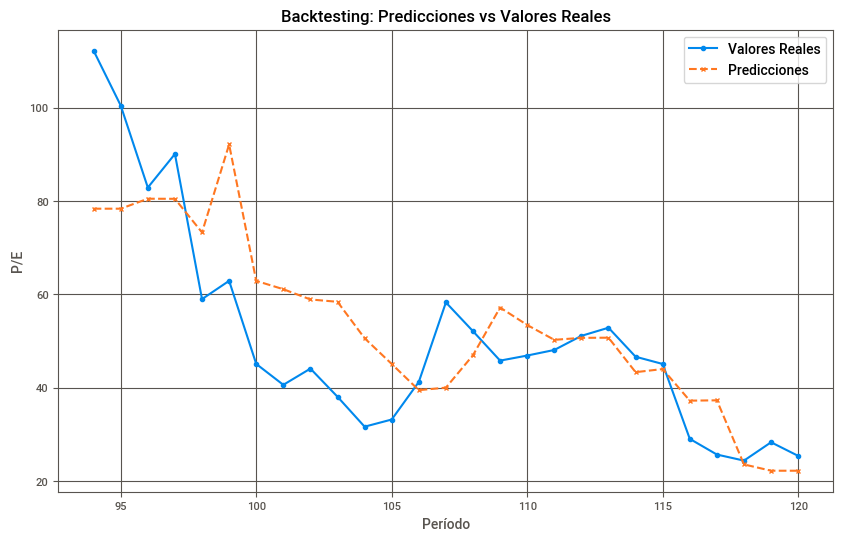

In [344]:
# Extraer valores reales y predicciones del DataFrame de backtesting
valores_reales_back = df_backtest['P_E_real'].values
predicciones_back = df_backtest['pred_P_E'].values

# Calcular las métricas para el backtest de XGBoost
mae_xgb = mean_absolute_error(valores_reales_back, predicciones_back)
rmse_xgb = np.sqrt(mean_squared_error(valores_reales_back, predicciones_back))
r2_xgb = r2_score(valores_reales_back, predicciones_back)

# Mostrar resultados en consola
print("XGBoost - MAE:", mae_xgb, "RMSE:", rmse_xgb, "R2:", r2_xgb)

# Gráfico de las predicciones vs valores reales (backtesting)
plt.figure(figsize=(10, 6))
plt.plot(df_backtest['time_step'], df_backtest['P_E_real'], marker='o', linestyle='-', label='Valores Reales')
plt.plot(df_backtest['time_step'], df_backtest['pred_P_E'], marker='x', linestyle='--', label='Predicciones')
plt.xlabel('Período')
plt.ylabel('P/E')
plt.title('Backtesting: Predicciones vs Valores Reales')
plt.legend()
plt.grid(True)
plt.show()


### Interpretabilidad

##### SHAP

In [ ]:
# Crear el objeto explicador de SHAP, basado en el modelo seleccionado
explainer = shap.TreeExplainer(mejor_modelo['modelo'])  # Funciona con XGBoost y Random Forest

# Calcular los valores SHAP para las características de la empresa objetivo
shap_values = explainer.shap_values(X_empresa_scaled)

# Visualizar la importancia global de las características usando el gráfico de resumen de SHAP
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_empresa_scaled, feature_names=columnas_modelo)

In [ ]:
# Identificar características con baja importancia promedio en valores SHAP
mean_abs_shap = np.abs(shap_values).mean(axis=0)  # Promedio de valores absolutos de SHAP por característica
feature_importance_df = pd.DataFrame({
    'Característica': columnas_modelo,
    'Importancia SHAP Media': mean_abs_shap
}).sort_values(by='Importancia SHAP Media', ascending=False)

# Seleccionar características por encima de un umbral de importancia (ejemplo: 5)
umbral_importancia = 5
caracteristicas_relevantes = feature_importance_df[feature_importance_df['Importancia SHAP Media'] > umbral_importancia]['Característica'].tolist()

print("Características seleccionadas basadas en SHAP:")
print(caracteristicas_relevantes)

# Crear un nuevo conjunto de datos solo con las características relevantes
X_empresa_reducido = df_empresa[caracteristicas_relevantes]

In [ ]:
## Shap con última observación

# Inicializar las visualizaciones de SHAP
shap.initjs()

# Seleccionar la última observación como un array de NumPy con una sola fila
observacion_especifica = X_empresa_scaled[[-1], :]  # Doble corchete para conservar la dimensión 2D

# Crear el explicador SHAP para el modelo
explainer = shap.TreeExplainer(mejor_modelo['modelo'])

# Calcular los valores SHAP para esta observación específica
shap_values_single = explainer.shap_values(observacion_especifica)

# Visualizar el gráfico de fuerza de SHAP para esta observación
shap.force_plot(explainer.expected_value, shap_values_single, observacion_especifica, feature_names=columnas_modelo)

##### LIME

In [ ]:
# Convertir X_empresa_scaled a un array de NumPy si es un DataFrame
if isinstance(X_empresa_scaled, pd.DataFrame):
    X_empresa_scaled = X_empresa_scaled.values

# Crear el explicador LIME
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_empresa_scaled,  # El conjunto de datos de entrenamiento escalado como un array de NumPy
    mode="regression",  # Especifica "regression" para un modelo de regresión
    training_labels=y,  # Las etiquetas o valores objetivo
    feature_names=columnas_modelo,  # Nombres de las características
    random_state=42
)

# Seleccionar una observación específica para interpretar (por ejemplo, la última fila)
observacion_especifica = X_empresa_scaled[-1, :]  # Usar el último dato como un array

# Explicar la predicción del modelo para esa observación
lime_explanation = lime_explainer.explain_instance(
    observacion_especifica, 
    mejor_modelo['modelo'].predict,  # Método de predicción del modelo seleccionado para el cluster
    num_features=10  # Número de características a mostrar en la explicación
)

# Mostrar la explicación en formato gráfico
lime_explanation.show_in_notebook()


# Clasificación

#### **Algunos aspectos importantes a considerar:**

#### - **Generación de etiquetas:**  
####   Estás utilizando un modelo (por ejemplo, XGBoost) para predecir valores y, a partir de la diferencia entre el valor predicho y el real, asignas etiquetas (como "Sobrevalorada", "Subvaluada" o "Neutra"). Esto se asemeja a generar pseudo-etiquetas basadas en umbrales definidos, lo cual es una técnica válida si se hace con cuidado.

#### - **Entrenamiento del modelo de clasificación:**  
####   Una vez que generas estas etiquetas, entrenas un modelo de clasificación que, en teoría, aprende a predecir el estado de una empresa (basado en otras características o en información de pasos previos). Esto puede ser útil si el modelo de clasificación logra capturar patrones adicionales o si se busca robustecer la predicción ante nuevas empresas.

#### - **Riesgos y validación:**  
####   - **Dependencia del modelo inicial:** Las etiquetas dependen de la calidad del modelo XGBoost original. Si este modelo tiene sesgos o errores, esas fallas se reflejarán en las etiquetas.  
####   - **Definición de umbrales:** Es crucial definir umbrales adecuados para asignar correctamente las etiquetas. Umbrales mal ajustados pueden llevar a etiquetas poco representativas.  
####   - **Validación:** Deberás validar que el modelo de clasificación realmente aporta valor y generaliza bien a nuevas empresas, en lugar de simplemente reproducir las decisiones del modelo original.

#### En resumen, sí, tiene sentido usar las predicciones de un modelo XGBoost para generar etiquetas y luego entrenar un clasificador con ellas. Solo asegúrate de validar y evaluar cada paso para garantizar que el proceso no introduzca errores o sesgos que afecten la calidad de las predicciones para nuevas empresas.

In [476]:
def predecir_todas_las_empresas(
    df_resultado,
    pipeline_model_path,  # Ruta al archivo best_pipeline_model.pkl
    features,             # Lista de características (incluye 'P_E' como target)
    umbral                # Umbral para definir sobre/subvaloración (±X%)
):
    """
    Aplica la lógica 'one-step ahead' para TODAS las empresas utilizando un pipeline global.

    Retorna:
        df_final (DataFrame) con las columnas:
          - Empresa
          - Fecha
          - P_E (valor real)
          - pred_P_E (valor predicho)
          - desviacion_% (diferencia relativa)
          - Estado (Sobrevalorada, Subvaluada o Neutra)
          - MSE y R2 a nivel de empresa (opcionales)
    """
    import joblib
    import numpy as np
    import pandas as pd
    from sklearn.metrics import mean_squared_error, r2_score

    # 1. Cargar el pipeline que incluye preprocesamiento y modelo de predicción
    pipeline = joblib.load(pipeline_model_path)

    # 2. Obtener la lista de empresas únicas
    empresas_unicas = df_resultado['Empresa'].unique()
    print(f"Se encontraron {len(empresas_unicas)} empresas únicas. Procesando cada una...")

    lista_resultados = []

    # 3. Iterar por cada empresa para predecir one-step ahead
    for emp in empresas_unicas:
        df_emp = df_resultado[df_resultado['Empresa'] == emp].copy()
        
        # Verificar que haya al menos dos registros para realizar la predicción
        if len(df_emp) < 2:
            print(f"[Advertencia] La empresa '{emp}' no tiene suficientes registros para predecir. Se omite.")
            continue

        # Verificar que estén presentes las columnas de entrada (excluyendo la target 'P_E')
        columnas_input = [col for col in features if col != 'P_E']
        faltantes_modelo = [col for col in columnas_input if col not in df_emp.columns]
        if faltantes_modelo:
            print(f"[Advertencia] Faltan columnas {faltantes_modelo} en la empresa '{emp}'. Se omite.")
            continue

        # Inicializar columna de predicciones
        df_emp['pred_P_E'] = np.nan

        # Aplicar la lógica one-step ahead: se utiliza el registro anterior para predecir el siguiente
        for i in range(1, len(df_emp)):
            # Convertir la fila anterior a DataFrame para conservar las etiquetas de columnas
            x_input = df_emp.iloc[i - 1][columnas_input]
            x_input_df = pd.DataFrame([x_input])
            pred = pipeline.predict(x_input_df)[0]
            df_emp.at[df_emp.index[i], 'pred_P_E'] = pred

        # 4. Calcular métricas (MSE y R2) a nivel de empresa, si es posible
        df_evaluable = df_emp.dropna(subset=['pred_P_E'])
        if len(df_evaluable) > 1:
            mse_empresa = mean_squared_error(df_evaluable['P_E'], df_evaluable['pred_P_E'])
            r2_empresa = r2_score(df_evaluable['P_E'], df_evaluable['pred_P_E'])
        else:
            mse_empresa = np.nan
            r2_empresa = np.nan

        # 5. Calcular la desviación porcentual
        df_emp['desviacion_%'] = 100.0 * (df_emp['pred_P_E'] - df_emp['P_E']) / df_emp['P_E']

        # 6. Clasificar el estado según la desviación
        def calcular_estado(row, umbral):
            if pd.isna(row['desviacion_%']):
                return np.nan
            elif row['desviacion_%'] > umbral:
                return 'Subvaluada'
            elif row['desviacion_%'] < -umbral:
                return 'Sobrevalorada'
            else:
                return 'Neutra'
        df_emp['Estado'] = df_emp.apply(lambda r: calcular_estado(r, umbral), axis=1)

        # (Opcional) Almacenar MSE y R2 en cada registro
        df_emp['MSE_empresa'] = mse_empresa
        df_emp['R2_empresa'] = r2_empresa

        lista_resultados.append(df_emp)

    # 7. Concatenar todos los DataFrames de cada empresa y ordenar por Empresa y Fecha
    if lista_resultados:
        df_final = pd.concat(lista_resultados, axis=0)
        df_final = df_final.sort_values(['Empresa', 'Fecha']).reset_index(drop=True)
    else:
        df_final = pd.DataFrame()

    print("\nProceso completado. DataFrame final:")
    print(df_final[['Empresa','Fecha','P_E','pred_P_E','desviacion_%','Estado','MSE_empresa','R2_empresa']].head(10))
    print("...")
    print(df_final[['Empresa','Fecha','P_E','pred_P_E','desviacion_%','Estado','MSE_empresa','R2_empresa']].tail(10))

    return df_final


In [490]:
df_todas = predecir_todas_las_empresas(
    df_resultado=df_model_spline_mediana,
    pipeline_model_path="best_pipeline_model.pkl",
    features=features,
    umbral=5
)


Se encontraron 157 empresas únicas. Procesando cada una...

Proceso completado. DataFrame final:
          Empresa      Fecha      P_E   pred_P_E  desviacion_%         Estado  \
0  ACHC US Equity 2014-10-31  46.0167        NaN           NaN            NaN   
1  ACHC US Equity 2014-11-28  45.9870  28.922052    -37.108199  Sobrevalorada   
2  ACHC US Equity 2014-12-31  47.0098  28.922052    -38.476547  Sobrevalorada   
3  ACHC US Equity 2015-01-30  44.3525  28.922052    -34.790480  Sobrevalorada   
4  ACHC US Equity 2015-02-27  48.5612  28.810286    -40.672212  Sobrevalorada   
5  ACHC US Equity 2015-03-31  49.6680  28.093412    -43.437601  Sobrevalorada   
6  ACHC US Equity 2015-04-30  47.5175  28.922052    -39.133893  Sobrevalorada   
7  ACHC US Equity 2015-05-29  51.4299  28.872288    -43.860891  Sobrevalorada   
8  ACHC US Equity 2015-06-30  45.7322  28.760521    -37.111005  Sobrevalorada   
9  ACHC US Equity 2015-07-31  46.5788  28.872288    -38.014101  Sobrevalorada   

   MSE_empr

In [491]:
def train_classification_model_all(df_resultados, columnas_features, a):
    """
    Entrena un modelo de clasificación (Subvaluada, Sobrevalorada, Neutra) para TODAS las empresas.
    Asume que 'df_resultados' ya contiene:
      - 'Empresa'
      - 'P_E_real' o 'P_E'
      - 'pred_P_E'
      - las features en columnas_features
      - (Opcional) 'time_step' o 'Fecha' para ordenar temporalmente si se desea

    Parámetros:
      df_resultados : DataFrame con TODAS las empresas y su predicción one-step.
      columnas_features : Lista de columnas con features que utilizarás.
      a : Umbral para la desviación porcentual (±a%).

    Retorna:
      clf_model : Modelo de clasificación entrenado (XGBClassifier).
      le : LabelEncoder para decodificar las clases.
      scaler_sup : Escalador utilizado.
      df_final : DataFrame con las etiquetas generadas (Estado).
    """
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
    from sklearn.metrics import classification_report
    from xgboost import XGBClassifier
    from imblearn.over_sampling import SMOTE

    print("=== INICIO DE ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN (TODAS LAS EMPRESAS) ===")

    # 1. Verificar que existan las columnas esenciales
    cols_necesarias = ['Empresa', 'P_E', 'pred_P_E'] + columnas_features
    faltantes = [col for col in cols_necesarias if col not in df_resultados.columns]
    if faltantes:
        raise ValueError(f"Faltan columnas esenciales en df_resultados: {faltantes}")

    # (Opcional) Si no existe 'P_E_real', se crea a partir de 'P_E'
    if 'P_E_real' not in df_resultados.columns and 'P_E' in df_resultados.columns:
        df_resultados['P_E_real'] = df_resultados['P_E']

    # 2. Calcular la desviación porcentual y asignar la etiqueta 'Estado'
    df_resultados['desviacion_pct'] = 100.0 * (
        df_resultados['pred_P_E'] - df_resultados['P_E_real']
    ) / df_resultados['P_E_real']

    def calcular_estado(row):
        if pd.isna(row['desviacion_pct']):
            return np.nan
        elif row['desviacion_pct'] > a:
            return 'Subvaluada'
        elif row['desviacion_pct'] < -a:
            return 'Sobrevalorada'
        else:
            return 'Neutra'

    df_resultados['Estado'] = df_resultados.apply(calcular_estado, axis=1)

    # 3. Ordenar por 'Empresa' y 'time_step' o 'Fecha'
    if 'time_step' in df_resultados.columns:
        df_resultados = df_resultados.sort_values(['Empresa', 'time_step'])
    elif 'Fecha' in df_resultados.columns:
        df_resultados = df_resultados.sort_values(['Empresa', 'Fecha'])

    # Aplicar shift(1) para las features (usar la fila anterior para predecir el estado del siguiente período)
    df_features_shifted = df_resultados.groupby('Empresa')[columnas_features].shift(1)
    df_final = df_resultados.copy()
    for col in columnas_features:
        df_final[col + '_t1'] = df_features_shifted[col]

    # Eliminar filas con features(t-1) NaN (primer registro de cada empresa)
    df_final = df_final.dropna(subset=[col + '_t1' for col in columnas_features]).copy()

    # 4. Separar X e y
    columnas_shifted = [col + '_t1' for col in columnas_features]
    X = df_final[columnas_shifted]
    y = df_final['Estado'].astype(str)

    # 5. Codificar las etiquetas
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # 6. Dividir en train y test (respetando el orden temporal)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, shuffle=False
    )

    # 7. Escalar datos
    scaler_sup = StandardScaler()
    X_train_scaled = scaler_sup.fit_transform(X_train)
    X_test_scaled = scaler_sup.transform(X_test)

    # 8. Aplicar oversampling (SMOTE) en el conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

    # 9. Búsqueda de hiperparámetros con GridSearchCV y TimeSeriesSplit
    clf_model = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
    param_grid = {
        'max_depth': [3, 5, 7],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    grid_search = GridSearchCV(clf_model, param_grid, cv=tscv, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train_res, y_train_res)

    best_params = grid_search.best_params_
    print(f"Mejores parámetros encontrados: {best_params}")

    # 10. Entrenar el modelo final con los mejores parámetros sobre los datos re-muestreados
    clf_model = XGBClassifier(**best_params, objective='multi:softmax', num_class=3, random_state=42)
    clf_model.fit(X_train_res, y_train_res)

    # 11. Evaluar el modelo en el conjunto de test
    y_pred = clf_model.predict(X_test_scaled)
    print(f"Reporte de clasificación (Umbral=±{a}%):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    print("=== FIN DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN ===")

    return clf_model, le, scaler_sup, df_final


In [492]:
clf_model, le, scaler_sup, df_etiquetado = train_classification_model_all(
    df_resultados=df_todas,
    columnas_features=features,
    a=5
)

=== INICIO DE ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN (TODAS LAS EMPRESAS) ===
Mejores parámetros encontrados: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Reporte de clasificación (Umbral=±5%):
               precision    recall  f1-score   support

       Neutra       0.23      0.19      0.21       416
Sobrevalorada       0.65      0.60      0.63      1144
   Subvaluada       0.79      0.85      0.82      2177

     accuracy                           0.70      3737
    macro avg       0.56      0.55      0.55      3737
 weighted avg       0.68      0.70      0.69      3737

=== FIN DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN ===


In [493]:
def inferir_clase_dlocal(
    df_completo,
    empresa_objetivo,
    clf_model,
    le,
    scaler_sup,
    columnas_features
):
    """
    Usa el modelo de clasificación entrenado (clf_model) para predecir la clase
    (Subvaluada / Sobrevalorada / Neutra) en el siguiente período de 'empresa_objetivo'.

    Parámetros:
    -----------
      df_completo : DataFrame que incluye la empresa objetivo y sus últimas filas
      empresa_objetivo : Ejemplo 'DLO US Equity'
      clf_model : El modelo de clasificación entrenado (XGBClassifier, etc.)
      le : LabelEncoder entrenado
      scaler_sup : StandardScaler (u otro) entrenado
      columnas_features : lista de columnas que el modelo espera como input

    Retorna:
    --------
      La clase predicha (str), o None si no es posible predecir.
    """
    # 1. Filtrar la empresa y ordenar temporalmente
    df_emp = df_completo[df_completo['Empresa'] == empresa_objetivo].copy()
    if df_emp.empty:
        print(f"No hay datos para la empresa {empresa_objetivo}.")
        return None

    # Asegúrate de tener 'time_step' o 'Fecha' para ordenar
    if 'time_step' in df_emp.columns:
        df_emp.sort_values('time_step', inplace=True)
    elif 'Fecha' in df_emp.columns:
        df_emp.sort_values('Fecha', inplace=True)

    # 2. Tomar la última fila con las features(t-1)
    #    (supongamos que ya en tu df las features se llaman 'feature1_t1', etc.
    #     o si no, ajusta según tu pipeline).
    ultima_fila = df_emp.iloc[-1]

    # Verificar que existan todas las columnas de features
    for feat in columnas_features:
        if feat not in ultima_fila.index:
            print(f"Falta la columna {feat} en la última fila.")
            return None

    # 3. Extraer y escalar las features
    X_input = ultima_fila[columnas_features].values.reshape(1, -1)
    X_input_scaled = scaler_sup.transform(X_input)

    # 4. Predecir la clase codificada
    clase_encoded = clf_model.predict(X_input_scaled)
    # Decodificar
    clase_decoded = le.inverse_transform(clase_encoded)[0]

    print(f"La clase predicha para {empresa_objetivo} es: {clase_decoded}")
    return clase_decoded


In [494]:
clase_predicha = inferir_clase_dlocal(
    df_completo = df_dlocal_spline_mediana,   # Aquí df_dlocal contiene solo datos de DLocal
    empresa_objetivo = "DLO US Equity",
    clf_model = clf_model,
    le = le,
    scaler_sup = scaler_sup,
    columnas_features = features
)

La clase predicha para DLO US Equity es: Subvaluada


In [495]:
def predecir_dlocal_class(
    df_resultado,
    pipeline_model_path,   # Ruta al archivo best_pipeline_model.pkl
    features,              # Lista de características utilizadas en el pipeline (incluye 'P_E' como target)
    umbral                 # Umbral para definir sobre/subvaloración (±X%)
):
    """
    Aplica la lógica 'one-step ahead' + clasificación de desviación%
    para TODAS las empresas en df_resultado utilizando un pipeline global.

    Retorna:
        df_final (DataFrame) con las columnas:
          - Empresa
          - Fecha o time_step (dependiendo de la columna de ordenamiento)
          - P_E (valor real)
          - pred_P_E (valor predicho)
          - desviacion_% (diferencia relativa)
          - Estado (Sobrevalorada, Subvaluada o Neutra)
          - MSE y R2 a nivel de empresa (opcionales)
    """
    import joblib
    import numpy as np
    import pandas as pd
    from sklearn.metrics import mean_squared_error, r2_score

    # 1. Cargar el pipeline que incluye el preprocesamiento y modelo de predicción
    pipeline = joblib.load(pipeline_model_path)

    # 2. Obtener la lista de empresas únicas
    empresas_unicas = df_resultado['Empresa'].unique()
    print(f"Se encontraron {len(empresas_unicas)} empresas únicas. Procesando cada una...")

    lista_resultados = []

    # 3. Iterar sobre cada empresa para aplicar la predicción one-step ahead
    for emp in empresas_unicas:
        df_emp = df_resultado[df_resultado['Empresa'] == emp].copy()
        
        # Verificar que haya al menos dos registros para poder predecir
        if len(df_emp) < 2:
            print(f"[Advertencia] La empresa '{emp}' no tiene suficientes registros para predecir. Se omite.")
            continue

        # Definir las columnas de entrada (excluyendo la variable target 'P_E')
        columnas_input = [col for col in features if col != 'P_E']
        faltantes_modelo = [col for col in columnas_input if col not in df_emp.columns]
        if faltantes_modelo:
            print(f"[Advertencia] Faltan columnas {faltantes_modelo} en la empresa '{emp}'. Se omite.")
            continue

        # Inicializar la columna de predicciones
        df_emp['pred_P_E'] = np.nan

        # Realizar la predicción one-step ahead:
        # Para cada registro (desde el segundo) se usa la fila anterior como entrada para predecir el siguiente valor
        for i in range(1, len(df_emp)):
            x_input = df_emp.iloc[i - 1][columnas_input]
            # Convertir la Serie en DataFrame para preservar etiquetas (necesario para transformadores que usan .drop())
            x_input_df = pd.DataFrame([x_input])
            pred = pipeline.predict(x_input_df)[0]
            df_emp.at[df_emp.index[i], 'pred_P_E'] = pred

        # 4. Calcular métricas (MSE y R2) a nivel de empresa, si es posible
        df_evaluable = df_emp.dropna(subset=['pred_P_E'])
        if len(df_evaluable) > 1:
            mse_empresa = mean_squared_error(df_evaluable['P_E'], df_evaluable['pred_P_E'])
            r2_empresa = r2_score(df_evaluable['P_E'], df_evaluable['pred_P_E'])
        else:
            mse_empresa = np.nan
            r2_empresa = np.nan

        # 5. Calcular la desviación porcentual
        df_emp['desviacion_%'] = 100.0 * (df_emp['pred_P_E'] - df_emp['P_E']) / df_emp['P_E']

        # 6. Clasificar el estado según la desviación
        def calcular_estado(row, umbral):
            if pd.isna(row['desviacion_%']):
                return np.nan
            elif row['desviacion_%'] > umbral:
                return 'Subvaluada'
            elif row['desviacion_%'] < -umbral:
                return 'Sobrevalorada'
            else:
                return 'Neutra'

        df_emp['Estado'] = df_emp.apply(lambda r: calcular_estado(r, umbral), axis=1)

        # (Opcional) Almacenar MSE y R2 en cada registro
        df_emp['MSE_empresa'] = mse_empresa
        df_emp['R2_empresa'] = r2_empresa

        lista_resultados.append(df_emp)

    # 7. Concatenar todos los DataFrames de cada empresa y ordenar por Empresa y fecha (o time_step)
    if lista_resultados:
        df_final = pd.concat(lista_resultados, axis=0)
        # Cambiar 'time_step' por 'Fecha' si es el nombre de tu columna de ordenamiento
        if 'time_step' in df_final.columns:
            df_final = df_final.sort_values(['Empresa', 'time_step']).reset_index(drop=True)
        elif 'Fecha' in df_final.columns:
            df_final = df_final.sort_values(['Empresa', 'Fecha']).reset_index(drop=True)
    else:
        df_final = pd.DataFrame()  # Vacío si no se pudo procesar ninguna empresa

    print("\nProceso completado. DataFrame clasificación de dlocal:")
    if 'time_step' in df_final.columns:
        print(df_final[['Empresa','time_step','P_E','pred_P_E','desviacion_%','Estado','MSE_empresa','R2_empresa']].head(10))
        print("...")
        print(df_final[['Empresa','time_step','P_E','pred_P_E','desviacion_%','Estado','MSE_empresa','R2_empresa']].tail(10))
    elif 'Fecha' in df_final.columns:
        print(df_final[['Empresa','Fecha','P_E','pred_P_E','desviacion_%','Estado','MSE_empresa','R2_empresa']].head(10))
        print("...")
        print(df_final[['Empresa','Fecha','P_E','pred_P_E','desviacion_%','Estado','MSE_empresa','R2_empresa']].tail(10))
    else:
        print(df_final.head(10))
    
    return df_final


In [496]:
df_dlocal_class = predecir_dlocal_class(
    df_resultado=df_dlocal_spline_mediana,
    pipeline_model_path="best_pipeline_model.pkl",
    features=features,
    umbral=5
)


Se encontraron 1 empresas únicas. Procesando cada una...

Proceso completado. DataFrame clasificación de dlocal:
         Empresa  time_step       P_E   pred_P_E  desviacion_%         Estado  \
0  DLO US Equity          1  106.0041        NaN           NaN            NaN   
1  DLO US Equity          2  112.1826  60.769711    -45.829647  Sobrevalorada   
2  DLO US Equity          3  100.4313  60.769711    -39.491264  Sobrevalorada   
3  DLO US Equity          4   82.8649  61.590343    -25.673785  Sobrevalorada   
4  DLO US Equity          5   90.0530  60.769711    -32.517839  Sobrevalorada   
5  DLO US Equity          6   58.9585  60.769711      3.072009         Neutra   
6  DLO US Equity          7   62.8756  60.769711     -3.349295         Neutra   
7  DLO US Equity          8   45.0720  59.802929     32.683105     Subvaluada   
8  DLO US Equity          9   40.5892  60.769711     49.718917     Subvaluada   
9  DLO US Equity         10   44.0667  53.659363     21.768507     Subvaluada

In [497]:
def backtest_classification_dlocal(
    df_dlocal_spline_mediana,
    clf_model,
    le,
    scaler_sup,
    columnas_features,   # Las columnas que el modelo usa (por ejemplo, las que se generaron con shift(1) en entrenamiento)
    offset
):
    """
    Realiza backtesting one-step ahead para la clasificación en DLocal.
    
    Para cada fila i (desde 1 hasta N-1) se usan las features de la fila i-1 para predecir 
    la clase del período i. La etiqueta real se toma de la columna 'Estado' de df_dlocal_spline_mediana.
    
    Además, se realiza un forecast para el siguiente período usando la última fila.
    
    Parámetros:
      df_dlocal_spline_mediana: DataFrame con datos de DLocal (debe incluir la columna 'Estado' con la etiqueta real)
      clf_model: Modelo de clasificación entrenado (por ejemplo, XGBClassifier)
      le: LabelEncoder para decodificar las clases
      scaler_sup: Escalador entrenado (ej. StandardScaler)
      columnas_features: Lista de columnas que se usarán como features
      offset: Valor entero para re-etiquetar los períodos (por ejemplo, 93)
    
    Retorna:
      df_backtest: DataFrame con columnas ['time_step', 'pred_estado', 'estado_real']
      df_forecast: DataFrame con la predicción del siguiente período (sin estado real)
    """
    
    # Asegurarse de que el DataFrame esté ordenado cronológicamente.
    if 'time_step' in df_dlocal_spline_mediana.columns:
        df_dlocal_spline_mediana = df_dlocal_spline_mediana.sort_values('time_step').reset_index(drop=True)
    elif 'Fecha' in df_dlocal_spline_mediana.columns:
        df_dlocal_spline_mediana = df_dlocal_spline_mediana.sort_values('Fecha').reset_index(drop=True)
    
    time_steps = []      # Nuevos números de período
    pred_estados = []    # Predicción del modelo
    real_estados = []    # Etiqueta real (columna 'Estado')
    
    n = len(df_dlocal_spline_mediana)
    # Backtesting: para cada fila i desde 1 hasta n-1, usar la fila i-1 para predecir la etiqueta de la fila i.
    for i in range(1, n):
        # Extraer las features de la fila anterior (i-1)
        x_input = df_dlocal_spline_mediana.iloc[i-1][columnas_features].values.reshape(1, -1)
        x_input_scaled = scaler_sup.transform(x_input)
        # Predecir la clase codificada y decodificar
        pred_encoded = clf_model.predict(x_input_scaled)[0]
        pred_estado = le.inverse_transform([pred_encoded])[0]
        pred_estados.append(pred_estado)
        # Definir el time_step (por ejemplo, offset + i)
        time_steps.append(offset + i)
        # Tomar la etiqueta real (ya generada previamente en la columna 'Estado') de la fila i
        real_estados.append(df_dlocal_spline_mediana.iloc[i]['Estado'])
    
    # Forecast para el siguiente período usando la última fila
    x_last = df_dlocal_spline_mediana.iloc[-1][columnas_features].values.reshape(1, -1)
    x_last_scaled = scaler_sup.transform(x_last)
    forecast_encoded = clf_model.predict(x_last_scaled)[0]
    forecast_estado = le.inverse_transform([forecast_encoded])[0]
    time_steps.append(offset + n)
    pred_estados.append(forecast_estado)
    # No hay etiqueta real para el forecast
    
    # Crear DataFrame de backtest (con predicciones retrospectivas)
    df_backtest_dlocal_class = pd.DataFrame({
        'time_step': time_steps[:-1],
        'pred_estado': pred_estados[:-1],
        'estado_real': real_estados
    })
    
    # Crear DataFrame de forecast
    df_forecast_dlocal_class = pd.DataFrame({
        'time_step': [time_steps[-1]],
        'pred_estado': [pred_estados[-1]]
    })
    
    return df_backtest_dlocal_class, df_forecast_dlocal_class


In [498]:
columnas_features = features

# Llamar a la función de backtesting de clasificación para DLocal
df_backtest_dlocal_class, df_forecast_dlocal_class = backtest_classification_dlocal(
    df_dlocal_spline_mediana = df_dlocal_class,   # DataFrame solo de DLocal, que ya incluye la columna 'Estado'
    clf_model = clf_model,     # Modelo de clasificación entrenado
    le = le,                   # LabelEncoder
    scaler_sup = scaler_sup,   # Scaler usado en entrenamiento
    columnas_features = columnas_features,
    offset = 93                # Ejemplo de offset
)

print("Resultados del Backtest de Clasificación para DLocal:")
print(df_backtest_dlocal_class)
print("Forecast para el siguiente período:")
print(df_forecast_dlocal_class)

Resultados del Backtest de Clasificación para DLocal:
    time_step    pred_estado    estado_real
0          94     Subvaluada  Sobrevalorada
1          95     Subvaluada  Sobrevalorada
2          96     Subvaluada  Sobrevalorada
3          97     Subvaluada  Sobrevalorada
4          98     Subvaluada         Neutra
5          99     Subvaluada         Neutra
6         100     Subvaluada     Subvaluada
7         101     Subvaluada     Subvaluada
8         102     Subvaluada     Subvaluada
9         103     Subvaluada     Subvaluada
10        104     Subvaluada     Subvaluada
11        105     Subvaluada     Subvaluada
12        106     Subvaluada  Sobrevalorada
13        107     Subvaluada  Sobrevalorada
14        108     Subvaluada         Neutra
15        109     Subvaluada     Subvaluada
16        110     Subvaluada     Subvaluada
17        111     Subvaluada     Subvaluada
18        112     Subvaluada         Neutra
19        113     Subvaluada         Neutra
20        114  Sobreva

In [499]:
df_backtest_dlocal_class

time_step    pred_estado    estado_real
0          94     Subvaluada  Sobrevalorada
1          95     Subvaluada  Sobrevalorada
2          96     Subvaluada  Sobrevalorada
3          97     Subvaluada  Sobrevalorada
4          98     Subvaluada         Neutra
5          99     Subvaluada         Neutra
6         100     Subvaluada     Subvaluada
7         101     Subvaluada     Subvaluada
8         102     Subvaluada     Subvaluada
9         103     Subvaluada     Subvaluada
10        104     Subvaluada     Subvaluada
11        105     Subvaluada     Subvaluada
12        106     Subvaluada  Sobrevalorada
13        107     Subvaluada  Sobrevalorada
14        108     Subvaluada         Neutra
15        109     Subvaluada     Subvaluada
16        110     Subvaluada     Subvaluada
17        111     Subvaluada     Subvaluada
18        112     Subvaluada         Neutra
19        113     Subvaluada         Neutra
20        114  Sobrevalorada  Sobrevalorada
21        115  Sobrevalorada  Sobrevalorada
22        116  Sobrevalorada     Subvaluada
23        117  Sobrevalorada     Subvaluada
24        118     Subvaluada     Subvaluada
25        119     Subvaluada         Neutra
26        120     Subvaluada     Subvaluada

In [500]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df_backtest_dlocal_class['estado_real'], df_backtest_dlocal_class['pred_estado'])
print(f"Precisión del modelo: {accuracy:.2f}")

Precisión del modelo: 0.48


In [501]:
from sklearn.metrics import classification_report

print(classification_report(df_backtest_dlocal_class['estado_real'], df_backtest_dlocal_class['pred_estado']))

               precision    recall  f1-score   support

       Neutra       0.00      0.00      0.00         6
Sobrevalorada       0.50      0.25      0.33         8
   Subvaluada       0.48      0.85      0.61        13

     accuracy                           0.48        27
    macro avg       0.33      0.37      0.31        27
 weighted avg       0.38      0.48      0.39        27



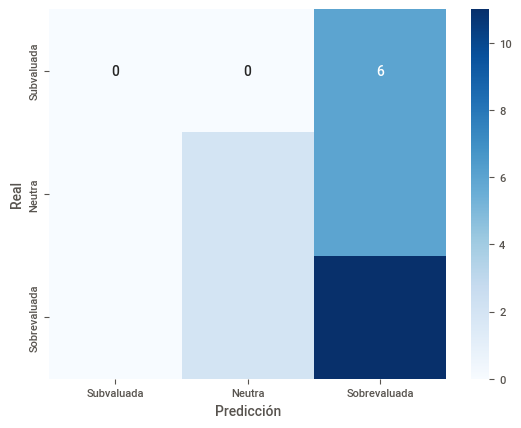

In [502]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_backtest_dlocal_class['estado_real'], df_backtest_dlocal_class['pred_estado'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Subvaluada', 'Neutra', 'Sobrevaluada'], yticklabels=['Subvaluada', 'Neutra', 'Sobrevaluada'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Red neuronal

In [510]:
def train_nn_classification_model_all(df_resultados, columnas_features, a, epochs=100, batch_size=32):
    """
    Entrena un modelo de clasificación (Subvaluada, Sobrevalorada, Neutra) para TODAS las empresas
    utilizando una red neuronal simple (MLP) con Keras.
    
    Se asume que 'df_resultados' ya contiene:
      - 'Empresa'
      - 'P_E' o 'P_E_real'
      - 'pred_P_E'
      - Las features en columnas_features
      - (Opcional) 'time_step' o 'Fecha' para ordenar temporalmente.
    
    Parámetros:
      df_resultados : DataFrame con TODAS las empresas y sus predicciones one‑step.
      columnas_features : Lista de columnas con features utilizadas.
      a : Umbral para la desviación porcentual (±a%).
      epochs : Número de épocas para entrenar la red.
      batch_size : Tamaño de batch para el entrenamiento.
      
    Retorna:
      model : Modelo de red neuronal entrenado.
      le : LabelEncoder utilizado para codificar/decodificar las clases.
      scaler_sup : Escalador entrenado.
      df_final : DataFrame final con las etiquetas generadas (Estado) y las features de shift.
      history : Objeto history de Keras con el registro del entrenamiento.
    """
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import SMOTE
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import to_categorical
    
    print("=== INICIO DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN CON RED NEURONAL ===")
    
    # 1. Verificar columnas esenciales
    cols_necesarias = ['Empresa', 'P_E', 'pred_P_E'] + columnas_features
    faltantes = [col for col in cols_necesarias if col not in df_resultados.columns]
    if faltantes:
        raise ValueError(f"Faltan columnas esenciales en df_resultados: {faltantes}")
    
    # Si no existe 'P_E_real', crearlo a partir de 'P_E'
    if 'P_E_real' not in df_resultados.columns and 'P_E' in df_resultados.columns:
        df_resultados['P_E_real'] = df_resultados['P_E']
    
    # 2. Calcular la desviación porcentual y asignar la etiqueta 'Estado'
    df_resultados['desviacion_pct'] = 100.0 * (df_resultados['pred_P_E'] - df_resultados['P_E_real']) / df_resultados['P_E_real']
    
    def calcular_estado(row):
        if pd.isna(row['desviacion_pct']):
            return np.nan
        elif row['desviacion_pct'] > a:
            return 'Subvaluada'
        elif row['desviacion_pct'] < -a:
            return 'Sobrevalorada'
        else:
            return 'Neutra'
    
    df_resultados['Estado'] = df_resultados.apply(calcular_estado, axis=1)
    
    # 3. Ordenar por 'Empresa' y 'time_step' o 'Fecha'
    if 'time_step' in df_resultados.columns:
        df_resultados = df_resultados.sort_values(['Empresa', 'time_step'])
    elif 'Fecha' in df_resultados.columns:
        df_resultados = df_resultados.sort_values(['Empresa', 'Fecha'])
    
    # 4. Aplicar shift(1) a las features para simular one-step ahead
    df_features_shifted = df_resultados.groupby('Empresa')[columnas_features].shift(1)
    df_final = df_resultados.copy()
    for col in columnas_features:
        df_final[col + '_t1'] = df_features_shifted[col]
    
    # Eliminar filas con NaN en las features desplazadas (primer registro de cada empresa)
    df_final = df_final.dropna(subset=[col + '_t1' for col in columnas_features]).copy()
    
    # 5. Preparar X e y
    columnas_shifted = [col + '_t1' for col in columnas_features]
    X = df_final[columnas_shifted]
    y = df_final['Estado'].astype(str)
    
    # 6. Codificar etiquetas
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    # Para la red neuronal usaremos one-hot encoding
    y_cat = to_categorical(y_encoded)
    
    # 7. Dividir en train y test (respetando el orden temporal)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cat, test_size=0.2, random_state=42, shuffle=False
    )
    
    # 8. Escalar los datos
    scaler_sup = StandardScaler()
    X_train_scaled = scaler_sup.fit_transform(X_train)
    X_test_scaled = scaler_sup.transform(X_test)
    
    # 9. Aplicar oversampling con SMOTE (SMOTE requiere etiquetas en formato entero)
    # Convertir las etiquetas one-hot a enteros para SMOTE
    y_train_int = np.argmax(y_train, axis=1)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train_int)
    # Convertir de nuevo a one-hot encoding para el entrenamiento de la red
    y_train_res_cat = to_categorical(y_train_res)
    
    # 10. Definir la arquitectura del modelo
    input_dim = X_train_res.shape[1]
    num_classes = y_train_res_cat.shape[1]
    
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    # 11. Entrenar el modelo
    history = model.fit(
        X_train_res, y_train_res_cat,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_scaled, y_test),
        verbose=1
    )
    
    # 12. Evaluar el modelo en el conjunto de test
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    print("=== FIN DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN CON RED NEURONAL ===")
    
    return model, le, scaler_sup, df_final, history


In [511]:
model, le, scaler_sup, df_final, history = train_nn_classification_model_all(
    df_resultados=df_todas, 
    columnas_features=features, 
    a=10, 
    epochs=100, 
    batch_size=32
)


=== INICIO DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN CON RED NEURONAL ===
Epoch 1/100
765/765 [==============================] - 3s 2ms/step - loss: 1.0192 - accuracy: 0.4845 - val_loss: 0.8826 - val_accuracy: 0.6168
Epoch 2/100
765/765 [==============================] - 1s 2ms/step - loss: 0.9351 - accuracy: 0.5513 - val_loss: 0.8366 - val_accuracy: 0.6414
Epoch 3/100
765/765 [==============================] - 1s 2ms/step - loss: 0.9059 - accuracy: 0.5734 - val_loss: 0.8201 - val_accuracy: 0.6385
Epoch 4/100
765/765 [==============================] - 1s 2ms/step - loss: 0.8838 - accuracy: 0.5884 - val_loss: 0.8341 - val_accuracy: 0.6387
Epoch 5/100
765/765 [==============================] - 1s 2ms/step - loss: 0.8640 - accuracy: 0.6048 - val_loss: 0.8382 - val_accuracy: 0.6446
Epoch 6/100
765/765 [==============================] - 1s 2ms/step - loss: 0.8513 - accuracy: 0.6101 - val_loss: 0.8245 - val_accuracy: 0.6417
Epoch 7/100
765/765 [==============================] - 1s 2ms/st

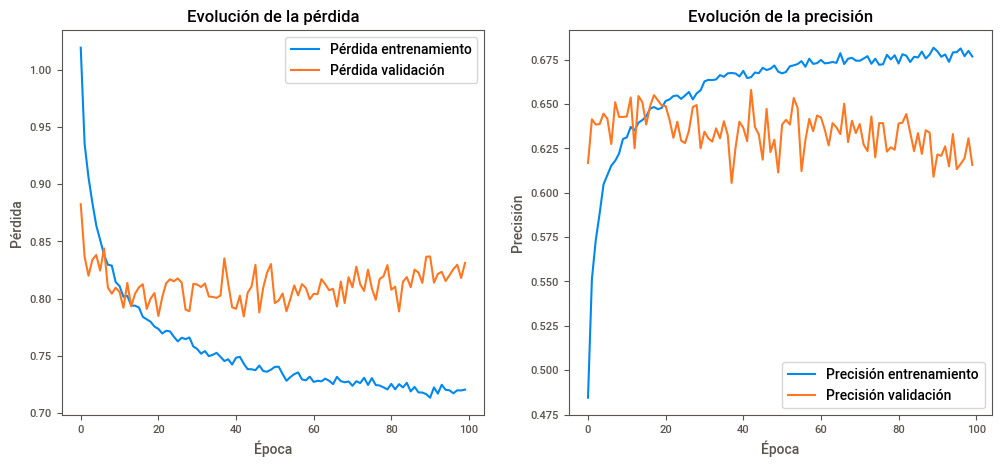

In [512]:
import matplotlib.pyplot as plt

# Graficar pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()

# Graficar precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión')
plt.legend()
plt.show()


In [513]:
def train_nn_classification_model_all(df_resultados, columnas_features, a, epochs=100, batch_size=32):
    """
    Entrena un modelo de clasificación (Subvaluada, Sobrevalorada, Neutra) para TODAS las empresas
    utilizando una red neuronal (MLP) con Keras, incluyendo capas adicionales, dropout y early stopping.
    
    Parámetros:
      df_resultados : DataFrame con TODAS las empresas y sus predicciones one‑step.
                      Debe contener 'Empresa', 'P_E' (o 'P_E_real'), 'pred_P_E', 
                      las features en columnas_features y (opcional) 'time_step' o 'Fecha'.
      columnas_features : Lista de columnas con features utilizadas.
      a : Umbral para la desviación porcentual (±a%) para etiquetar Subvaluada/Sobrevalorada/Neutra.
      epochs : Número máximo de épocas para entrenar la red.
      batch_size : Tamaño de batch para el entrenamiento.
      
    Retorna:
      model : Modelo de red neuronal entrenado.
      le : LabelEncoder utilizado para codificar/decodificar las clases.
      scaler_sup : Escalador entrenado (StandardScaler).
      df_final : DataFrame final con las etiquetas generadas (Estado) y las features desplazadas (t-1).
      history : Objeto history de Keras con el registro del entrenamiento.
    """
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import SMOTE
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping

    print("=== INICIO DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN CON RED NEURONAL (MEJORADO) ===")
    
    # 1. Verificar columnas esenciales
    cols_necesarias = ['Empresa', 'P_E', 'pred_P_E'] + columnas_features
    faltantes = [col for col in cols_necesarias if col not in df_resultados.columns]
    if faltantes:
        raise ValueError(f"Faltan columnas esenciales en df_resultados: {faltantes}")
    
    # Si no existe 'P_E_real', crearlo a partir de 'P_E'
    if 'P_E_real' not in df_resultados.columns and 'P_E' in df_resultados.columns:
        df_resultados['P_E_real'] = df_resultados['P_E']
    
    # 2. Calcular la desviación porcentual y asignar la etiqueta 'Estado'
    df_resultados['desviacion_pct'] = 100.0 * (df_resultados['pred_P_E'] - df_resultados['P_E_real']) / df_resultados['P_E_real']
    
    def calcular_estado(row):
        if pd.isna(row['desviacion_pct']):
            return np.nan
        elif row['desviacion_pct'] > a:
            return 'Subvaluada'
        elif row['desviacion_pct'] < -a:
            return 'Sobrevalorada'
        else:
            return 'Neutra'
    
    df_resultados['Estado'] = df_resultados.apply(calcular_estado, axis=1)
    
    # 3. Ordenar por 'Empresa' y 'time_step' o 'Fecha'
    if 'time_step' in df_resultados.columns:
        df_resultados = df_resultados.sort_values(['Empresa', 'time_step'])
    elif 'Fecha' in df_resultados.columns:
        df_resultados = df_resultados.sort_values(['Empresa', 'Fecha'])
    
    # 4. Aplicar shift(1) a las features para simular one-step ahead
    df_features_shifted = df_resultados.groupby('Empresa')[columnas_features].shift(1)
    df_final = df_resultados.copy()
    for col in columnas_features:
        df_final[col + '_t1'] = df_features_shifted[col]
    
    # Eliminar filas con NaN en las features desplazadas (primer registro de cada empresa)
    df_final = df_final.dropna(subset=[col + '_t1' for col in columnas_features]).copy()
    
    # 5. Preparar X e y
    columnas_shifted = [col + '_t1' for col in columnas_features]
    X = df_final[columnas_shifted]
    y = df_final['Estado'].astype(str)
    
    # 6. Codificar etiquetas (LabelEncoder + one-hot)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    from tensorflow.keras.utils import to_categorical
    y_cat = to_categorical(y_encoded)
    
    # 7. Dividir en train y test (respetando el orden temporal)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cat, test_size=0.2, random_state=42, shuffle=False
    )
    
    # 8. Escalar los datos
    scaler_sup = StandardScaler()
    X_train_scaled = scaler_sup.fit_transform(X_train)
    X_test_scaled = scaler_sup.transform(X_test)
    
    # 9. Oversampling con SMOTE (usa la versión entera de las etiquetas)
    import numpy as np
    y_train_int = np.argmax(y_train, axis=1)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train_int)
    y_train_res_cat = to_categorical(y_train_res)
    
    # 10. Definir el modelo (más capas y dropout)
    input_dim = X_train_res.shape[1]
    num_classes = y_train_res_cat.shape[1]
    
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    # EarlyStopping: detener si val_loss no mejora en 5 épocas seguidas, restaurando los mejores pesos
    callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # 11. Entrenar con early stopping
    history = model.fit(
        X_train_res,
        y_train_res_cat,
        validation_data=(X_test_scaled, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[callback],
        verbose=1
    )
    
    # 12. Evaluar el modelo en el conjunto de test
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("=== FIN DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN CON RED NEURONAL (MEJORADO) ===")
    
    return model, le, scaler_sup, df_final, history


In [519]:
model, le, scaler_sup, df_final, history = train_nn_classification_model_all(
    df_resultados=df_todas, 
    columnas_features=features, 
    a=10, 
    epochs=100, 
    batch_size=32
)

=== INICIO DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN CON RED NEURONAL (MEJORADO) ===
Epoch 1/100
765/765 [==============================] - 3s 2ms/step - loss: 1.0024 - accuracy: 0.4970 - val_loss: 0.8307 - val_accuracy: 0.6527
Epoch 2/100
765/765 [==============================] - 2s 2ms/step - loss: 0.9158 - accuracy: 0.5692 - val_loss: 0.8210 - val_accuracy: 0.6379
Epoch 3/100
765/765 [==============================] - 2s 2ms/step - loss: 0.8741 - accuracy: 0.5994 - val_loss: 0.8363 - val_accuracy: 0.6513
Epoch 4/100
765/765 [==============================] - 2s 2ms/step - loss: 0.8485 - accuracy: 0.6146 - val_loss: 0.8334 - val_accuracy: 0.6361
Epoch 5/100
765/765 [==============================] - 2s 2ms/step - loss: 0.8306 - accuracy: 0.6225 - val_loss: 0.7996 - val_accuracy: 0.6524
Epoch 6/100
765/765 [==============================] - 2s 2ms/step - loss: 0.8124 - accuracy: 0.6339 - val_loss: 0.7864 - val_accuracy: 0.6634
Epoch 7/100
765/765 [==============================] 

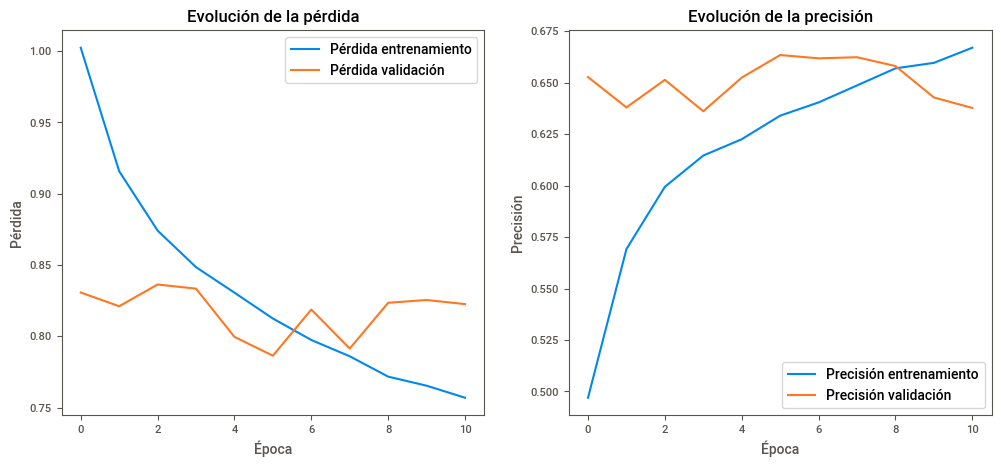

In [520]:
import matplotlib.pyplot as plt

# Graficar pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()

# Graficar precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión')
plt.legend()
plt.show()

In [541]:
def train_nn_classification_model_all(df_resultados, columnas_features, a, epochs=100, batch_size=64):
    """
    Entrena un modelo de clasificación (Subvaluada, Sobrevalorada, Neutra) para TODAS las empresas
    utilizando una red neuronal (MLP) mejorada con más neuronas, mayor batch size, learning rate ajustado
    y EarlyStopping con mayor paciencia.
    
    Parámetros:
      df_resultados : DataFrame con TODAS las empresas y sus predicciones one‑step.
                      Debe contener 'Empresa', 'P_E' (o 'P_E_real'), 'pred_P_E', 
                      las features en columnas_features y (opcional) 'time_step' o 'Fecha'.
      columnas_features : Lista de columnas con features utilizadas.
      a : Umbral para la desviación porcentual (±a%) para etiquetar Subvaluada/Sobrevalorada/Neutra.
      epochs : Número máximo de épocas para entrenar la red.
      batch_size : Tamaño de batch para el entrenamiento.
      
    Retorna:
      model : Modelo de red neuronal entrenado.
      le : LabelEncoder utilizado para codificar/decodificar las clases.
      scaler_sup : Escalador entrenado (StandardScaler).
      df_final : DataFrame final con las etiquetas generadas (Estado) y las features desplazadas (t-1).
      history : Objeto history de Keras con el registro del entrenamiento.
    """
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import SMOTE
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping

    print("=== INICIO DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN CON RED NEURONAL (MEJORADO) ===")
    
    # 1. Verificar columnas esenciales
    cols_necesarias = ['Empresa', 'P_E', 'pred_P_E'] + columnas_features
    faltantes = [col for col in cols_necesarias if col not in df_resultados.columns]
    if faltantes:
        raise ValueError(f"Faltan columnas esenciales en df_resultados: {faltantes}")
    
    # Si no existe 'P_E_real', crearlo a partir de 'P_E'
    if 'P_E_real' not in df_resultados.columns and 'P_E' in df_resultados.columns:
        df_resultados['P_E_real'] = df_resultados['P_E']
    
    # 2. Calcular la desviación porcentual y asignar la etiqueta 'Estado'
    df_resultados['desviacion_pct'] = 100.0 * (df_resultados['pred_P_E'] - df_resultados['P_E_real']) / df_resultados['P_E_real']
    
    def calcular_estado(row):
        if pd.isna(row['desviacion_pct']):
            return np.nan
        elif row['desviacion_pct'] > a:
            return 'Subvaluada'
        elif row['desviacion_pct'] < -a:
            return 'Sobrevalorada'
        else:
            return 'Neutra'
    
    df_resultados['Estado'] = df_resultados.apply(calcular_estado, axis=1)
    
    # 3. Ordenar por 'Empresa' y 'time_step' o 'Fecha'
    if 'time_step' in df_resultados.columns:
        df_resultados = df_resultados.sort_values(['Empresa', 'time_step'])
    elif 'Fecha' in df_resultados.columns:
        df_resultados = df_resultados.sort_values(['Empresa', 'Fecha'])
    
    # 4. Aplicar shift(1) a las features para simular one-step ahead
    df_features_shifted = df_resultados.groupby('Empresa')[columnas_features].shift(1)
    df_final = df_resultados.copy()
    for col in columnas_features:
        df_final[col + '_t1'] = df_features_shifted[col]
    
    # Eliminar filas con NaN en las features desplazadas (primer registro de cada empresa)
    df_final = df_final.dropna(subset=[col + '_t1' for col in columnas_features]).copy()
    
    # 5. Preparar X e y
    columnas_shifted = [col + '_t1' for col in columnas_features]
    X = df_final[columnas_shifted]
    y = df_final['Estado'].astype(str)
    
    # 6. Codificar etiquetas (LabelEncoder + one-hot)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_cat = to_categorical(y_encoded)
    
    # 7. Dividir en train y test (respetando el orden temporal)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cat, test_size=0.2, random_state=42, shuffle=False
    )
    
    # 8. Escalar los datos
    scaler_sup = StandardScaler()
    X_train_scaled = scaler_sup.fit_transform(X_train)
    X_test_scaled = scaler_sup.transform(X_test)
    
    # 9. Aplicar oversampling con SMOTE (usa la versión entera de las etiquetas)
    y_train_int = np.argmax(y_train, axis=1)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train_int)
    y_train_res_cat = to_categorical(y_train_res)
    
    # 10. Definir el modelo con mayor cantidad de neuronas y dropout aumentado
    input_dim = X_train_res.shape[1]
    num_classes = y_train_res_cat.shape[1]
    
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    # EarlyStopping con mayor paciencia (10 épocas)
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # 11. Entrenar con early stopping y nuevo batch size
    history = model.fit(
        X_train_res,
        y_train_res_cat,
        validation_data=(X_test_scaled, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[callback],
        verbose=1
    )
    
    # 12. Evaluar el modelo en el conjunto de test
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("=== FIN DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN CON RED NEURONAL (MEJORADO) ===")
    
    return model, le, scaler_sup, df_final, history


In [542]:
model, le, scaler_sup, df_final, history = train_nn_classification_model_all(
    df_resultados=df_todas, 
    columnas_features=features, 
    a=10, 
    epochs=100, 
    batch_size=32
)


=== INICIO DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN CON RED NEURONAL (MEJORADO) ===
Epoch 1/100
765/765 [==============================] - 3s 3ms/step - loss: 1.0304 - accuracy: 0.4741 - val_loss: 0.8576 - val_accuracy: 0.6337
Epoch 2/100
765/765 [==============================] - 2s 3ms/step - loss: 0.9473 - accuracy: 0.5488 - val_loss: 0.8116 - val_accuracy: 0.6559
Epoch 3/100
765/765 [==============================] - 2s 3ms/step - loss: 0.9077 - accuracy: 0.5725 - val_loss: 0.7913 - val_accuracy: 0.6655
Epoch 4/100
765/765 [==============================] - 2s 3ms/step - loss: 0.8793 - accuracy: 0.5952 - val_loss: 0.8420 - val_accuracy: 0.6414
Epoch 5/100
765/765 [==============================] - 2s 3ms/step - loss: 0.8602 - accuracy: 0.6094 - val_loss: 0.7815 - val_accuracy: 0.6775
Epoch 6/100
765/765 [==============================] - 2s 3ms/step - loss: 0.8388 - accuracy: 0.6179 - val_loss: 0.8031 - val_accuracy: 0.6527
Epoch 7/100
765/765 [==============================] 

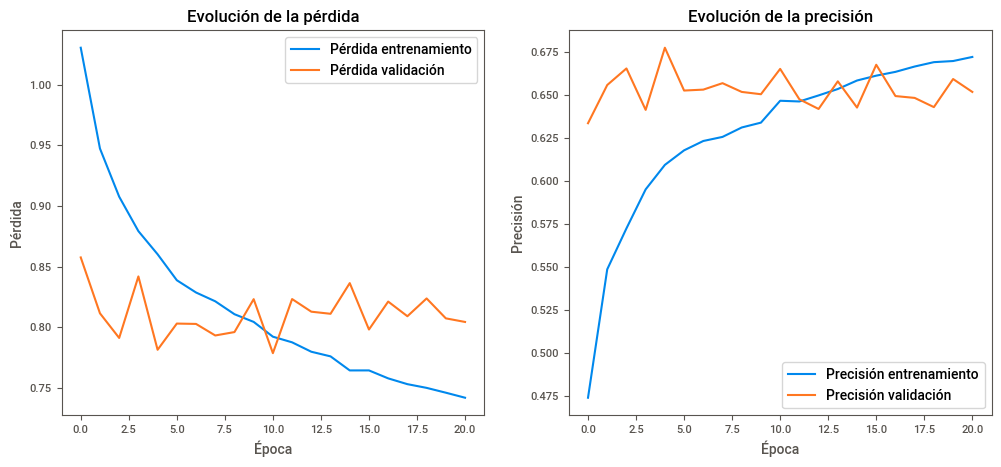

In [543]:
import matplotlib.pyplot as plt

# Graficar pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()

# Graficar precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión')
plt.legend()
plt.show()

In [570]:
def train_nn_classification_model_all_by_company(df_resultados, columnas_features, a, train_ratio=0.8, epochs=100, batch_size=64):
    """
    Entrena un modelo de clasificación (Subvaluada, Sobrevalorada, Neutra) de forma global 
    usando datos de todas las empresas, respetando la secuencia temporal de cada compañía.
    
    Para cada empresa, se separan los datos en entrenamiento y test (según el parámetro train_ratio),
    se aplica un shift(1) a las features para simular la predicción one‑step ahead y se calcula la etiqueta 'Estado'
    según la desviación porcentual (con umbral ±a%).
    
    Parámetros:
      df_resultados : DataFrame que contiene datos de todas las empresas. Debe incluir las columnas:
                      'Empresa', 'P_E' (o 'P_E_real'), 'pred_P_E', y las columnas en columnas_features.
                      Además, se recomienda tener 'time_step' o 'Fecha' para ordenar temporalmente.
      columnas_features : Lista de columnas con features a utilizar.
      a : Umbral (en %) para determinar las etiquetas: 
          si desviación > a → 'Subvaluada'; si desviación < -a → 'Sobrevalorada'; en otro caso → 'Neutra'.
      train_ratio : Proporción de datos que se usan para entrenamiento en cada empresa.
      epochs : Número máximo de épocas para entrenar la red.
      batch_size : Tamaño del batch para el entrenamiento.
      
    Retorna:
      model : Modelo de red neuronal entrenado.
      le : LabelEncoder usado para codificar/decodificar las etiquetas.
      scaler_sup : Escalador entrenado (StandardScaler).
      df_train_final : DataFrame final de entrenamiento (con features desplazadas y etiquetas).
      df_test_final : DataFrame final de test (con features desplazadas y etiquetas).
      history : Objeto history de Keras con el registro del entrenamiento.
    """
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping
    from imblearn.over_sampling import SMOTE

    # --- 1. Separar datos por empresa, dividiendo en train y test de cada una ---
    df_train_list = []
    df_test_list = []
    empresas = df_resultados['Empresa'].unique()
    for emp in empresas:
        df_emp = df_resultados[df_resultados['Empresa'] == emp].copy()
        # Ordenar cronológicamente (usar 'Fecha' o 'time_step')
        if 'Fecha' in df_emp.columns:
            df_emp = df_emp.sort_values('Fecha')
        elif 'time_step' in df_emp.columns:
            df_emp = df_emp.sort_values('time_step')
        n = len(df_emp)
        cutoff = int(n * train_ratio)
        df_train_list.append(df_emp.iloc[:cutoff])
        df_test_list.append(df_emp.iloc[cutoff:])
    
    df_train = pd.concat(df_train_list, ignore_index=True)
    df_test = pd.concat(df_test_list, ignore_index=True)
    
    # --- 2. Función para agregar shift(1) a las features en un DataFrame ---
    def add_shift_features(df, columnas_features):
        df_shift = df.groupby('Empresa')[columnas_features].shift(1)
        df_new = df.copy()
        for col in columnas_features:
            df_new[col + '_t1'] = df_shift[col]
        df_new = df_new.dropna(subset=[col + '_t1' for col in columnas_features])
        return df_new

    df_train_final = add_shift_features(df_train, columnas_features)
    df_test_final = add_shift_features(df_test, columnas_features)
    
    # --- 3. Asegurar que exista 'P_E_real' y calcular la desviación porcentual y etiqueta 'Estado' ---
    for df in [df_train_final, df_test_final]:
        if 'P_E_real' not in df.columns and 'P_E' in df.columns:
            df['P_E_real'] = df['P_E']
        df['desviacion_pct'] = 100.0 * (df['pred_P_E'] - df['P_E_real']) / df['P_E_real']
        def calcular_estado(row, a):
            if pd.isna(row['desviacion_pct']):
                return np.nan
            elif row['desviacion_pct'] > a:
                return 'Subvaluada'
            elif row['desviacion_pct'] < -a:
                return 'Sobrevalorada'
            else:
                return 'Neutra'
        df['Estado'] = df.apply(lambda r: calcular_estado(r, a), axis=1)
    
    # --- 4. Preparar X e y para entrenamiento y test ---
    columnas_shifted = [col + '_t1' for col in columnas_features]
    X_train = df_train_final[columnas_shifted]
    y_train = df_train_final['Estado'].astype(str)
    X_test = df_test_final[columnas_shifted]
    y_test = df_test_final['Estado'].astype(str)
    
    # --- 5. Codificar las etiquetas ---
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_train_cat = to_categorical(y_train_encoded)
    y_test_encoded = le.transform(y_test)
    y_test_cat = to_categorical(y_test_encoded)
    
    # --- 6. Escalar las features ---
    scaler_sup = StandardScaler()
    X_train_scaled = scaler_sup.fit_transform(X_train)
    X_test_scaled = scaler_sup.transform(X_test)
    
    # --- 7. Aplicar SMOTE en el conjunto de entrenamiento ---
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train_encoded)
    y_train_res_cat = to_categorical(y_train_res)
    
    # --- 8. Definir y entrenar la red neuronal ---
    input_dim = X_train_res.shape[1]
    num_classes = y_train_res_cat.shape[1]
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Ajustamos el learning rate a 0.001 (puedes probar otros valores)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    # EarlyStopping con paciencia de 10 épocas
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        X_train_res, y_train_res_cat,
        validation_data=(X_test_scaled, y_test_cat),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[callback],
        verbose=1
    )
    
    loss, accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("=== FIN DEL ENTRENAMIENTO DEL MODELO DE CLASIFICACIÓN CON RED NEURONAL (GLOBAL) ===")
    
    return model, le, scaler_sup, df_train_final, df_test_final, history


In [596]:
model, le, scaler_sup, df_train_final, df_test_final, history = train_nn_classification_model_all_by_company(
    df_resultados=df_todas, 
    columnas_features=features, 
    a=10, 
    epochs=100, 
    batch_size=64
)

Epoch 1/100
373/373 [==============================] - 2s 4ms/step - loss: 1.0120 - accuracy: 0.4928 - val_loss: 0.8322 - val_accuracy: 0.6214
Epoch 2/100
373/373 [==============================] - 1s 3ms/step - loss: 0.9345 - accuracy: 0.5572 - val_loss: 0.7724 - val_accuracy: 0.6414
Epoch 3/100
373/373 [==============================] - 1s 3ms/step - loss: 0.8912 - accuracy: 0.5830 - val_loss: 0.7559 - val_accuracy: 0.6477
Epoch 4/100
373/373 [==============================] - 1s 3ms/step - loss: 0.8646 - accuracy: 0.5997 - val_loss: 0.7310 - val_accuracy: 0.6680
Epoch 5/100
373/373 [==============================] - 1s 3ms/step - loss: 0.8400 - accuracy: 0.6149 - val_loss: 0.7195 - val_accuracy: 0.6912
Epoch 6/100
373/373 [==============================] - 1s 3ms/step - loss: 0.8238 - accuracy: 0.6182 - val_loss: 0.7523 - val_accuracy: 0.6713
Epoch 7/100
373/373 [==============================] - 1s 3ms/step - loss: 0.8108 - accuracy: 0.6304 - val_loss: 0.7216 - val_accuracy: 0.6984

In [572]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

# Asumiendo que 'df_test_final' contiene la columna 'Estado' con las etiquetas reales
# y que las features de test están en columnas con sufijo '_t1':
columnas_shifted = [col + '_t1' for col in features]
X_test = df_test_final[columnas_shifted]
y_test_true = df_test_final['Estado'].values  # Etiquetas reales en forma de string

# Escalar las features de test con el escalador entrenado
X_test_scaled = scaler_sup.transform(X_test)

# Obtener las predicciones del modelo: predicción en forma de probabilidades
y_test_pred_prob = model.predict(X_test_scaled)
# Convertir a índices de clase (la posición con mayor probabilidad)
y_test_pred_indices = np.argmax(y_test_pred_prob, axis=1)
# Convertir índices a etiquetas usando el LabelEncoder
y_test_pred = le.inverse_transform(y_test_pred_indices)

# Calcular accuracy y reporte de clasificación
acc = accuracy_score(y_test_true, y_test_pred)
print("Accuracy:", acc)
print("\nReporte de clasificación:")
print(classification_report(y_test_true, y_test_pred))

# Calcular y mostrar la matriz de confusión
cm = confusion_matrix(y_test_true, y_test_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
print("\nMatriz de Confusión:")
print(cm_df)


113/113 [==============================] - 0s 1ms/step
Accuracy: 0.7000830794793685

Reporte de clasificación:
               precision    recall  f1-score   support

       Neutra       0.40      0.36      0.38       649
Sobrevalorada       0.69      0.62      0.65       848
   Subvaluada       0.78      0.84      0.81      2114

     accuracy                           0.70      3611
    macro avg       0.62      0.61      0.61      3611
 weighted avg       0.69      0.70      0.69      3611


Matriz de Confusión:
               Neutra  Sobrevalorada  Subvaluada
Neutra            235            122         292
Sobrevalorada     112            525         211
Subvaluada        234            112        1768


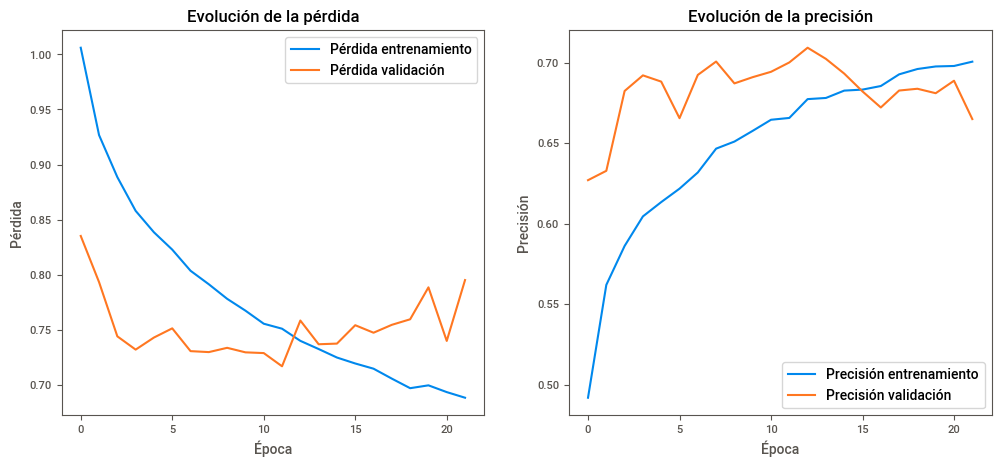

In [573]:
# Graficar pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()

# Graficar precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión')
plt.legend()
plt.show()

In [600]:
def inferir_nueva_empresa_con_metricas_df(df_nueva, model, scaler_sup, columnas_features, le=None):
    """
    Realiza la inferencia en una nueva empresa aplicando el mismo preprocesamiento (shift(1) de las features)
    y escalado que se usó en el entrenamiento. Retorna un DataFrame con la etiqueta real (si existe) en 'Estado'
    y la predicción en 'pred_estado'. Además, si la columna 'Estado' existe, calcula las métricas:
    - Accuracy
    - Reporte de clasificación (precision, recall, f1-score)
    - Matriz de confusión (en formato numérico y DataFrame)
    
    Parámetros:
      df_nueva : DataFrame con los datos de la nueva empresa. Debe contener la columna 'Empresa' y las columnas
                 indicadas en columnas_features. Si existe, la columna 'Estado' debe contener la etiqueta real.
      model : Modelo de red neuronal entrenado.
      scaler_sup : Escalador (por ejemplo, StandardScaler) entrenado.
      columnas_features : Lista de columnas de features utilizadas.
      le : (Opcional) LabelEncoder para convertir índices a las etiquetas originales.
      
    Retorna:
      df_result : DataFrame con las columnas 'Estado' (real, si existe) y 'pred_estado' (predicción del modelo).
      metrics : Diccionario con las métricas calculadas ('accuracy', 'classification_report', 
                'confusion_matrix' y 'confusion_matrix_df'). Si no existe la columna 'Estado', metrics es None.
    """
    import pandas as pd
    import numpy as np
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    # 1. Aplicar shift(1) a las features (agrupando por 'Empresa')
    df_nueva_shift = df_nueva.groupby('Empresa')[columnas_features].shift(1)
    df_nueva_proc = df_nueva.copy()
    for col in columnas_features:
        df_nueva_proc[col + '_t1'] = df_nueva_shift[col]
    
    # Eliminar filas sin datos en las features desplazadas
    df_nueva_proc = df_nueva_proc.dropna(subset=[col + '_t1' for col in columnas_features])
    
    # 2. Preparar la matriz de features y escalarla
    cols_shifted = [col + '_t1' for col in columnas_features]
    X_nueva = df_nueva_proc[cols_shifted]
    X_nueva_scaled = scaler_sup.transform(X_nueva)
    
    # 3. Realizar la predicción
    pred_prob = model.predict(X_nueva_scaled)
    pred_class_idx = pred_prob.argmax(axis=1)
    if le is not None:
        pred_class = le.inverse_transform(pred_class_idx)
    else:
        pred_class = pred_class_idx
    
    df_nueva_proc['pred_estado'] = pred_class
    
    # 4. Si existe la columna real 'Estado', calcular las métricas
    metrics = {}
    if 'Estado' in df_nueva_proc.columns:
        y_true = df_nueva_proc['Estado'].values
        y_pred = pred_class
        acc = accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        cm = confusion_matrix(y_true, y_pred)
        # Si se dispone del LabelEncoder, usar sus clases para indexar el DataFrame de la matriz de confusión
        if le is not None:
            classes = le.classes_
        else:
            classes = None
        cm_df = pd.DataFrame(cm, index=classes, columns=classes)
        
        metrics = {
            'accuracy': acc,
            'classification_report': report,
            'confusion_matrix': cm,
            'confusion_matrix_df': cm_df
        }
        # Construir el DataFrame de resultados con las columnas 'Estado' y 'pred_estado'
        df_result = df_nueva_proc[['Estado', 'pred_estado']].copy()
    else:
        df_result = df_nueva_proc[['pred_estado']].copy()
        metrics = None

    return df_result, metrics


In [602]:
df_resultados, metricas = inferir_nueva_empresa_con_metricas_df(
    df_dlocal_class, 
    model, 
    scaler_sup, 
    columnas_features=features, 
    le=le, 
)

print("Resultados:")
print(df_resultados.head())

if metricas is not None:
    print("\nAccuracy:", metricas['accuracy'])
    print("\nReporte de clasificación:", metricas['classification_report'])
    print("\nMatriz de Confusión:")
    print(metricas['confusion_matrix_df'])


1/1 [==============================] - 0s 24ms/step
Resultados:
          Estado pred_estado
1  Sobrevalorada      Neutra
2  Sobrevalorada      Neutra
3  Sobrevalorada      Neutra
4  Sobrevalorada      Neutra
5         Neutra      Neutra

Accuracy: 0.4444444444444444

Reporte de clasificación: {'Neutra': {'precision': 0.18181818181818182, 'recall': 0.3333333333333333, 'f1-score': 0.23529411764705885, 'support': 6.0}, 'Sobrevalorada': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}, 'Subvaluada': {'precision': 0.625, 'recall': 0.7692307692307693, 'f1-score': 0.6896551724137931, 'support': 13.0}, 'accuracy': 0.4444444444444444, 'macro avg': {'precision': 0.268939393939394, 'recall': 0.36752136752136755, 'f1-score': 0.308316430020284, 'support': 27.0}, 'weighted avg': {'precision': 0.3413299663299663, 'recall': 0.4444444444444444, 'f1-score': 0.3843437758245061, 'support': 27.0}}

Matriz de Confusión:
               Neutra  Sobrevalorada  Subvaluada
Neutra              